# HOUSE PRICE PREDICTION MODEL (EV FIYAT TAHMINI MODELİ)

- **Business Problem:** **It is desired to carry out a machine learning project regarding the prices of different types of houses by using the dataset containing the features and house prices of each house.** *(Her eve ait özelliklerin ve ev fiyatlarının bulunduğu veriseti kullanılarak, farklı tipteki evlerin fiyatlarına ilişkin bir makine öğrenmesi projesi gerçekleştirilmek istenmektedir.)*

- **Data Set Story:** **There are 79 explanatory variables in this data set of residential homes in Ames, Lowa.** *(Ames, Lowa'daki konut evlerinden oluşan bu veri seti içerisinde 79 açıklayıcı değişken bulunduruyor.)*

- **Total Number of Observations 1460** *(Toplam Gözlem Sayısı 1460)*
- **Numeric Variable 38** *(Sayısal Değişken 38)*
- **Categorical Variable 43** *(Kategorik Değişken 43)*

- **We will develop a machine learning model that predicts house prices with minimum error based on the data set we have.** *(Elimizdeki veri seti üzerinden minimum hata ile ev fiyatlarını tahmin eden bir makine öğrenmesi modeli geliştireceğiz.)*

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [78]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [79]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [80]:
df = pd.read_csv('train.csv')

## Exploratory Data Analysis (Keşif amaçlı veri analizi)

### General Picture (Genel Resim)

In [82]:
def check_df(dataframe, head=5):
    print('##################### Shape ###################')
    print(dataframe.shape)
    print('##################### Types ###################')
    print(dataframe.dtypes)
    print('#####################  Head ###################')
    print(dataframe.head(head))
    print('#####################  Tail ###################')
    print(dataframe.tail(head))
    print('#####################   NA  ###################')
    print(dataframe.isnull().sum())
    print('##################### Describe ################')
    print(dataframe.describe().T)
    print('##################### Quantiles ###############')
    keep_columns = [col for col in dataframe.columns if dataframe[col].dtype in ['int64', 'float64']]
    df_numeric = dataframe[keep_columns]
    print(df_numeric.quantile([0, 0.05, 0.1, 0.25, 0.50, 0.75, 0.9, 0.99, 1]).T)

In [83]:
check_df(df)

##################### Shape ###################
(1460, 81)
##################### Types ###################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      

In [84]:
# Removing Outliers from Data (Aykırı Değerlerin Veriden Uzaklaştırılması)
df = df.loc[df['SalePrice'] <= 400000]

In [85]:
check_df(df)

##################### Shape ###################
(1432, 81)
##################### Types ###################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      

In [86]:
# Capturing Numerical and Categorical Variables (Sayısal ve Kategorik Değişkenlerin Yakalanması)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in df.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in df.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in df.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == 'O']

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car, num_but_cat

In [87]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 1432
Variables: 81
cat_cols: 53
num_cols: 27
cat_but_car: 1
num_but_cat: 11


### Analysis of Categorical Variables (Kategorik Değişken Analizi)

In [88]:
def cat_summary(dataframe, col_name, plot=False):
    print('-------------------------------------------------------')
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

-------------------------------------------------------
          MSZoning  Ratio
MSZoning                 
RL            1124 78.492
RM             217 15.154
FV              65  4.539
RH              16  1.117
C (all)         10  0.698


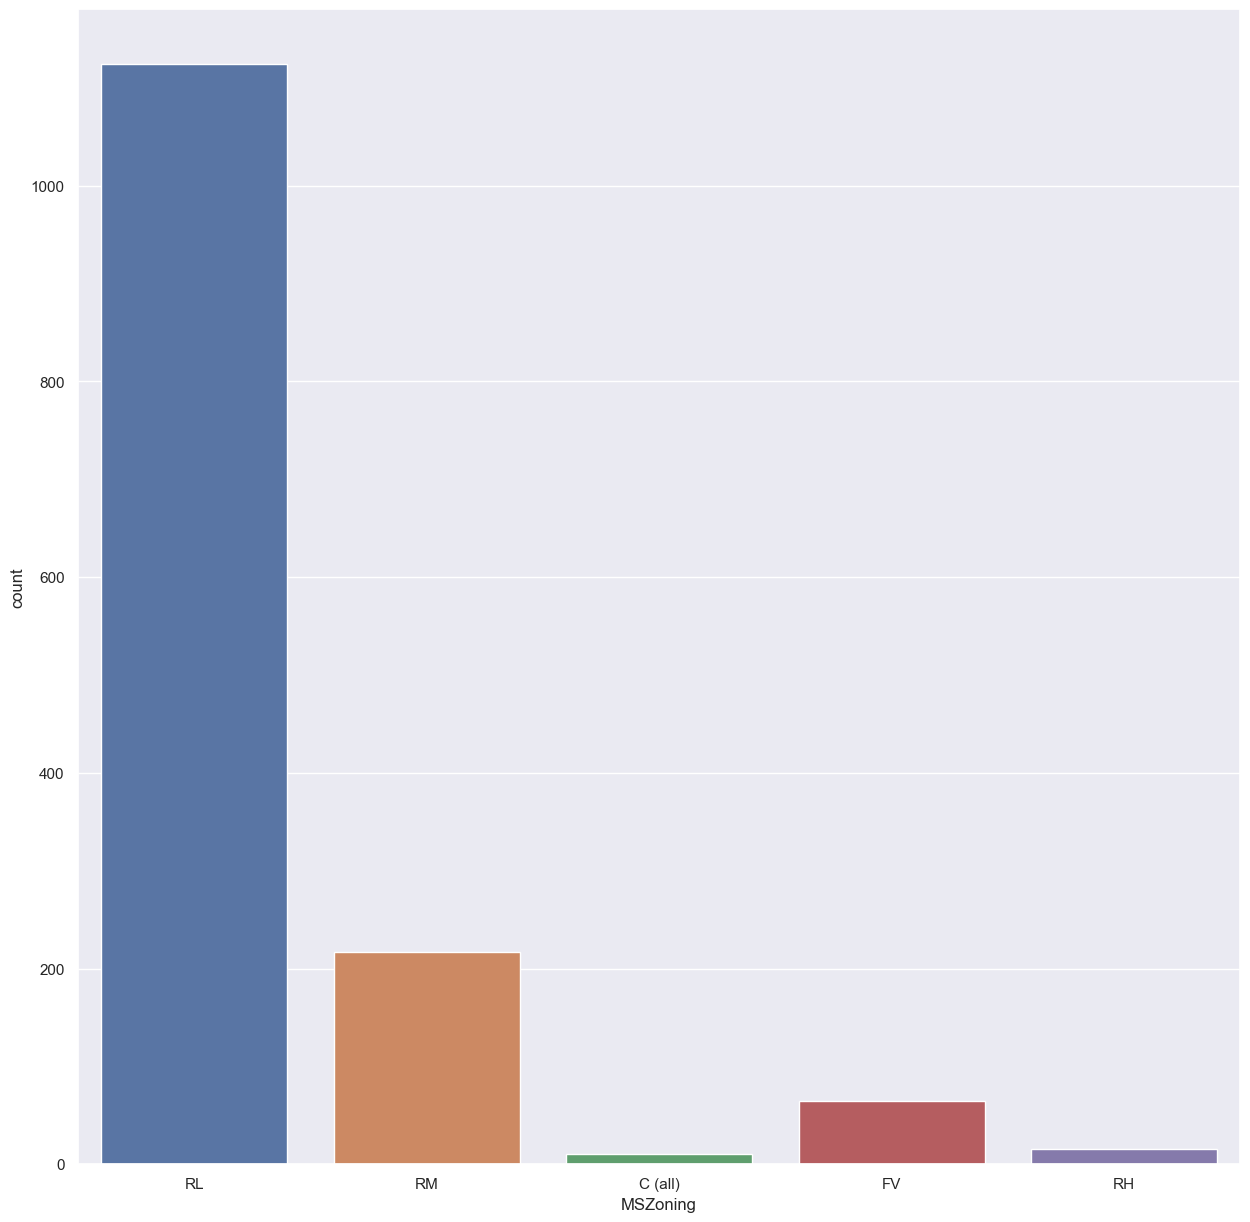

-------------------------------------------------------
        Street  Ratio
Street               
Pave      1426 99.581
Grvl         6  0.419


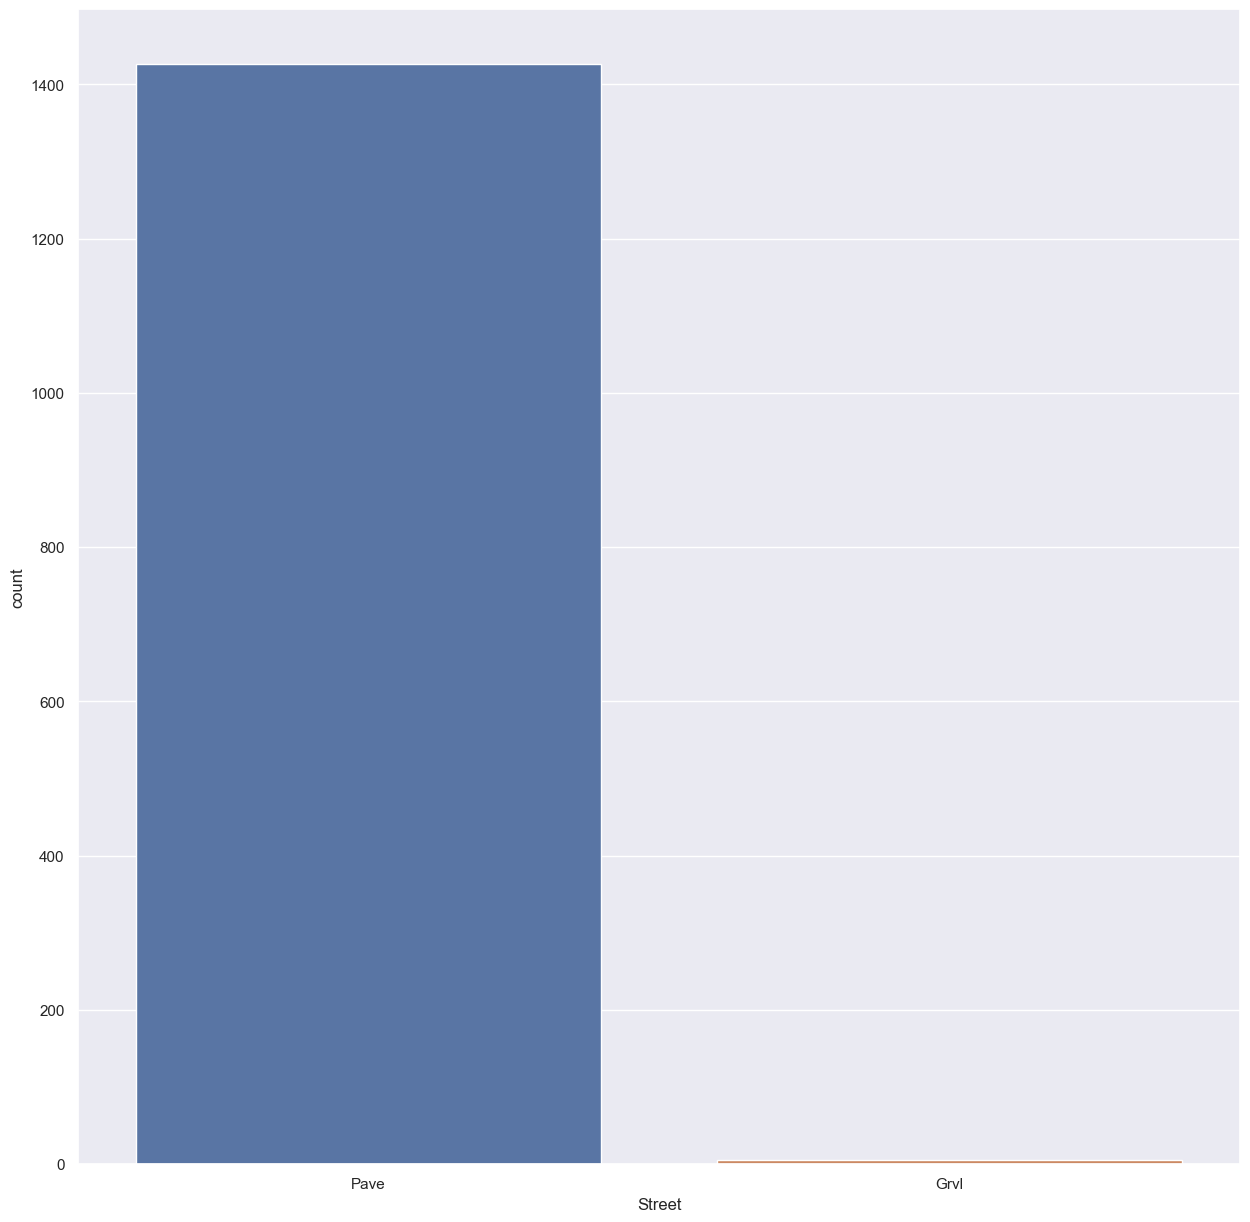

-------------------------------------------------------
       Alley  Ratio
Alley              
Grvl      50  3.492
Pave      41  2.863


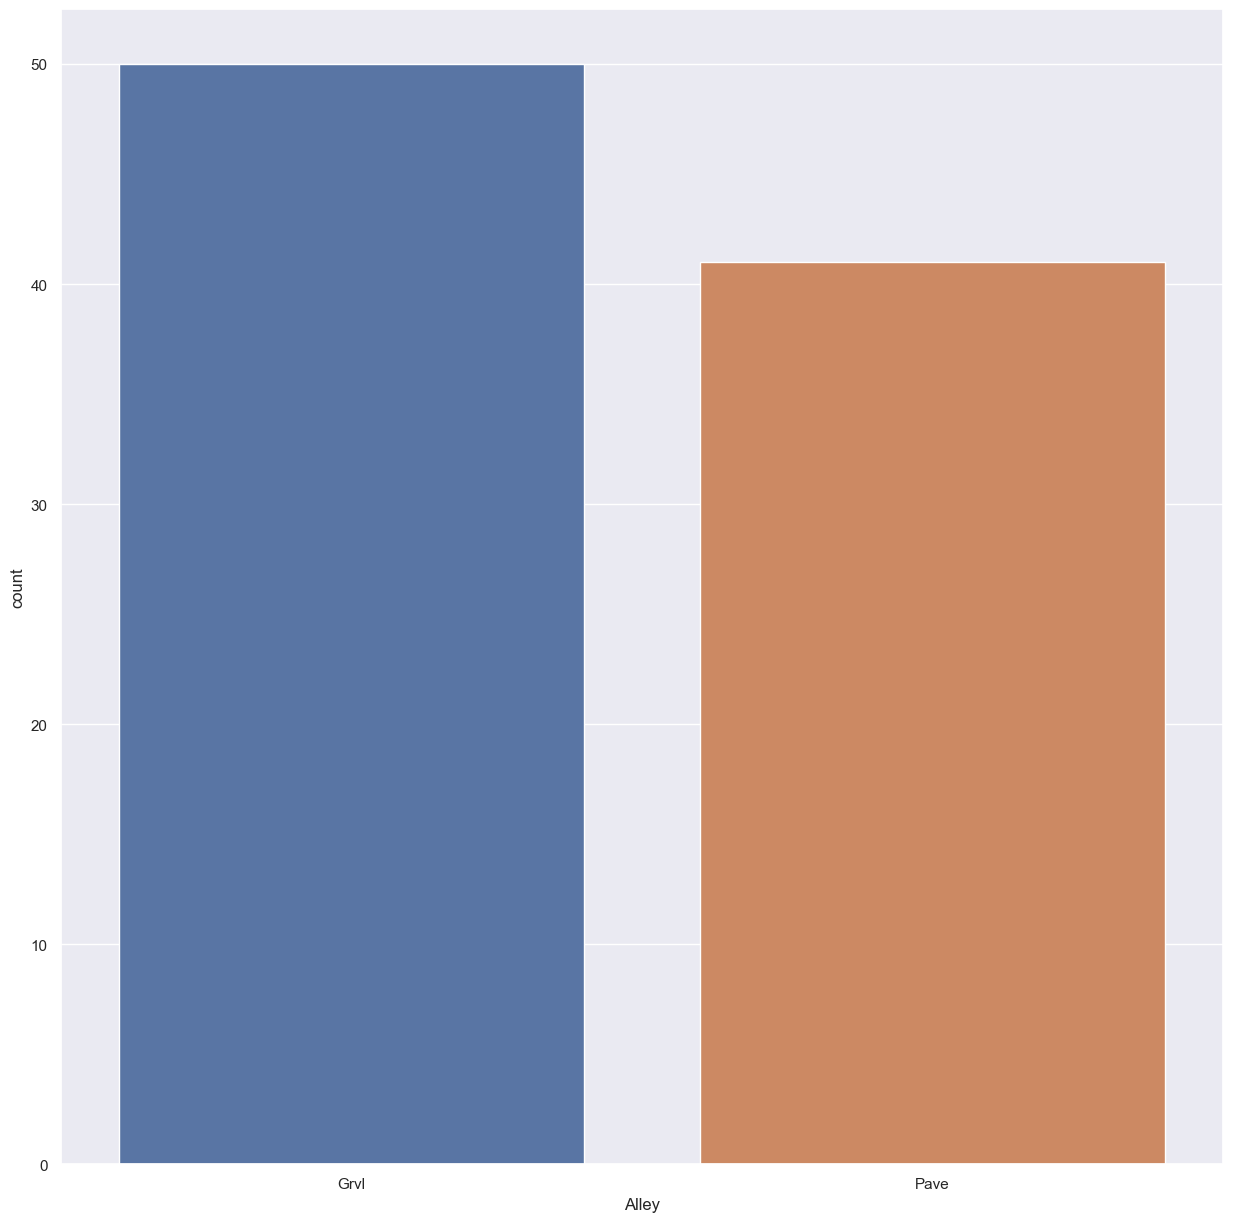

-------------------------------------------------------
          LotShape  Ratio
LotShape                 
Reg            916 63.966
IR1            471 32.891
IR2             35  2.444
IR3             10  0.698


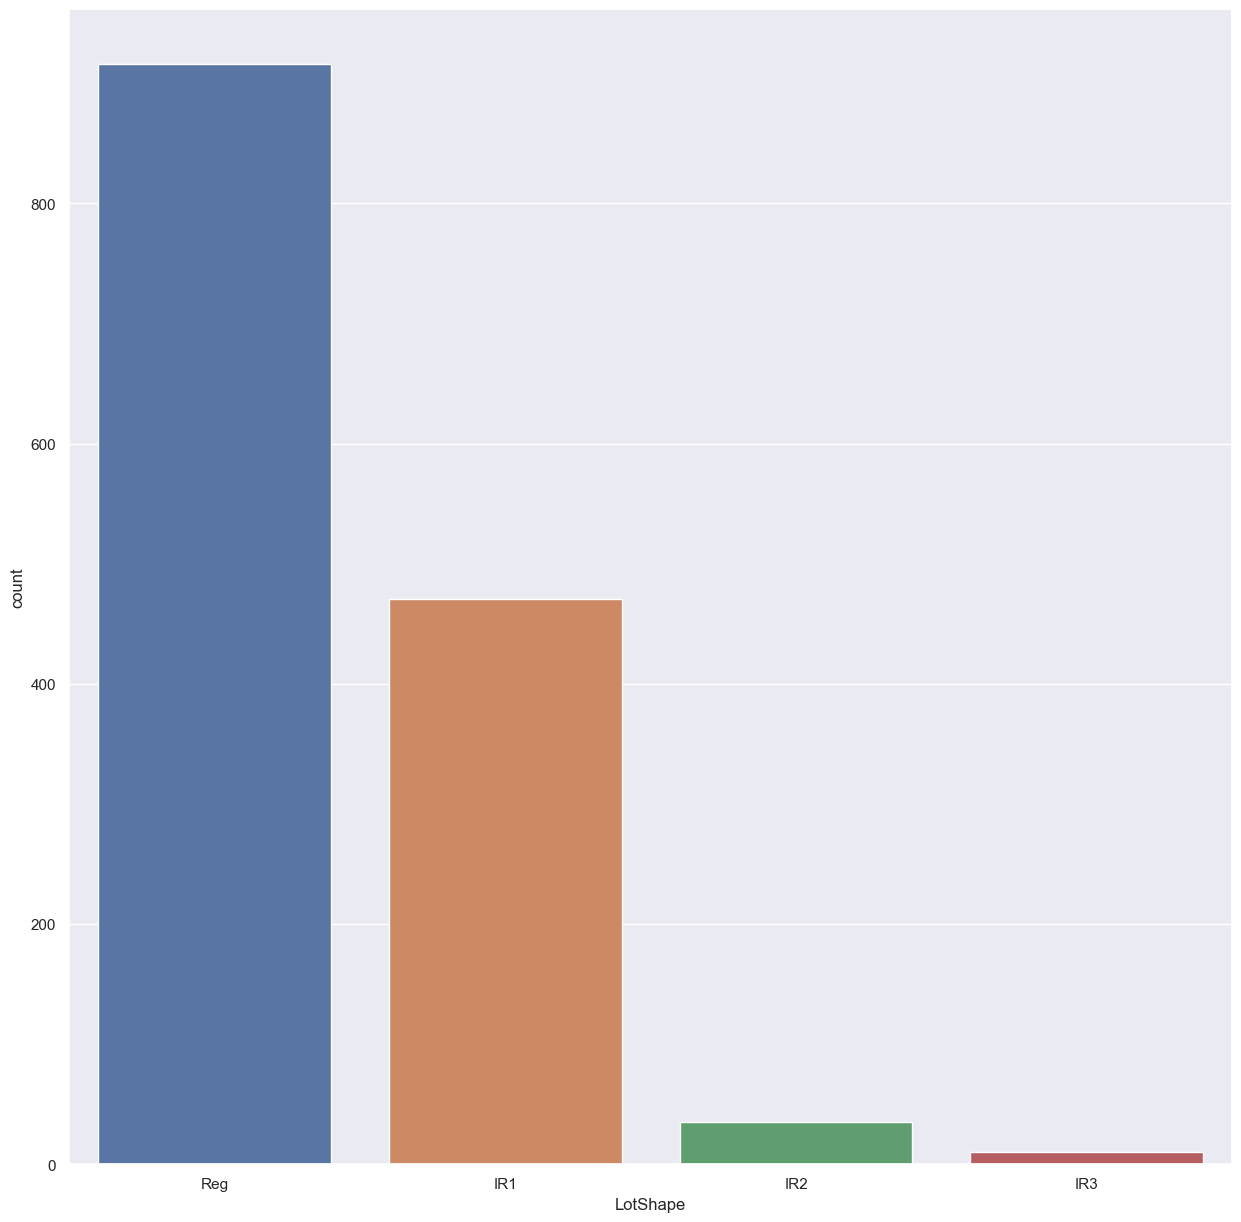

-------------------------------------------------------
             LandContour  Ratio
LandContour                    
Lvl                 1285 89.735
Bnk                   63  4.399
HLS                   48  3.352
Low                   36  2.514


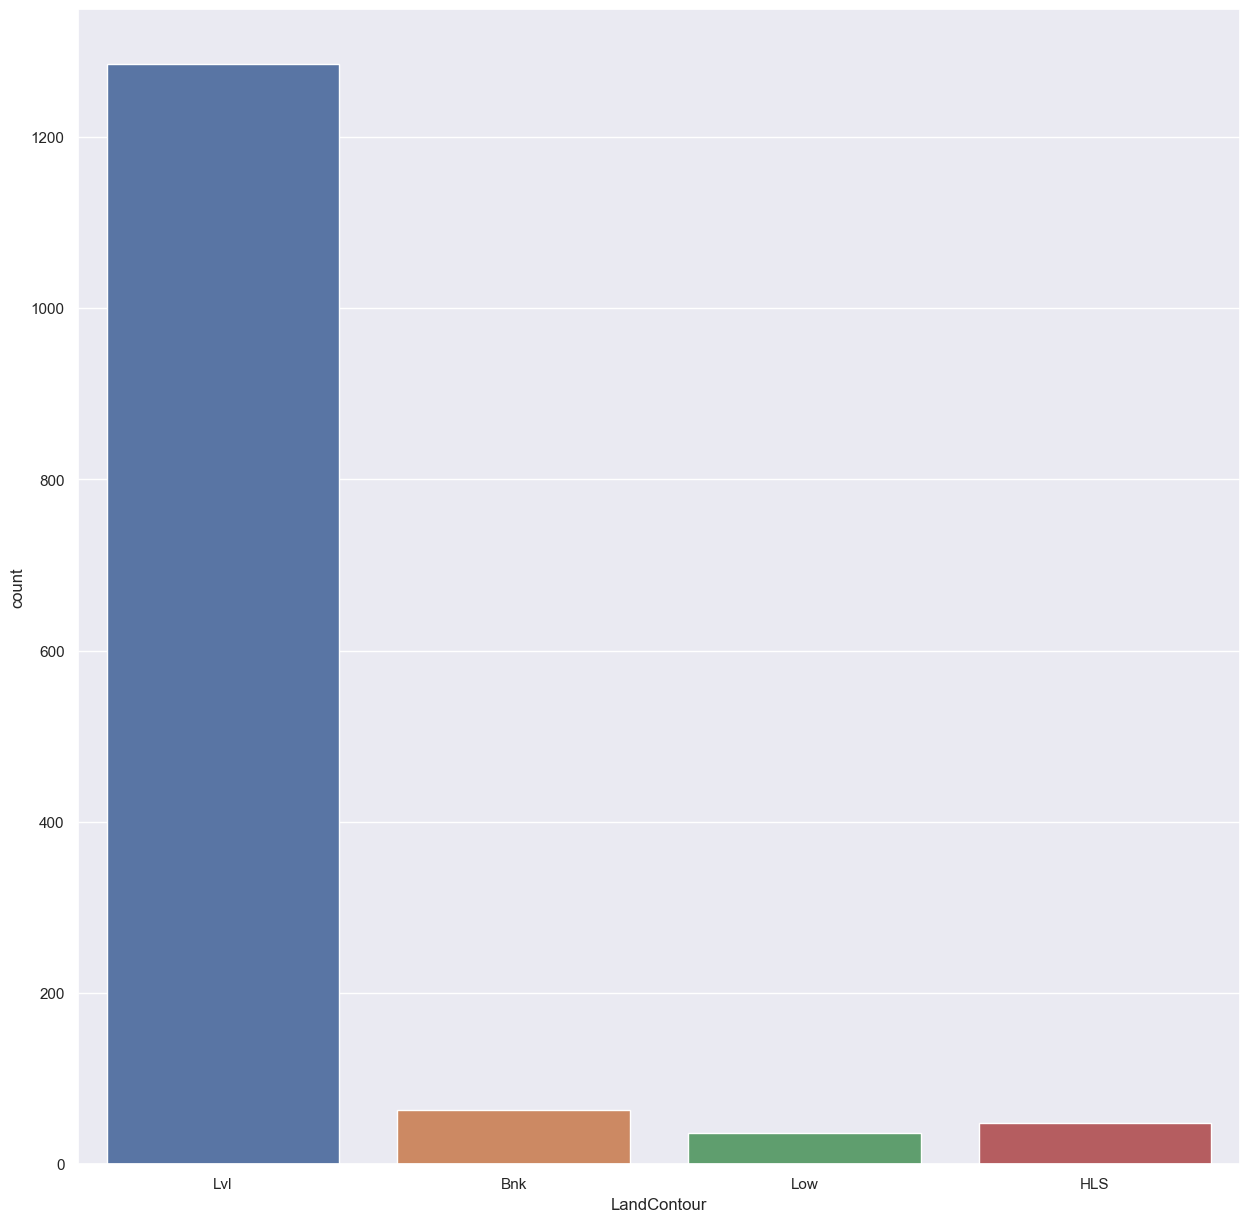

-------------------------------------------------------
           Utilities  Ratio
Utilities                  
AllPub          1431 99.930
NoSeWa             1  0.070


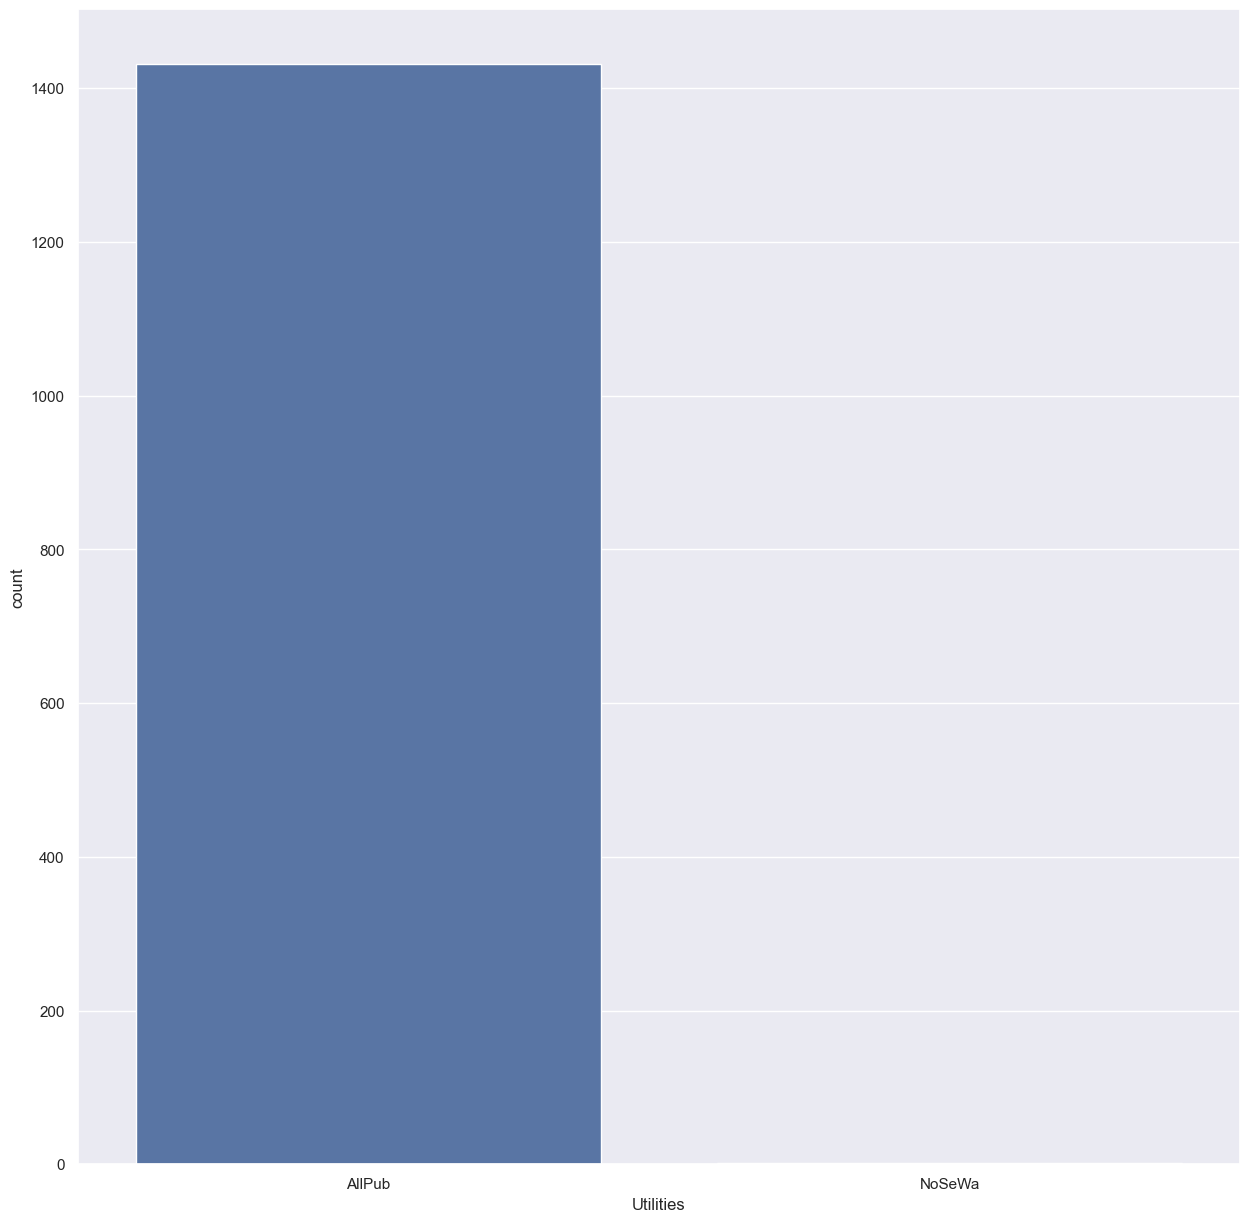

-------------------------------------------------------
           LotConfig  Ratio
LotConfig                  
Inside          1034 72.207
Corner           260 18.156
CulDSac           87  6.075
FR2               47  3.282
FR3                4  0.279


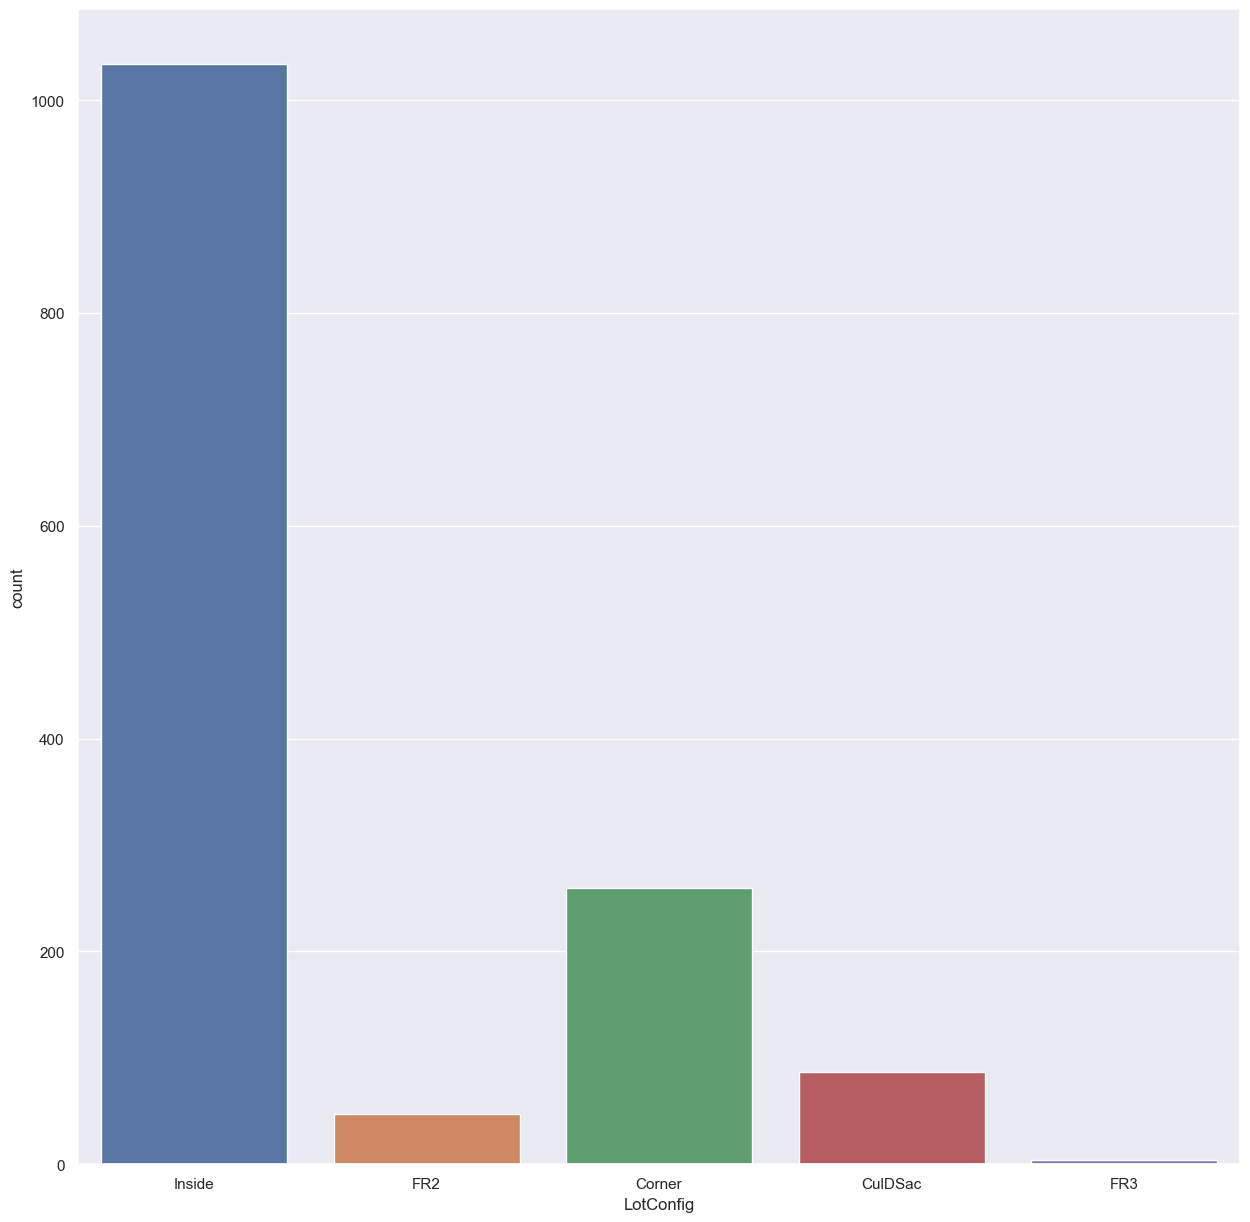

-------------------------------------------------------
           LandSlope  Ratio
LandSlope                  
Gtl             1355 94.623
Mod               64  4.469
Sev               13  0.908


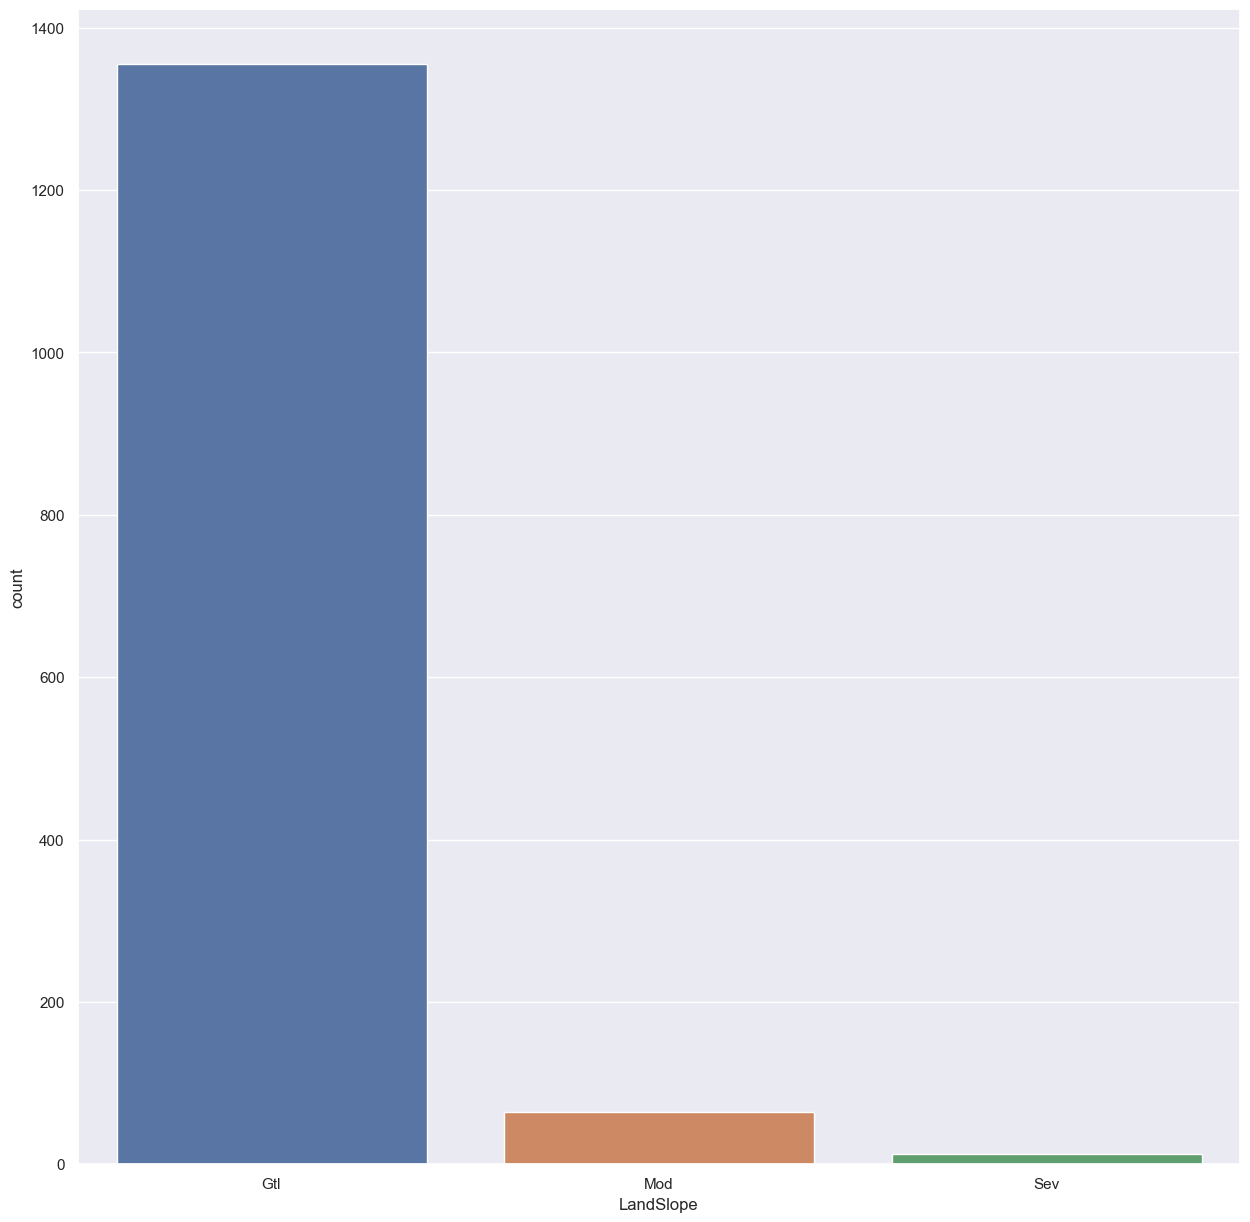

-------------------------------------------------------
            Condition1  Ratio
Condition1                   
Norm              1234 86.173
Feedr               81  5.656
Artery              47  3.282
RRAn                25  1.746
PosN                19  1.327
RRAe                11  0.768
PosA                 8  0.559
RRNn                 5  0.349
RRNe                 2  0.140


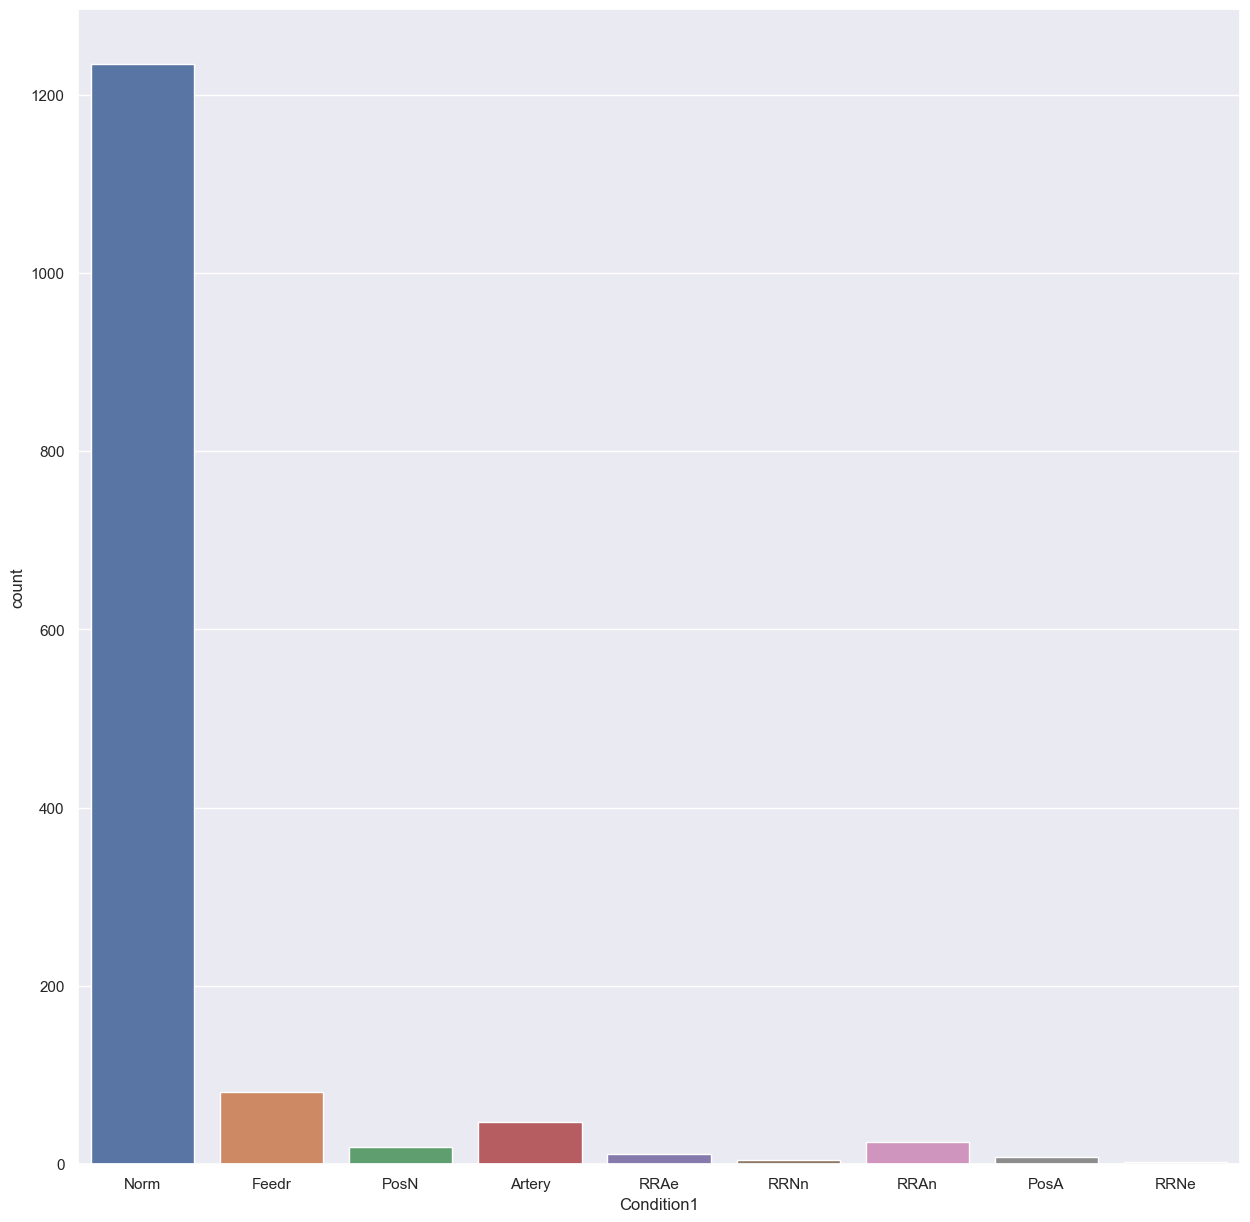

-------------------------------------------------------
            Condition2  Ratio
Condition2                   
Norm              1417 98.953
Feedr                6  0.419
Artery               2  0.140
RRNn                 2  0.140
PosN                 2  0.140
PosA                 1  0.070
RRAn                 1  0.070
RRAe                 1  0.070


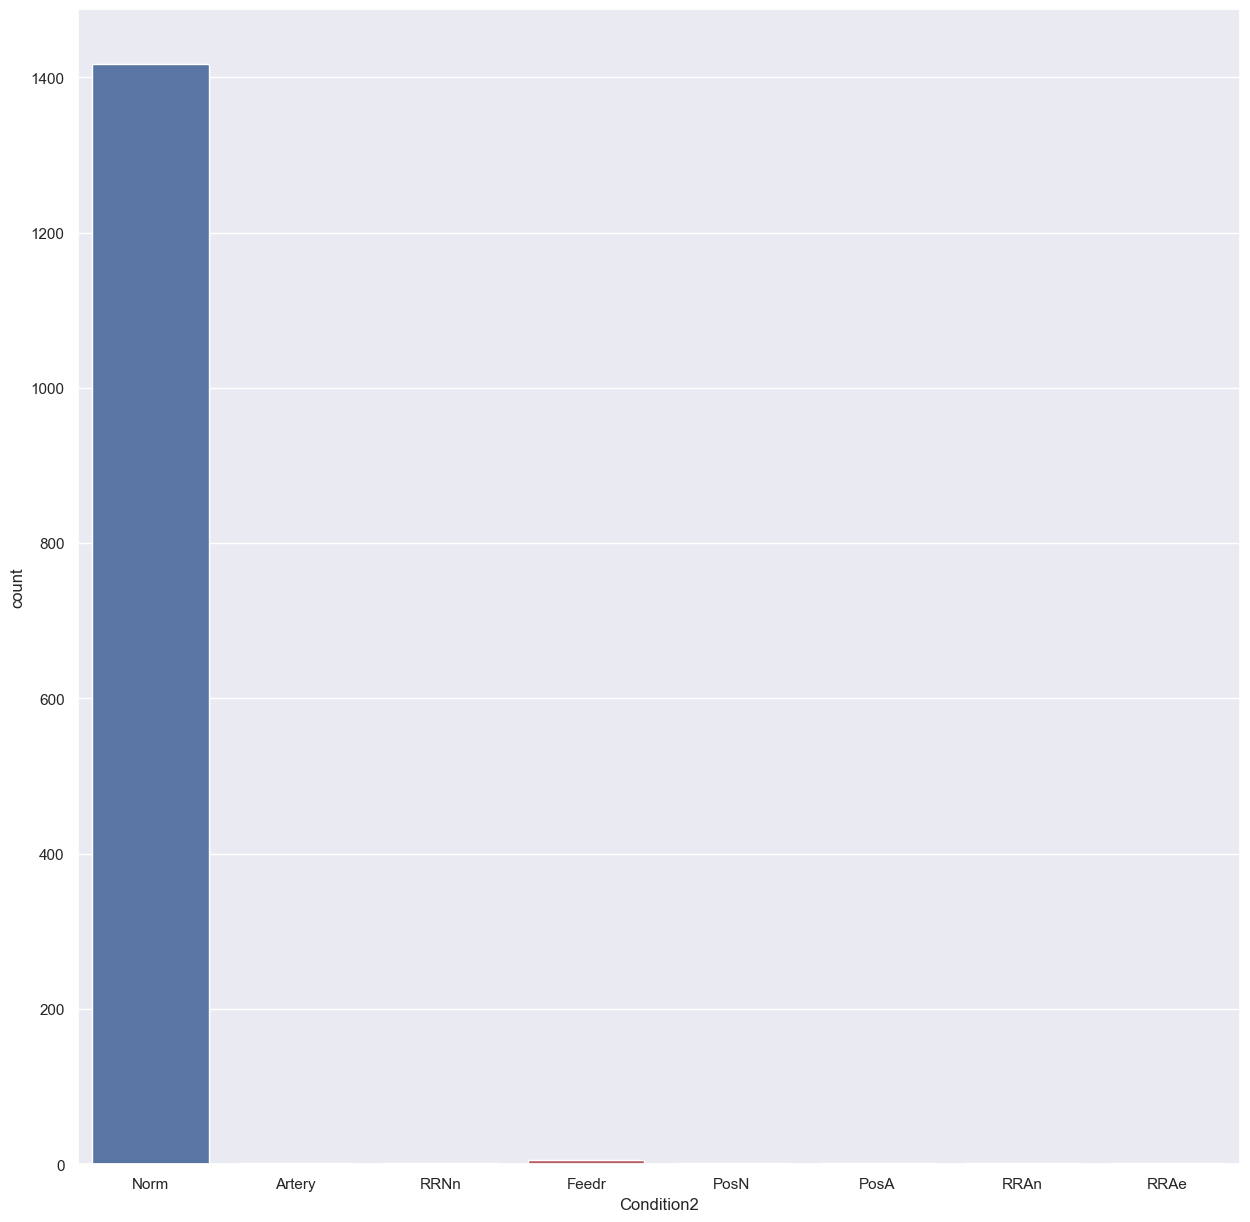

-------------------------------------------------------
          BldgType  Ratio
BldgType                 
1Fam          1192 83.240
TwnhsE         114  7.961
Duplex          52  3.631
Twnhs           43  3.003
2fmCon          31  2.165


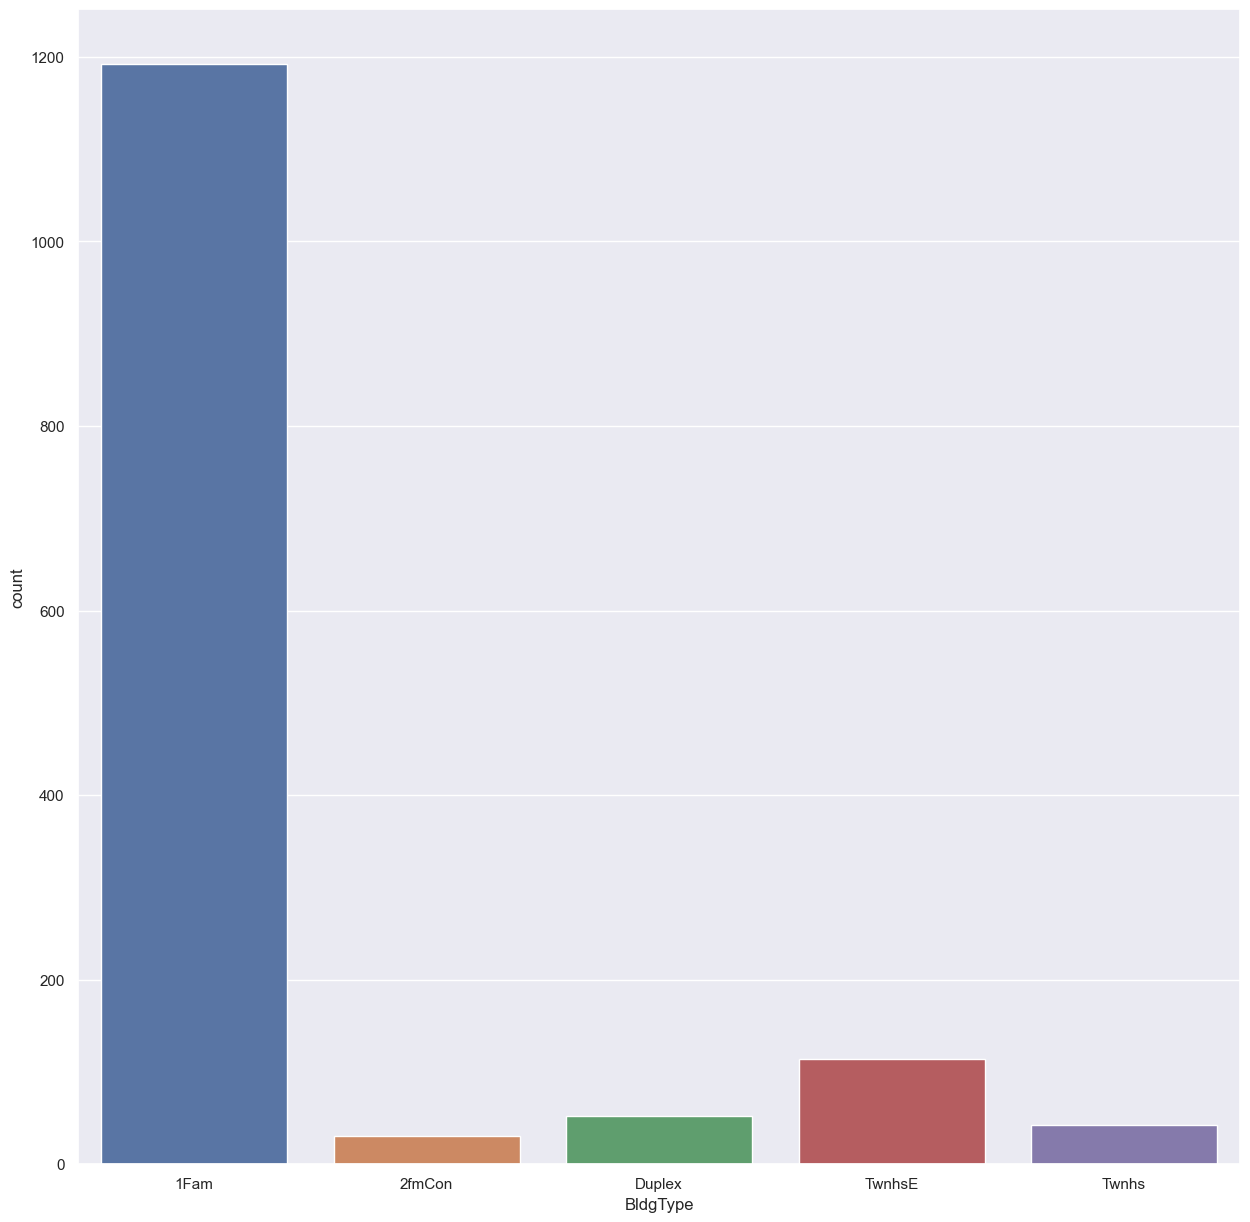

-------------------------------------------------------
            HouseStyle  Ratio
HouseStyle                   
1Story             716 50.000
2Story             429 29.958
1.5Fin             153 10.684
SLvl                65  4.539
SFoyer              37  2.584
1.5Unf              14  0.978
2.5Unf              11  0.768
2.5Fin               7  0.489


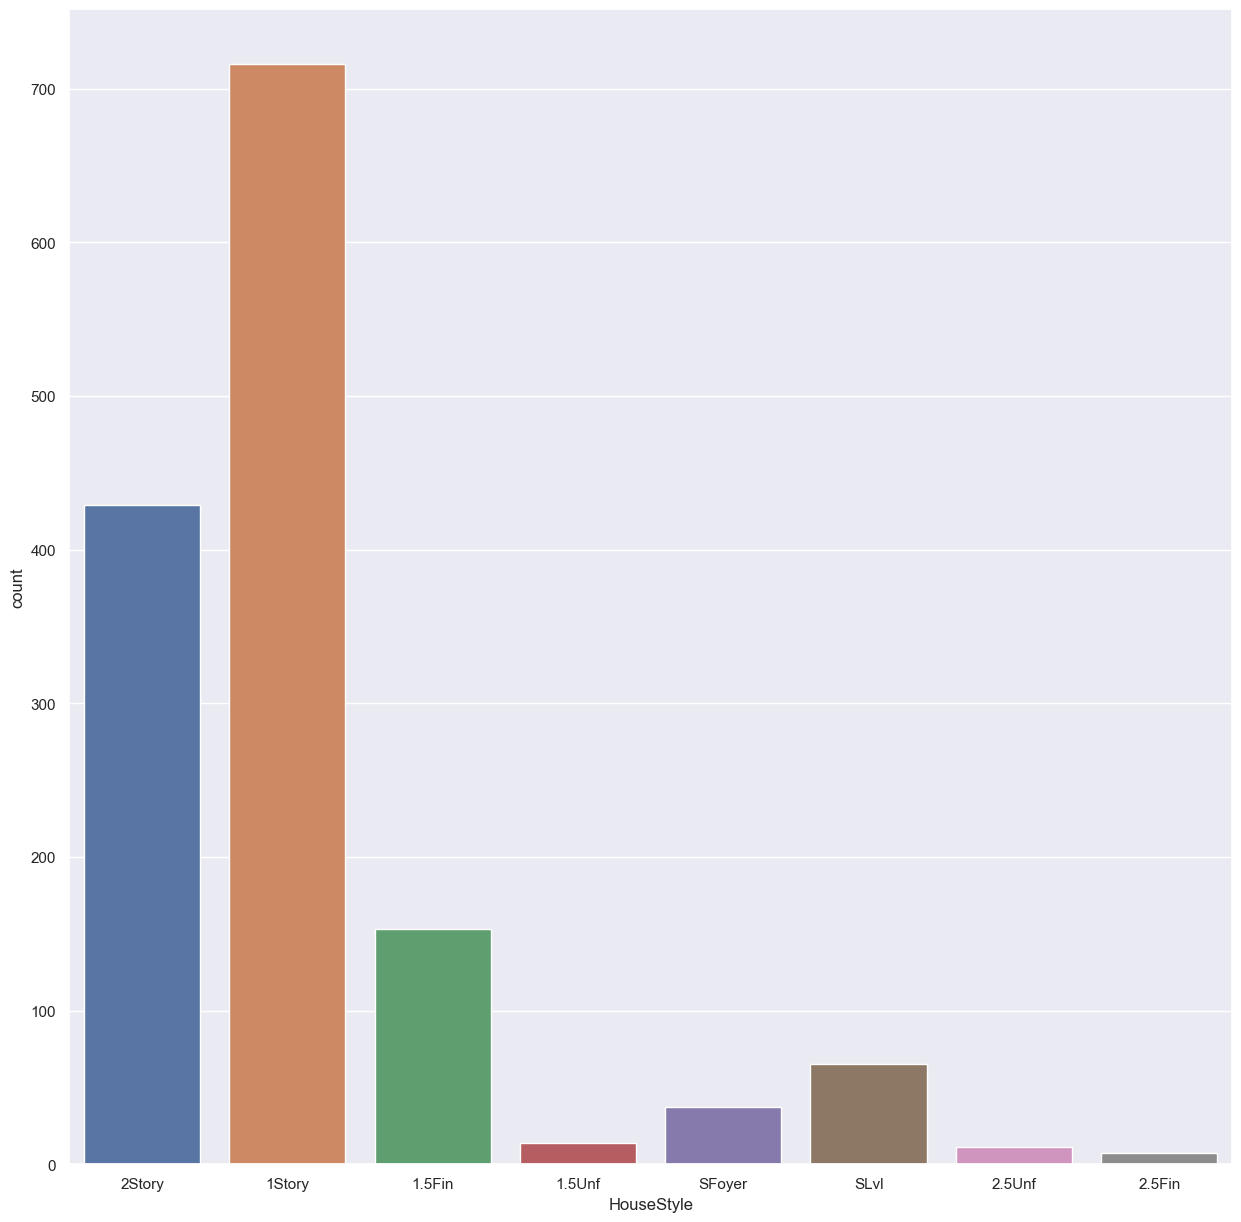

-------------------------------------------------------
           RoofStyle  Ratio
RoofStyle                  
Gable           1131 78.980
Hip              268 18.715
Flat              13  0.908
Gambrel           11  0.768
Mansard            7  0.489
Shed               2  0.140


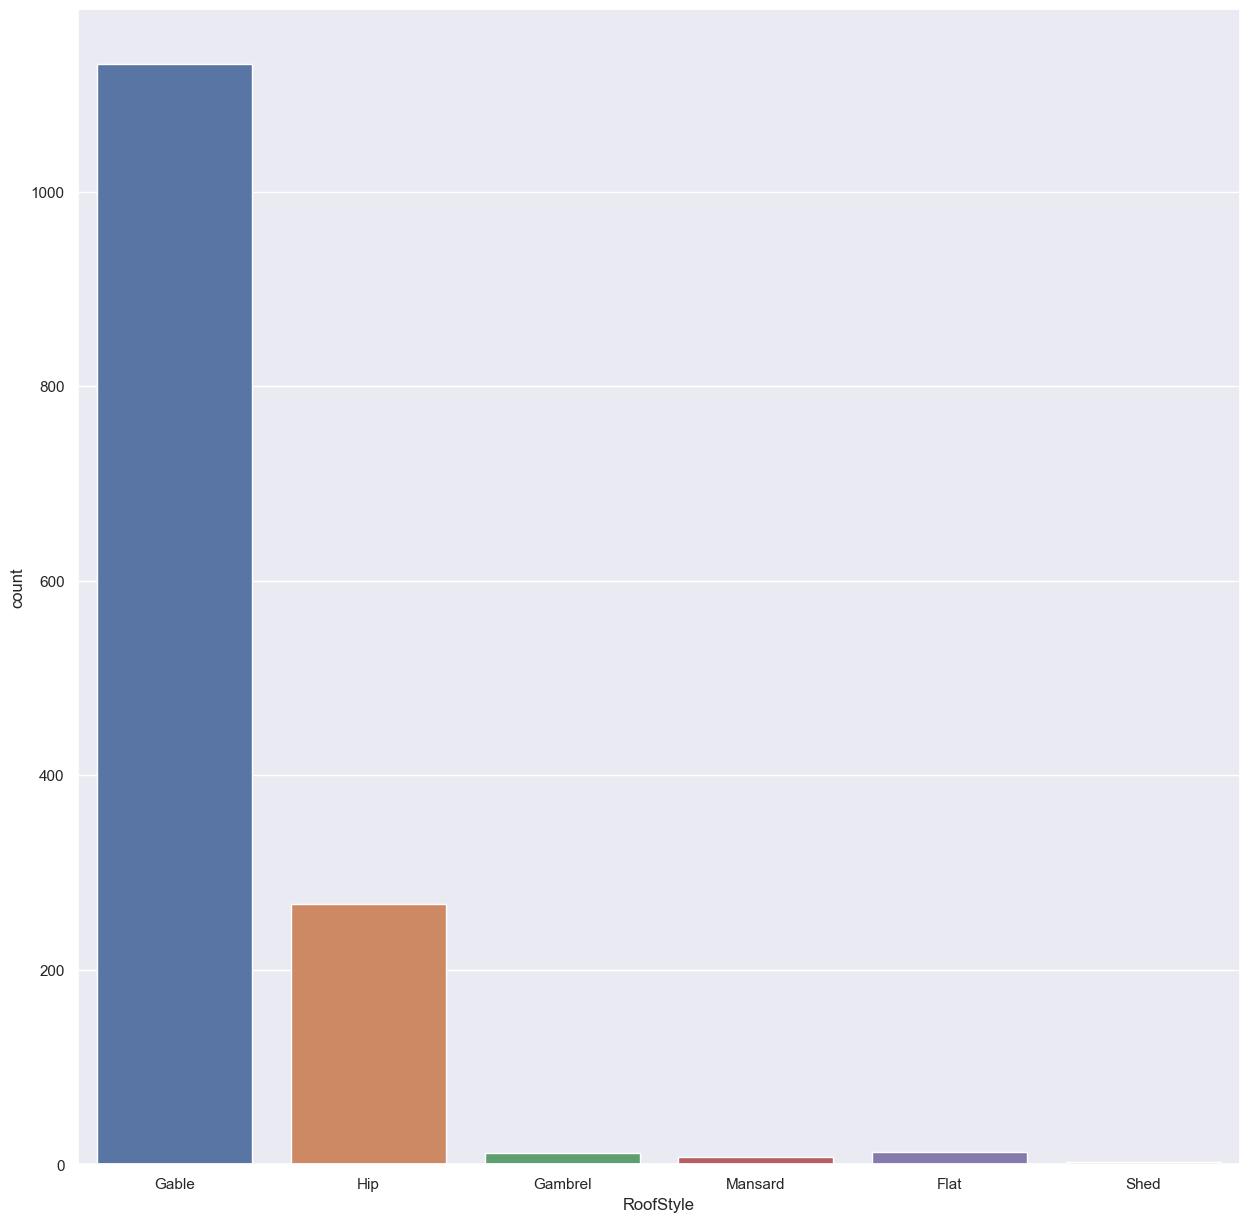

-------------------------------------------------------
          RoofMatl  Ratio
RoofMatl                 
CompShg       1408 98.324
Tar&Grv         11  0.768
WdShake          5  0.349
WdShngl          4  0.279
Metal            1  0.070
Membran          1  0.070
Roll             1  0.070
ClyTile          1  0.070


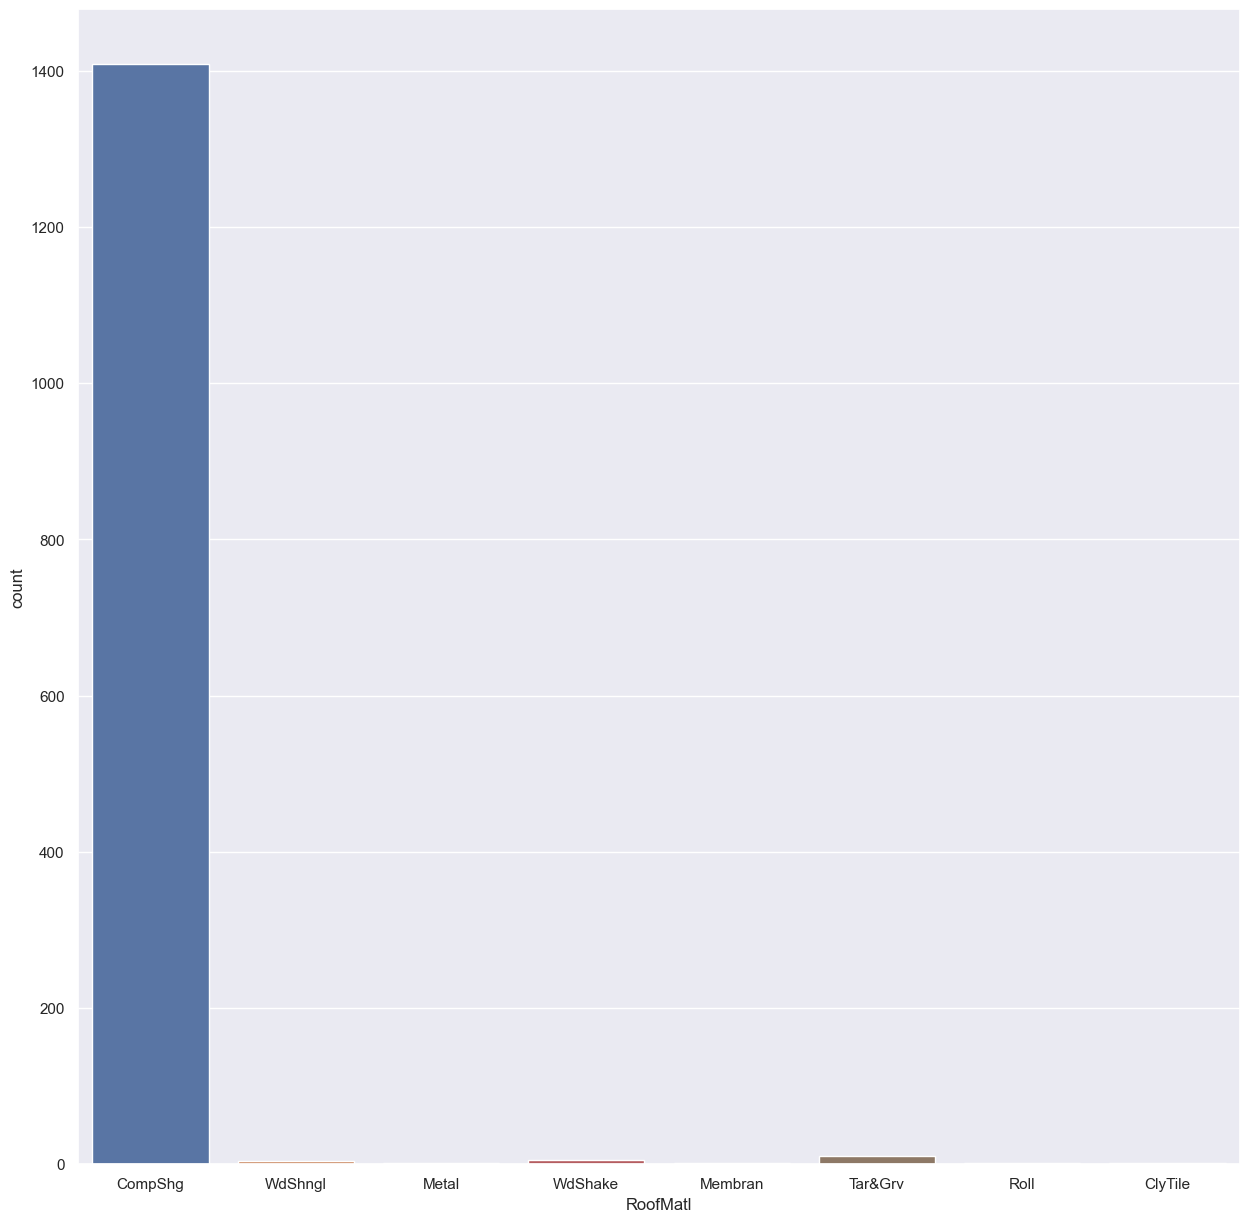

-------------------------------------------------------
             Exterior1st  Ratio
Exterior1st                    
VinylSd              498 34.777
MetalSd              220 15.363
HdBoard              220 15.363
Wd Sdng              204 14.246
Plywood              108  7.542
CemntBd               55  3.841
BrkFace               49  3.422
WdShing               26  1.816
Stucco                25  1.746
AsbShng               20  1.397
BrkComm                2  0.140
Stone                  2  0.140
AsphShn                1  0.070
ImStucc                1  0.070
CBlock                 1  0.070


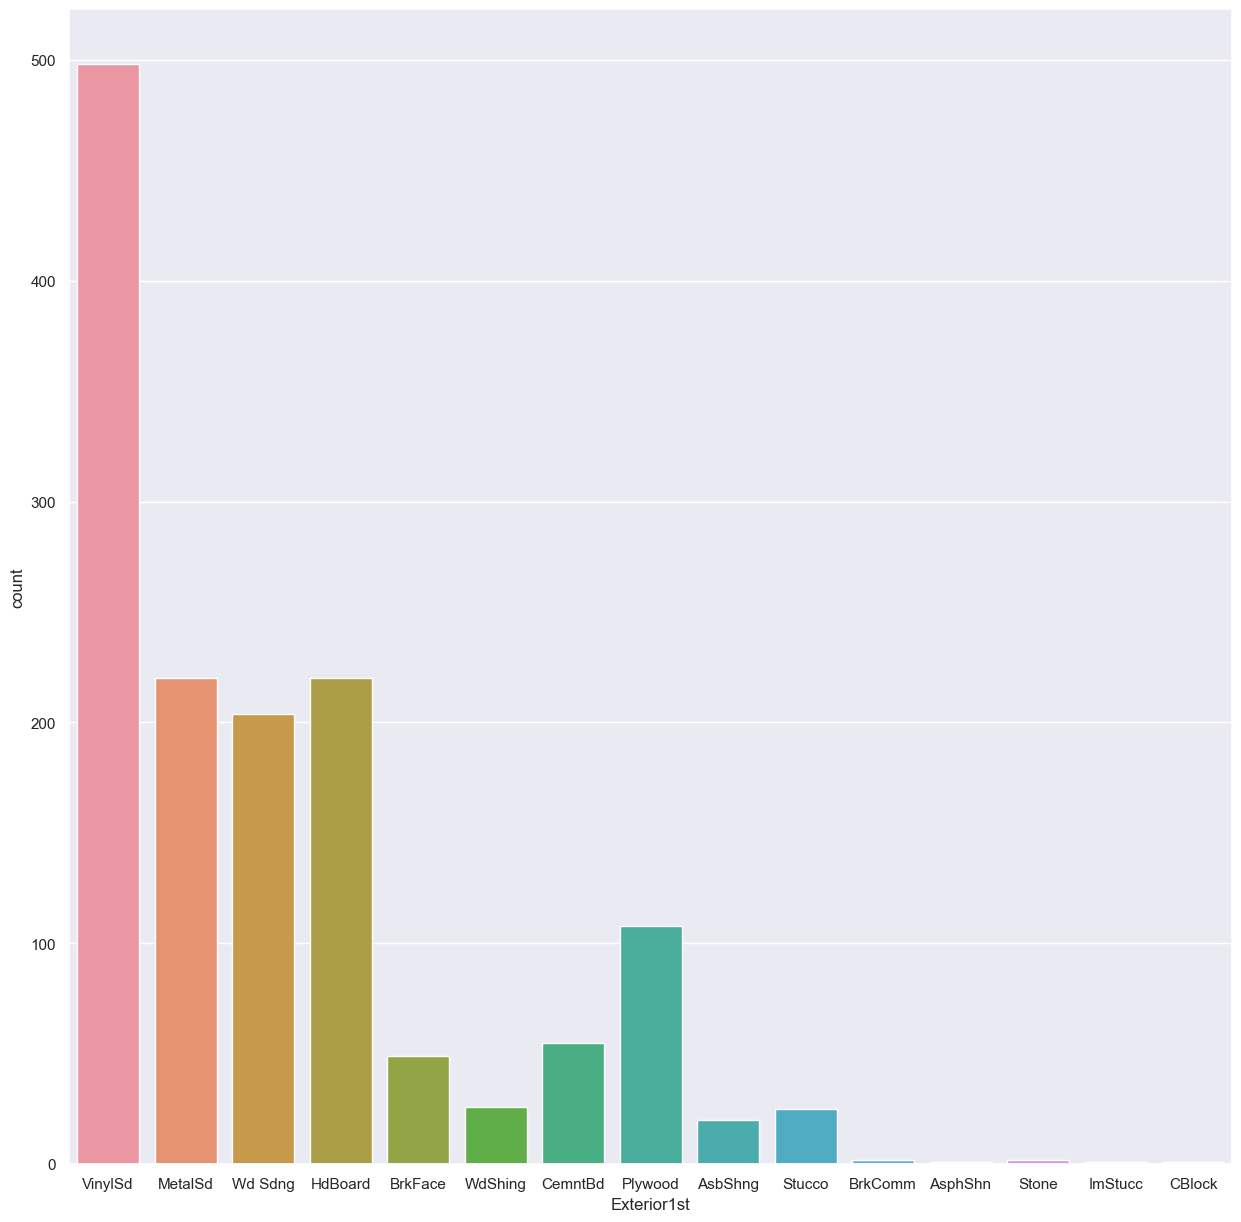

-------------------------------------------------------
             Exterior2nd  Ratio
Exterior2nd                    
VinylSd              487 34.008
MetalSd              214 14.944
HdBoard              205 14.316
Wd Sdng              196 13.687
Plywood              142  9.916
CmentBd               55  3.841
Wd Shng               37  2.584
Stucco                26  1.816
BrkFace               24  1.676
AsbShng               20  1.397
ImStucc                9  0.628
Brk Cmn                7  0.489
Stone                  5  0.349
AsphShn                3  0.209
Other                  1  0.070
CBlock                 1  0.070


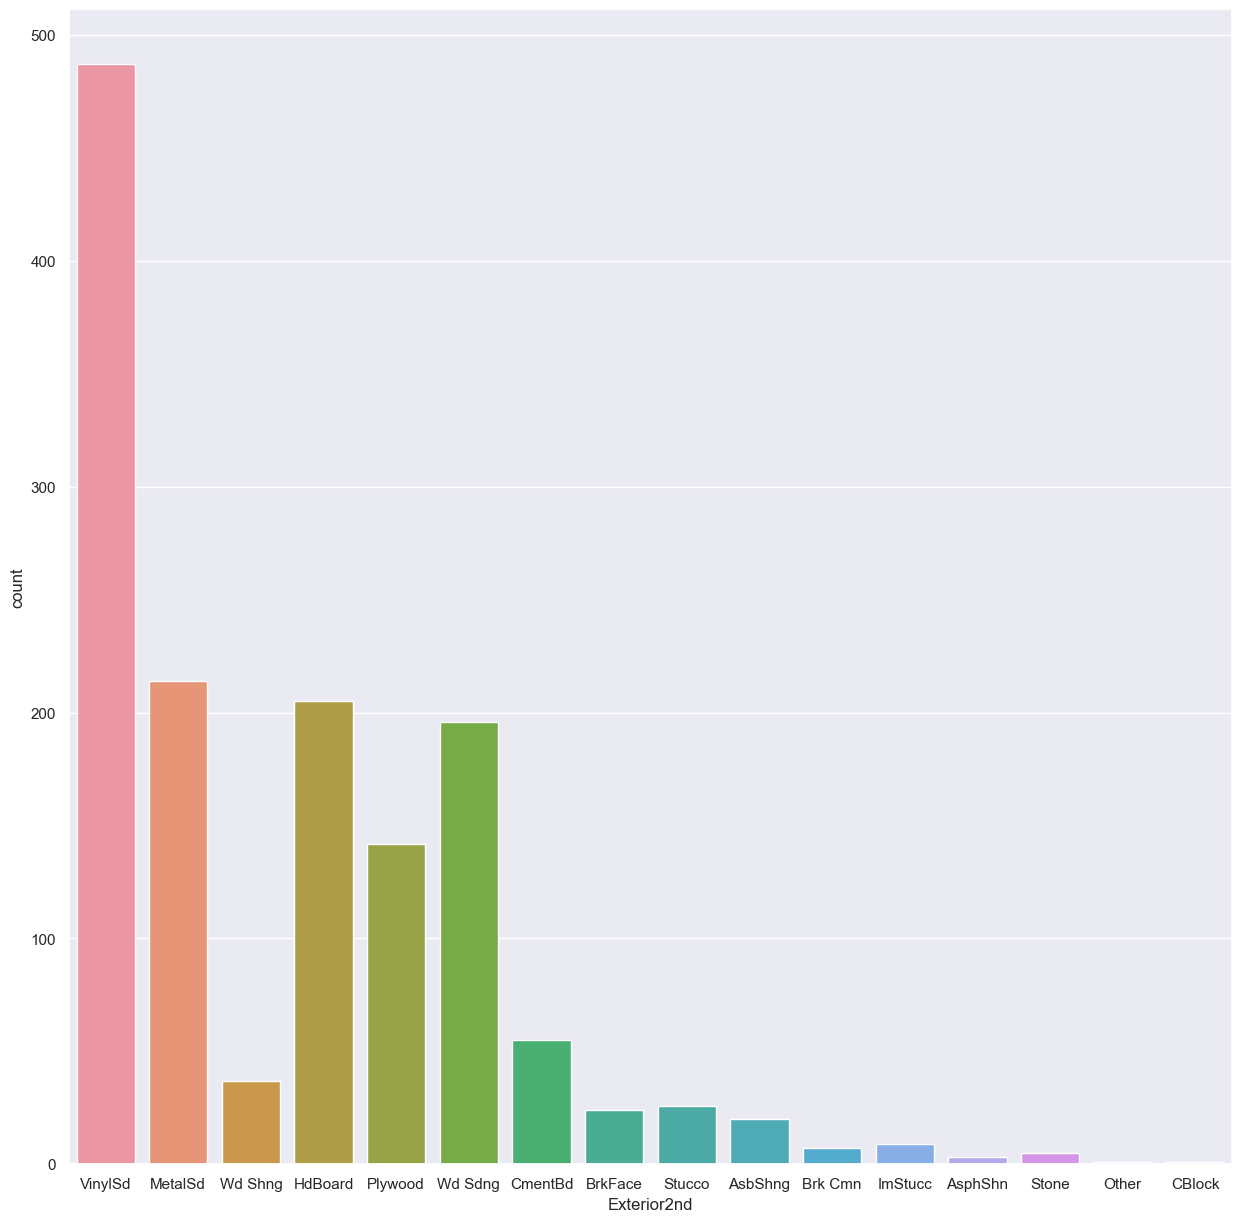

-------------------------------------------------------
            MasVnrType  Ratio
MasVnrType                   
BrkFace            432 30.168
Stone              118  8.240
BrkCmn              15  1.047


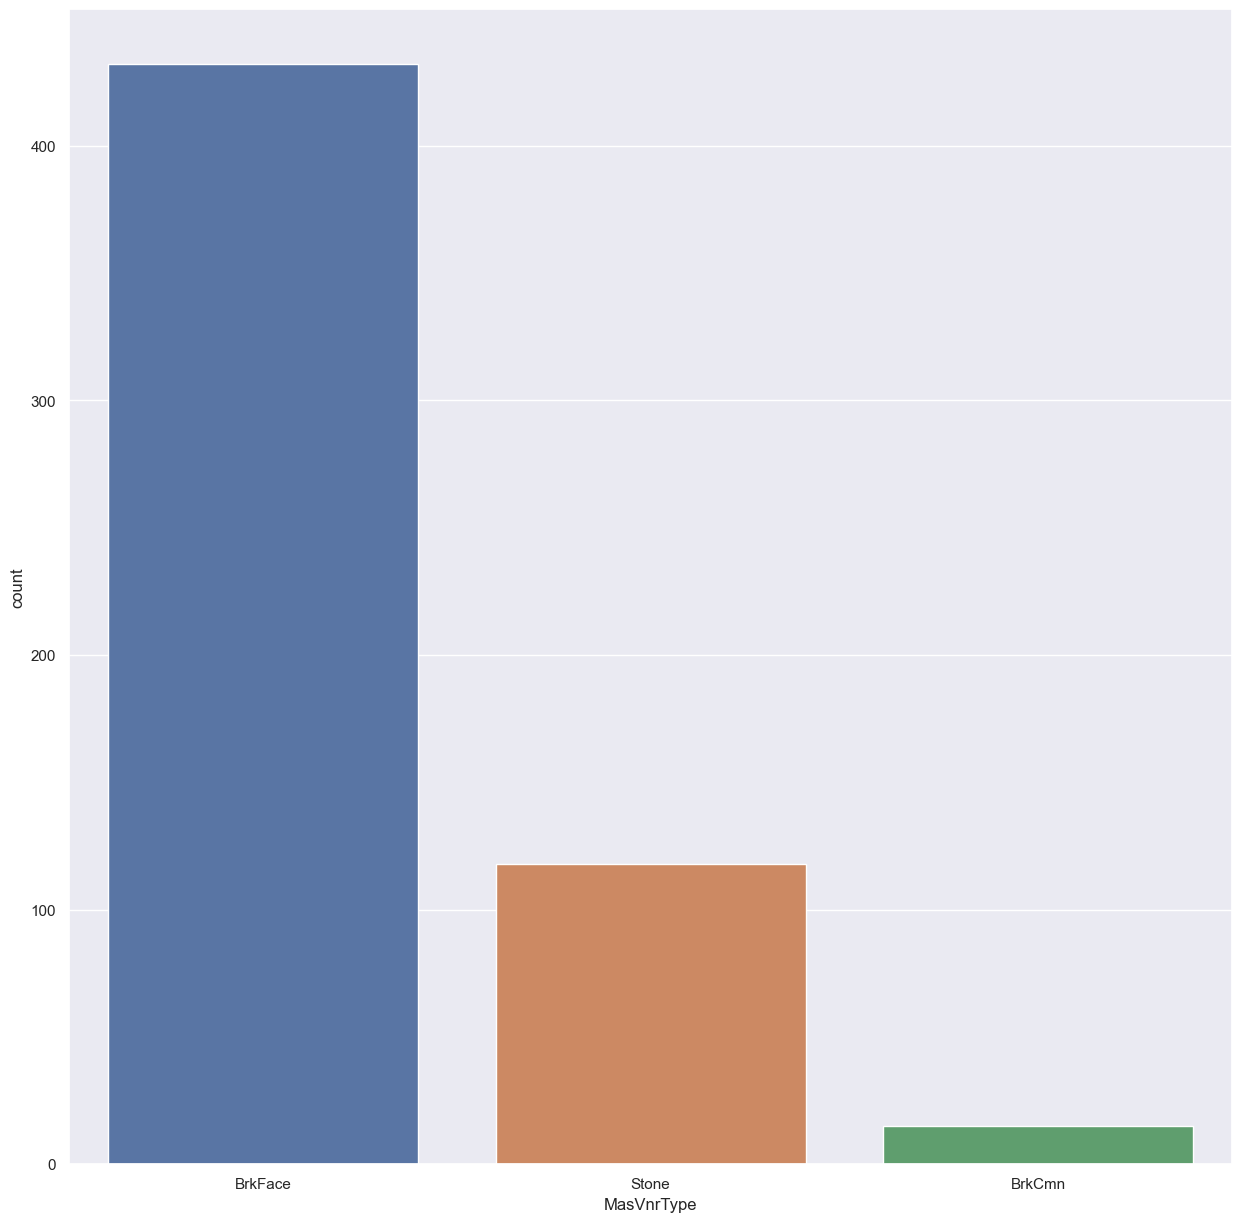

-------------------------------------------------------
           ExterQual  Ratio
ExterQual                  
TA               906 63.268
Gd               476 33.240
Ex                36  2.514
Fa                14  0.978


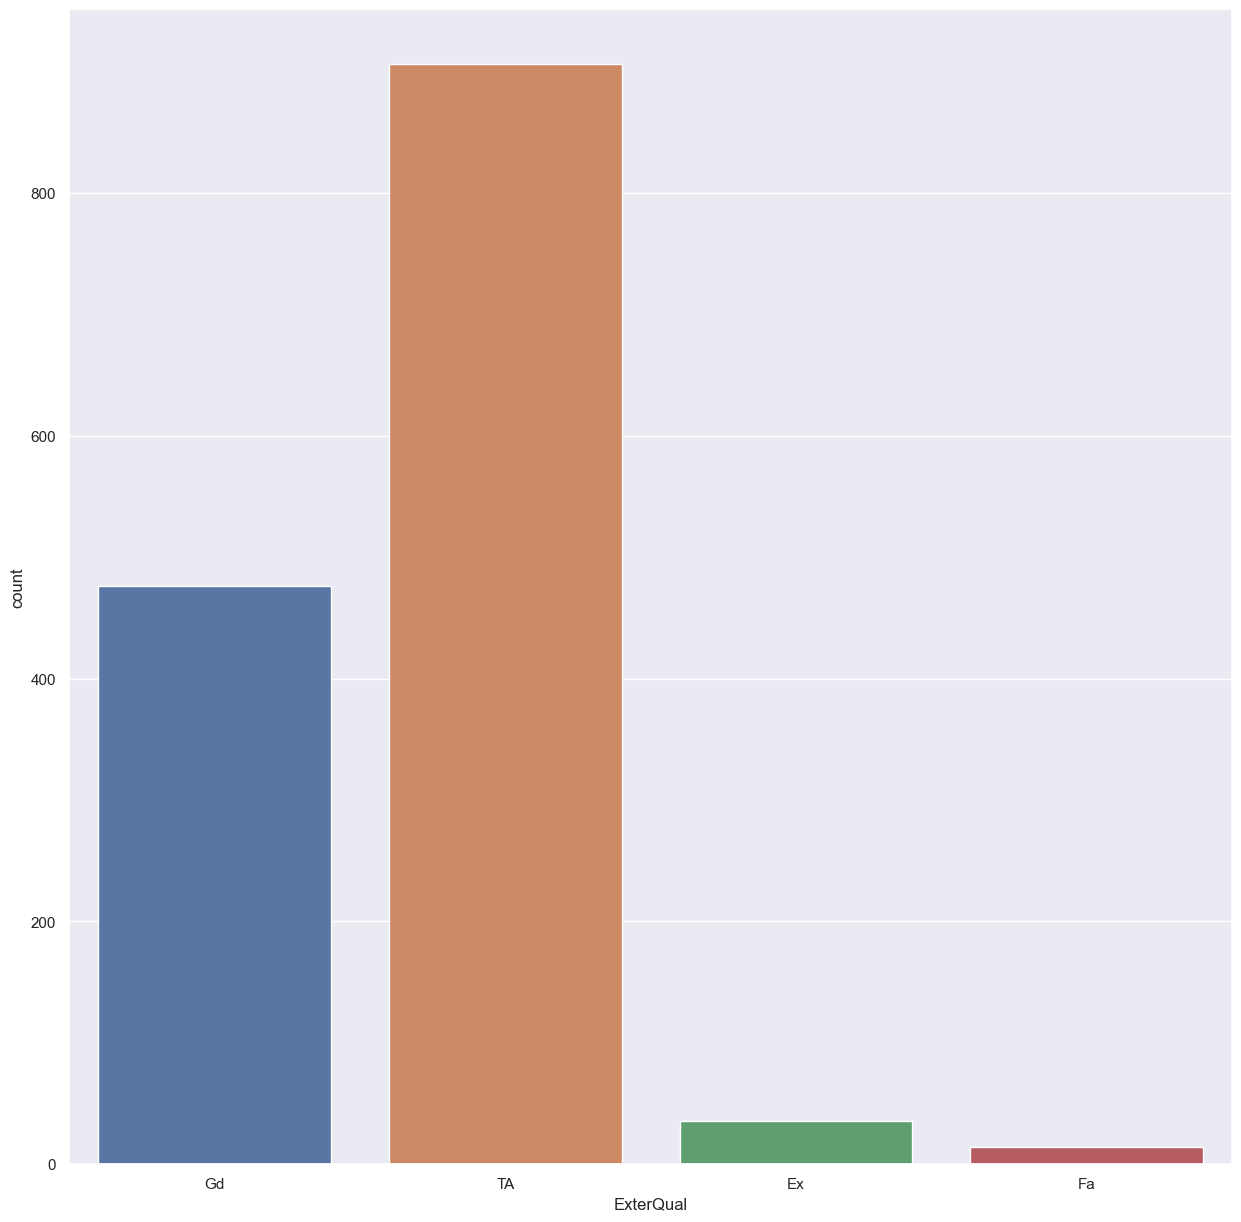

-------------------------------------------------------
           ExterCond  Ratio
ExterCond                  
TA              1256 87.709
Gd               144 10.056
Fa                28  1.955
Ex                 3  0.209
Po                 1  0.070


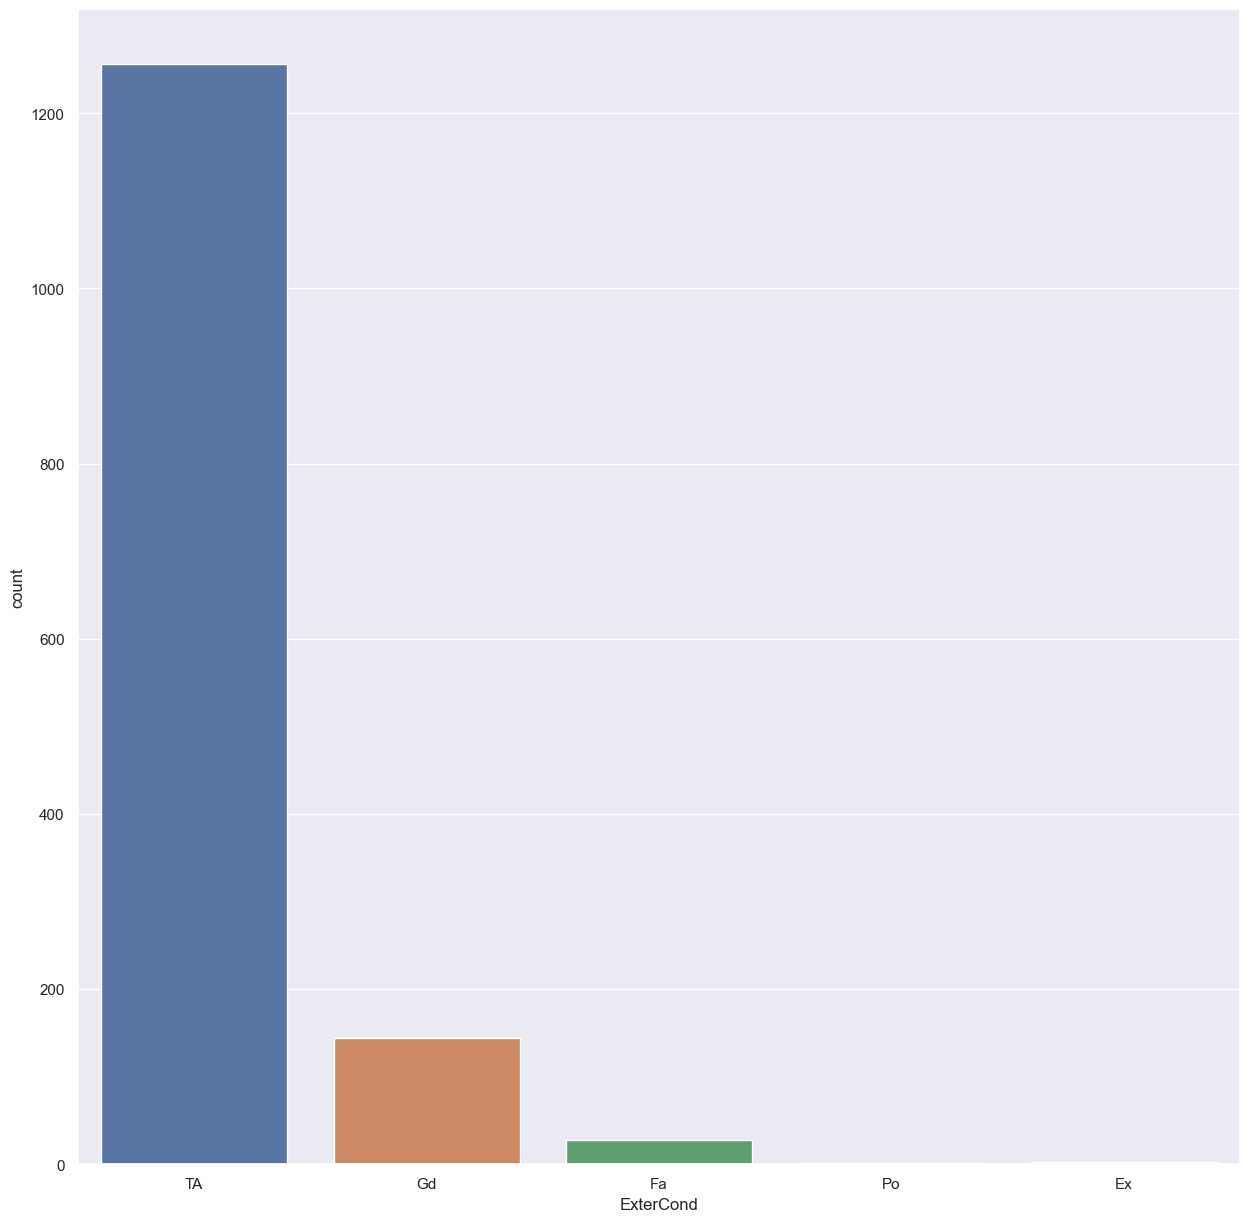

-------------------------------------------------------
            Foundation  Ratio
Foundation                   
CBlock             633 44.204
PConc              621 43.366
BrkTil             145 10.126
Slab                24  1.676
Stone                6  0.419
Wood                 3  0.209


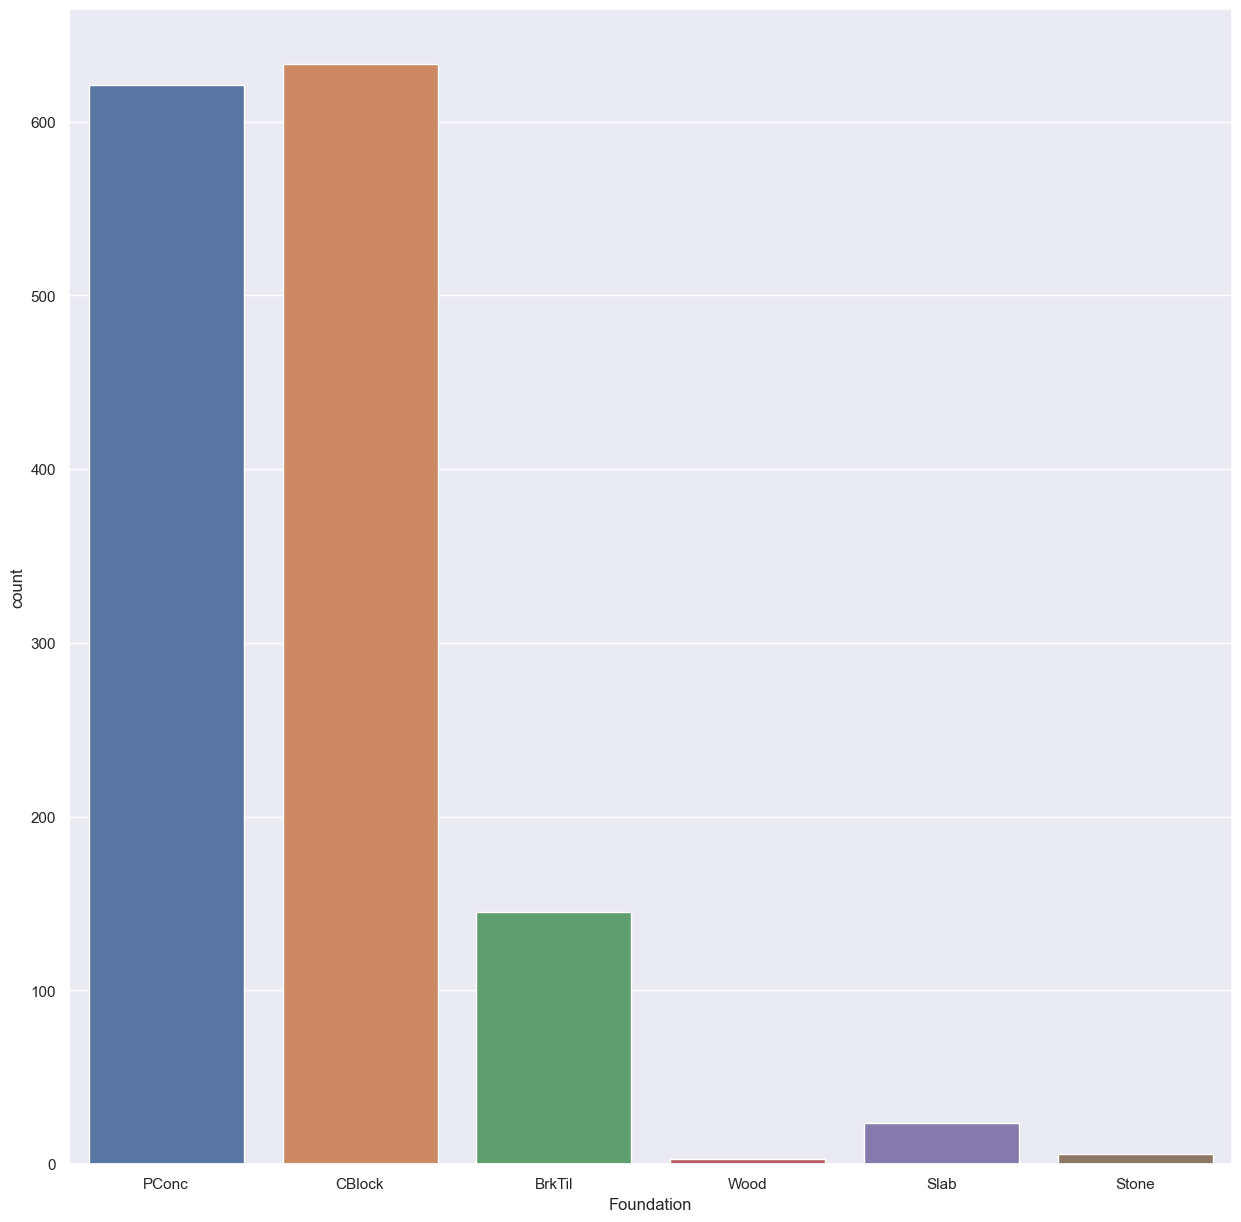

-------------------------------------------------------
          BsmtQual  Ratio
BsmtQual                 
TA             648 45.251
Gd             613 42.807
Ex              99  6.913
Fa              35  2.444


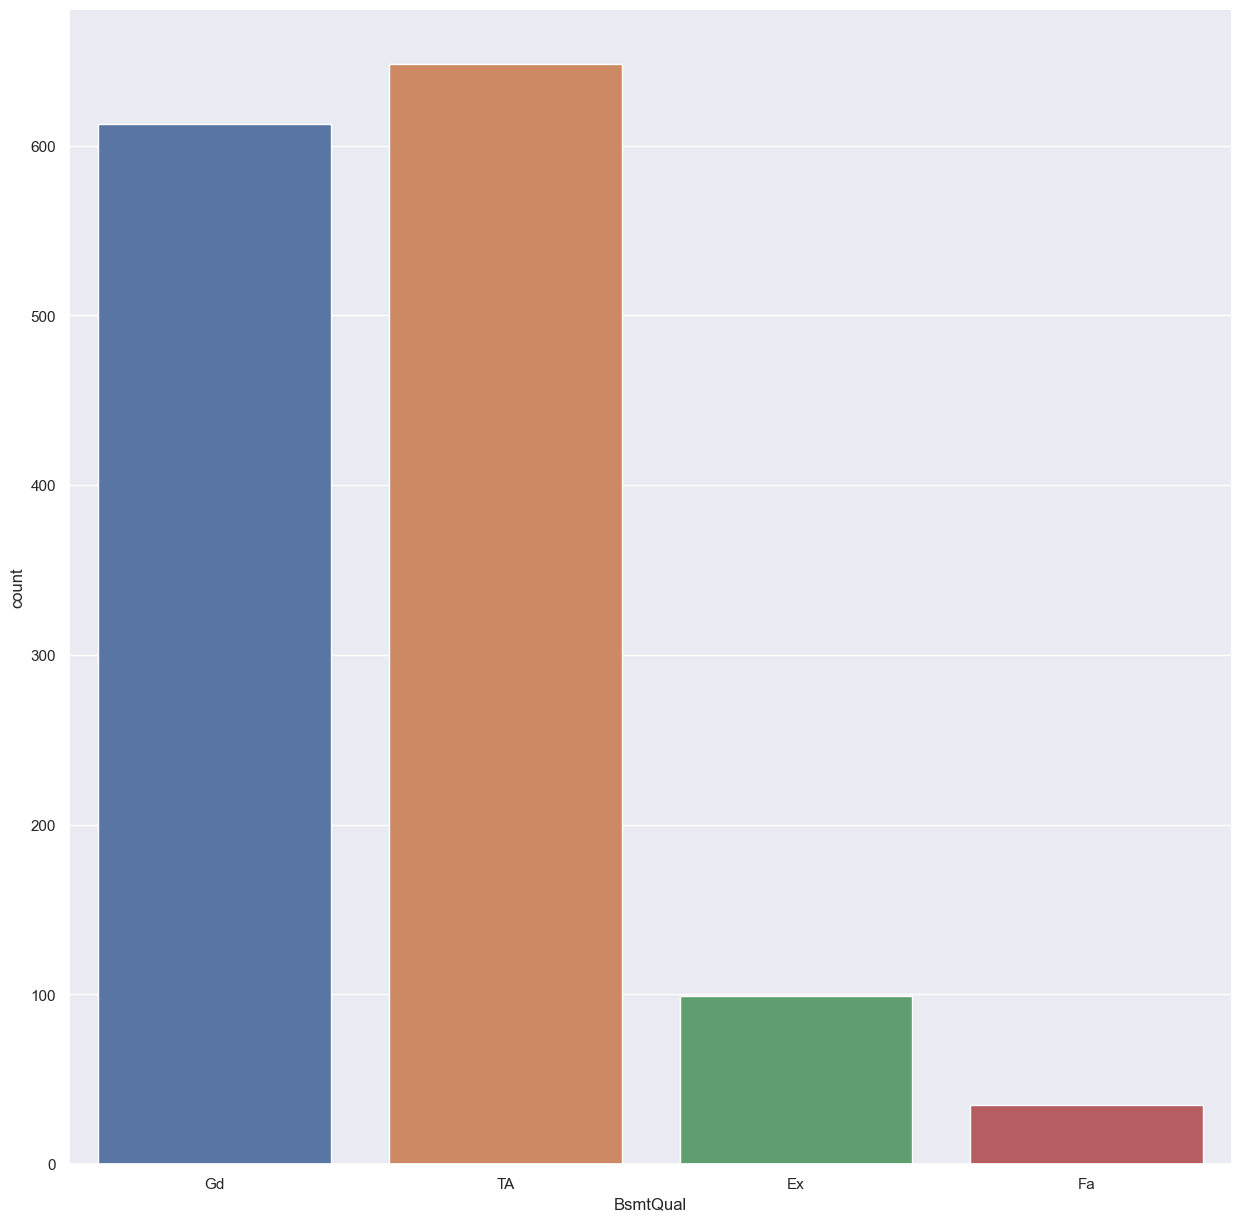

-------------------------------------------------------
          BsmtCond  Ratio
BsmtCond                 
TA            1285 89.735
Gd              63  4.399
Fa              45  3.142
Po               2  0.140


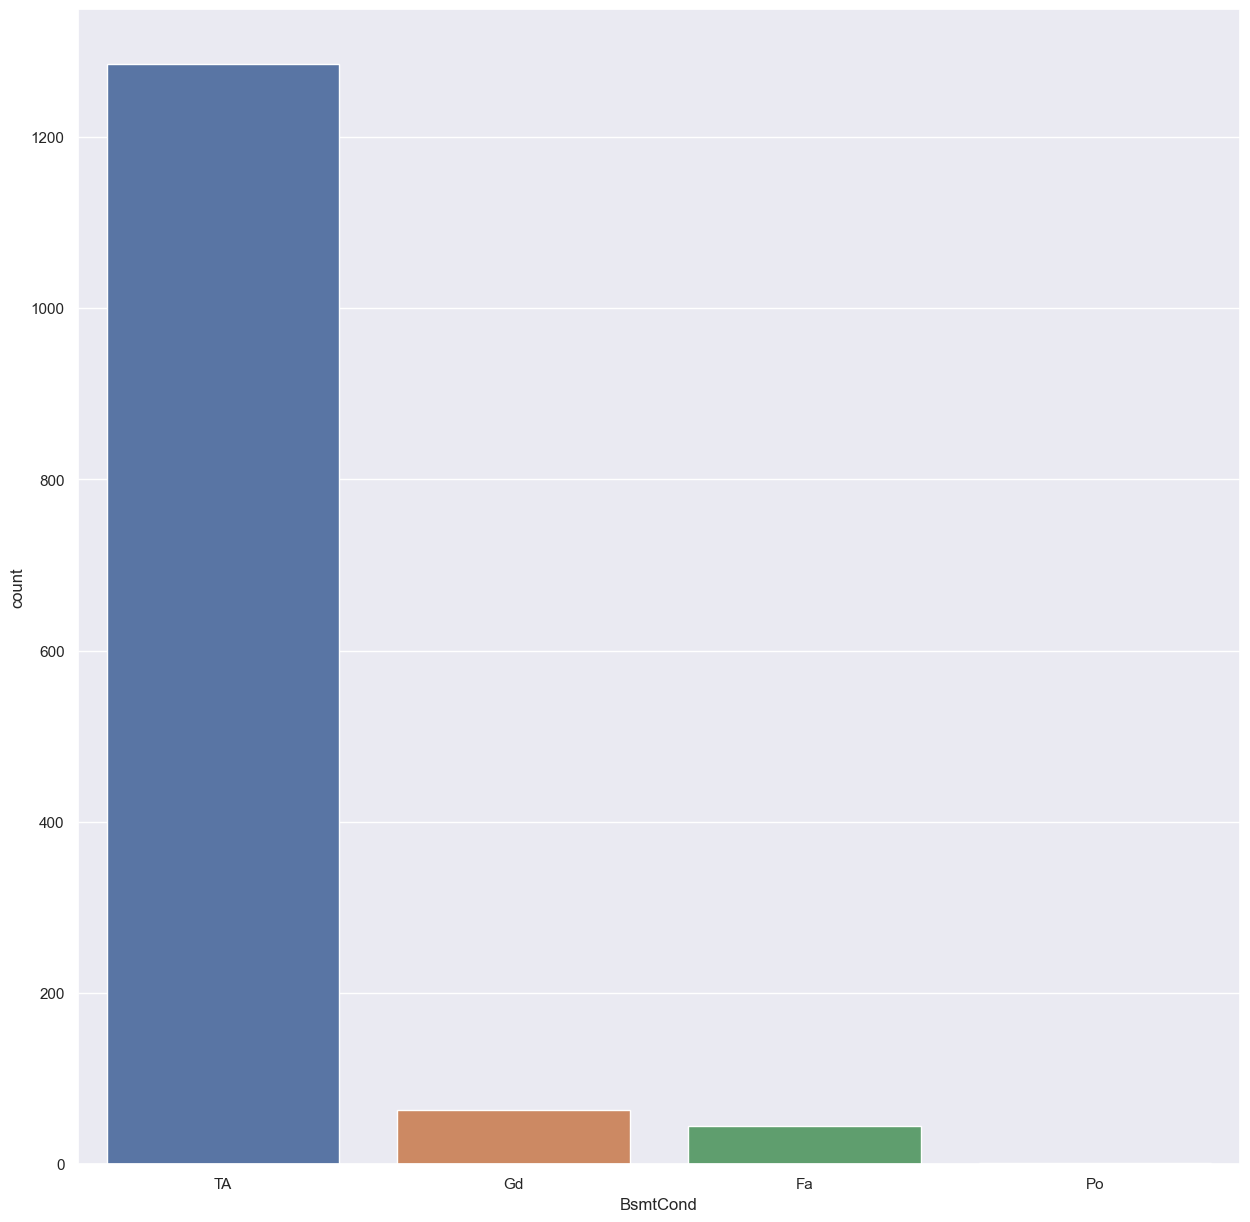

-------------------------------------------------------
              BsmtExposure  Ratio
BsmtExposure                     
No                     946 66.061
Av                     215 15.014
Gd                     121  8.450
Mn                     112  7.821


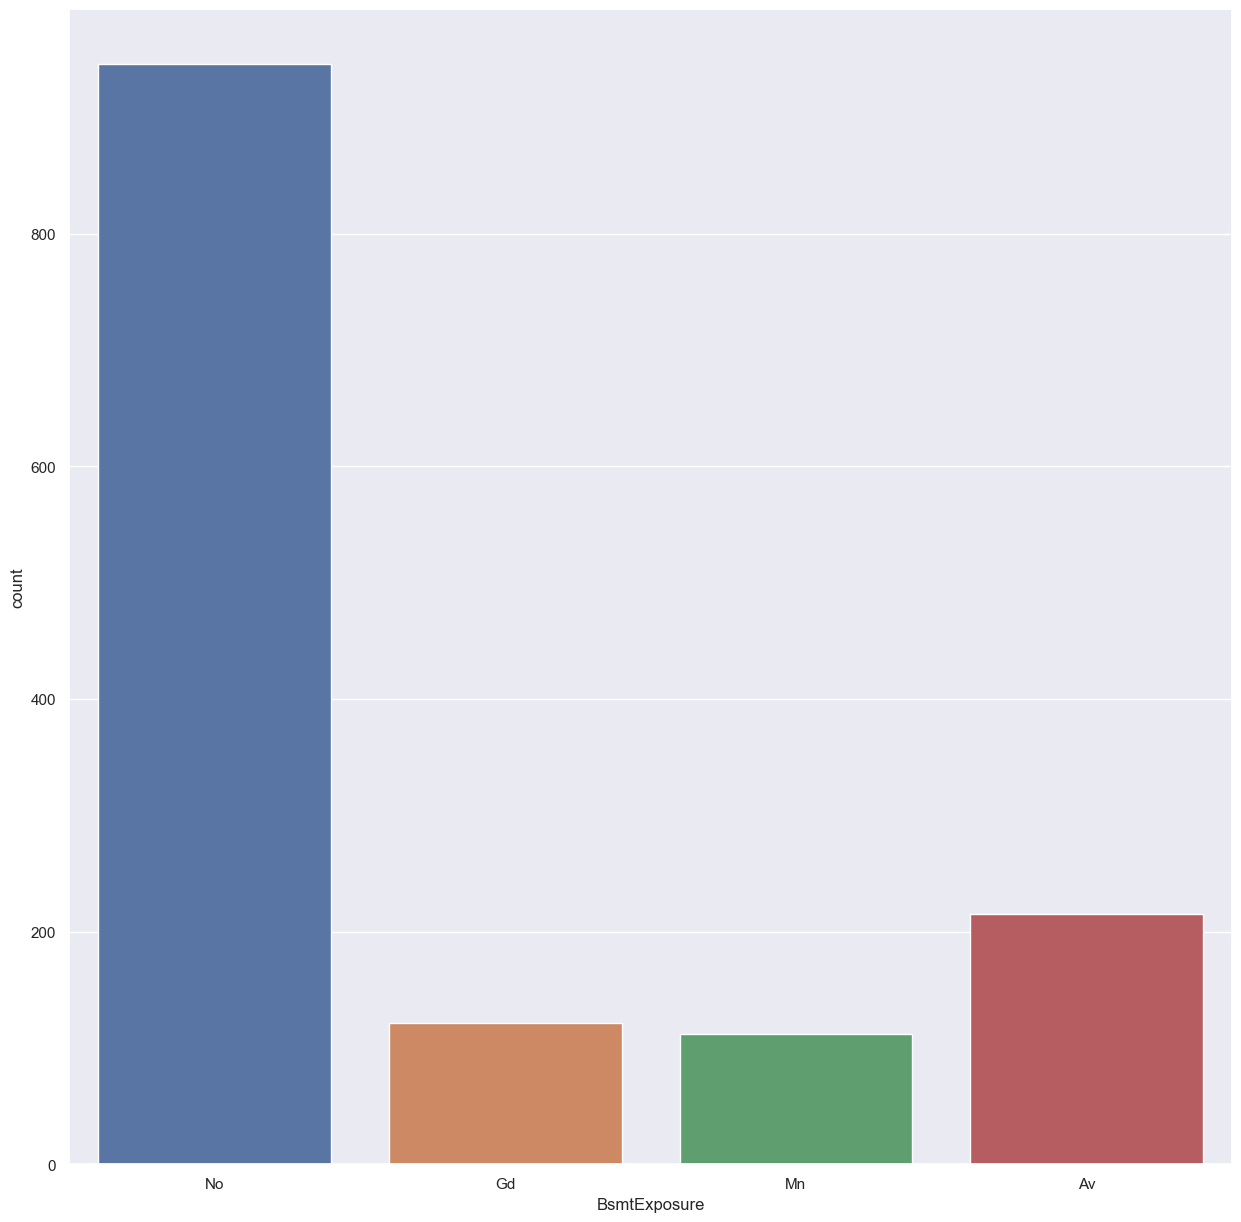

-------------------------------------------------------
              BsmtFinType1  Ratio
BsmtFinType1                     
Unf                    425 29.679
GLQ                    396 27.654
ALQ                    219 15.293
BLQ                    148 10.335
Rec                    133  9.288
LwQ                     74  5.168


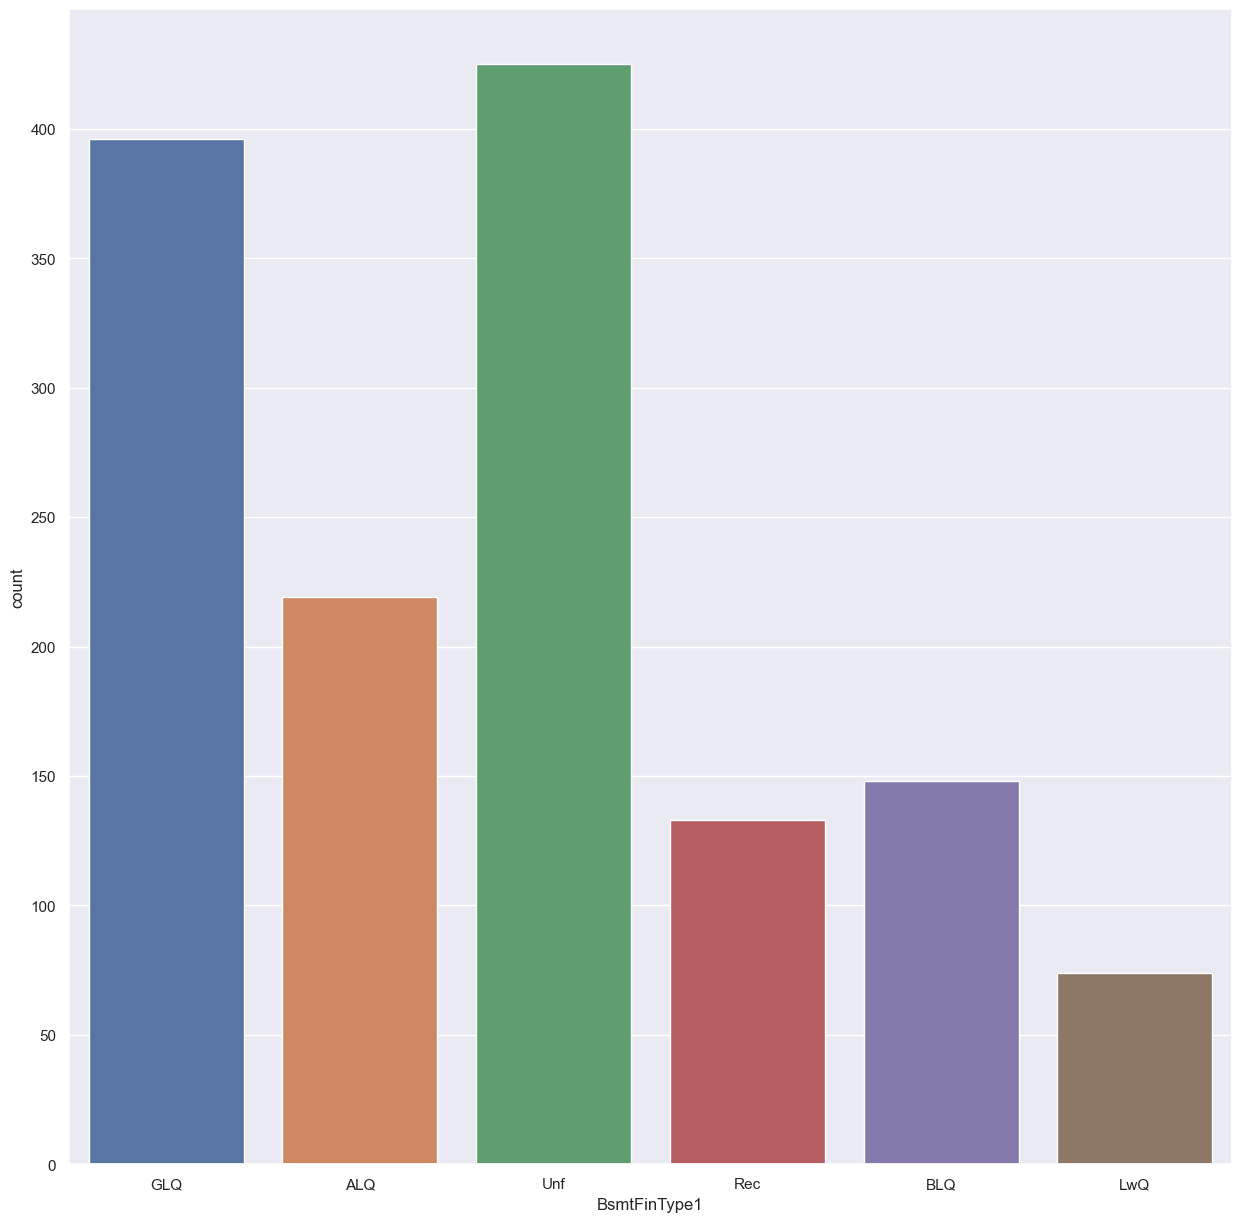

-------------------------------------------------------
              BsmtFinType2  Ratio
BsmtFinType2                     
Unf                   1230 85.894
Rec                     53  3.701
LwQ                     46  3.212
BLQ                     33  2.304
ALQ                     18  1.257
GLQ                     14  0.978


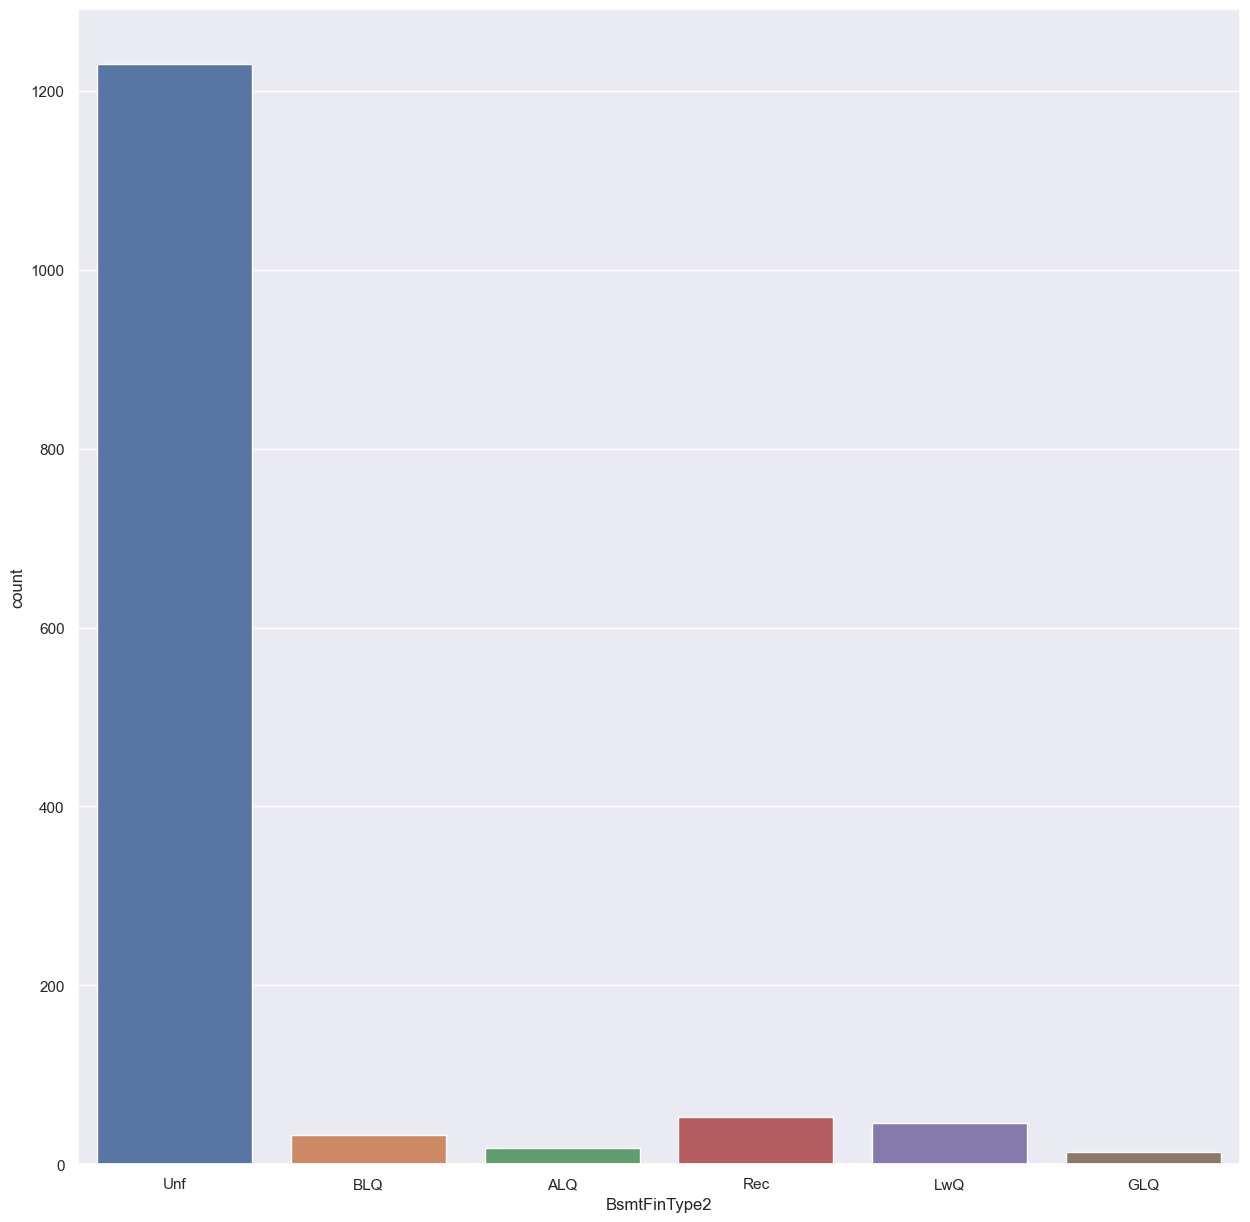

-------------------------------------------------------
         Heating  Ratio
Heating                
GasA        1400 97.765
GasW          18  1.257
Grav           7  0.489
Wall           4  0.279
OthW           2  0.140
Floor          1  0.070


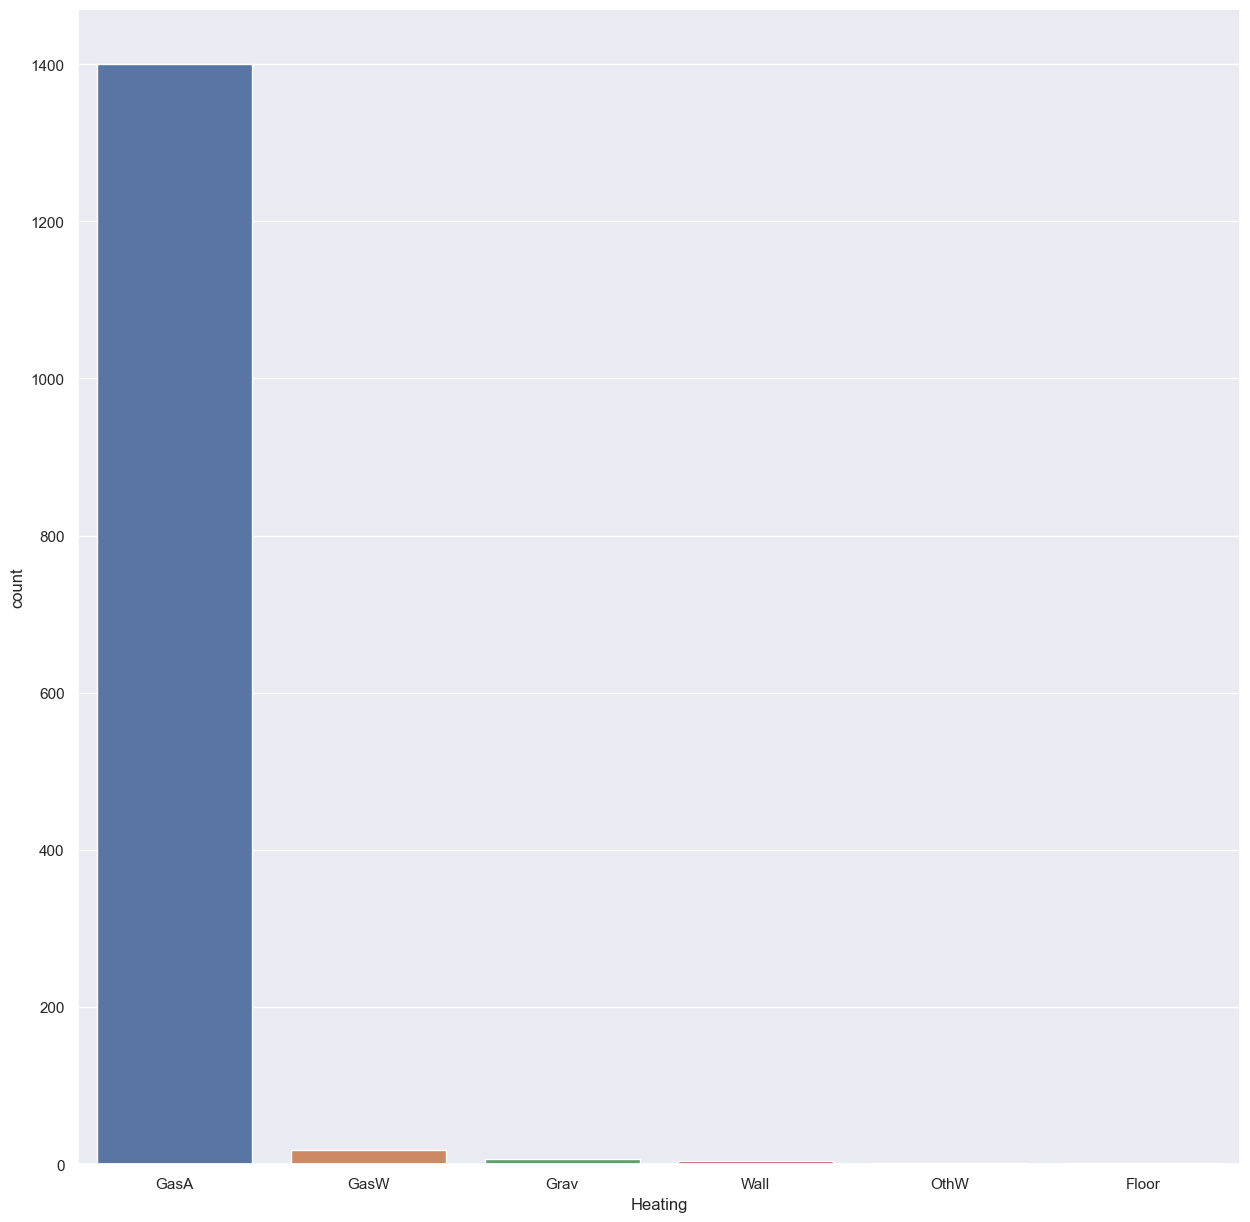

-------------------------------------------------------
           HeatingQC  Ratio
HeatingQC                  
Ex               713 49.791
TA               428 29.888
Gd               241 16.830
Fa                49  3.422
Po                 1  0.070


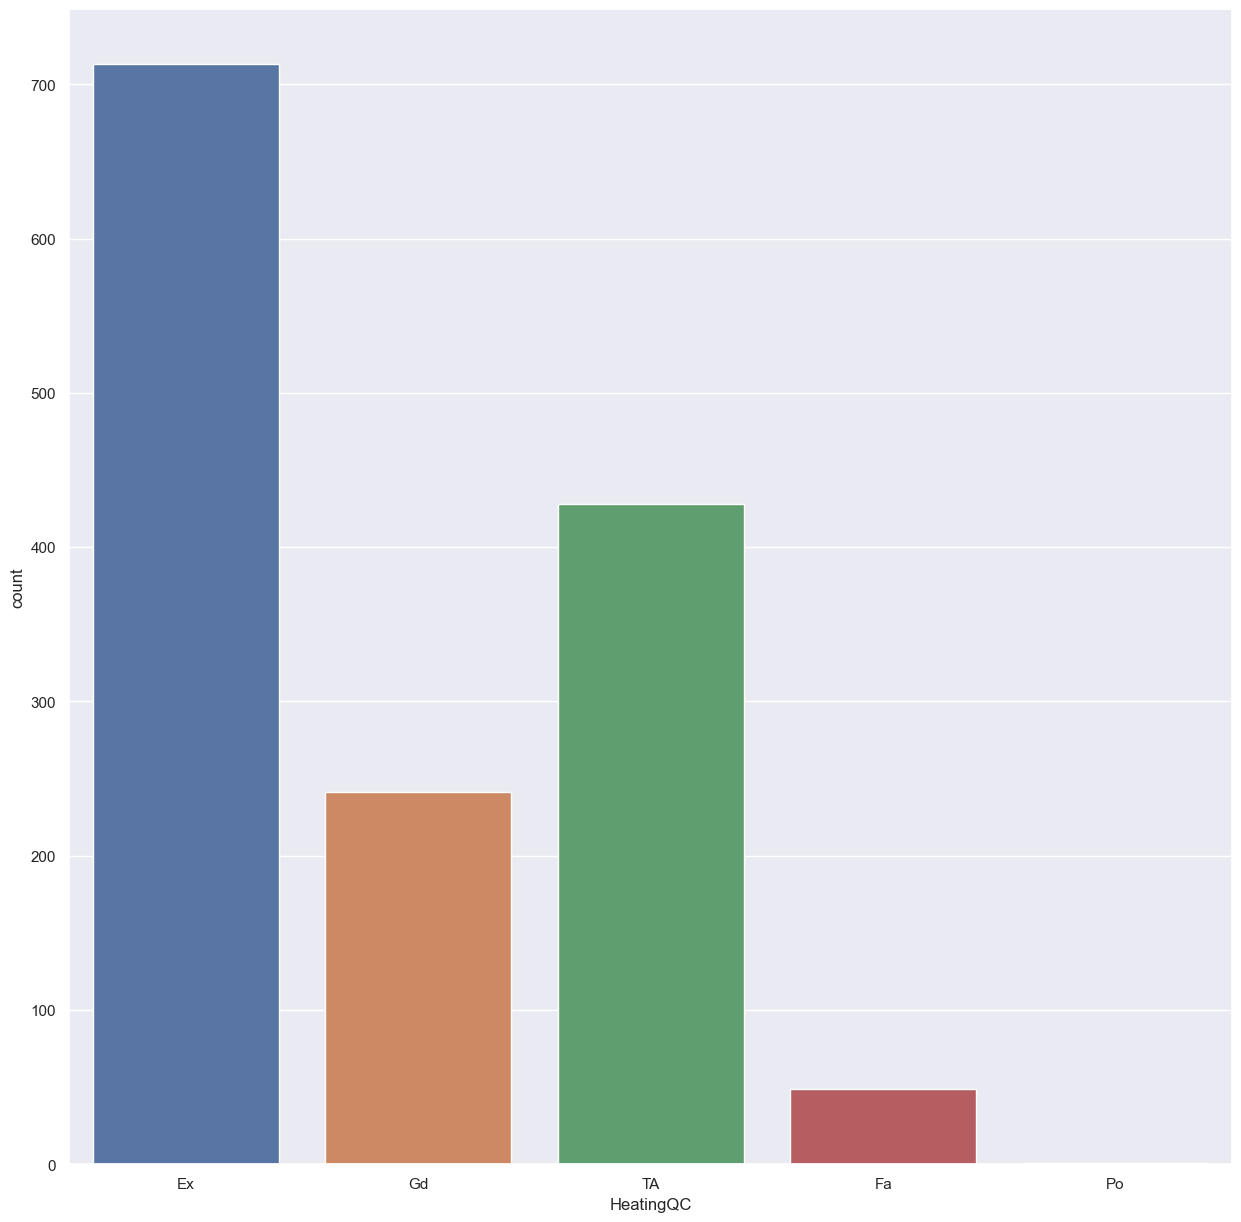

-------------------------------------------------------
            CentralAir  Ratio
CentralAir                   
Y                 1337 93.366
N                   95  6.634


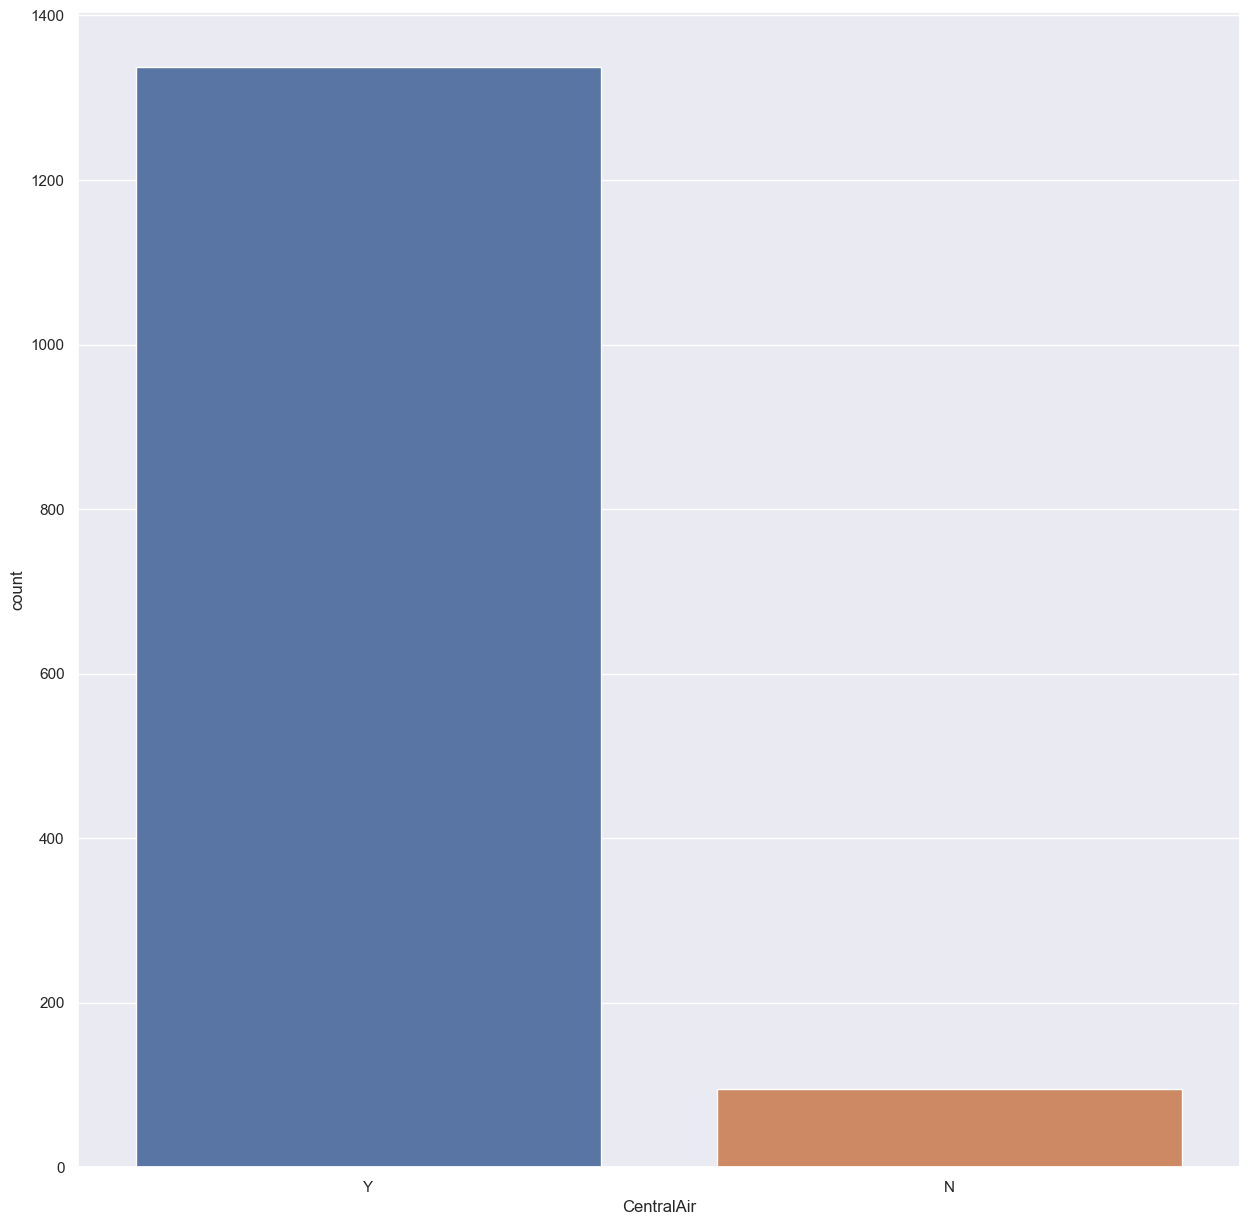

-------------------------------------------------------
            Electrical  Ratio
Electrical                   
SBrkr             1306 91.201
FuseA               94  6.564
FuseF               27  1.885
FuseP                3  0.209
Mix                  1  0.070


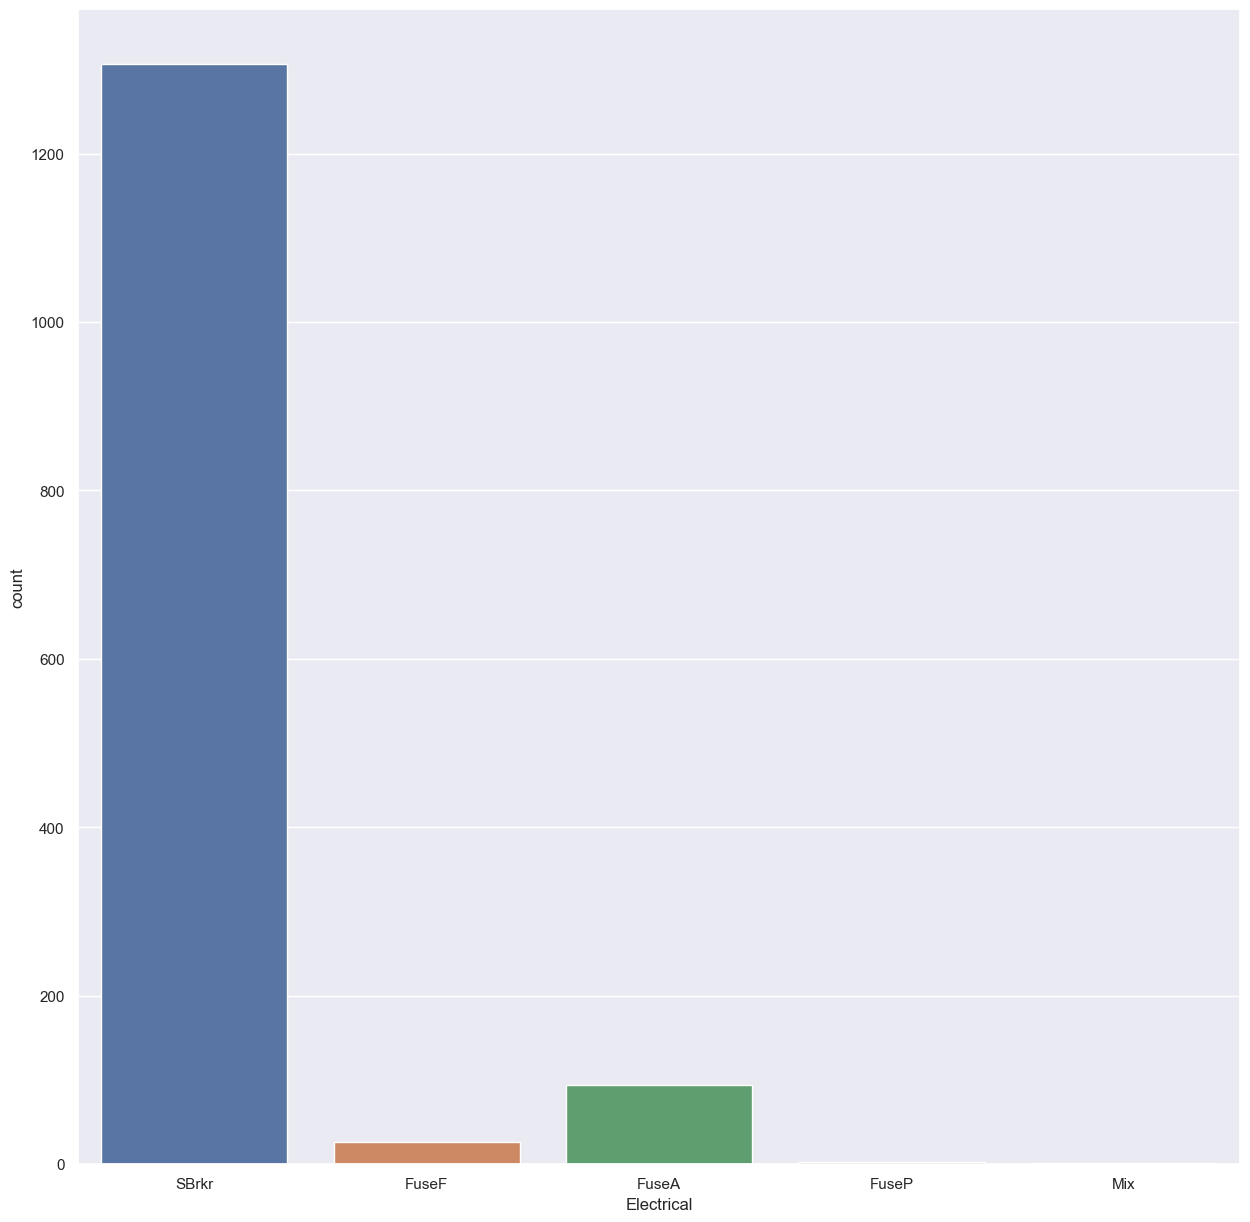

-------------------------------------------------------
             KitchenQual  Ratio
KitchenQual                    
TA                   735 51.327
Gd                   579 40.433
Ex                    79  5.517
Fa                    39  2.723


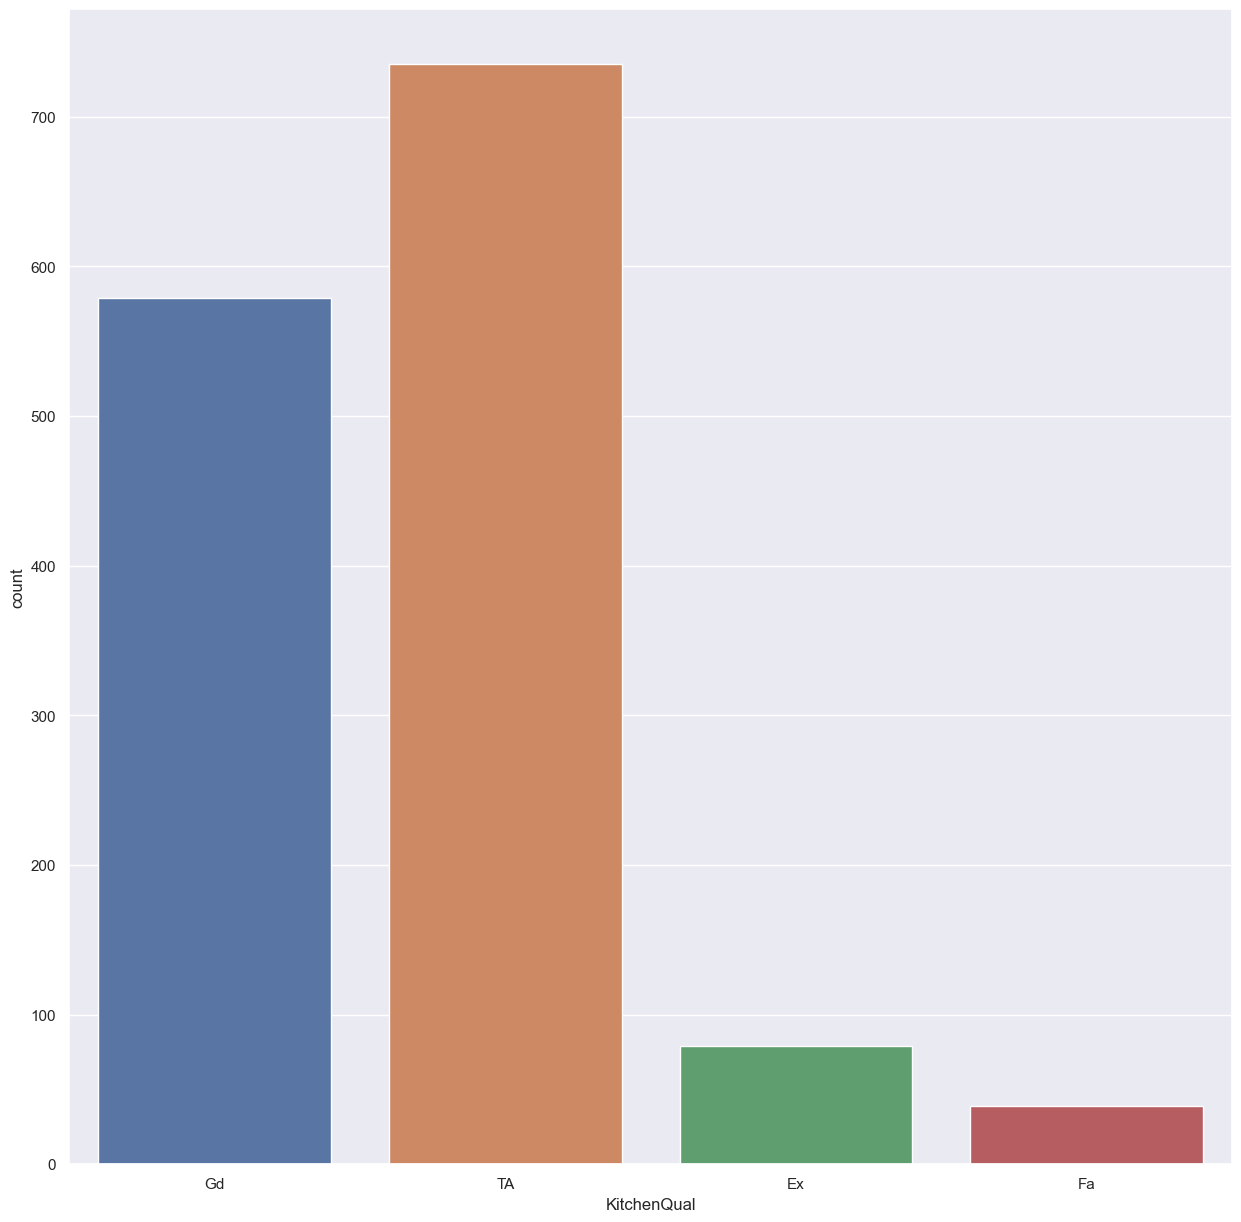

-------------------------------------------------------
            Functional  Ratio
Functional                   
Typ               1333 93.087
Min2                34  2.374
Min1                31  2.165
Maj1                14  0.978
Mod                 14  0.978
Maj2                 5  0.349
Sev                  1  0.070


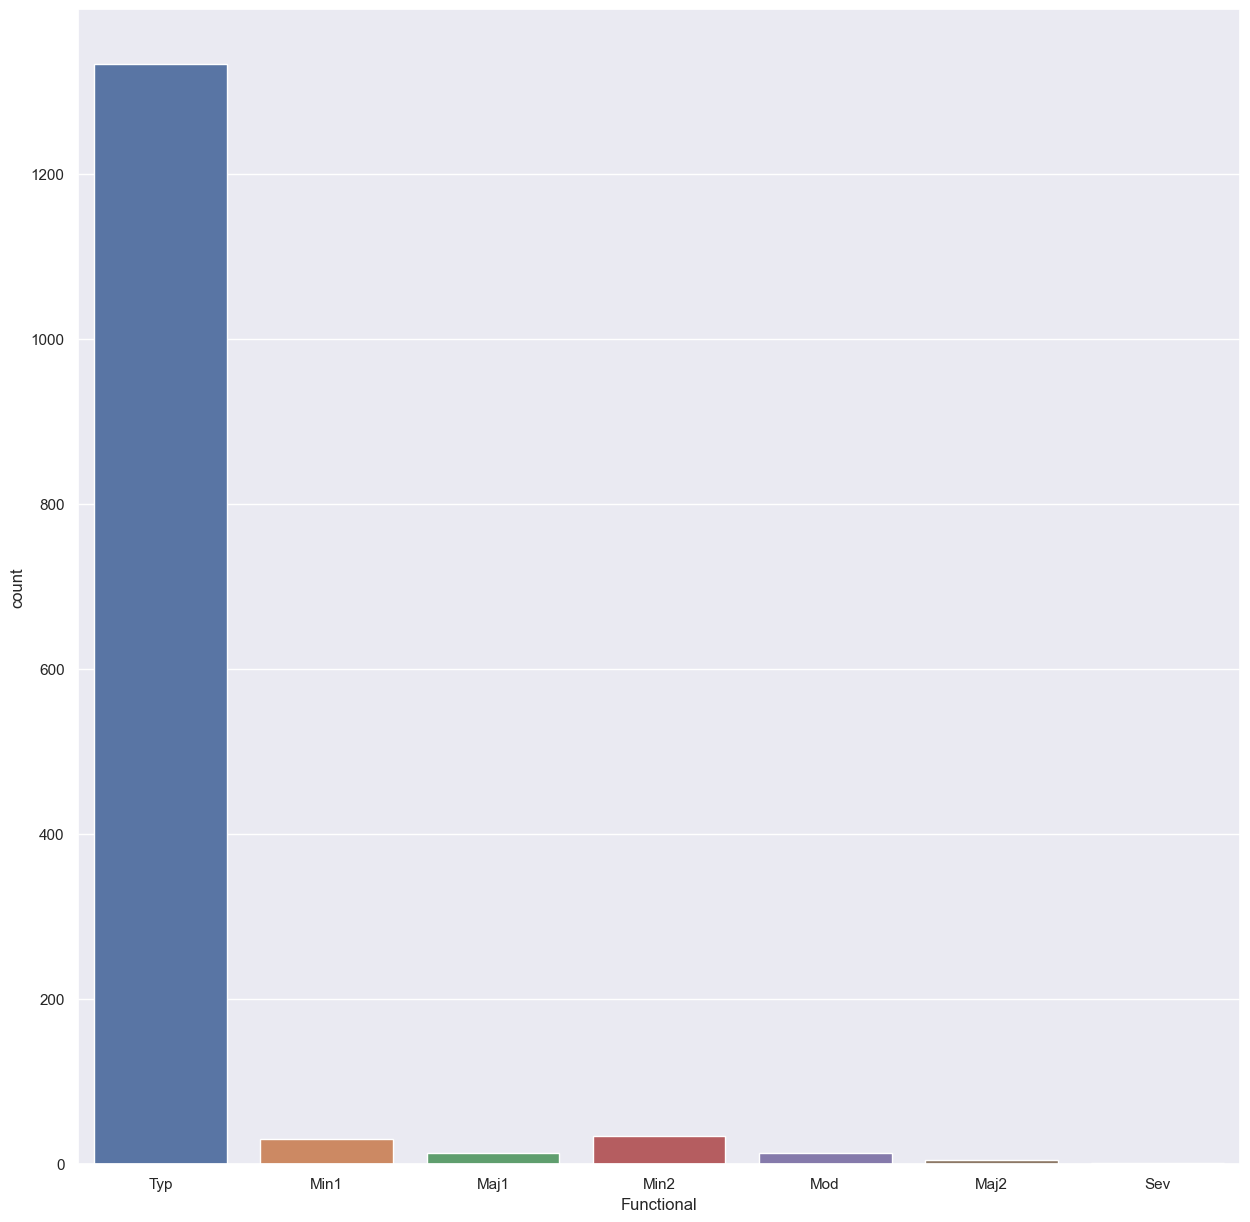

-------------------------------------------------------
             FireplaceQu  Ratio
FireplaceQu                    
Gd                   365 25.489
TA                   307 21.439
Fa                    33  2.304
Po                    20  1.397
Ex                    17  1.187


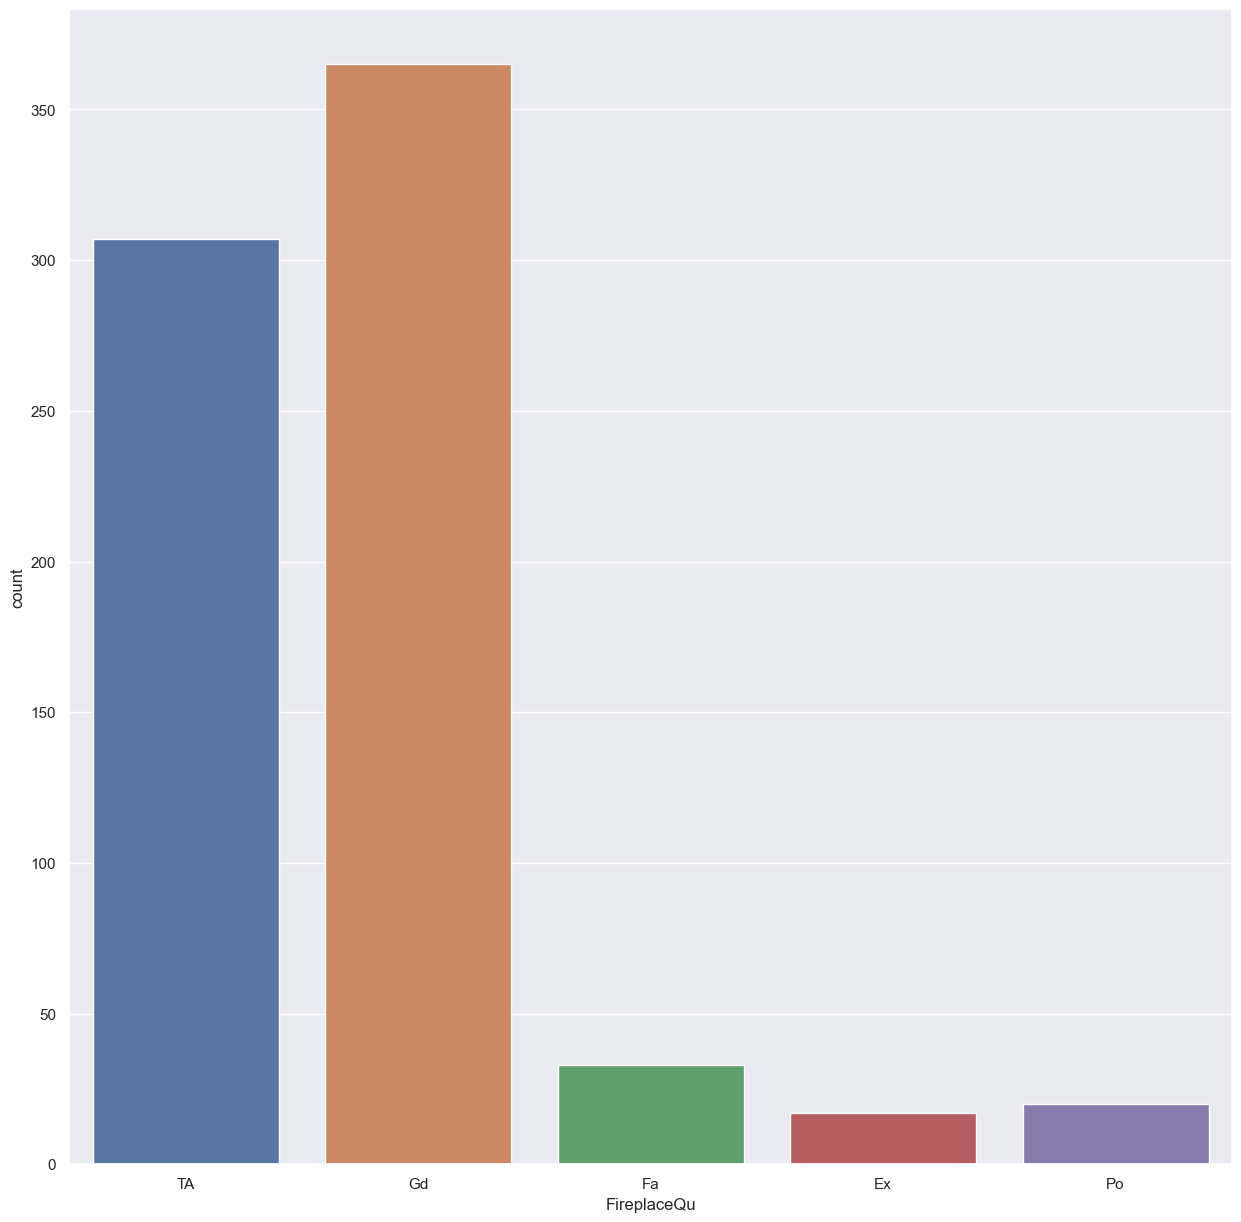

-------------------------------------------------------
            GarageType  Ratio
GarageType                   
Attchd             852 59.497
Detchd             386 26.955
BuiltIn             79  5.517
Basment             19  1.327
CarPort              9  0.628
2Types               6  0.419


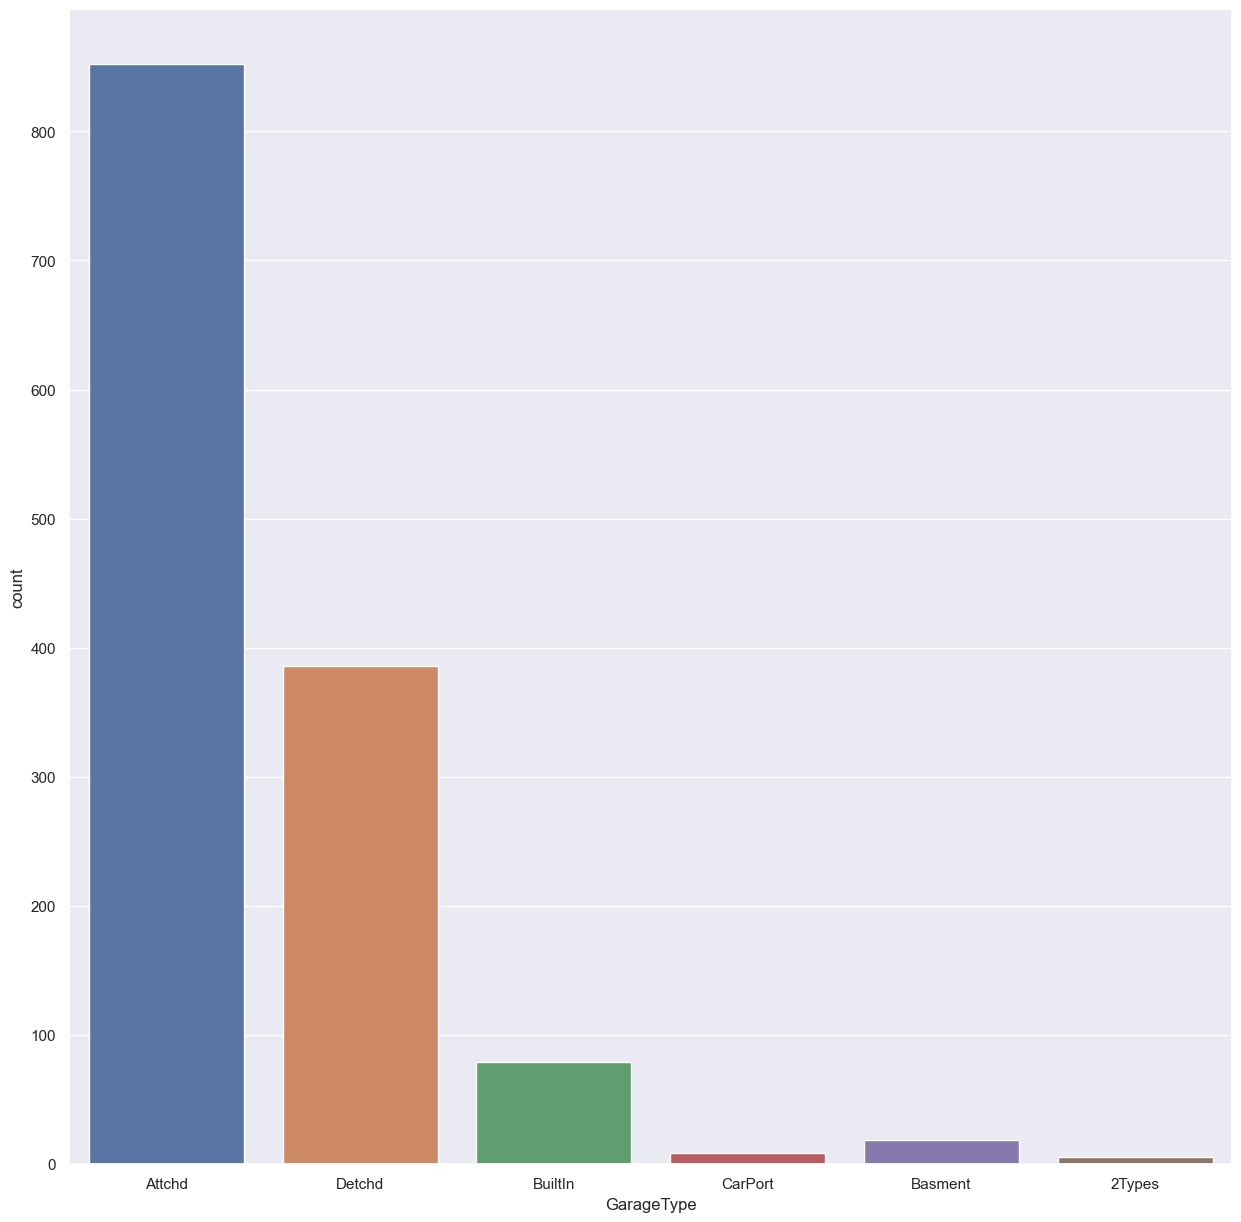

-------------------------------------------------------
              GarageFinish  Ratio
GarageFinish                     
Unf                    604 42.179
RFn                    415 28.980
Fin                    332 23.184


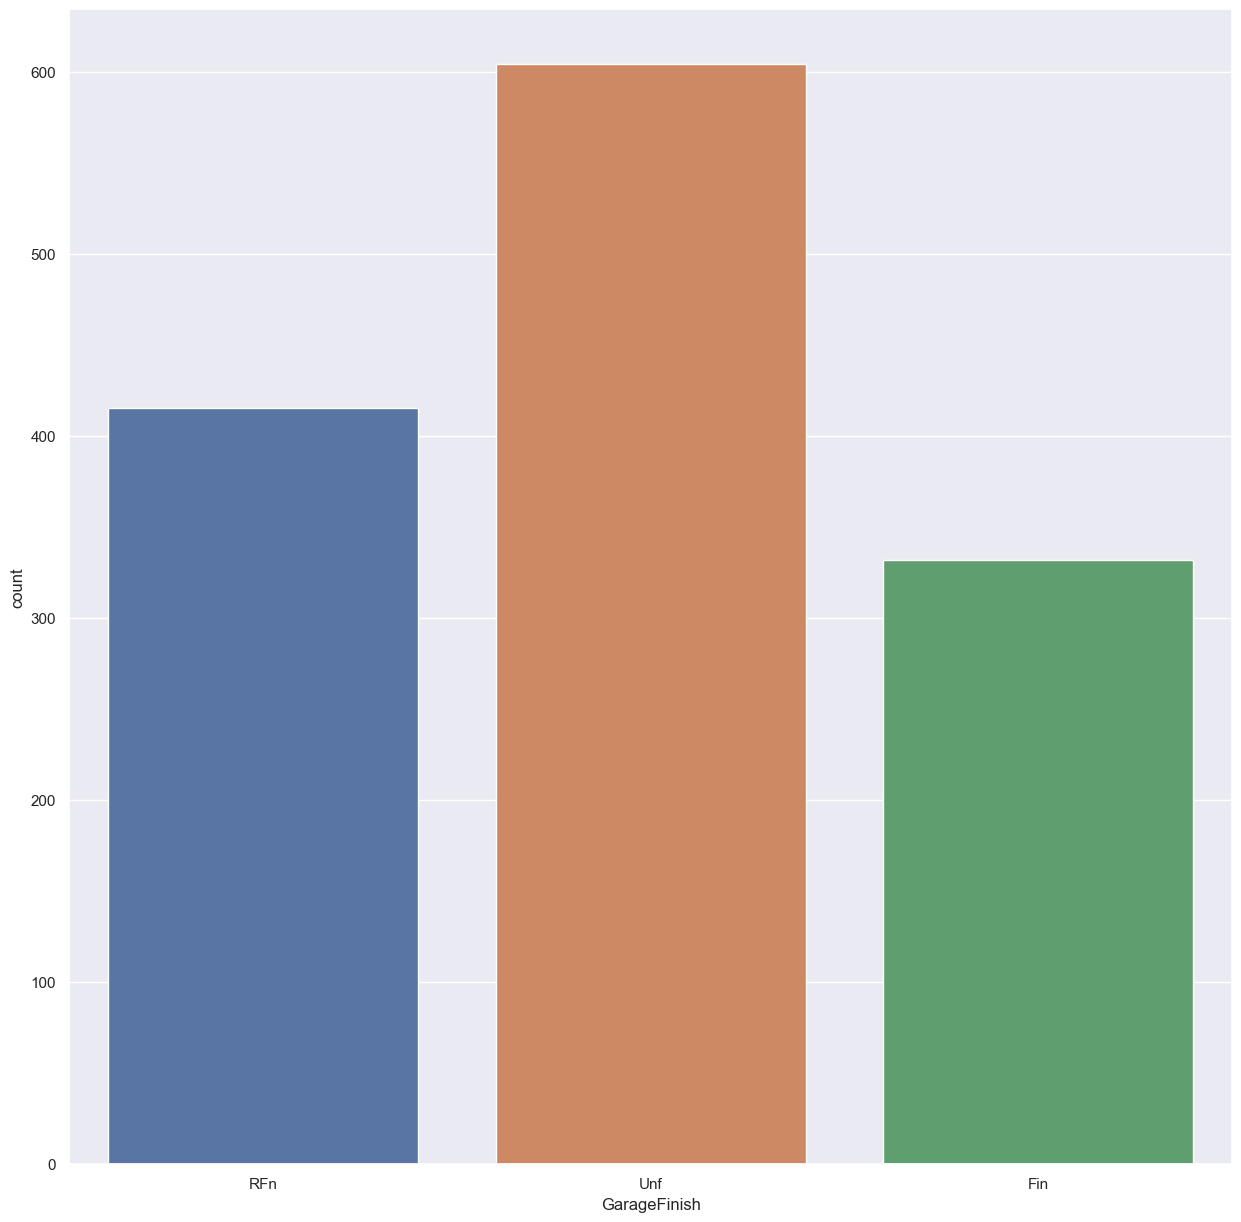

-------------------------------------------------------
            GarageQual  Ratio
GarageQual                   
TA                1284 89.665
Fa                  48  3.352
Gd                  14  0.978
Po                   3  0.209
Ex                   2  0.140


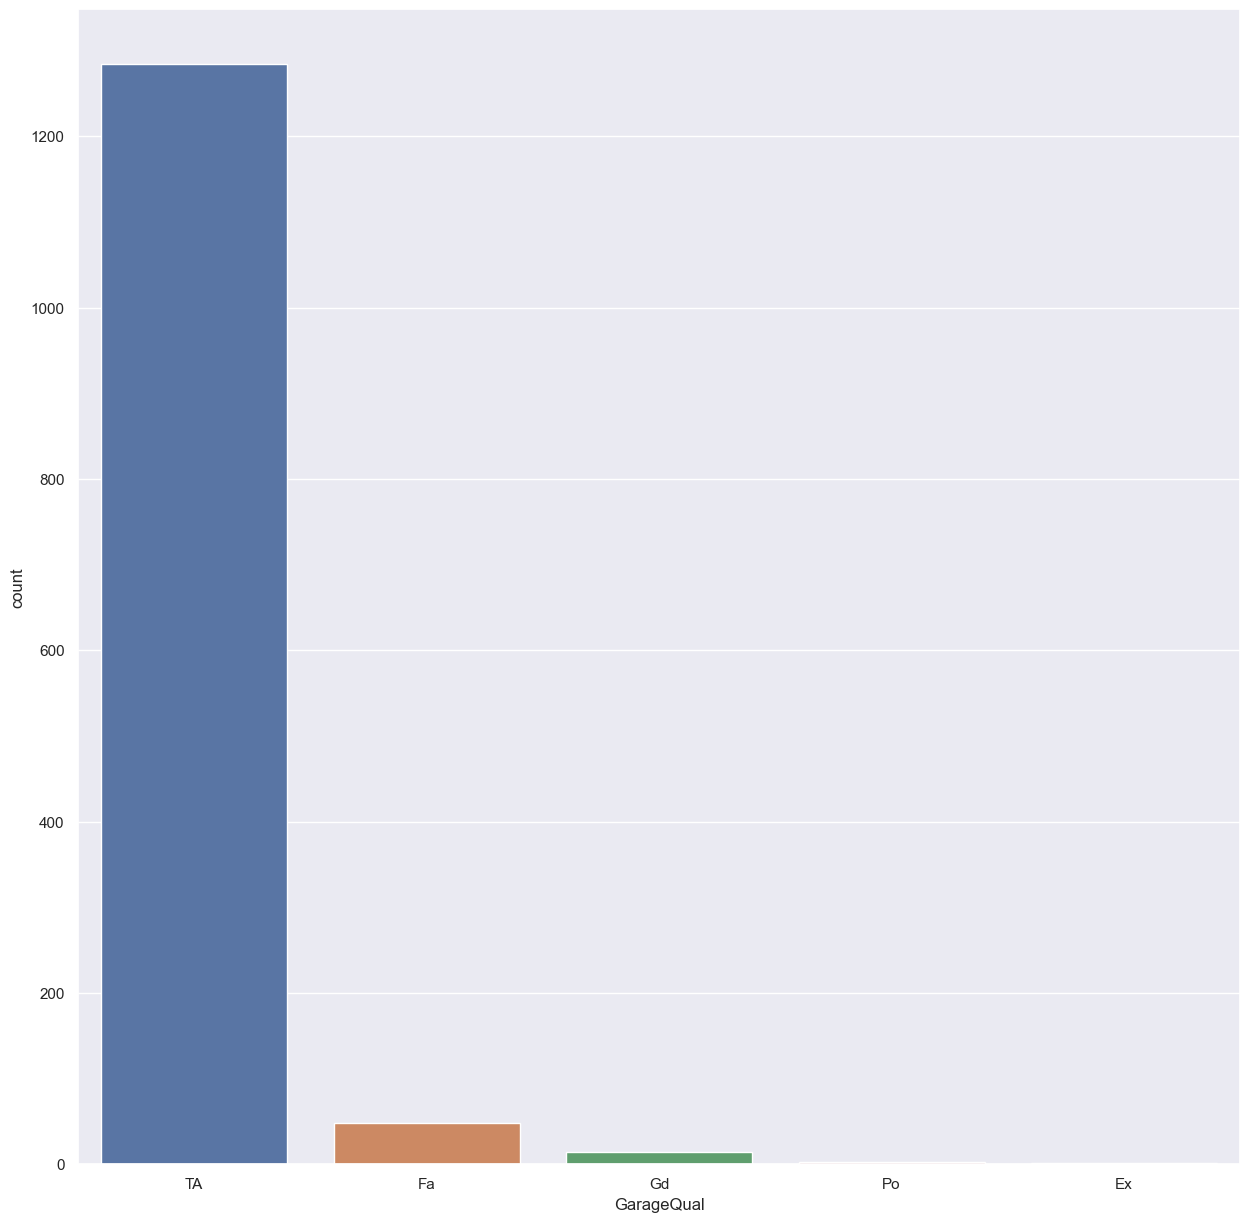

-------------------------------------------------------
            GarageCond  Ratio
GarageCond                   
TA                1298 90.642
Fa                  35  2.444
Gd                   9  0.628
Po                   7  0.489
Ex                   2  0.140


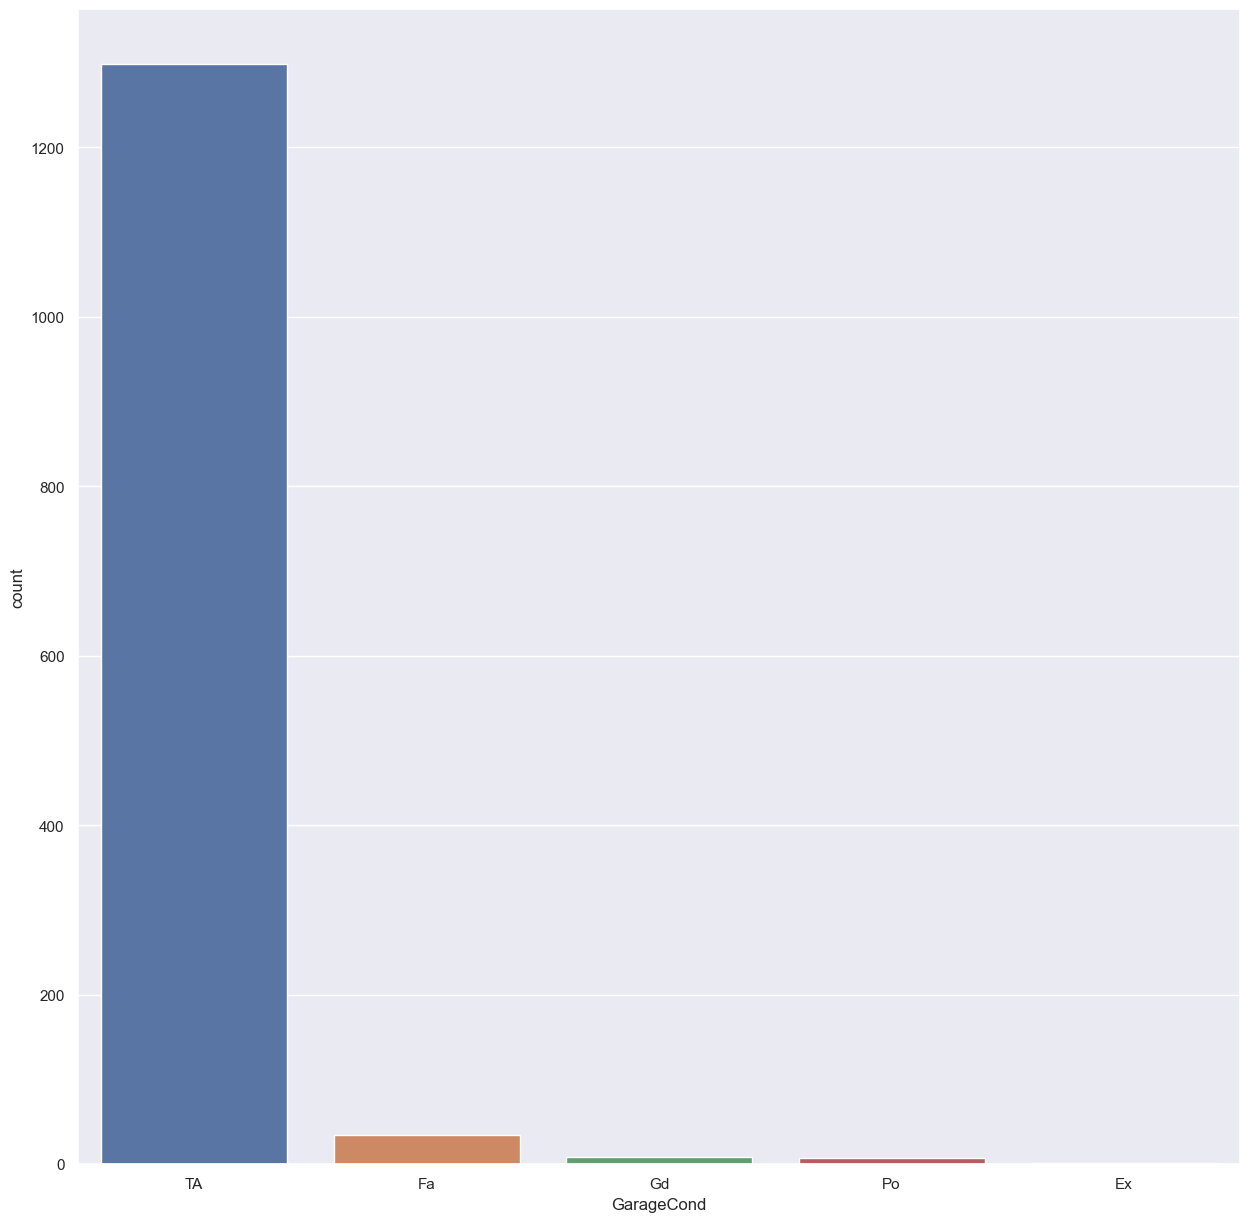

-------------------------------------------------------
            PavedDrive  Ratio
PavedDrive                   
Y                 1312 91.620
N                   90  6.285
P                   30  2.095


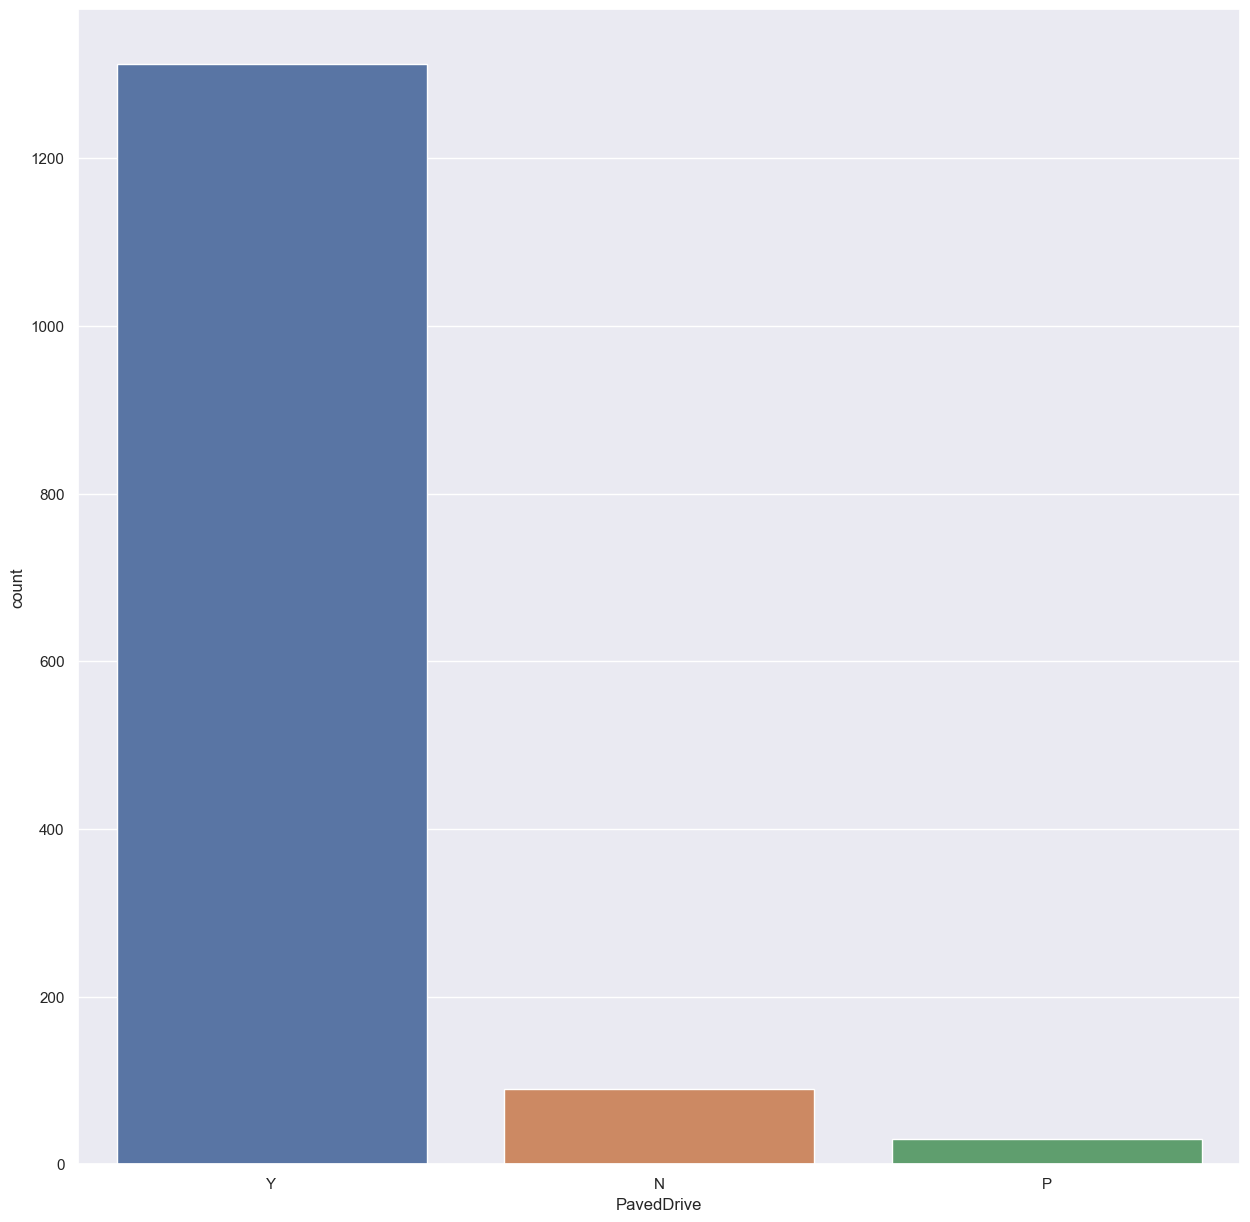

-------------------------------------------------------
        PoolQC  Ratio
PoolQC               
Gd           3  0.209
Fa           2  0.140
Ex           1  0.070


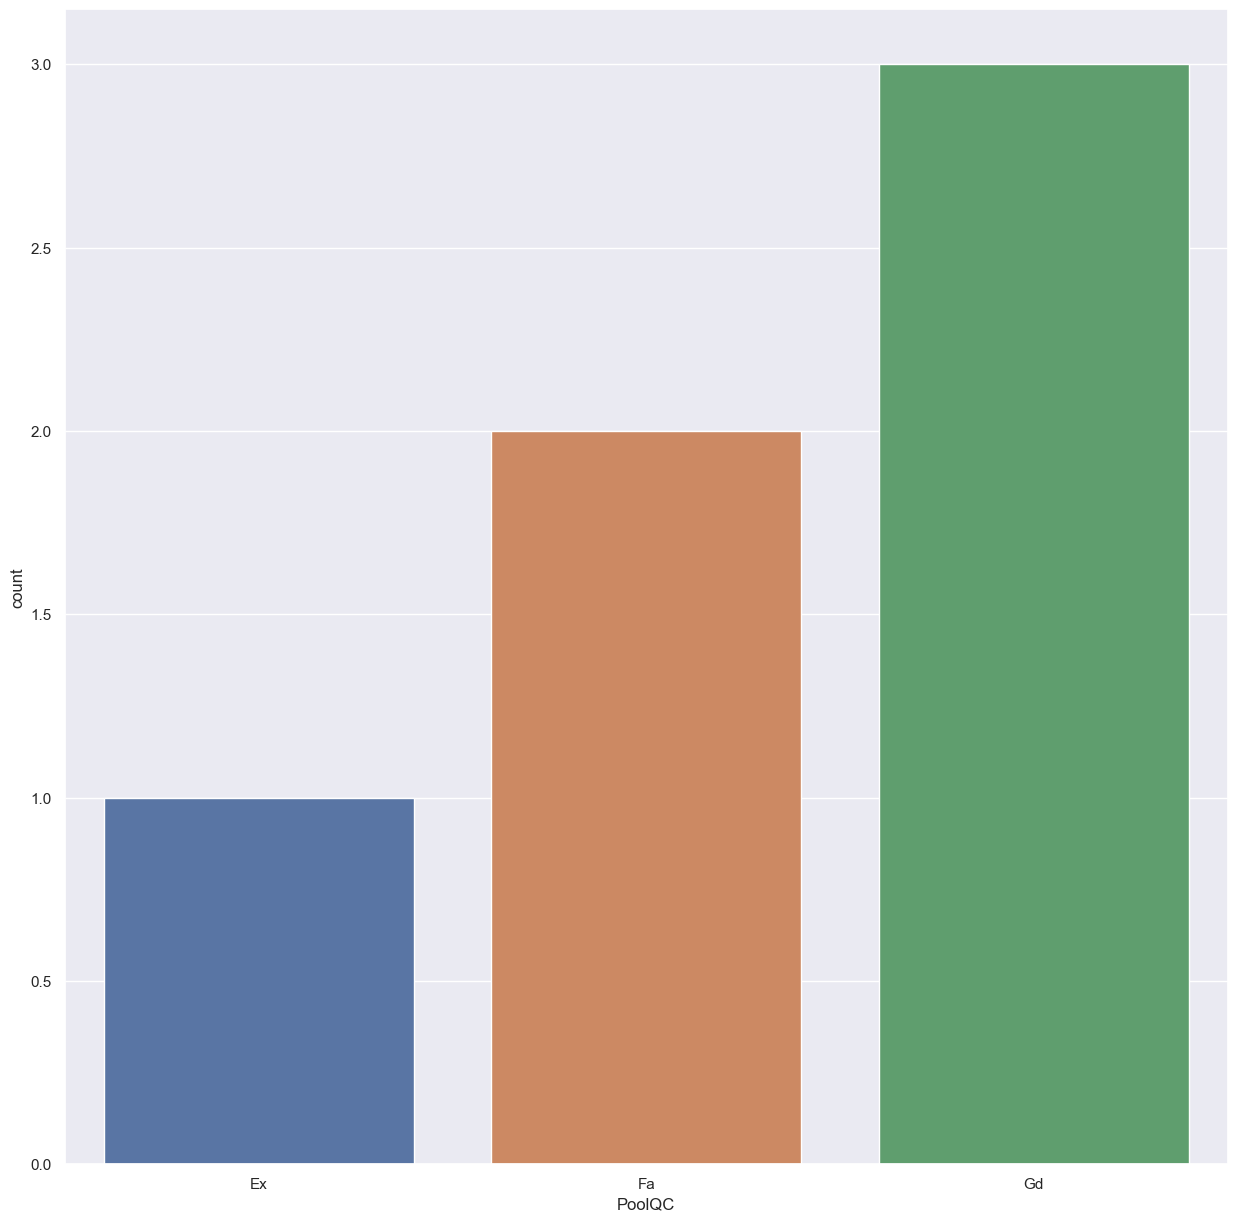

-------------------------------------------------------
       Fence  Ratio
Fence              
MnPrv    156 10.894
GdPrv     58  4.050
GdWo      54  3.771
MnWw      11  0.768


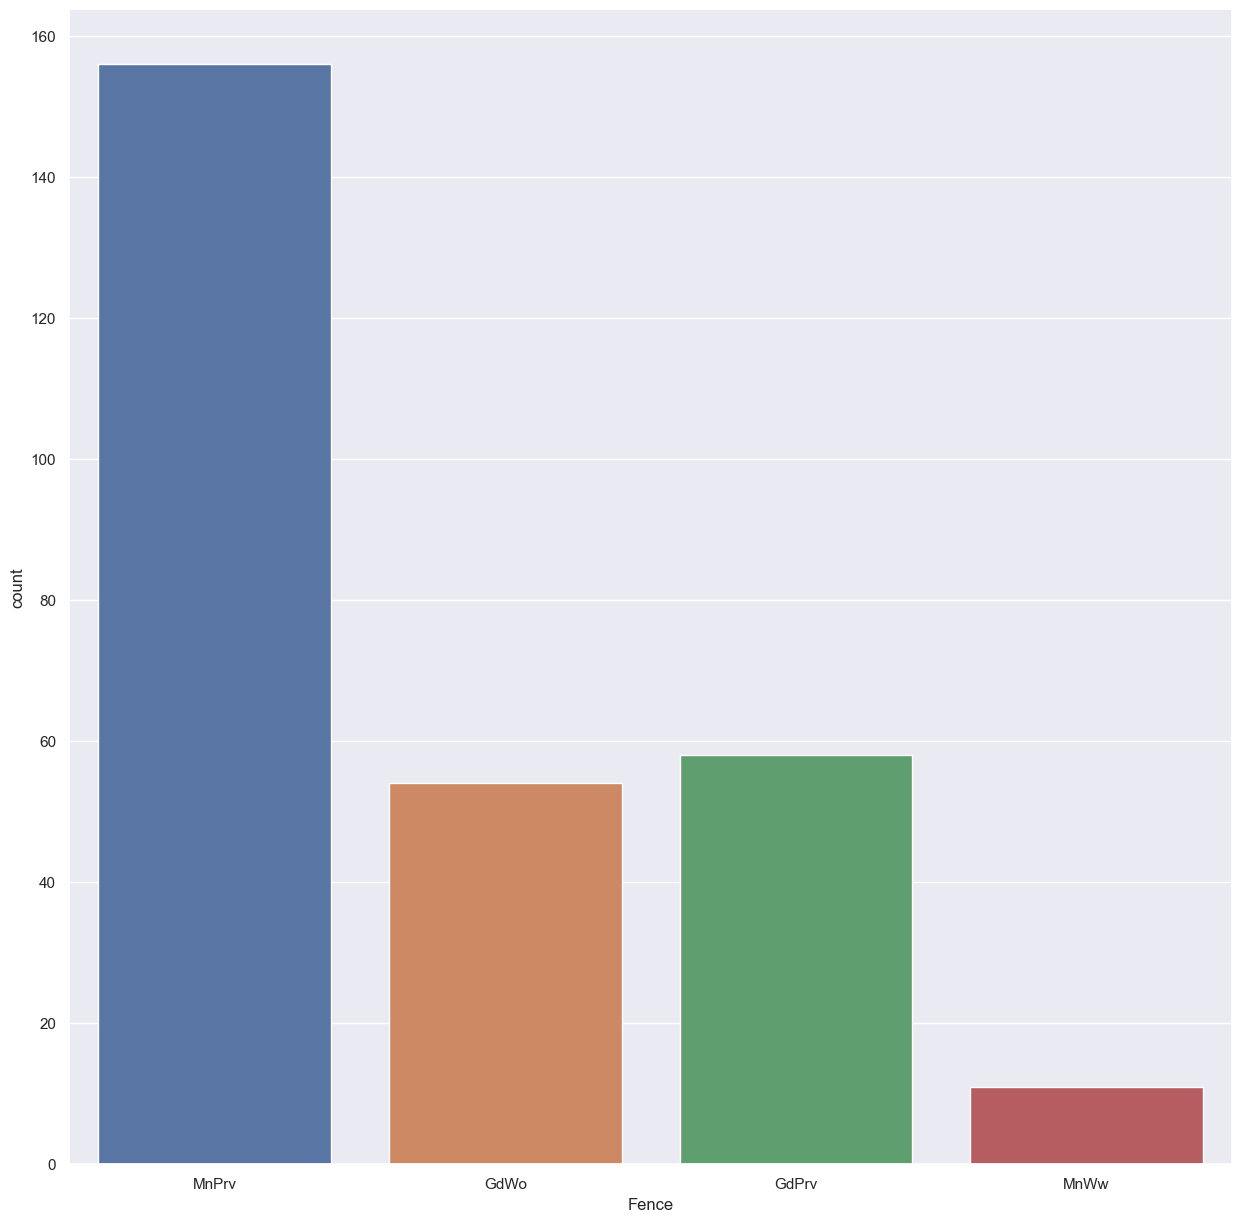

-------------------------------------------------------
             MiscFeature  Ratio
MiscFeature                    
Shed                  49  3.422
Gar2                   2  0.140
Othr                   2  0.140
TenC                   1  0.070


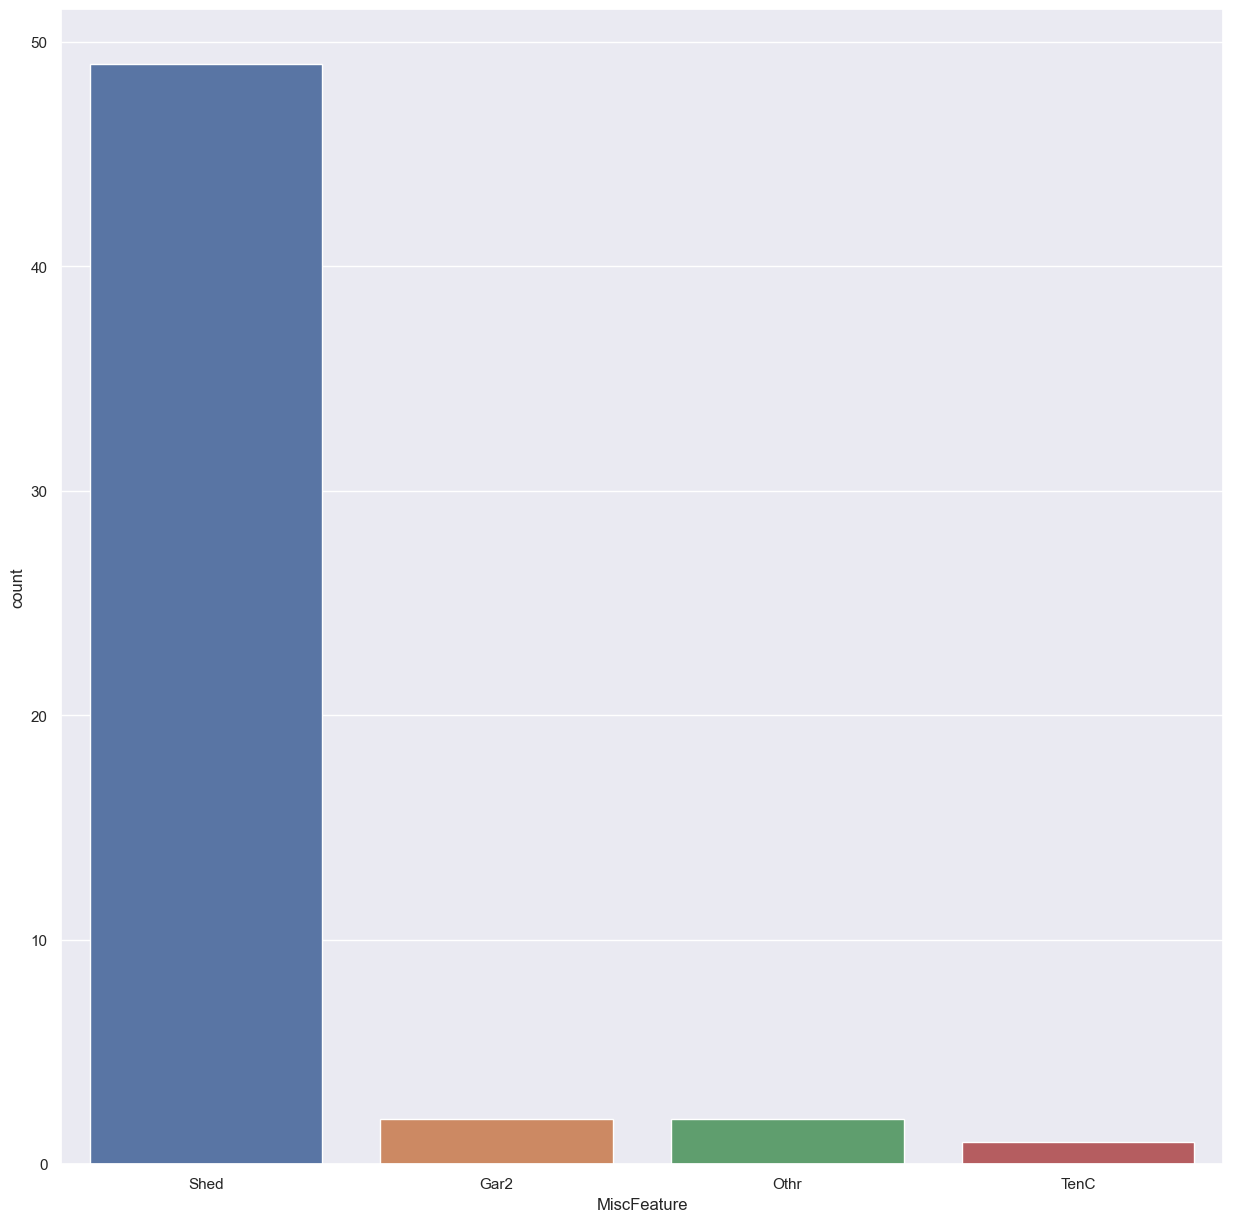

-------------------------------------------------------
          SaleType  Ratio
SaleType                 
WD            1255 87.640
New            107  7.472
COD             43  3.003
ConLD            9  0.628
ConLw            5  0.349
ConLI            4  0.279
CWD              4  0.279
Oth              3  0.209
Con              2  0.140


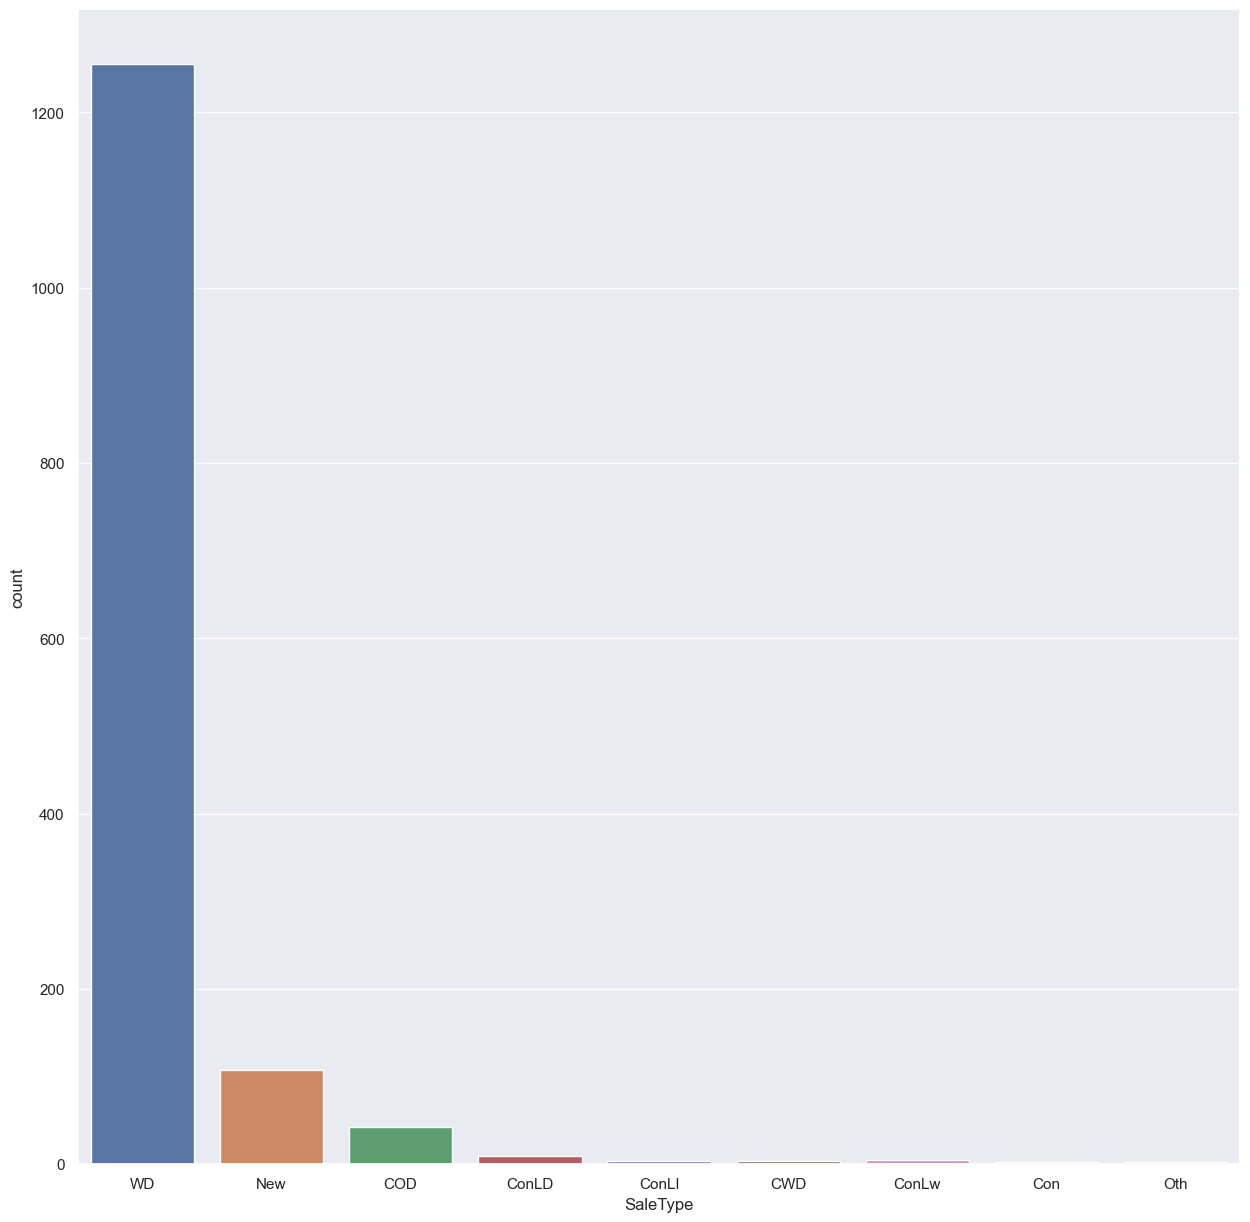

-------------------------------------------------------
               SaleCondition  Ratio
SaleCondition                      
Normal                  1186 82.821
Partial                  110  7.682
Abnorml                  100  6.983
Family                    20  1.397
Alloca                    12  0.838
AdjLand                    4  0.279


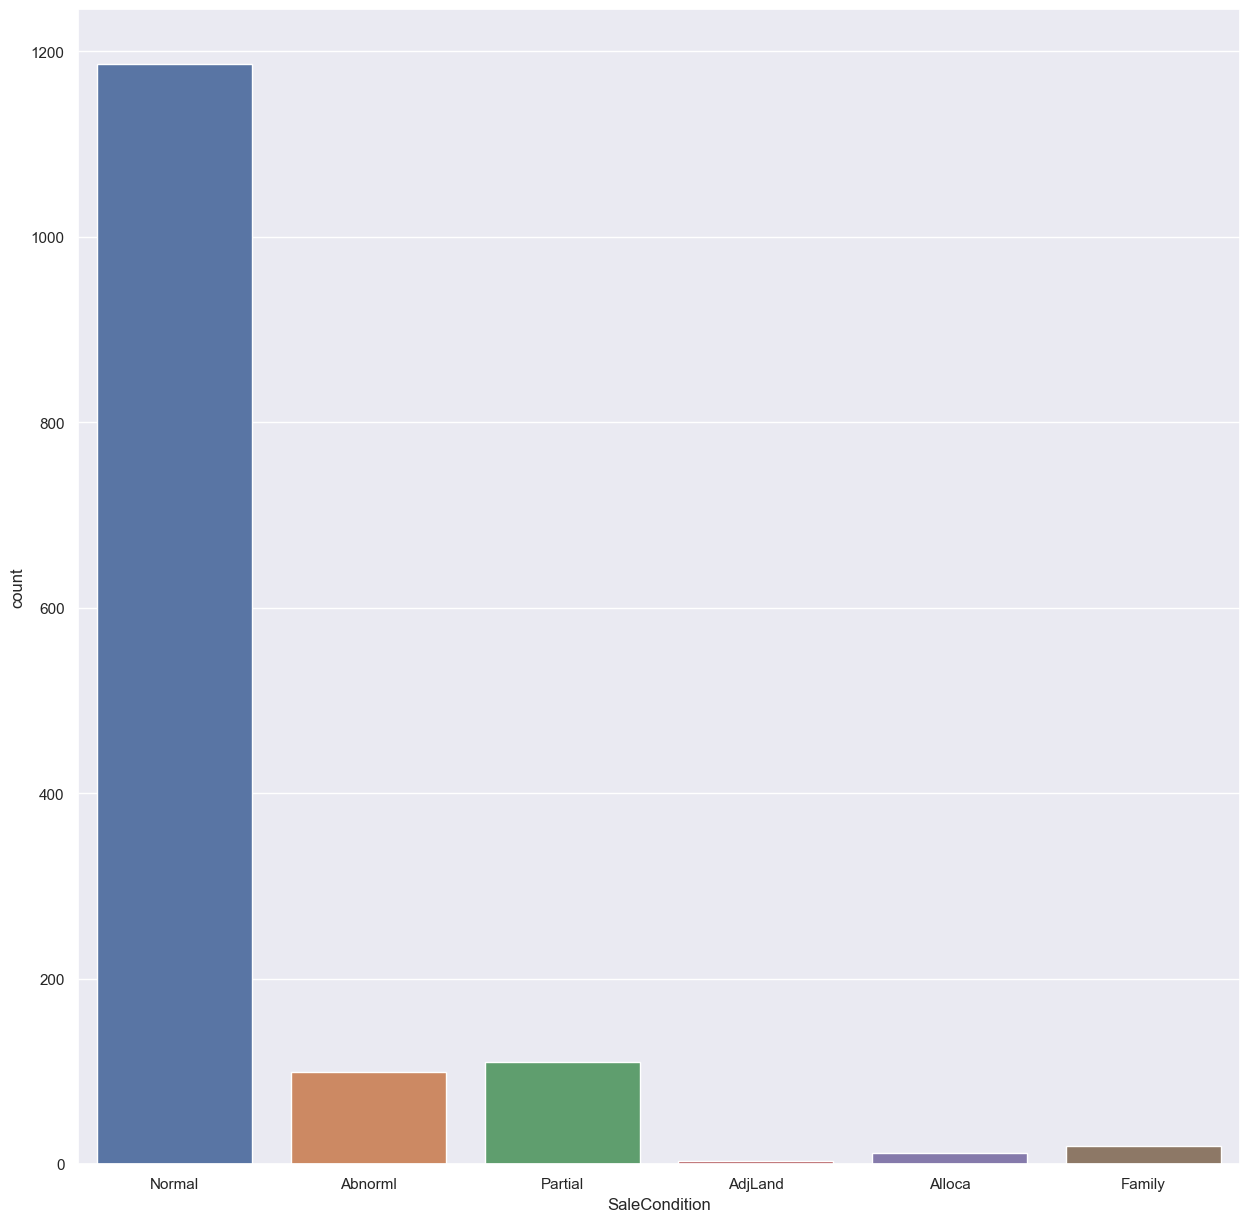

-------------------------------------------------------
             OverallCond  Ratio
OverallCond                    
5                    796 55.587
6                    251 17.528
7                    204 14.246
8                     72  5.028
4                     57  3.980
3                     25  1.746
9                     21  1.466
2                      5  0.349
1                      1  0.070


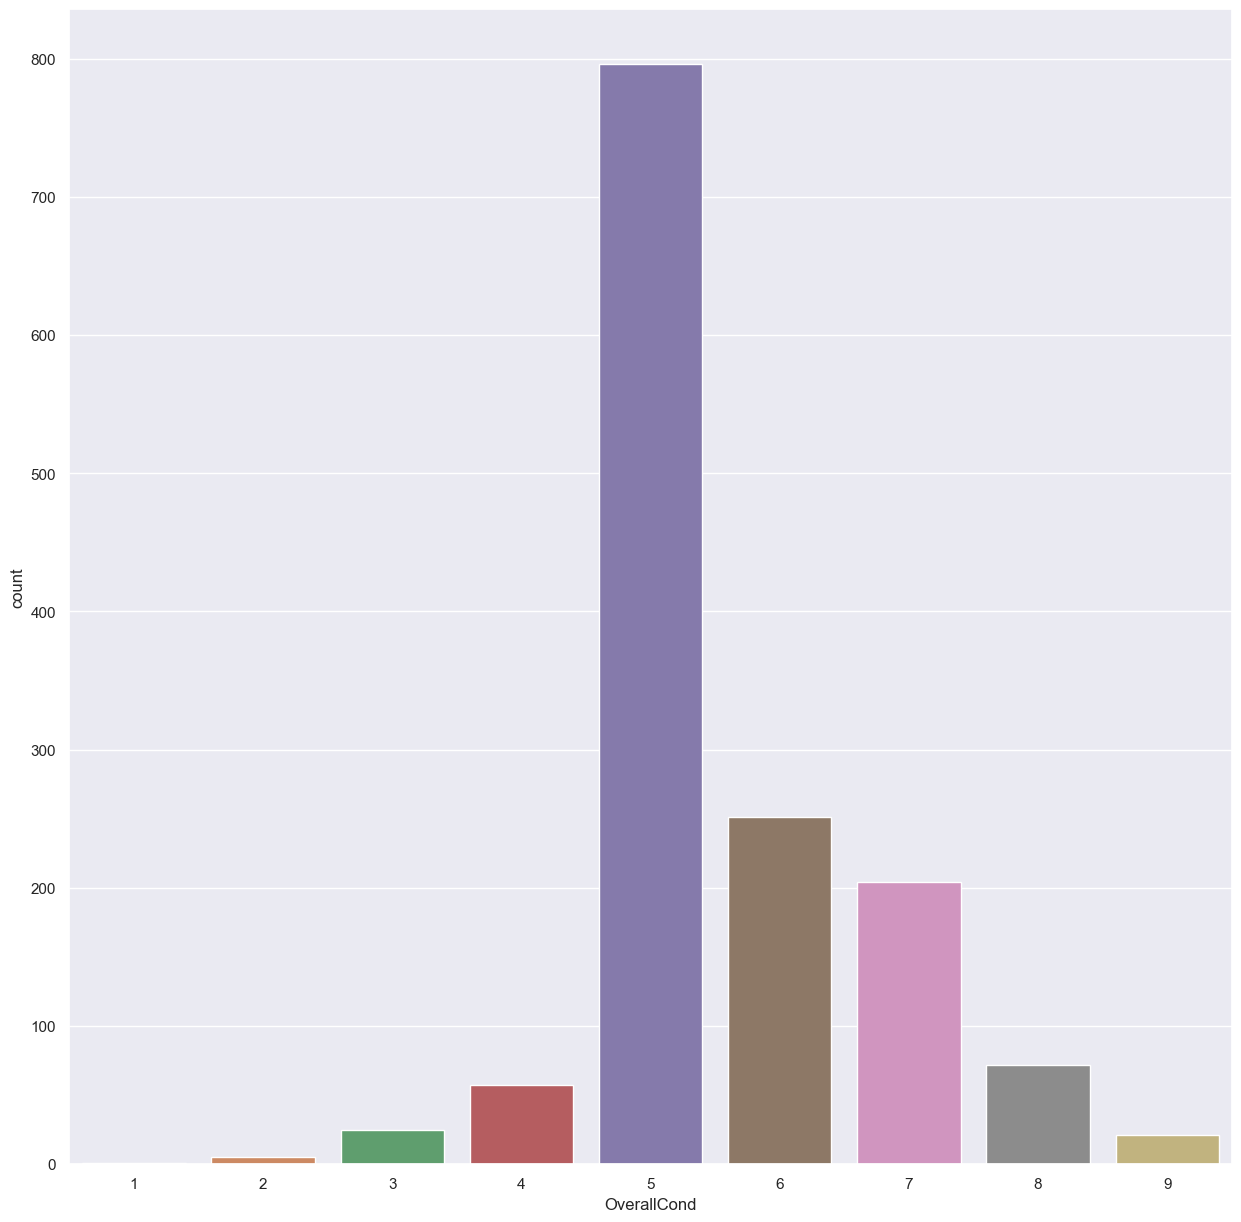

-------------------------------------------------------
              BsmtFullBath  Ratio
BsmtFullBath                     
0                      849 59.288
1                      567 39.595
2                       15  1.047
3                        1  0.070


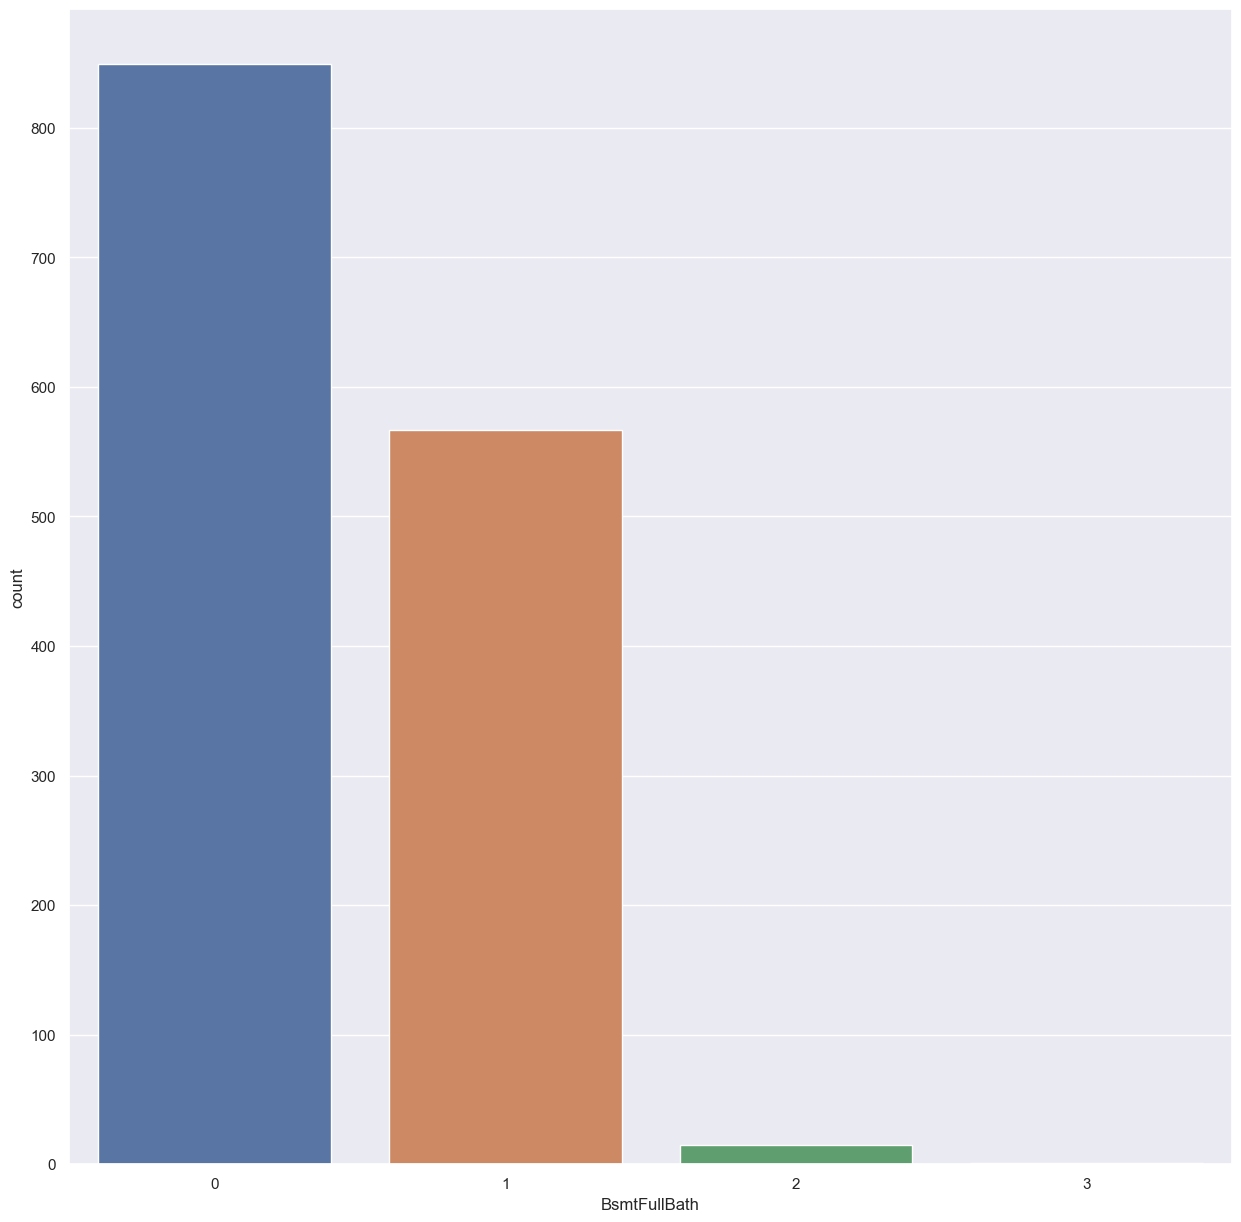

-------------------------------------------------------
              BsmtHalfBath  Ratio
BsmtHalfBath                     
0                     1351 94.344
1                       79  5.517
2                        2  0.140


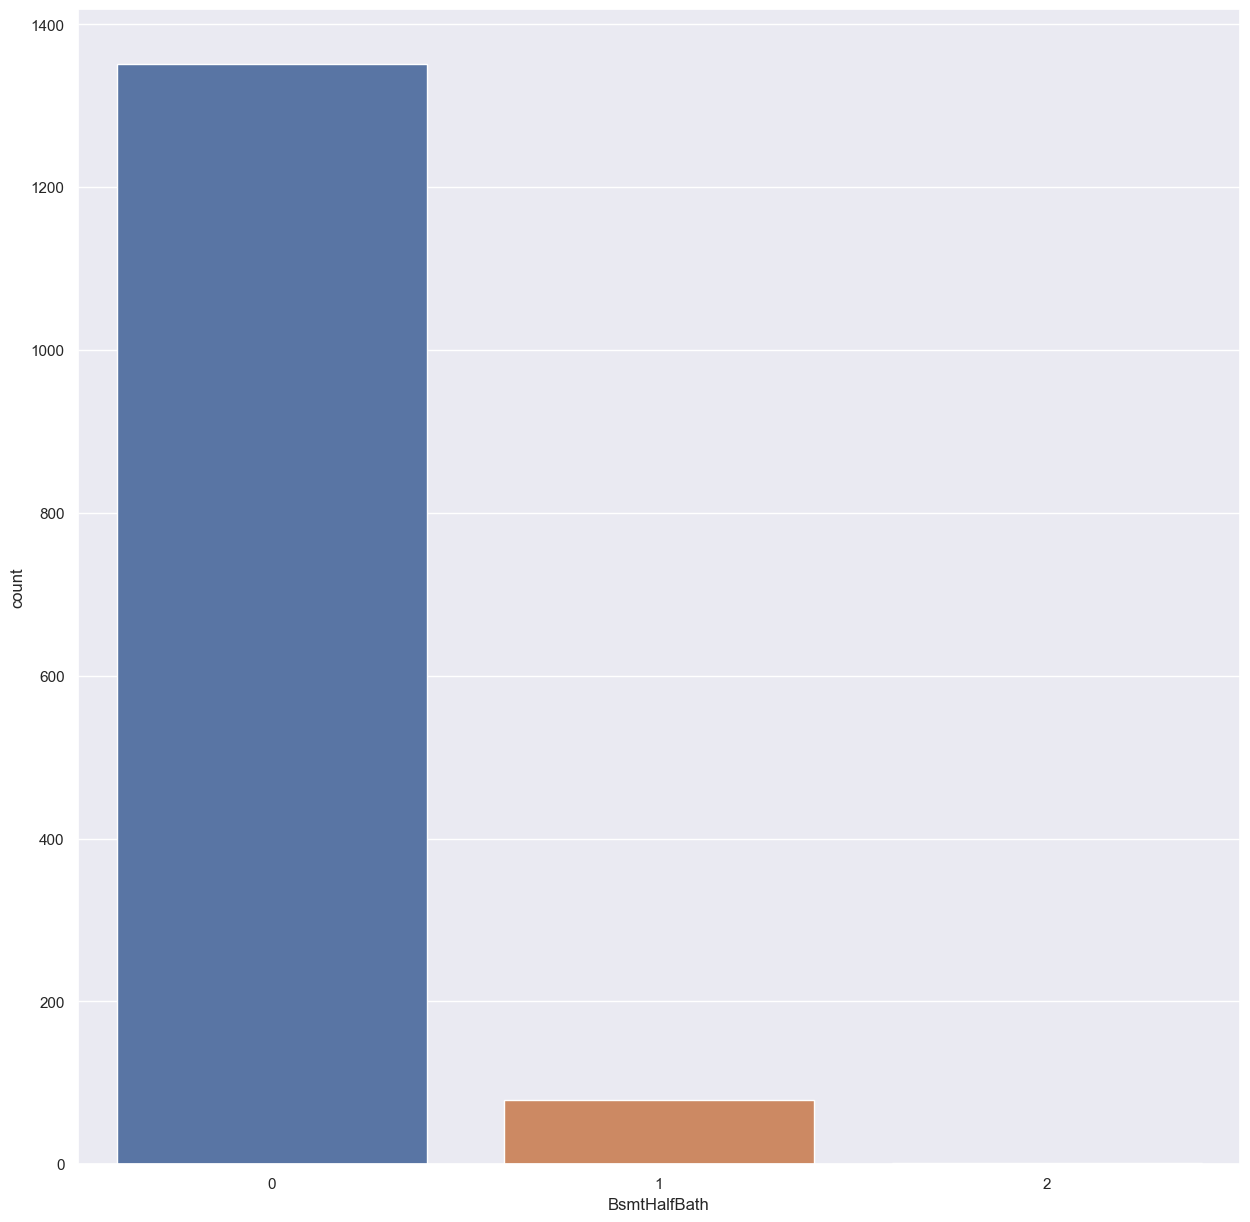

-------------------------------------------------------
          FullBath  Ratio
FullBath                 
2              751 52.444
1              649 45.321
3               23  1.606
0                9  0.628


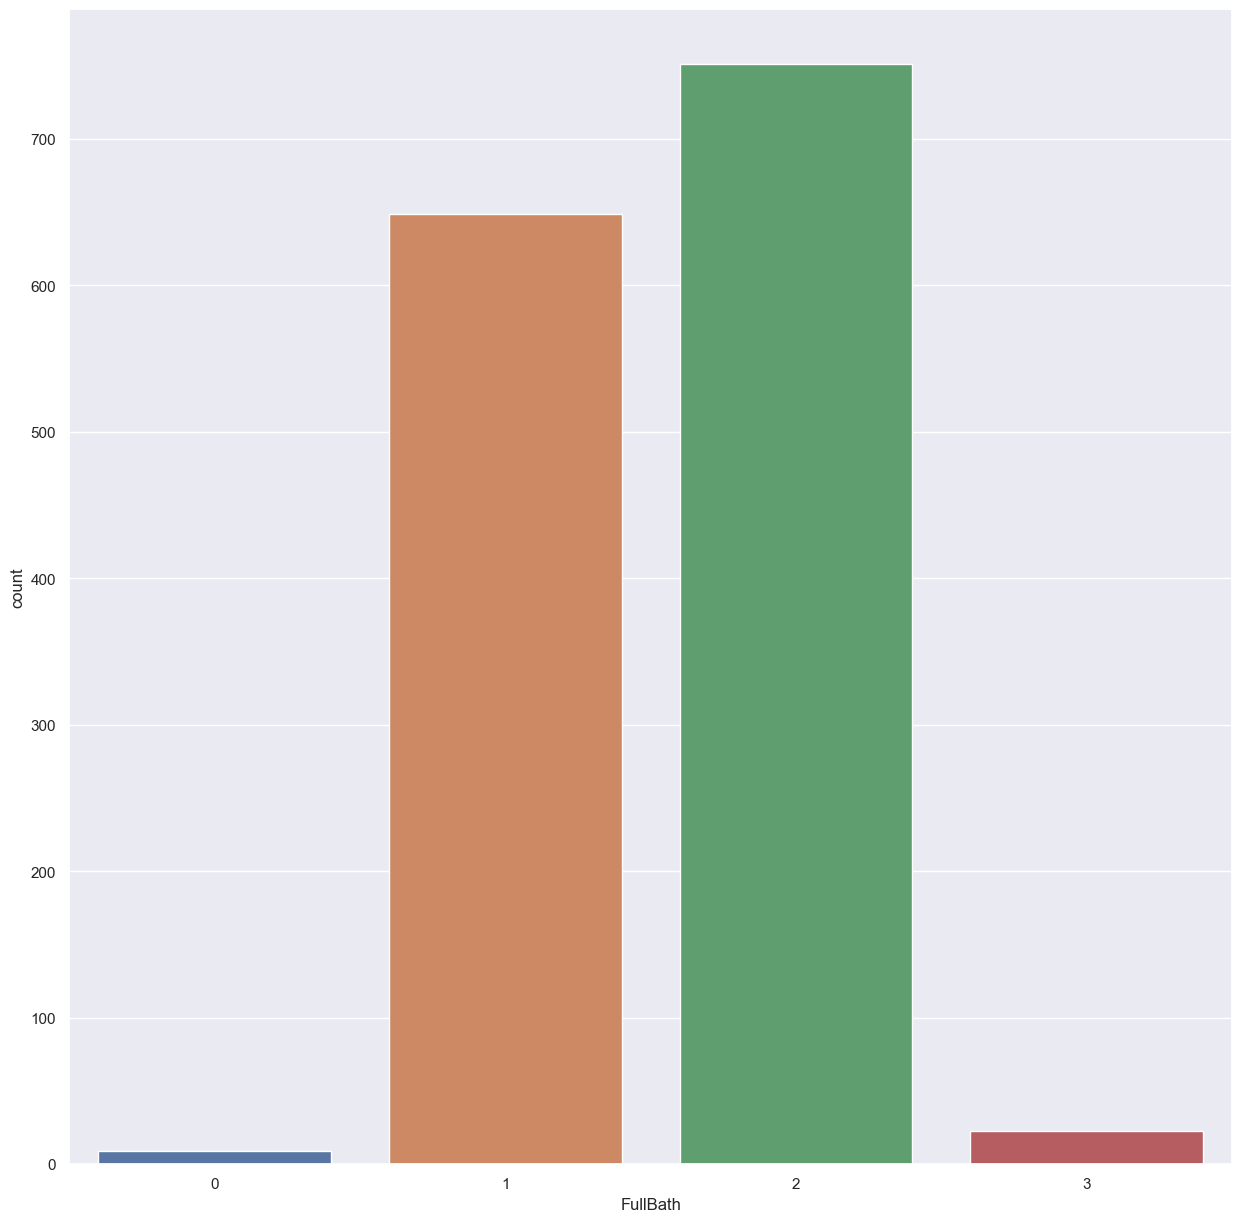

-------------------------------------------------------
          HalfBath  Ratio
HalfBath                 
0              908 63.408
1              512 35.754
2               12  0.838


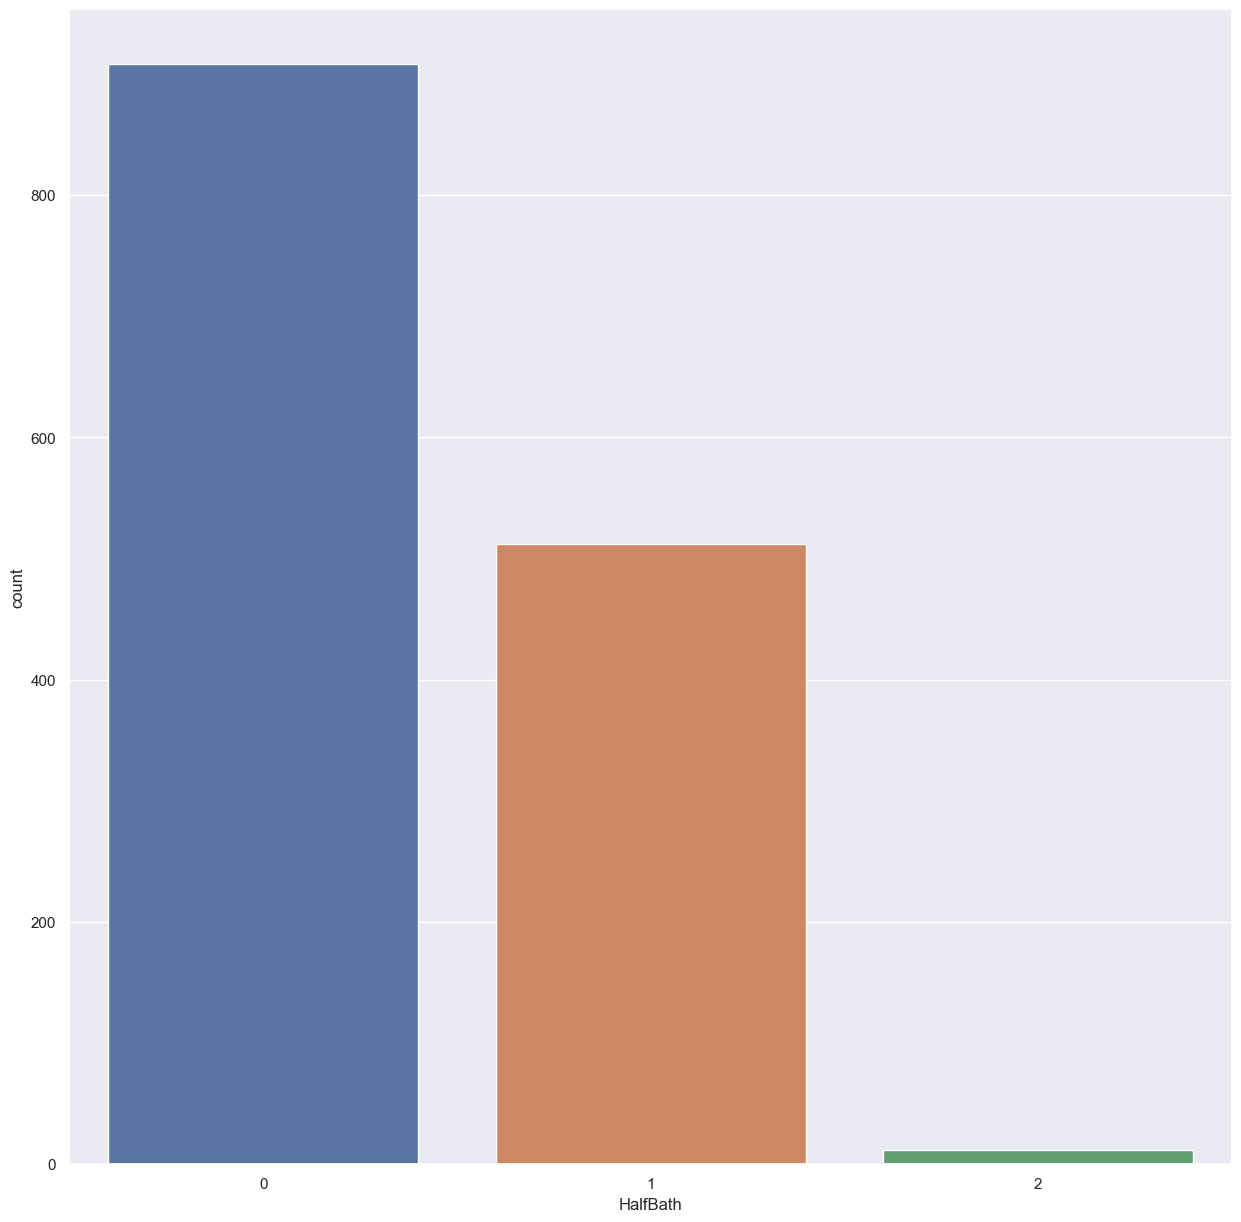

-------------------------------------------------------
              BedroomAbvGr  Ratio
BedroomAbvGr                     
3                      797 55.656
2                      353 24.651
4                      199 13.897
1                       48  3.352
5                       21  1.466
6                        7  0.489
0                        6  0.419
8                        1  0.070


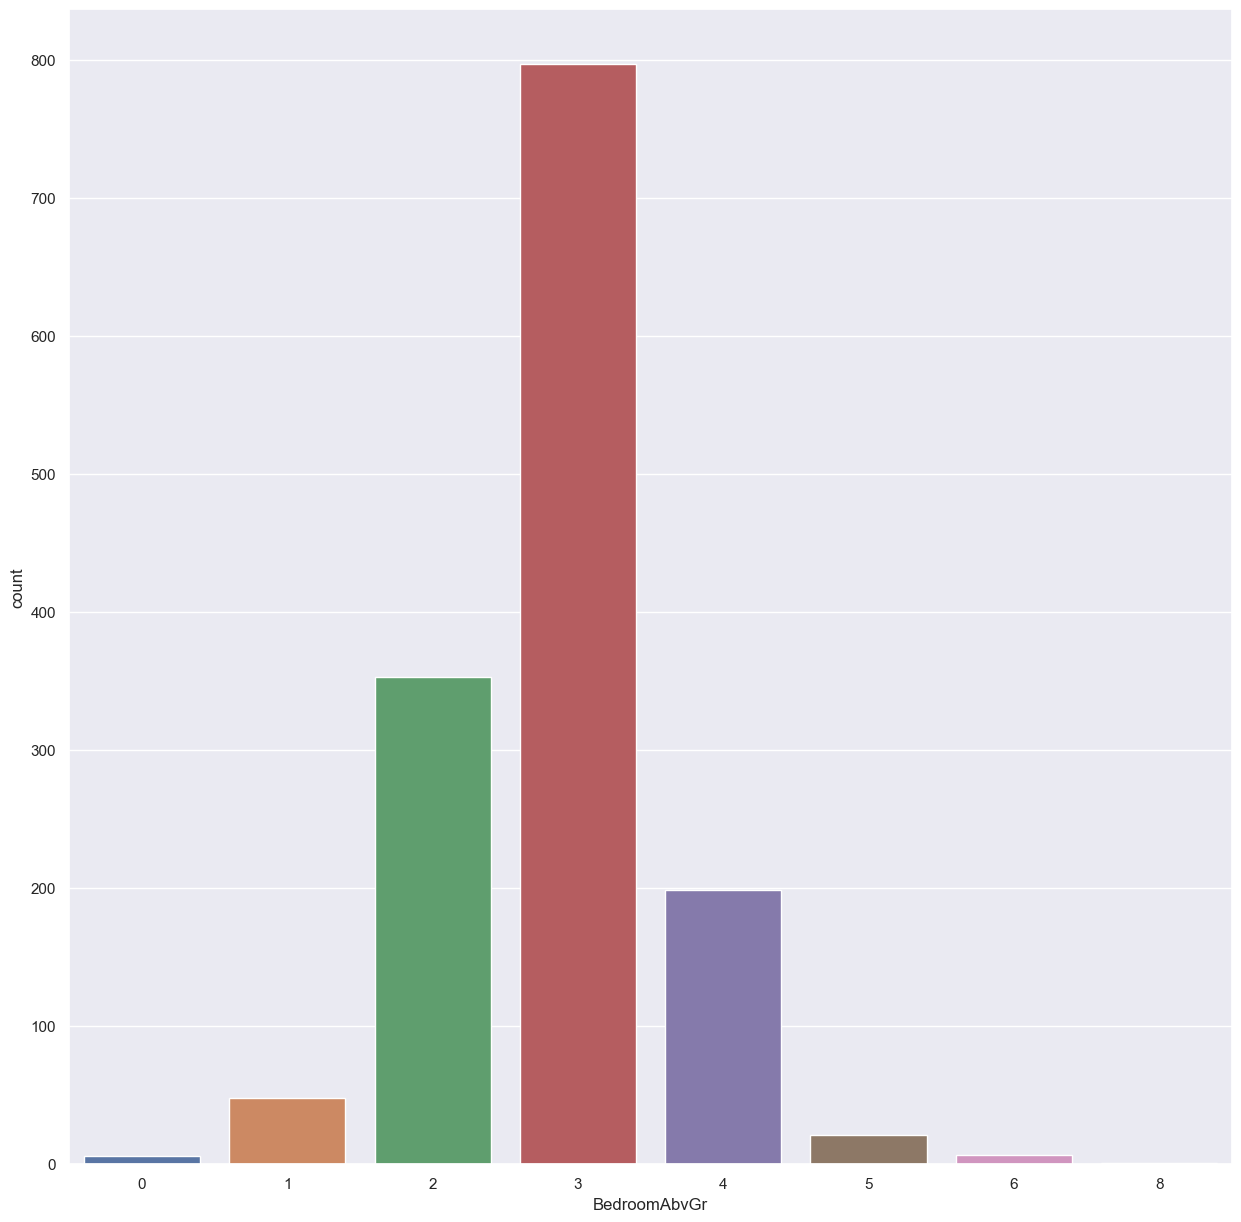

-------------------------------------------------------
              KitchenAbvGr  Ratio
KitchenAbvGr                     
1                     1364 95.251
2                       65  4.539
3                        2  0.140
0                        1  0.070


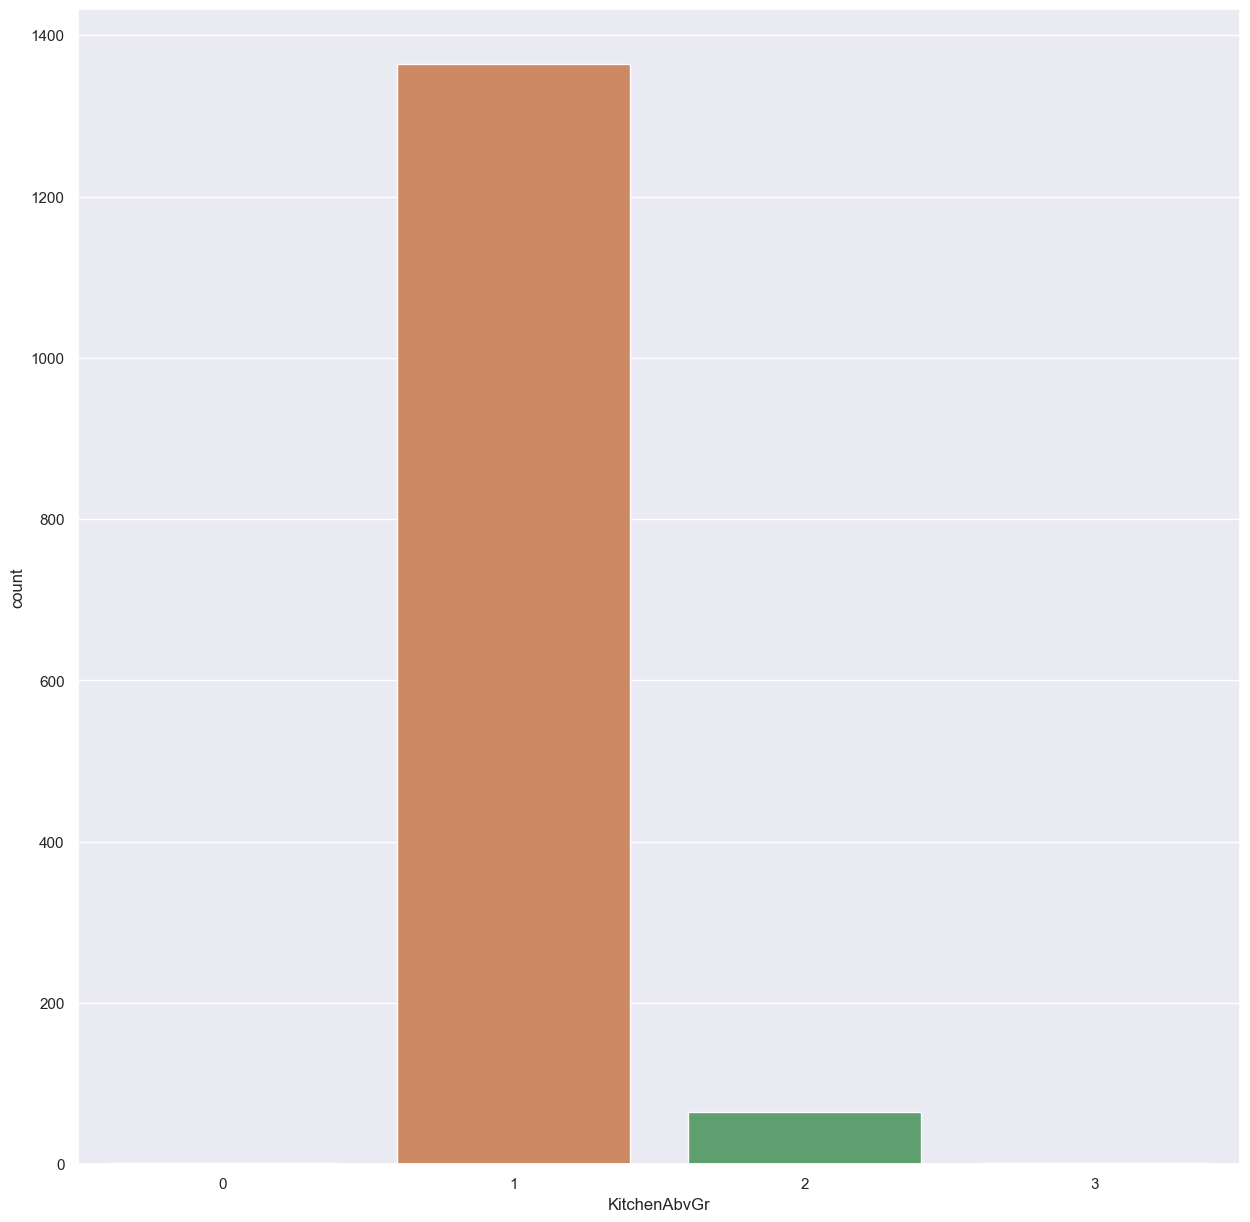

-------------------------------------------------------
            Fireplaces  Ratio
Fireplaces                   
0                  690 48.184
1                  631 44.064
2                  106  7.402
3                    5  0.349


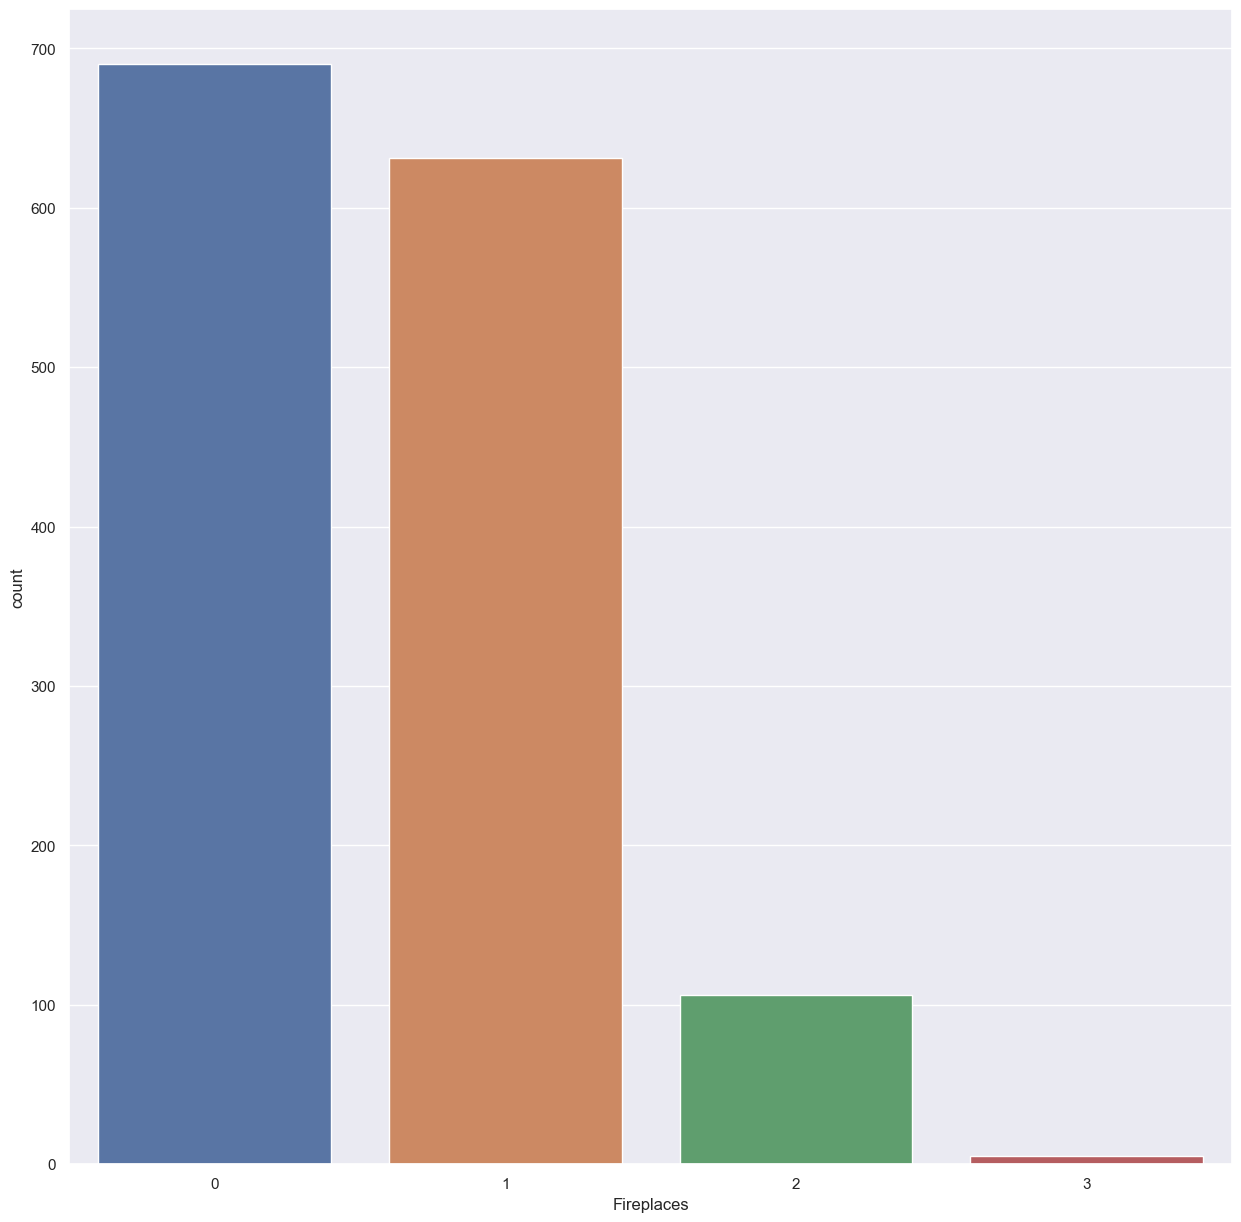

-------------------------------------------------------
            GarageCars  Ratio
GarageCars                   
2                  823 57.472
1                  369 25.768
3                  154 10.754
0                   81  5.656
4                    5  0.349


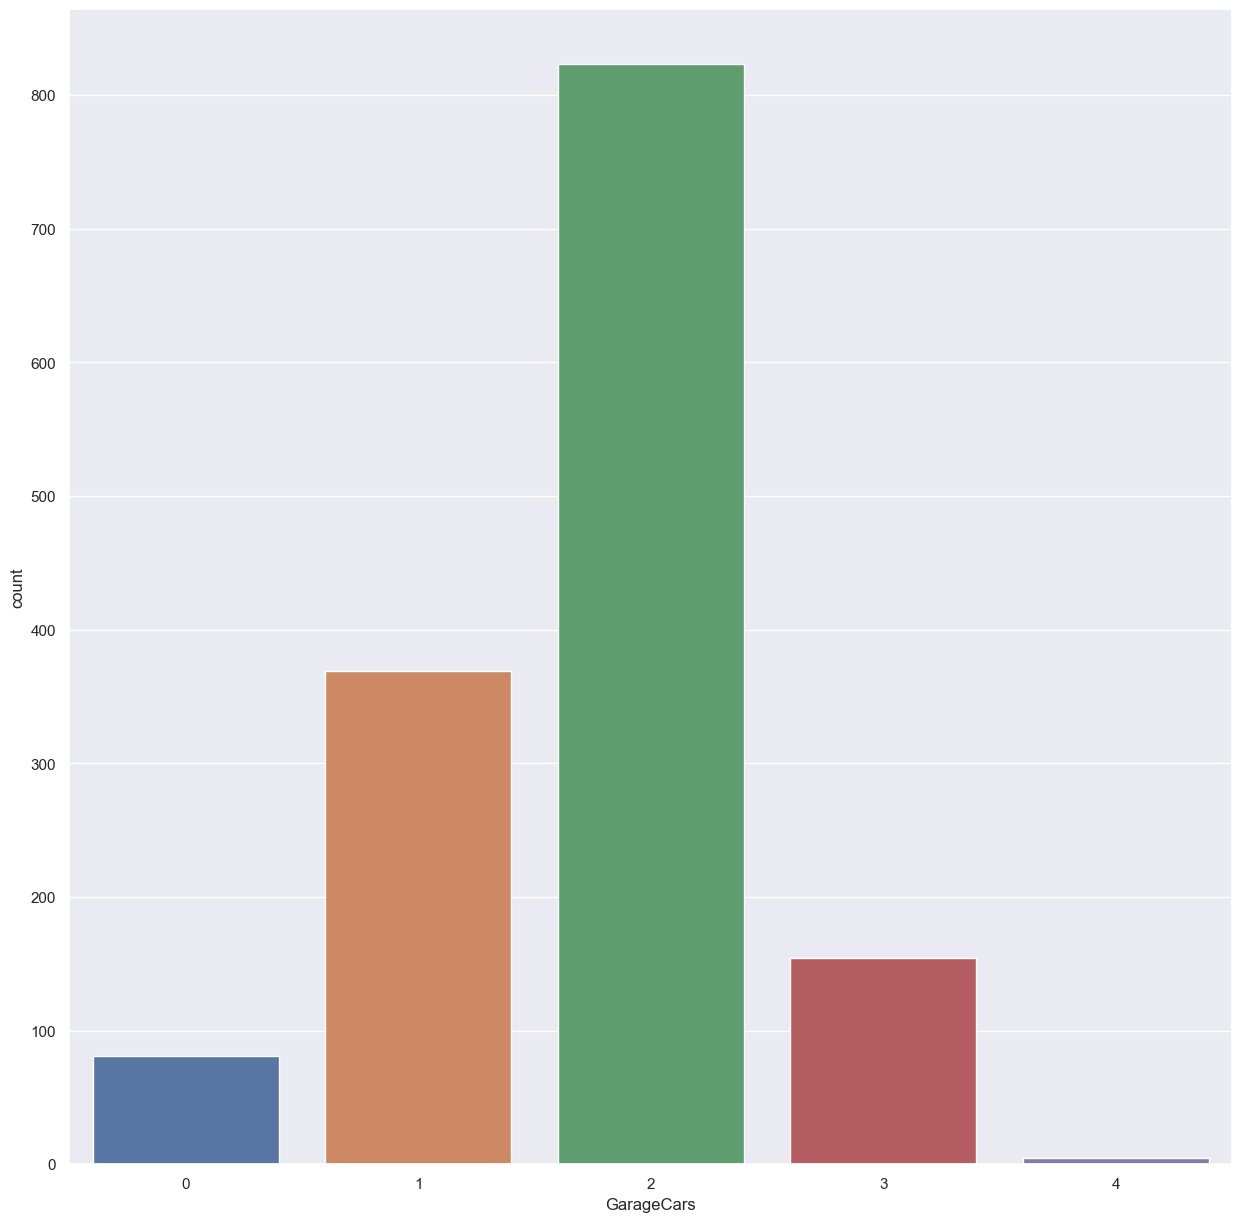

-------------------------------------------------------
          PoolArea  Ratio
PoolArea                 
0             1426 99.581
512              1  0.070
648              1  0.070
576              1  0.070
480              1  0.070
519              1  0.070
738              1  0.070


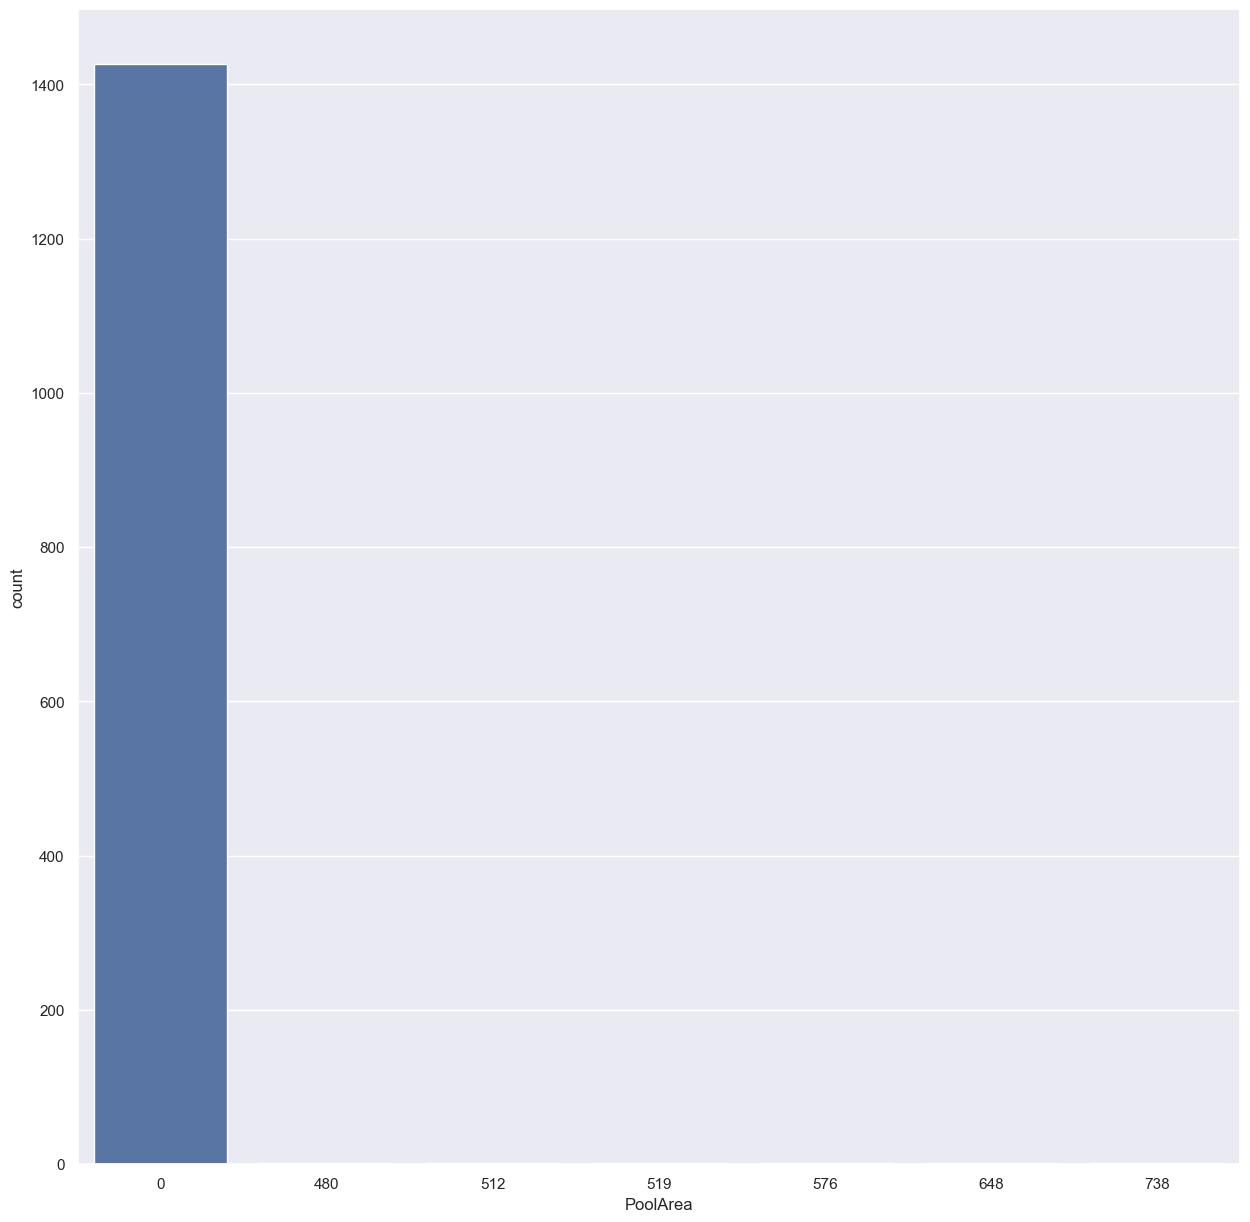

-------------------------------------------------------
        YrSold  Ratio
YrSold               
2009       330 23.045
2007       322 22.486
2006       307 21.439
2008       301 21.020
2010       172 12.011


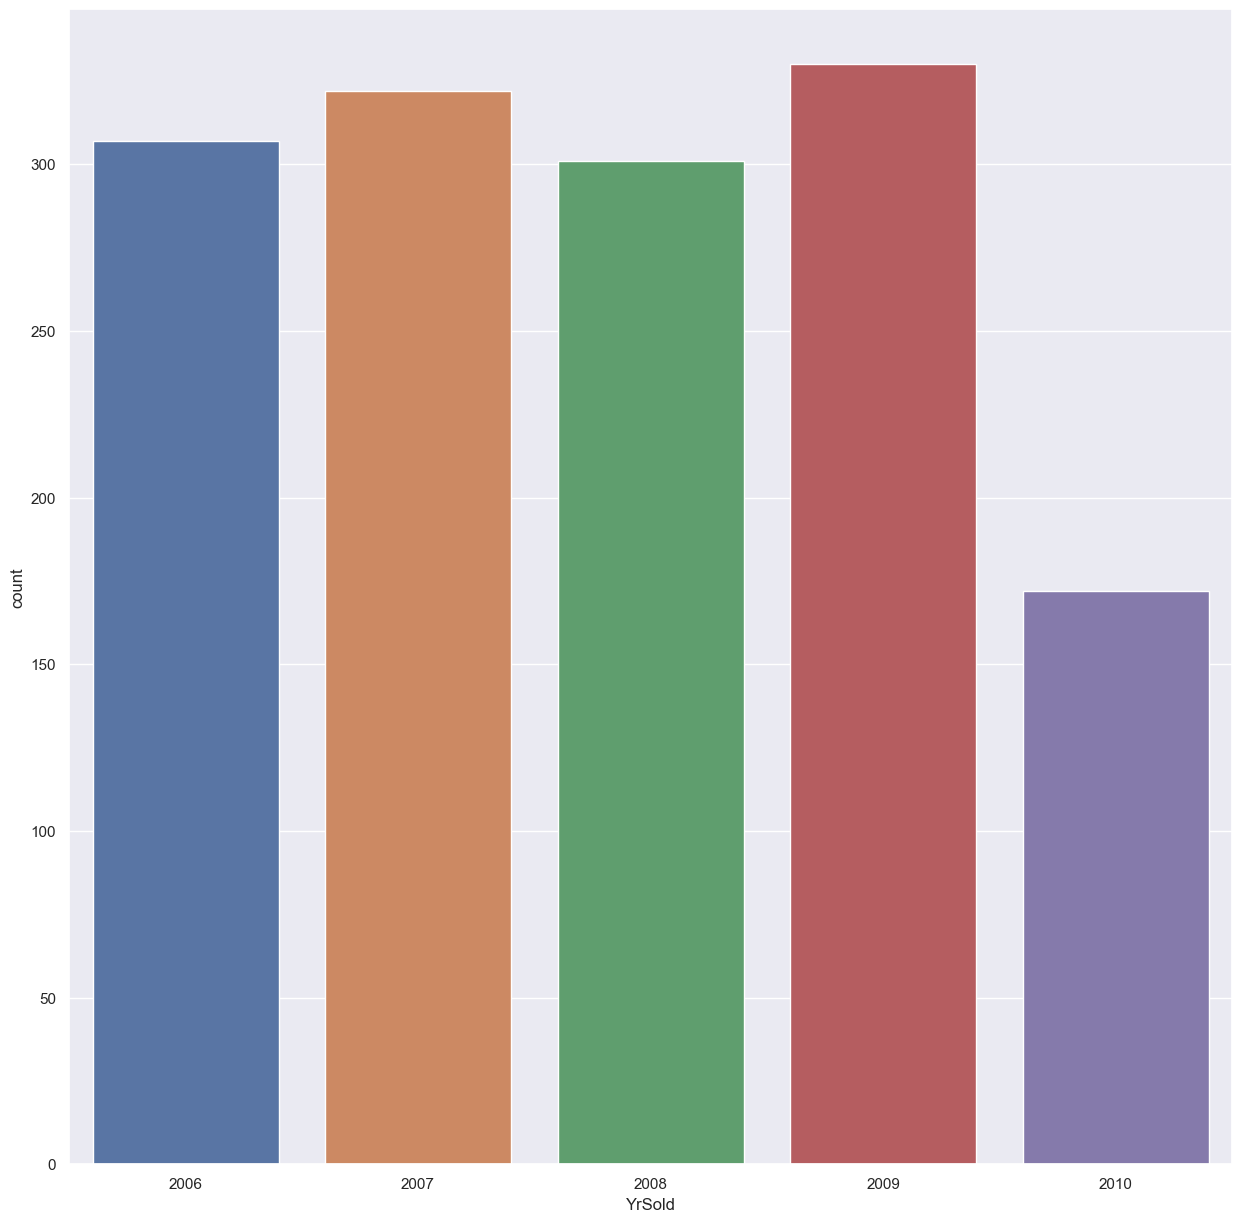

In [89]:
for col in cat_cols:
    cat_summary(df, col, True)

### Analysis of Numerical Variables (Sayısal Değişken Analizi)

In [90]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.70, 0.8, 0.9, 0.95, 0.99, 1]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count   1432.000
mean     731.731
std      422.265
min        1.000
5%        73.550
10%      145.100
20%      293.200
25%      365.750
30%      438.300
40%      586.400
50%      733.500
60%      879.600
70%     1023.700
80%     1168.800
90%     1314.900
95%     1388.450
99%     1445.690
100%    1460.000
max     1460.000
Name: Id, dtype: float64


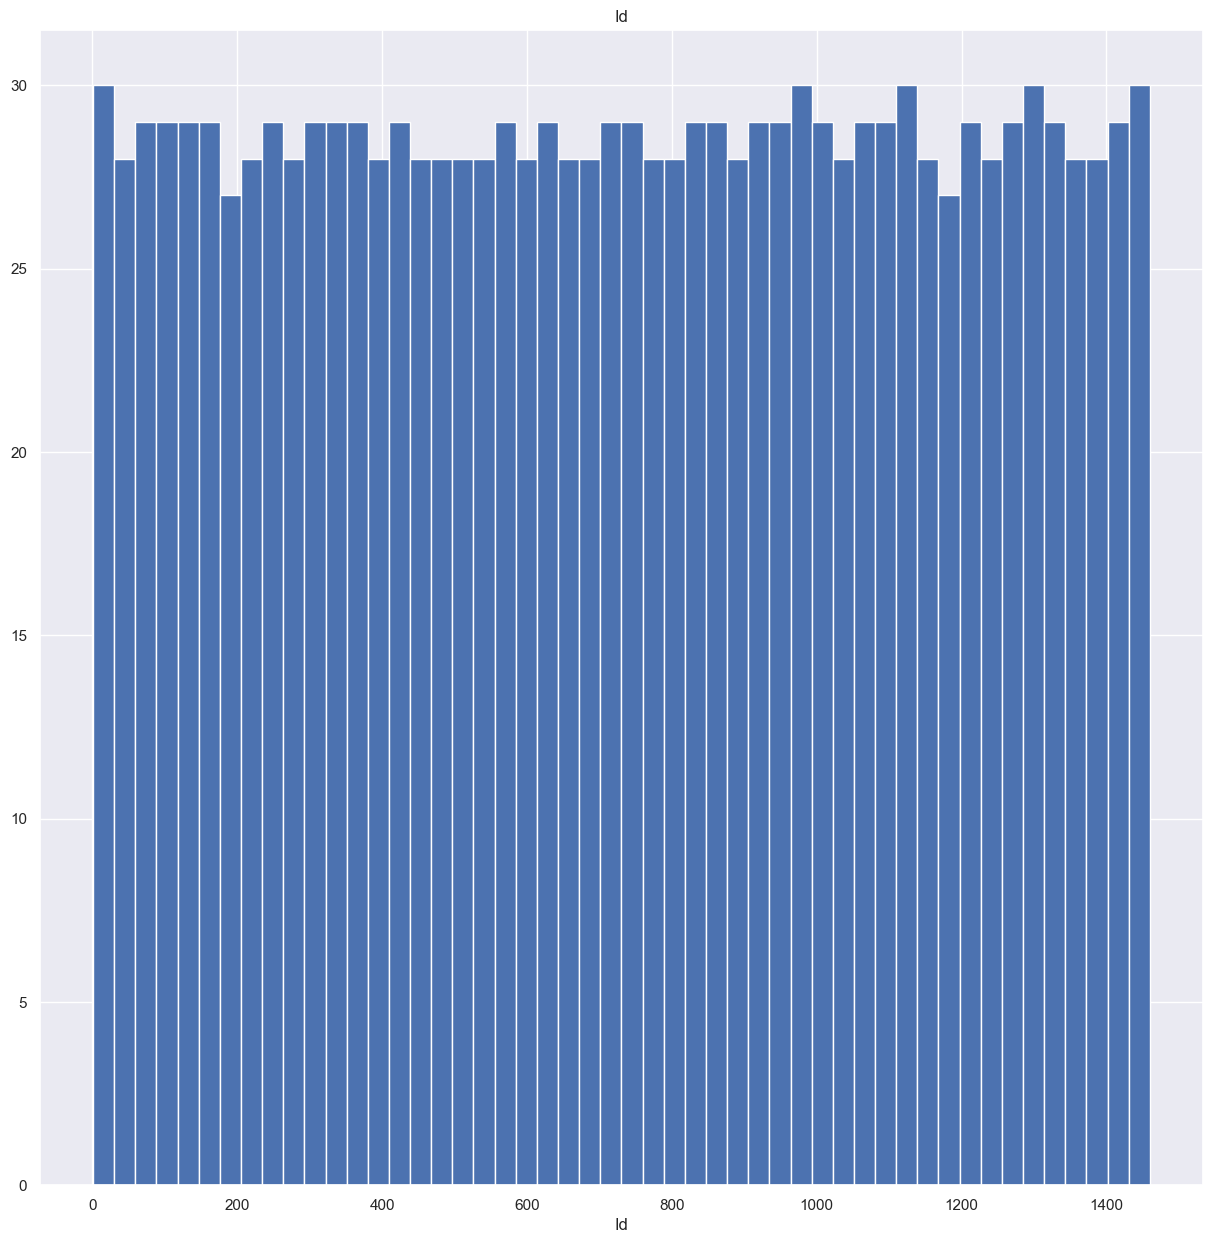

count   1432.000
mean      57.112
std       42.596
min       20.000
5%        20.000
10%       20.000
20%       20.000
25%       20.000
30%       20.000
40%       30.000
50%       50.000
60%       60.000
70%       60.000
80%       80.000
90%      120.000
95%      160.000
99%      190.000
100%     190.000
max      190.000
Name: MSSubClass, dtype: float64


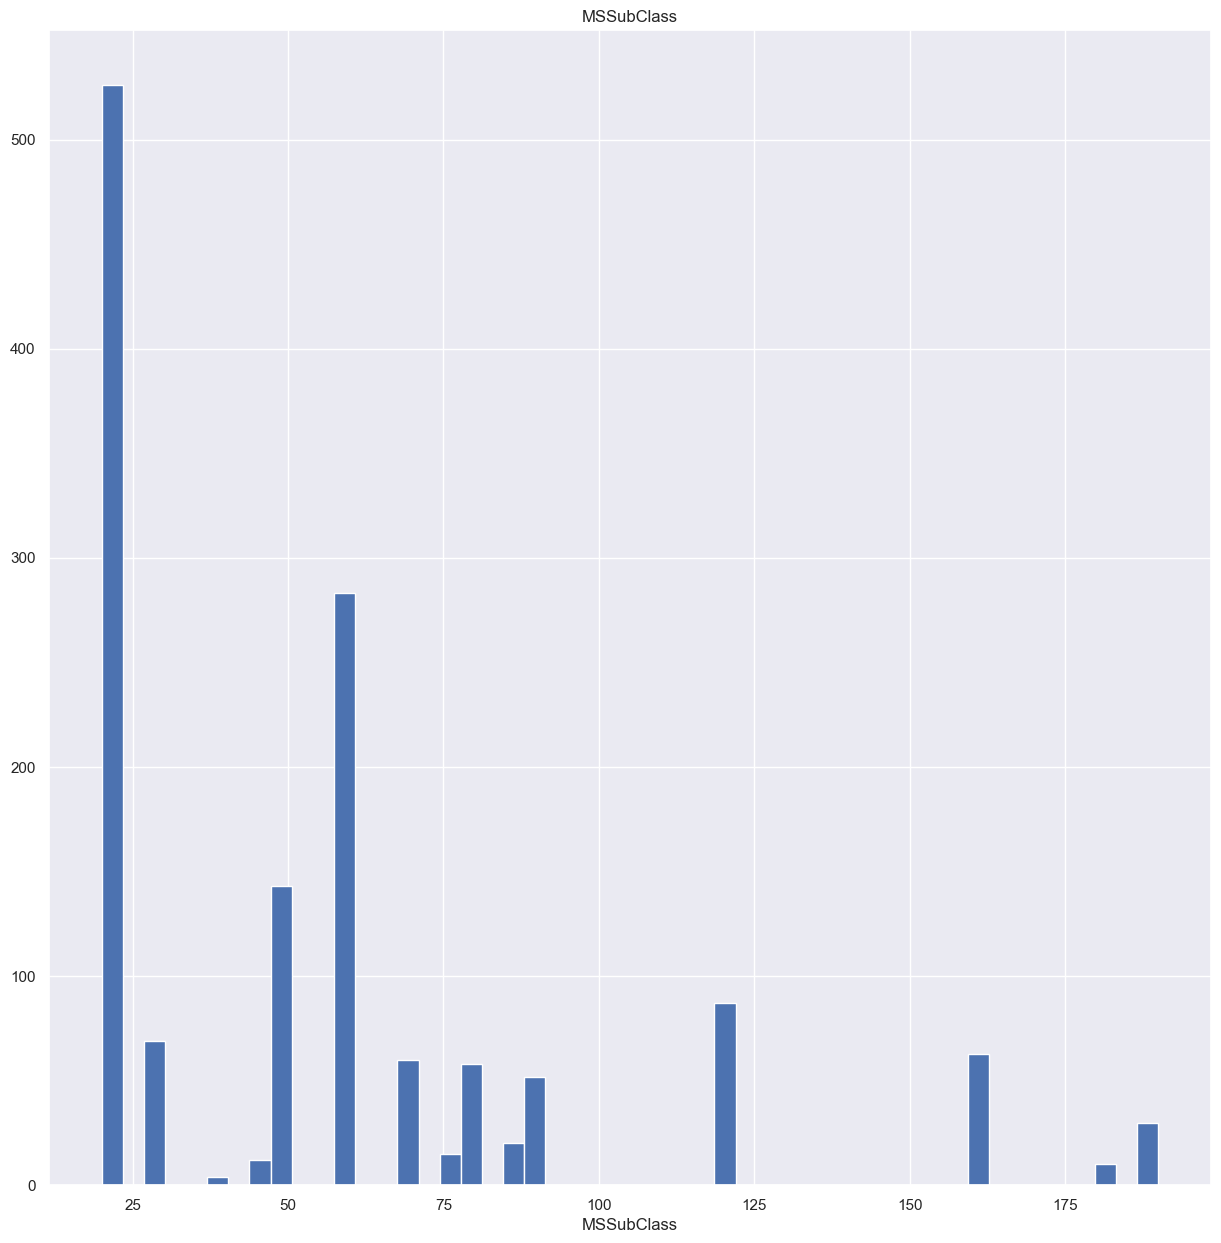

count   1175.000
mean      69.557
std       23.891
min       21.000
5%        34.000
10%       43.000
20%       53.000
25%       59.000
30%       60.000
40%       63.000
50%       69.000
60%       73.000
70%       78.800
80%       84.200
90%       94.000
95%      105.000
99%      138.520
100%     313.000
max      313.000
Name: LotFrontage, dtype: float64


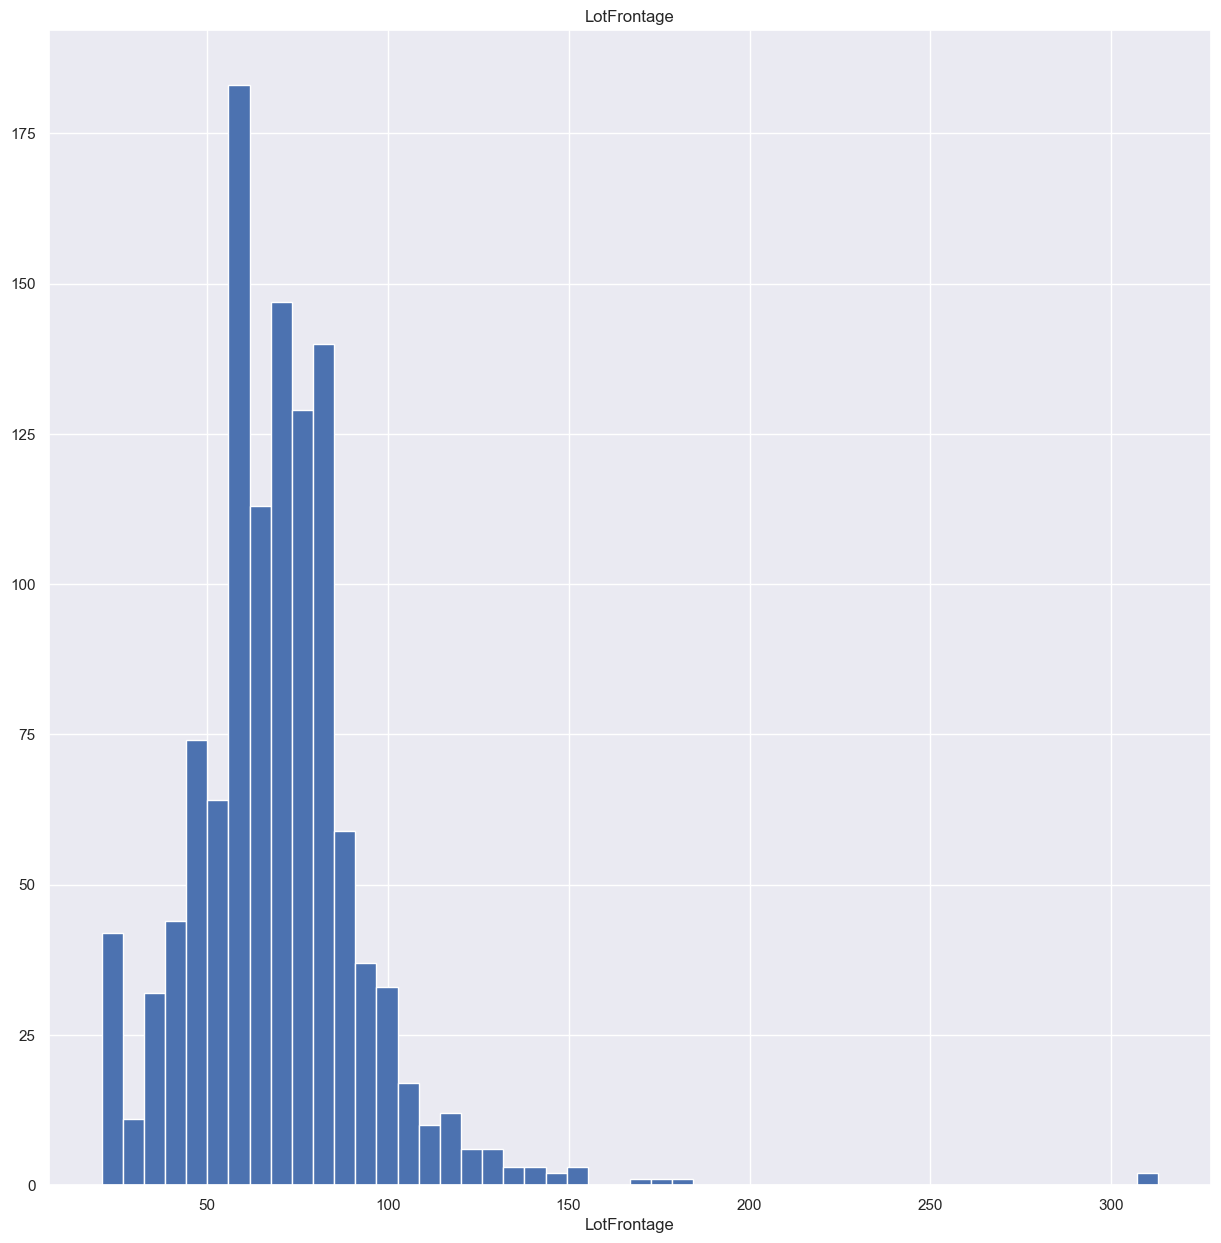

count     1432.000
mean     10363.352
std       9917.557
min       1300.000
5%        3230.000
10%       5000.000
20%       7035.600
25%       7500.000
30%       8000.000
40%       8762.000
50%       9375.000
60%      10137.600
70%      10919.400
80%      12089.000
90%      14142.000
95%      16830.750
99%      34983.270
100%    215245.000
max     215245.000
Name: LotArea, dtype: float64


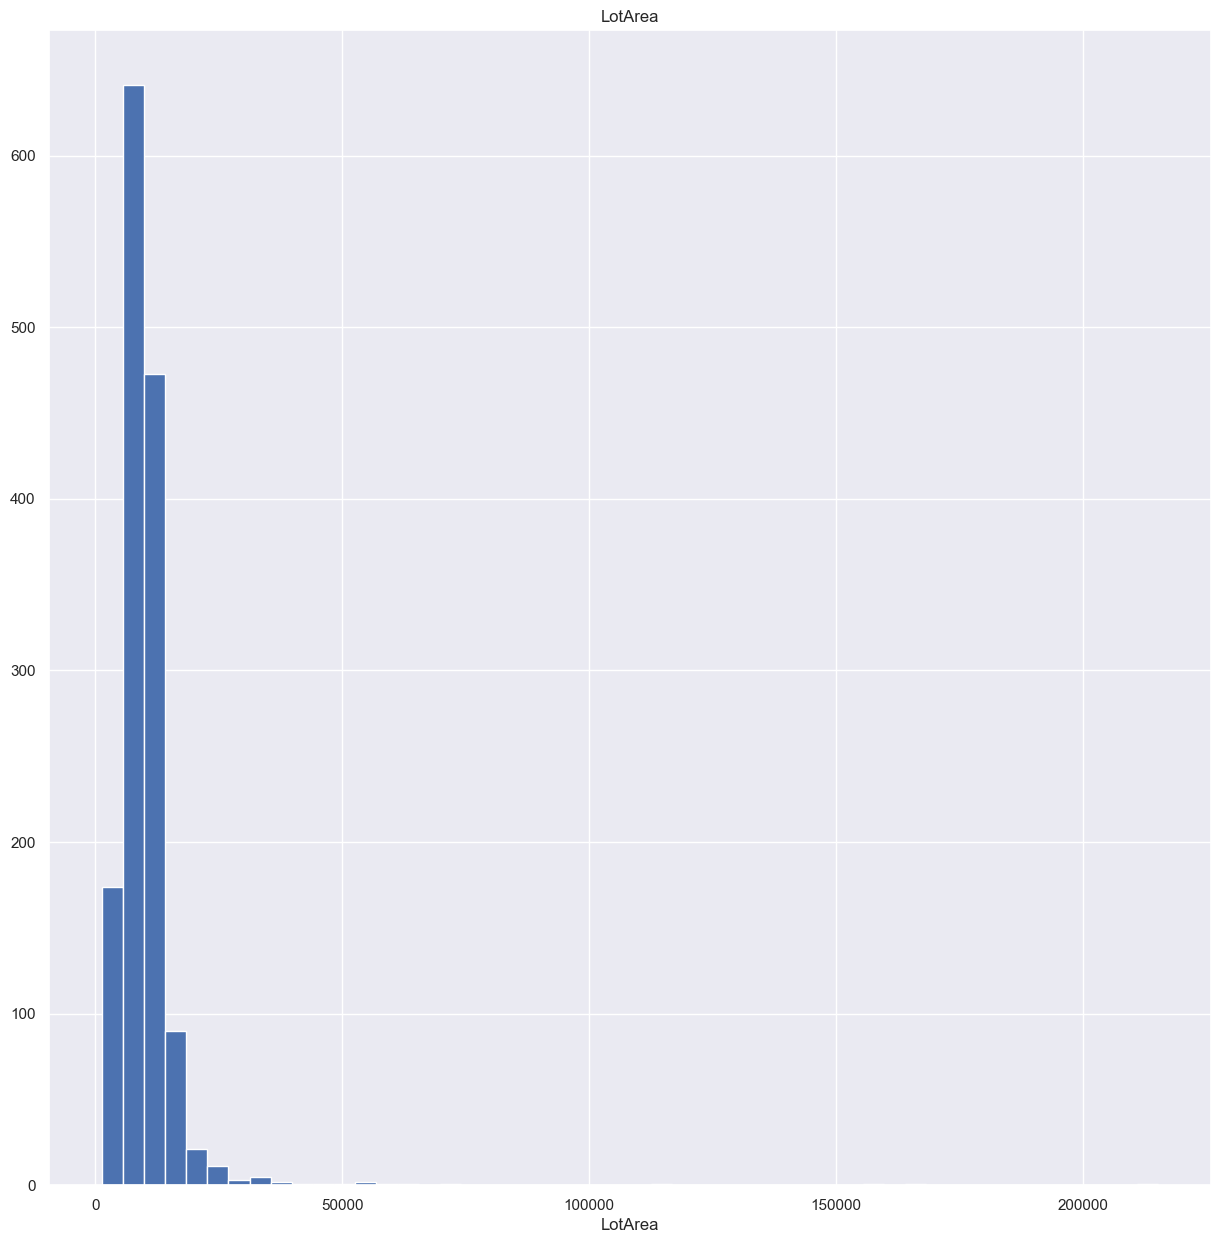

count   1432.000
mean       6.041
std        1.325
min        1.000
5%         4.000
10%        5.000
20%        5.000
25%        5.000
30%        5.000
40%        6.000
50%        6.000
60%        6.000
70%        7.000
80%        7.000
90%        8.000
95%        8.000
99%        9.000
100%      10.000
max       10.000
Name: OverallQual, dtype: float64


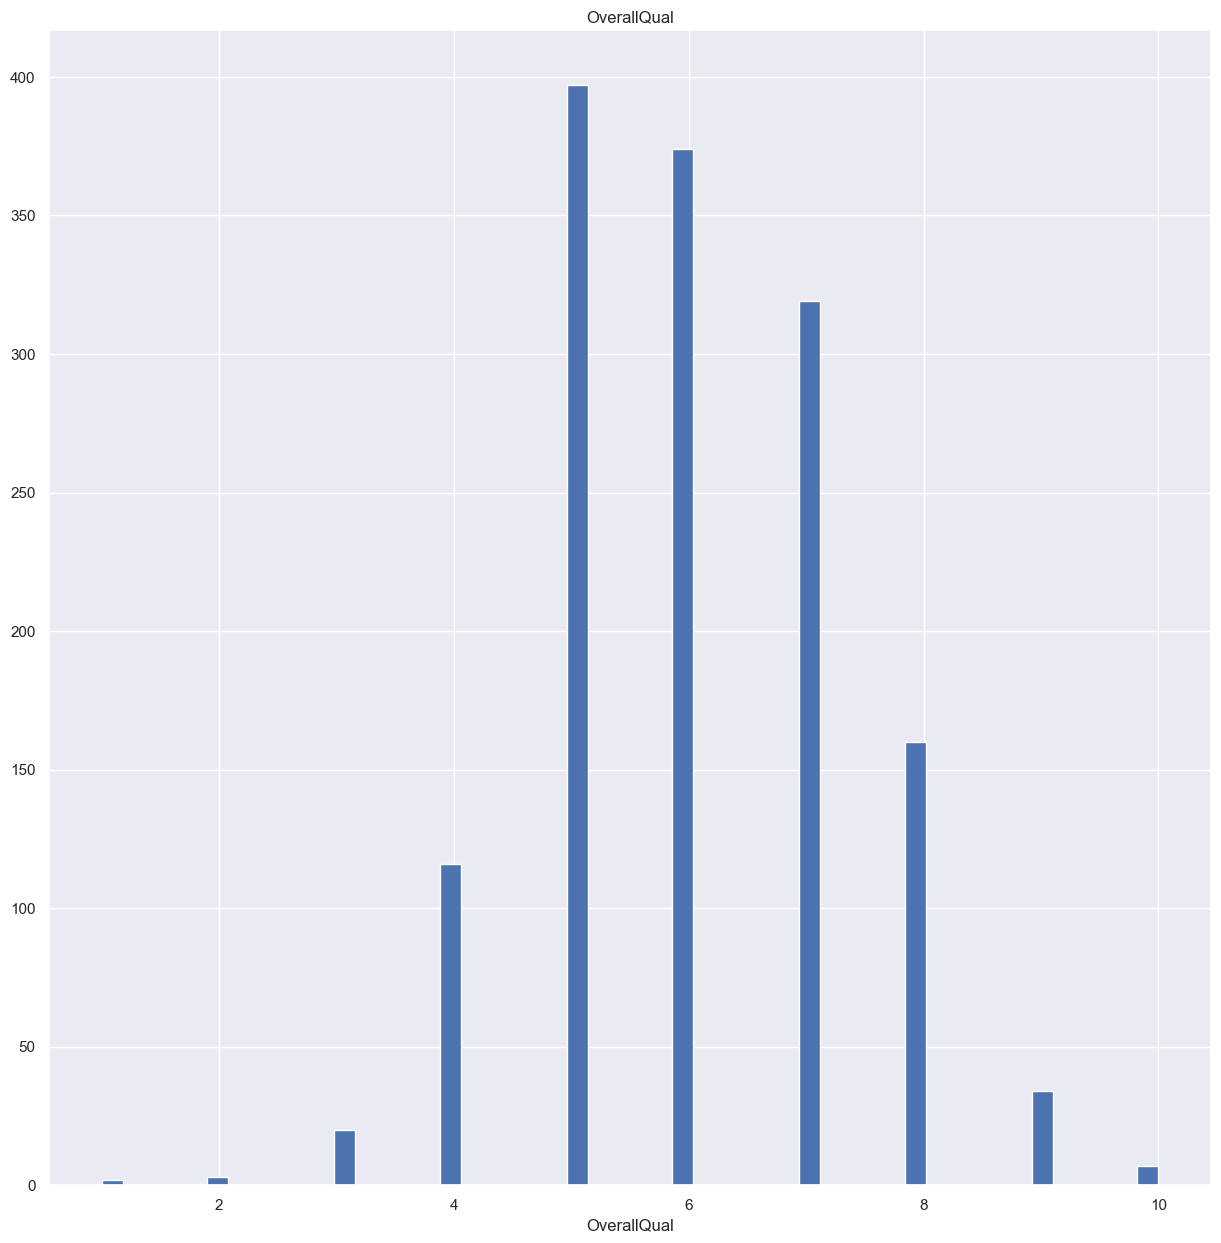

count   1432.000
mean    1970.721
std       30.093
min     1872.000
5%      1916.000
10%     1924.000
20%     1947.000
25%     1953.000
30%     1957.000
40%     1965.000
50%     1972.000
60%     1981.000
70%     1997.000
80%     2003.000
90%     2005.900
95%     2007.000
99%     2009.000
100%    2010.000
max     2010.000
Name: YearBuilt, dtype: float64


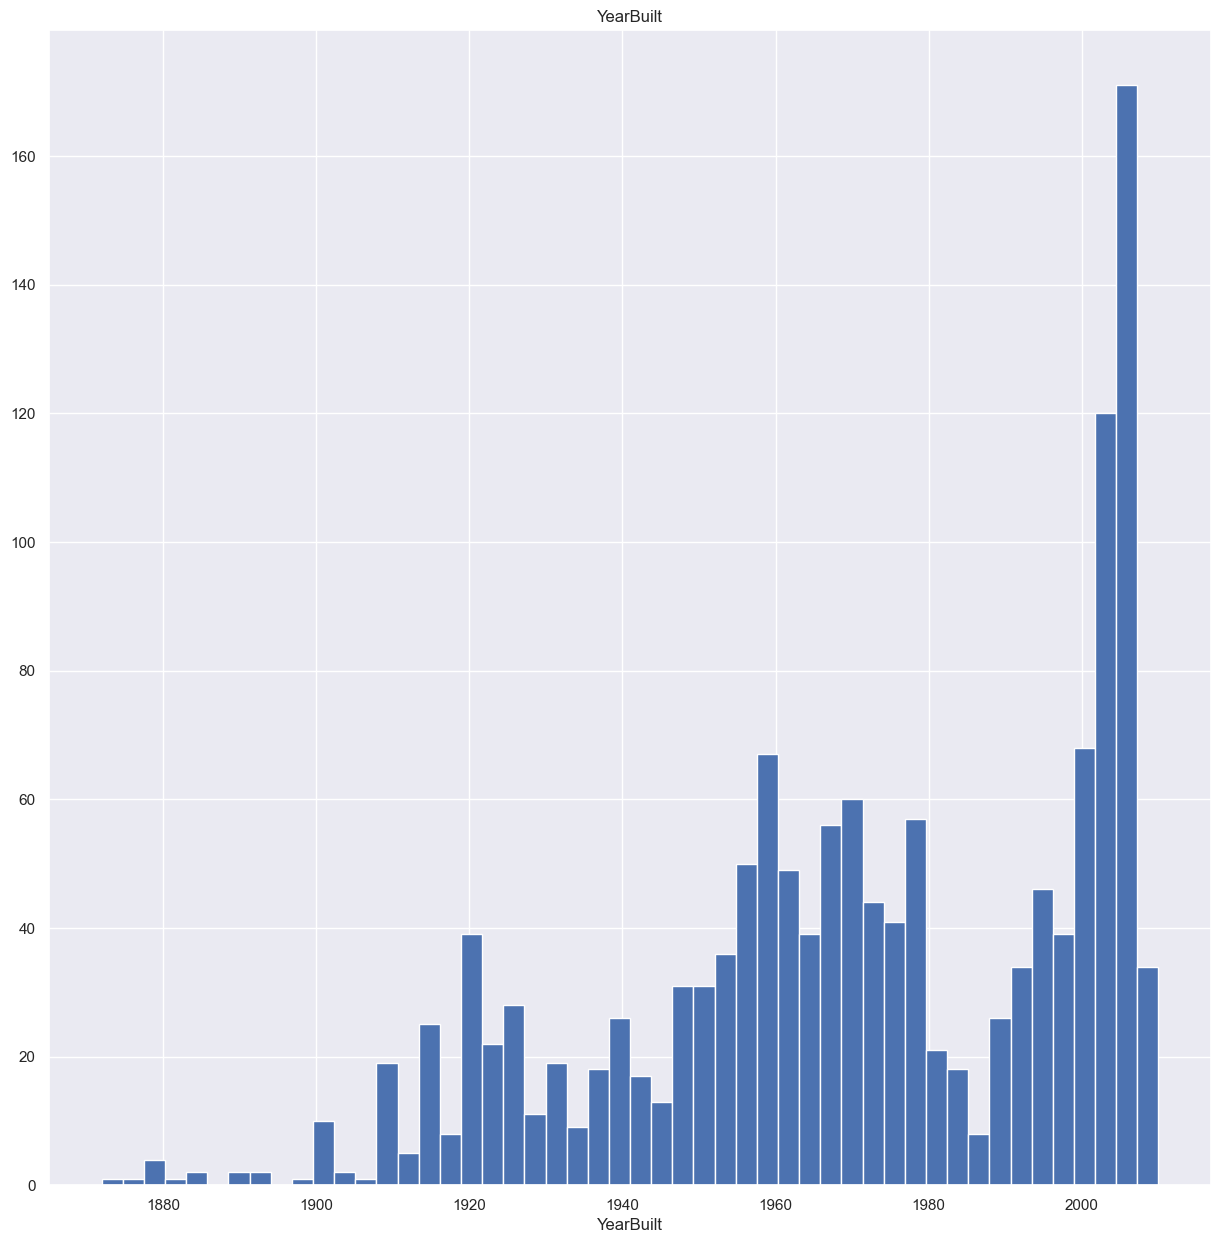

count   1432.000
mean    1984.494
std       20.659
min     1950.000
5%      1950.000
10%     1950.000
20%     1961.000
25%     1966.000
30%     1970.000
40%     1979.000
50%     1993.000
60%     1998.000
70%     2002.000
80%     2005.000
90%     2006.000
95%     2007.000
99%     2009.000
100%    2010.000
max     2010.000
Name: YearRemodAdd, dtype: float64


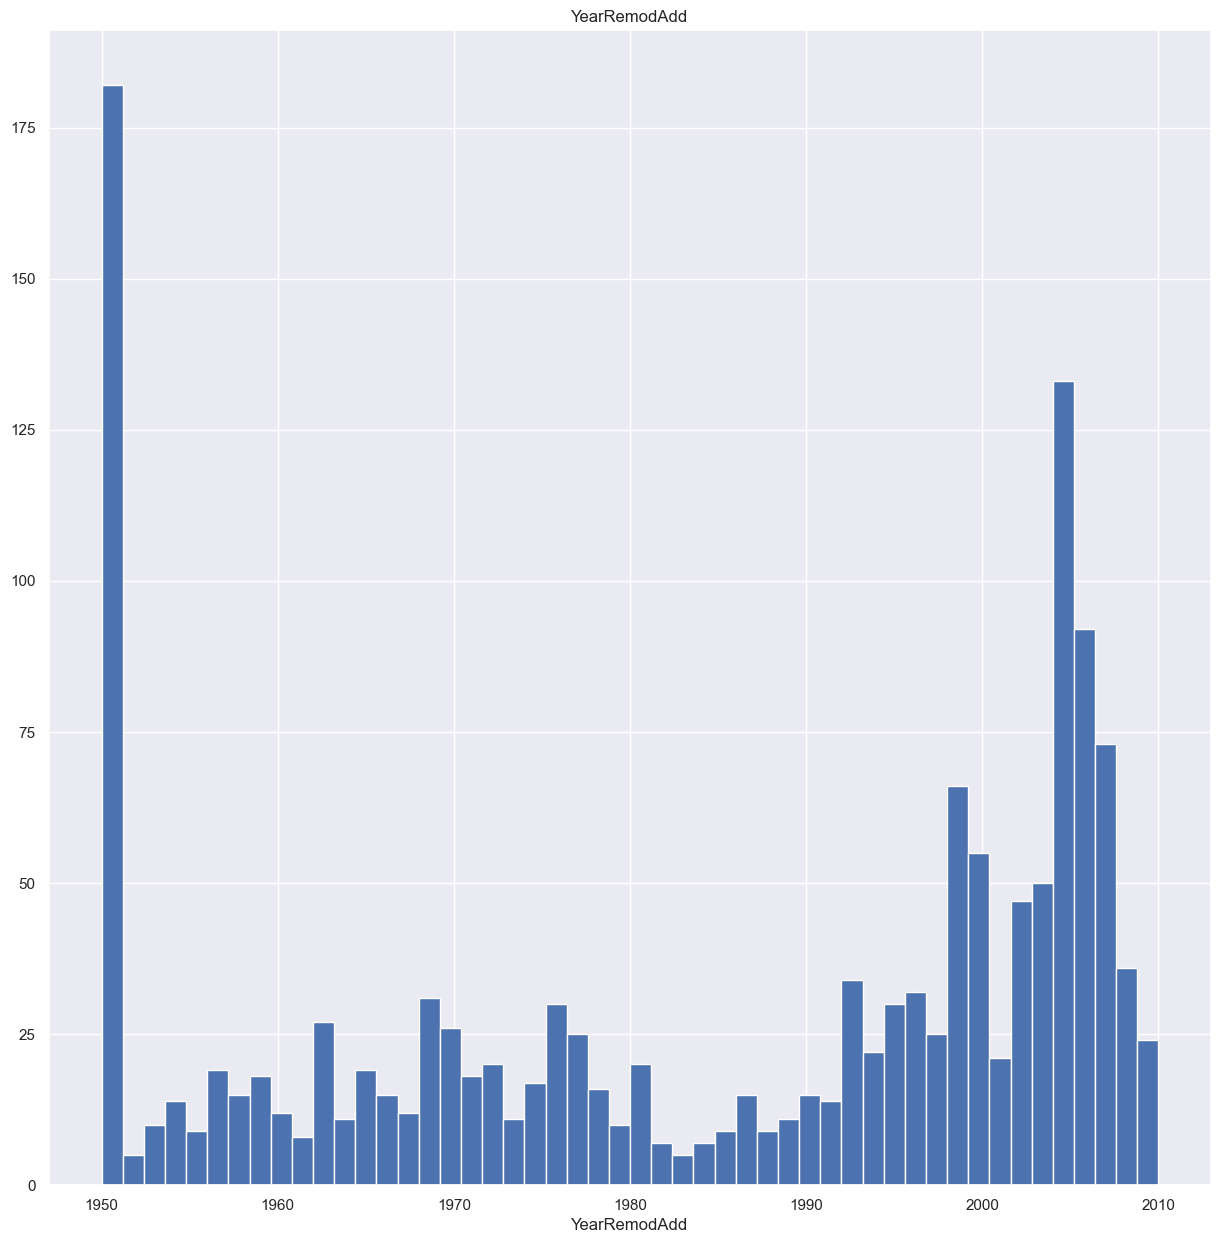

count   1425.000
mean      96.206
std      167.329
min        0.000
5%         0.000
10%        0.000
20%        0.000
25%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%      108.000
80%      194.400
90%      312.000
95%      431.200
99%      754.560
100%    1600.000
max     1600.000
Name: MasVnrArea, dtype: float64


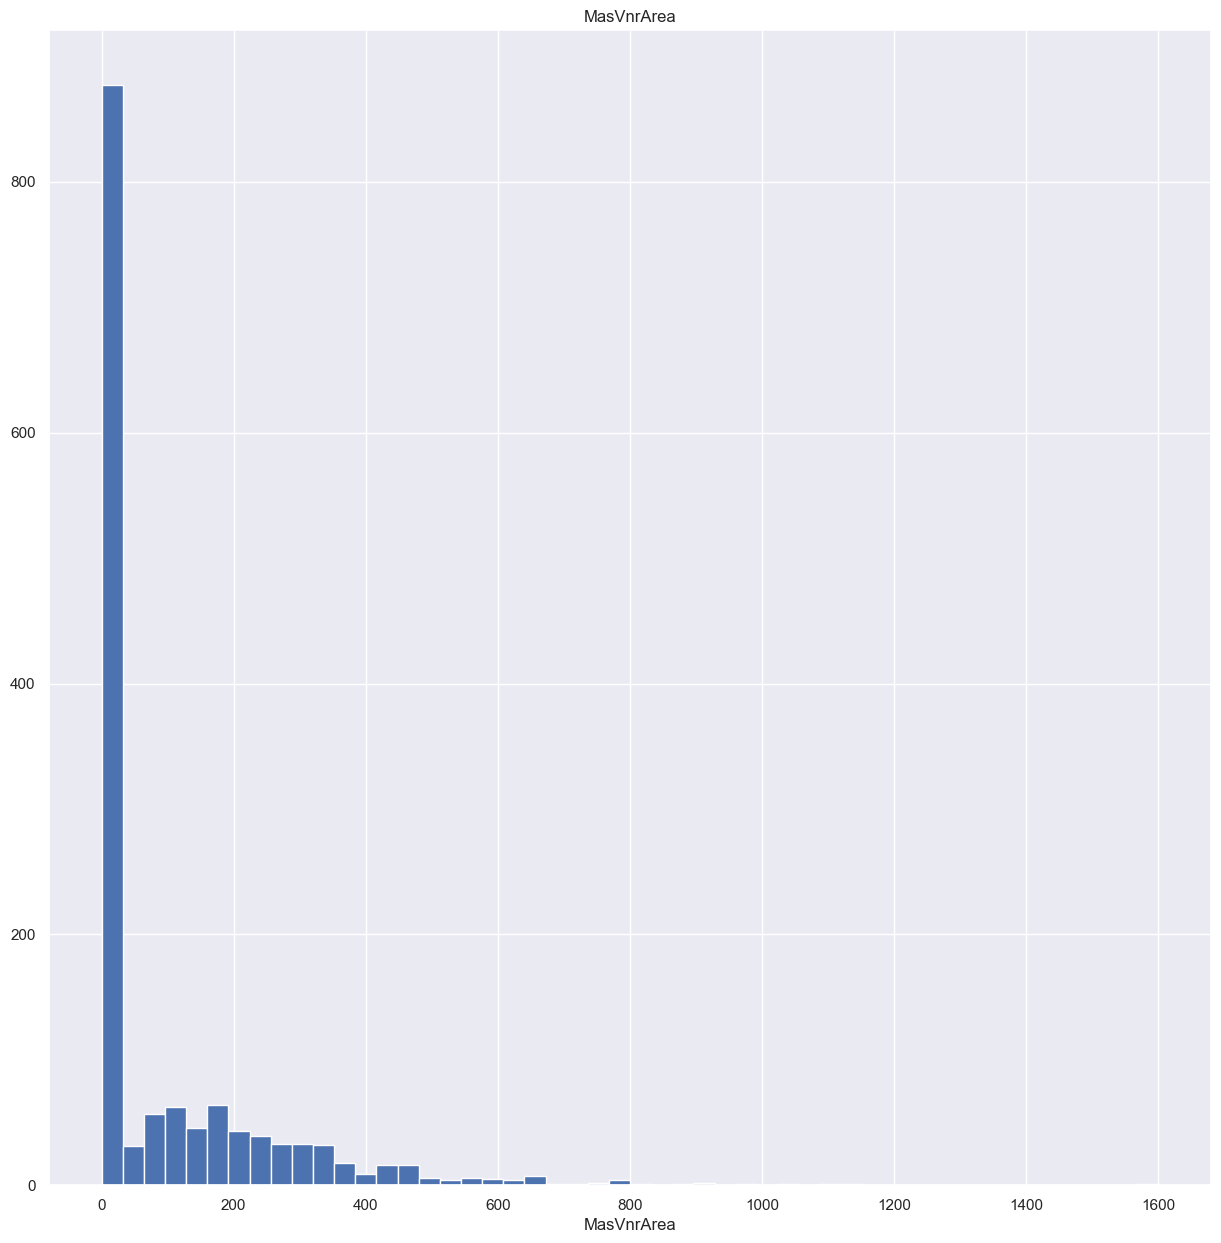

count   1432.000
mean     430.492
std      441.542
min        0.000
5%         0.000
10%        0.000
20%        0.000
25%        0.000
30%        0.000
40%      210.000
50%      377.500
60%      513.000
70%      643.700
80%      784.000
90%     1035.600
95%     1219.000
99%     1516.450
100%    5644.000
max     5644.000
Name: BsmtFinSF1, dtype: float64


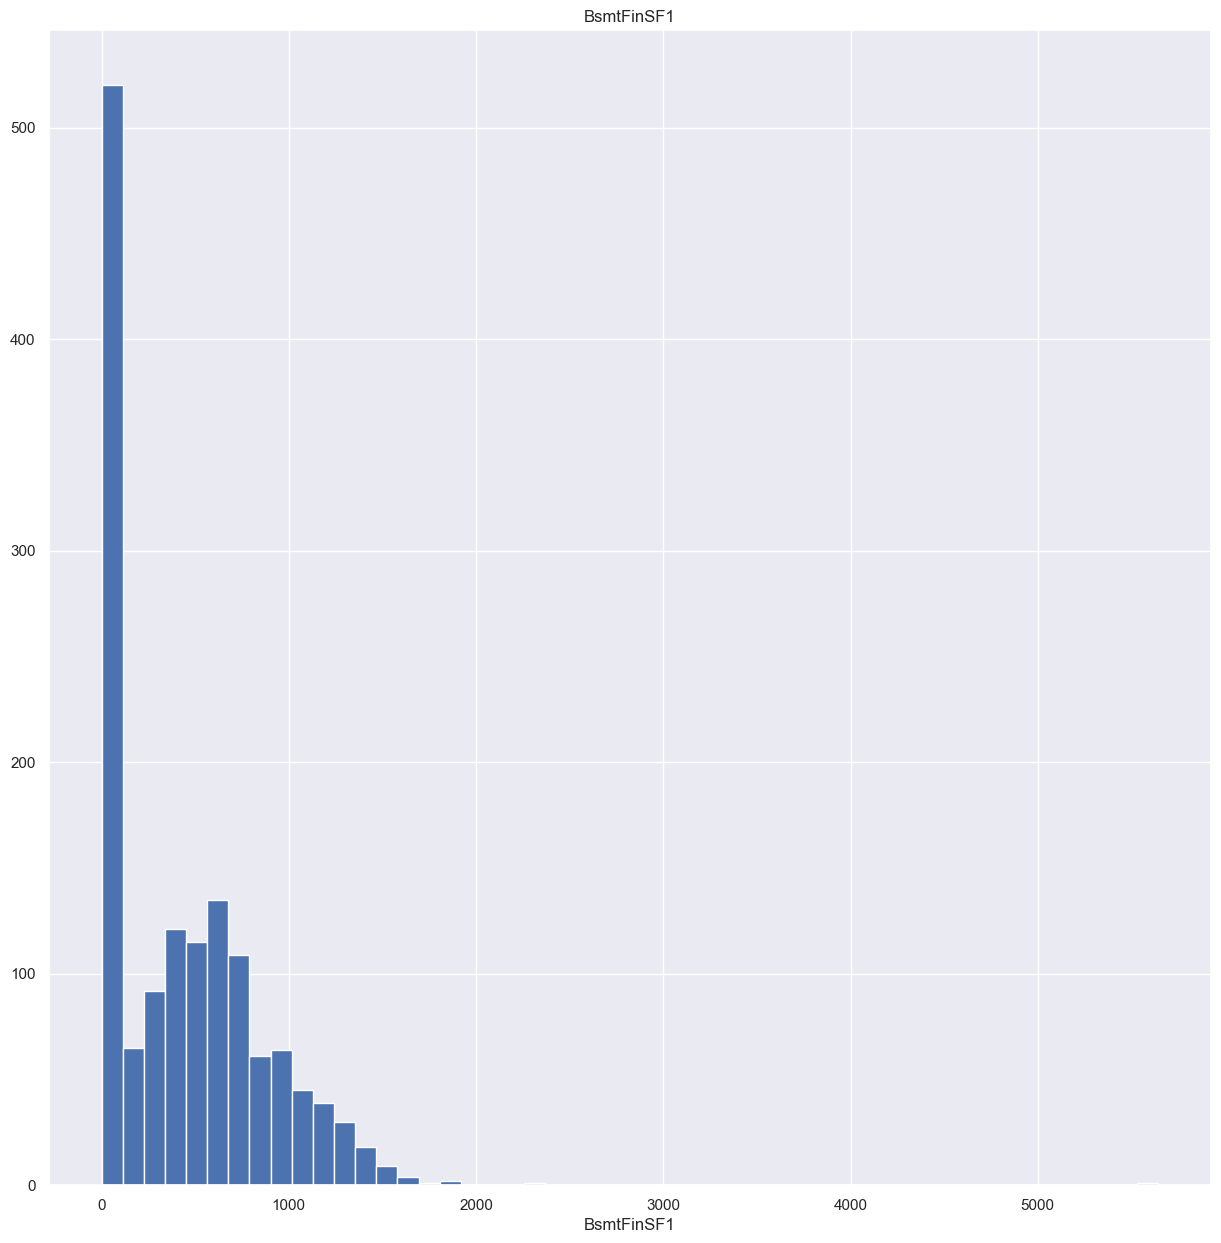

count   1432.000
mean      46.957
std      162.209
min        0.000
5%         0.000
10%        0.000
20%        0.000
25%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      118.800
95%      397.800
99%      835.420
100%    1474.000
max     1474.000
Name: BsmtFinSF2, dtype: float64


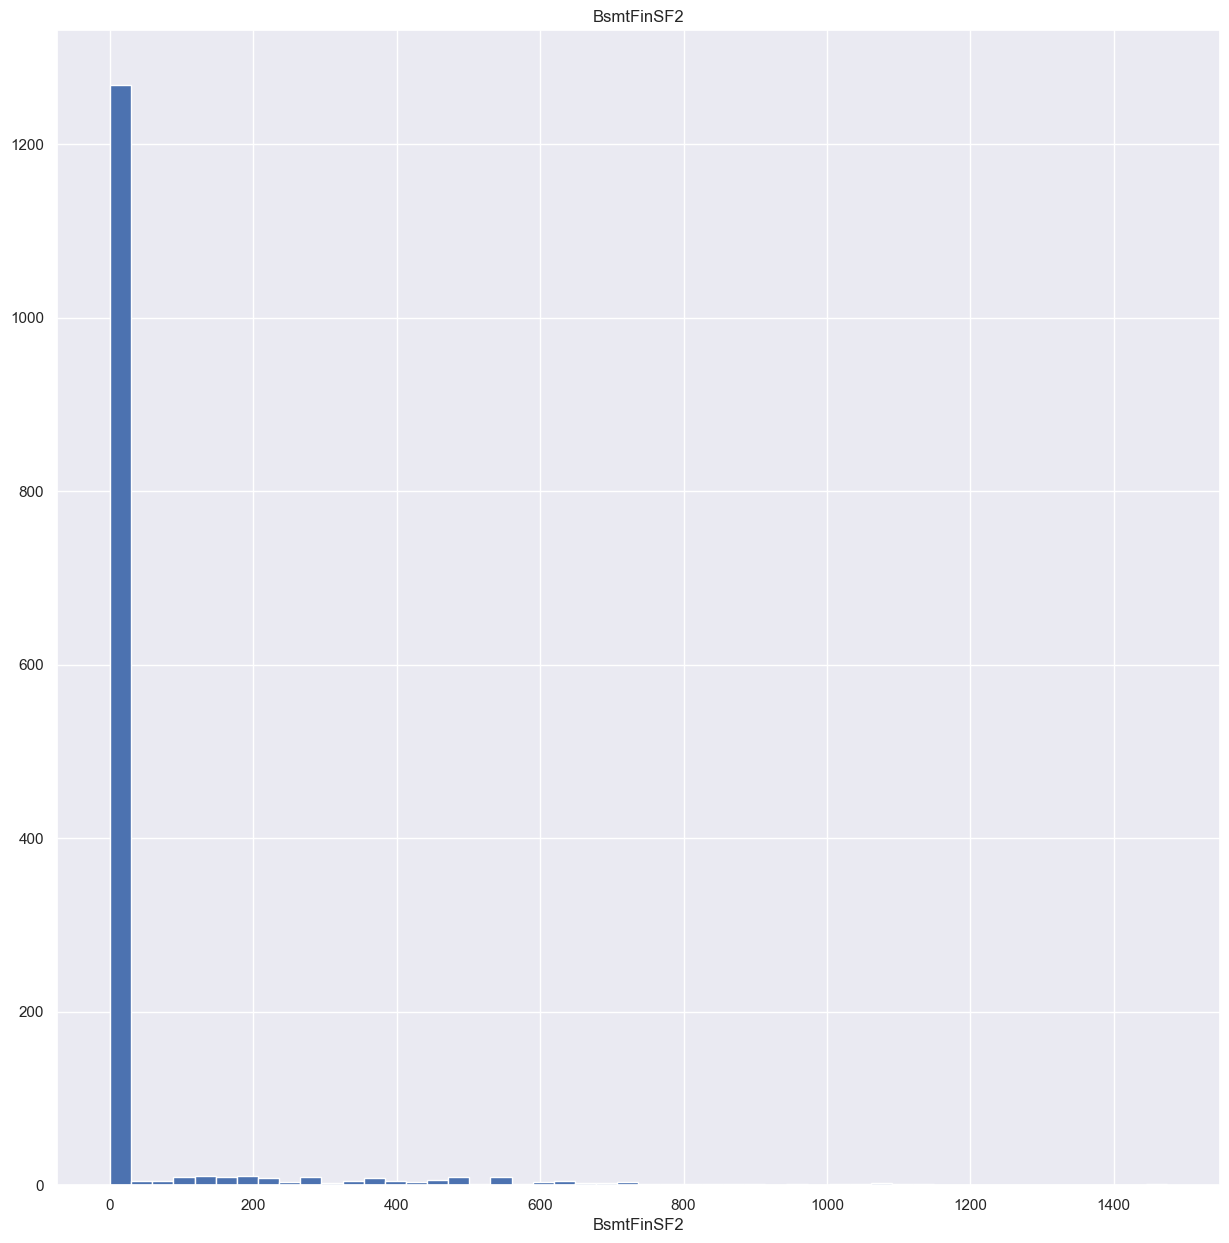

count   1432.000
mean     562.119
std      436.354
min        0.000
5%         0.000
10%       70.200
20%      170.200
25%      218.750
30%      278.000
40%      372.000
50%      474.000
60%      602.000
70%      732.700
80%      893.800
90%     1211.100
95%     1438.700
99%     1772.140
100%    2336.000
max     2336.000
Name: BsmtUnfSF, dtype: float64


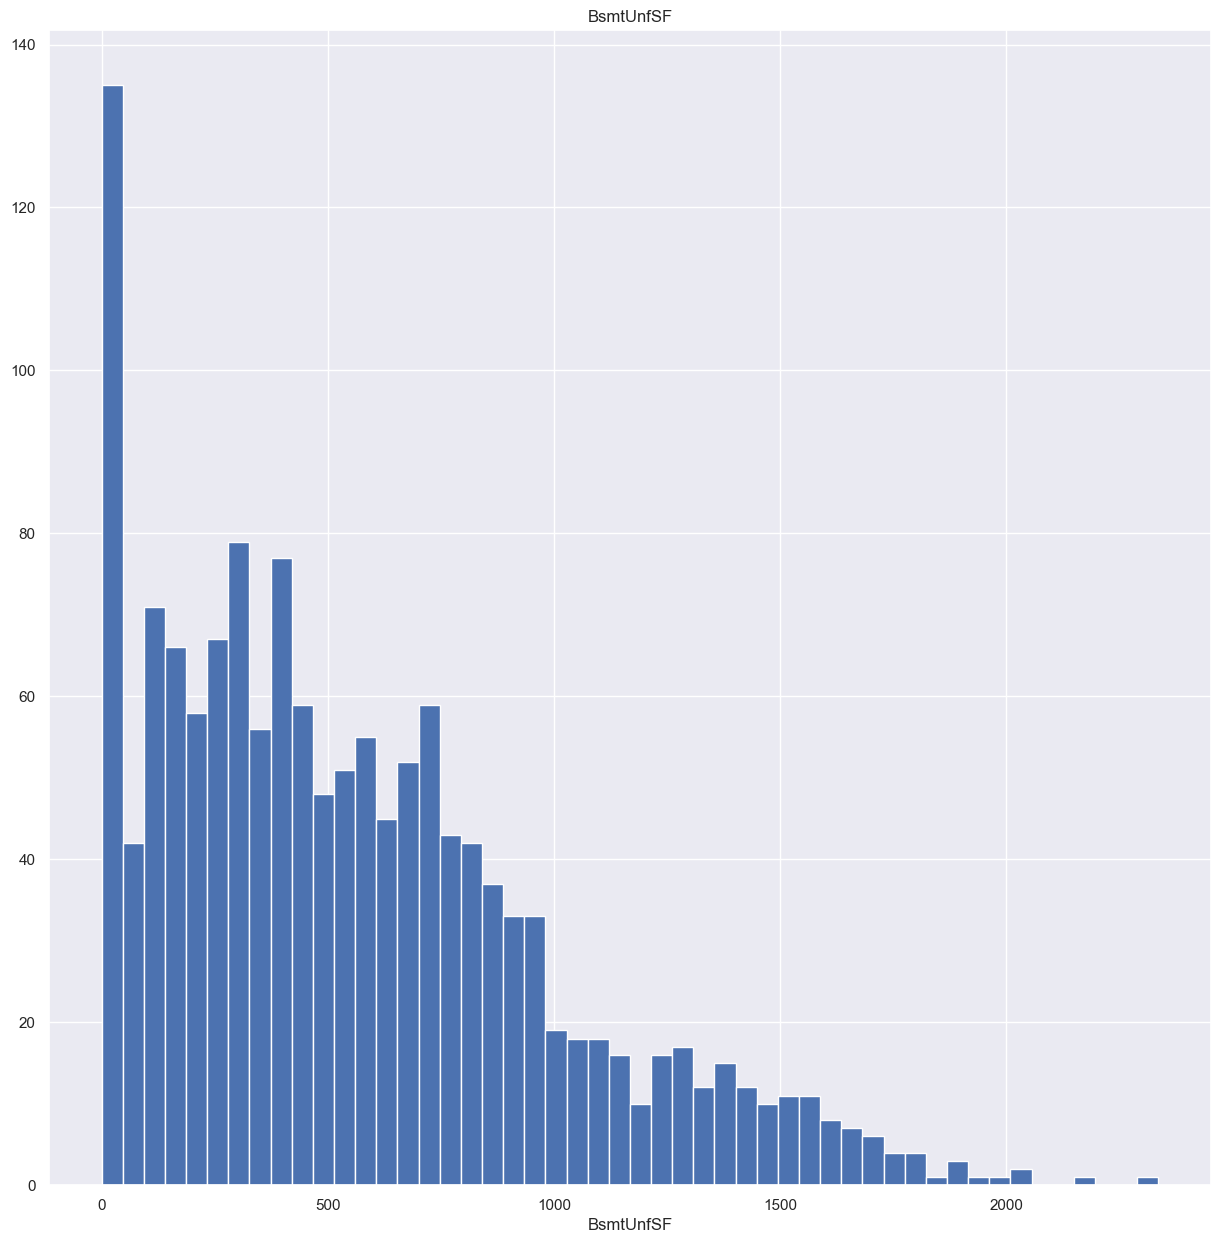

count   1432.000
mean    1039.569
std      418.548
min        0.000
5%       505.100
10%      630.000
20%      747.000
25%      793.000
30%      832.000
40%      897.600
50%      980.500
60%     1078.000
70%     1200.000
80%     1366.400
90%     1573.000
95%     1711.350
99%     2044.760
100%    6110.000
max     6110.000
Name: TotalBsmtSF, dtype: float64


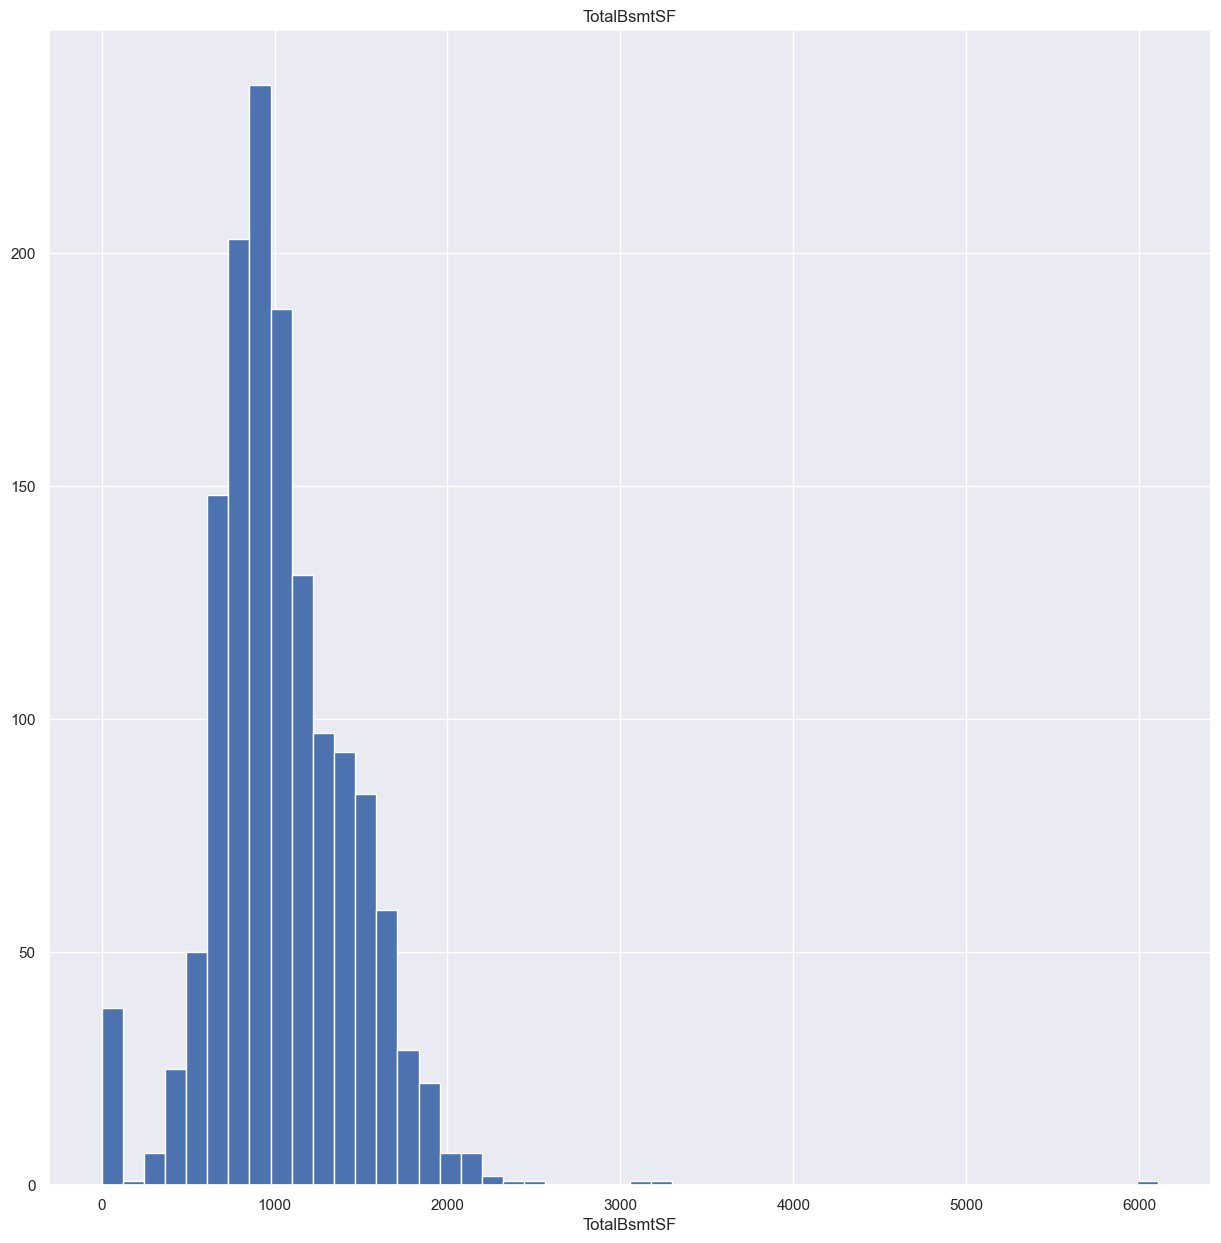

count   1432.000
mean    1146.795
std      368.837
min      334.000
5%       672.000
10%      756.000
20%      848.000
25%      876.750
30%      912.000
40%      992.400
50%     1078.500
60%     1166.000
70%     1298.000
80%     1458.400
90%     1652.000
95%     1777.350
99%     2125.280
100%    4692.000
max     4692.000
Name: 1stFlrSF, dtype: float64


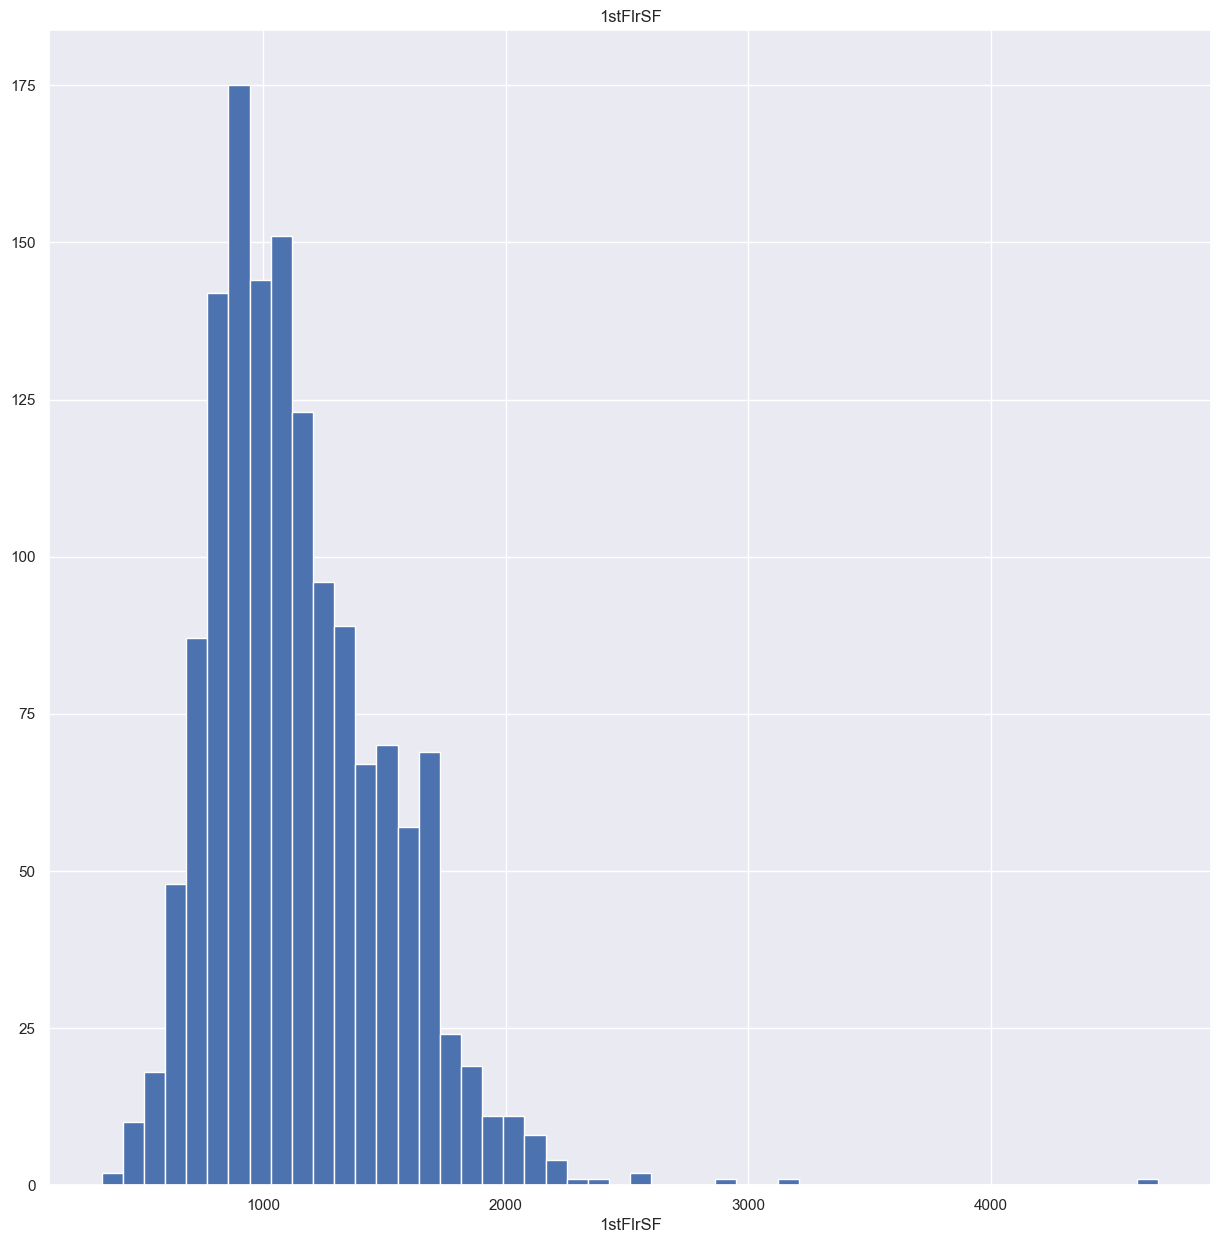

count   1432.000
mean     338.078
std      425.401
min        0.000
5%         0.000
10%        0.000
20%        0.000
25%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      440.200
70%      667.100
80%      787.800
90%      928.900
95%     1113.800
99%     1348.380
100%    1818.000
max     1818.000
Name: 2ndFlrSF, dtype: float64


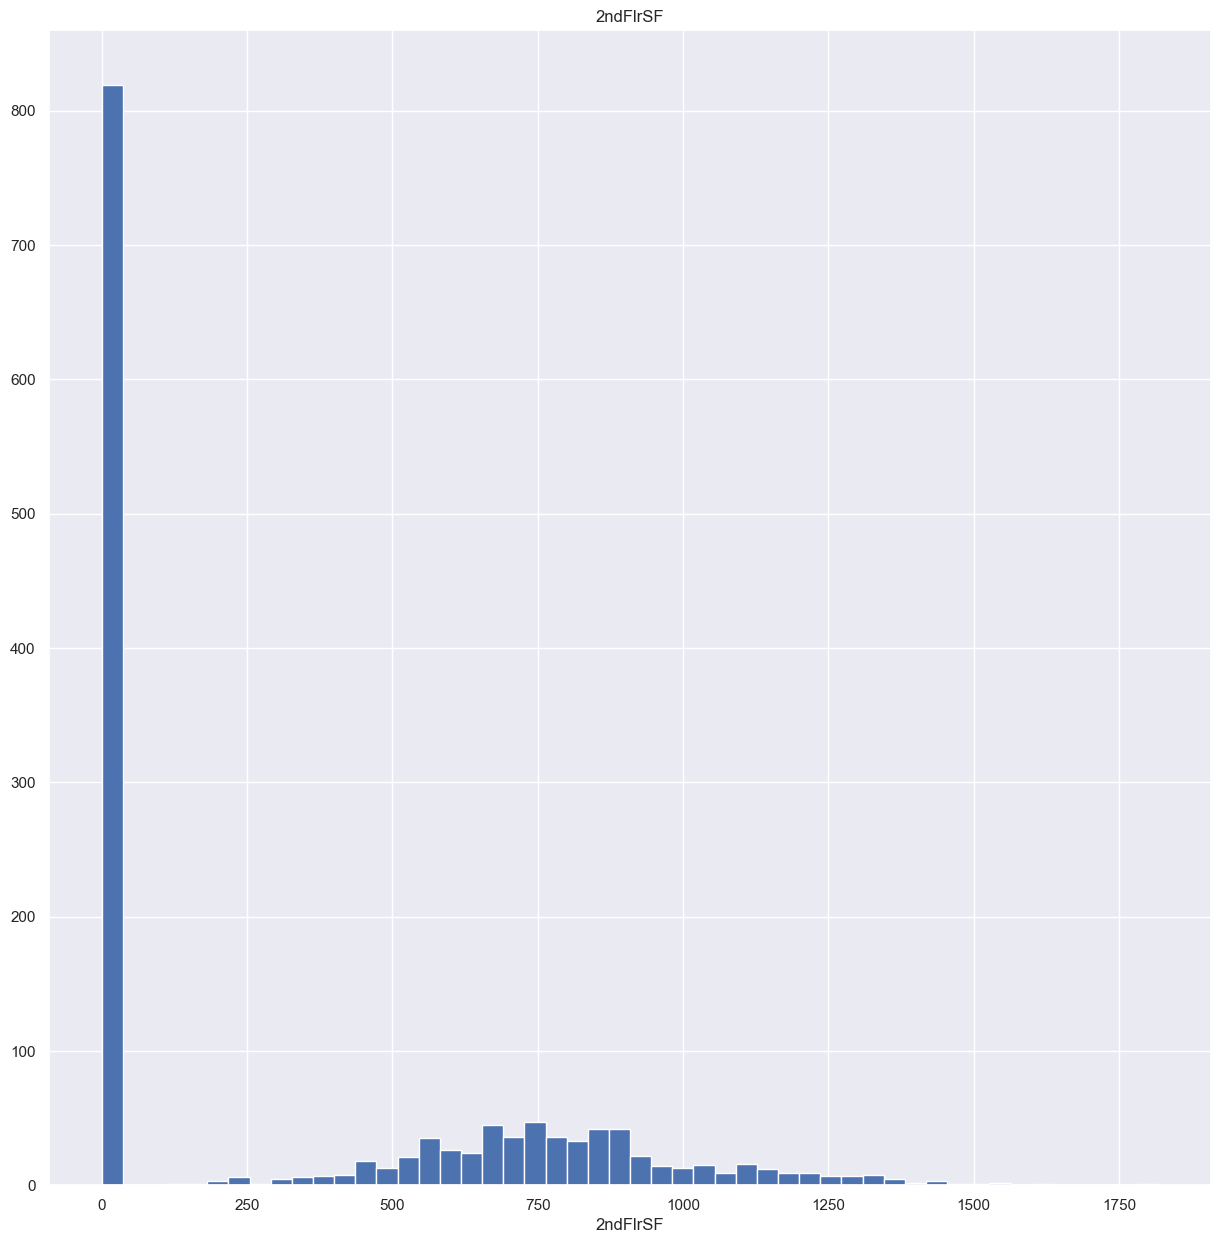

count   1432.000
mean       5.559
std       46.752
min        0.000
5%         0.000
10%        0.000
20%        0.000
25%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      320.940
100%     528.000
max      528.000
Name: LowQualFinSF, dtype: float64


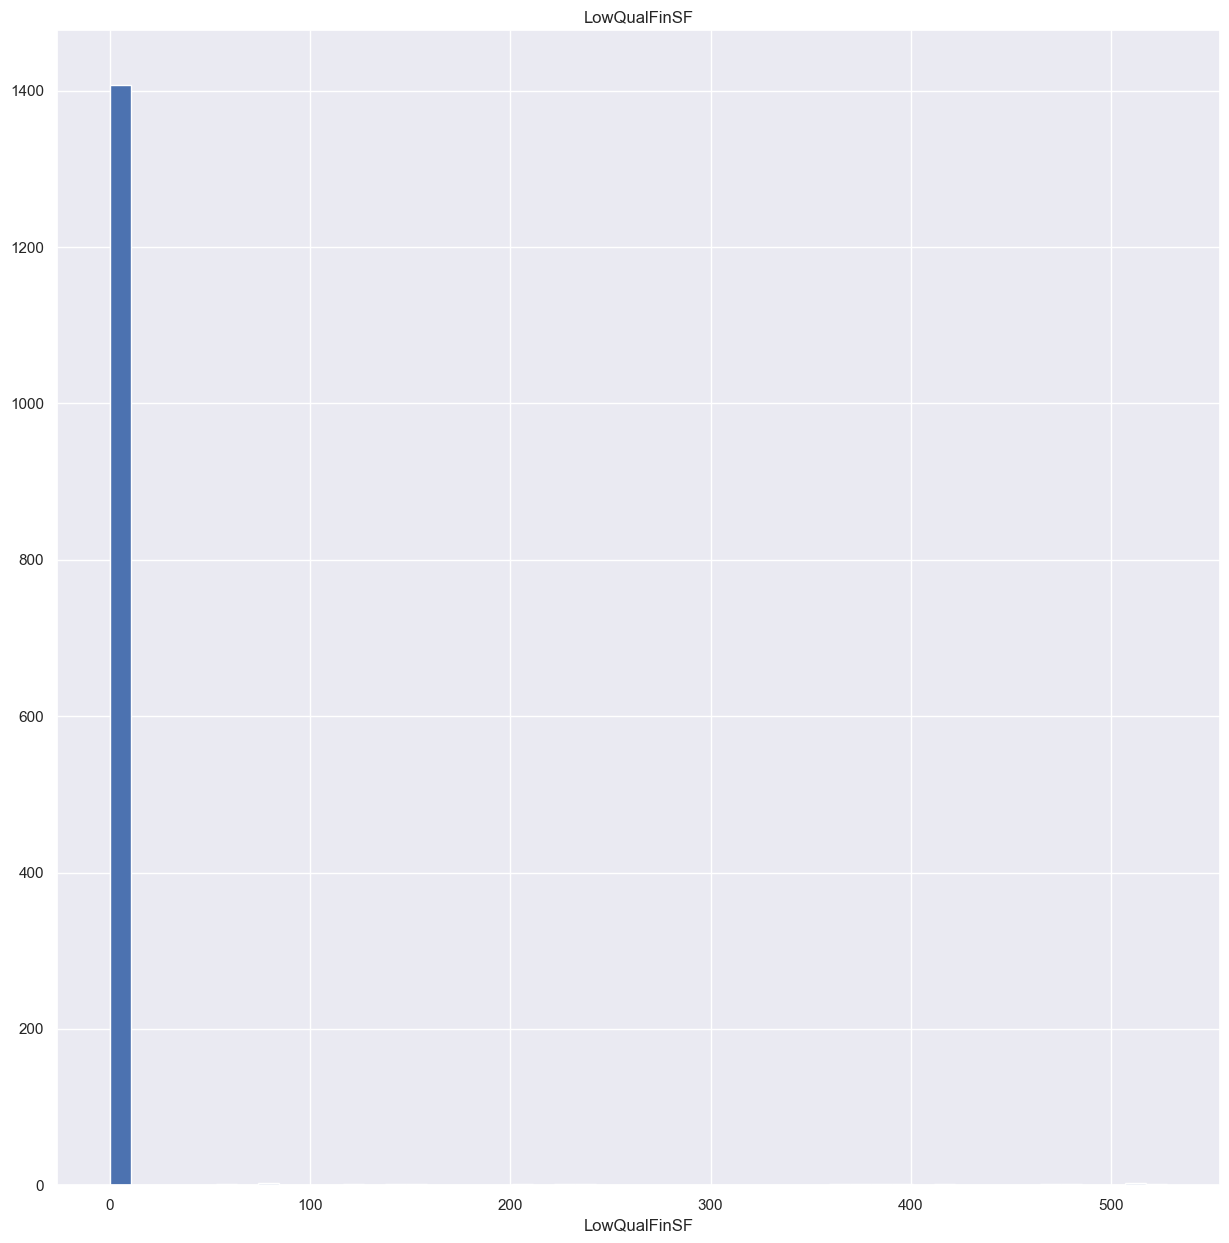

count   1432.000
mean    1490.433
std      490.874
min      334.000
5%       848.000
10%      910.200
20%     1057.600
25%     1125.000
30%     1200.000
40%     1328.000
50%     1454.500
60%     1568.200
70%     1690.700
80%     1839.800
90%     2107.000
95%     2372.900
99%     2804.420
100%    5642.000
max     5642.000
Name: GrLivArea, dtype: float64


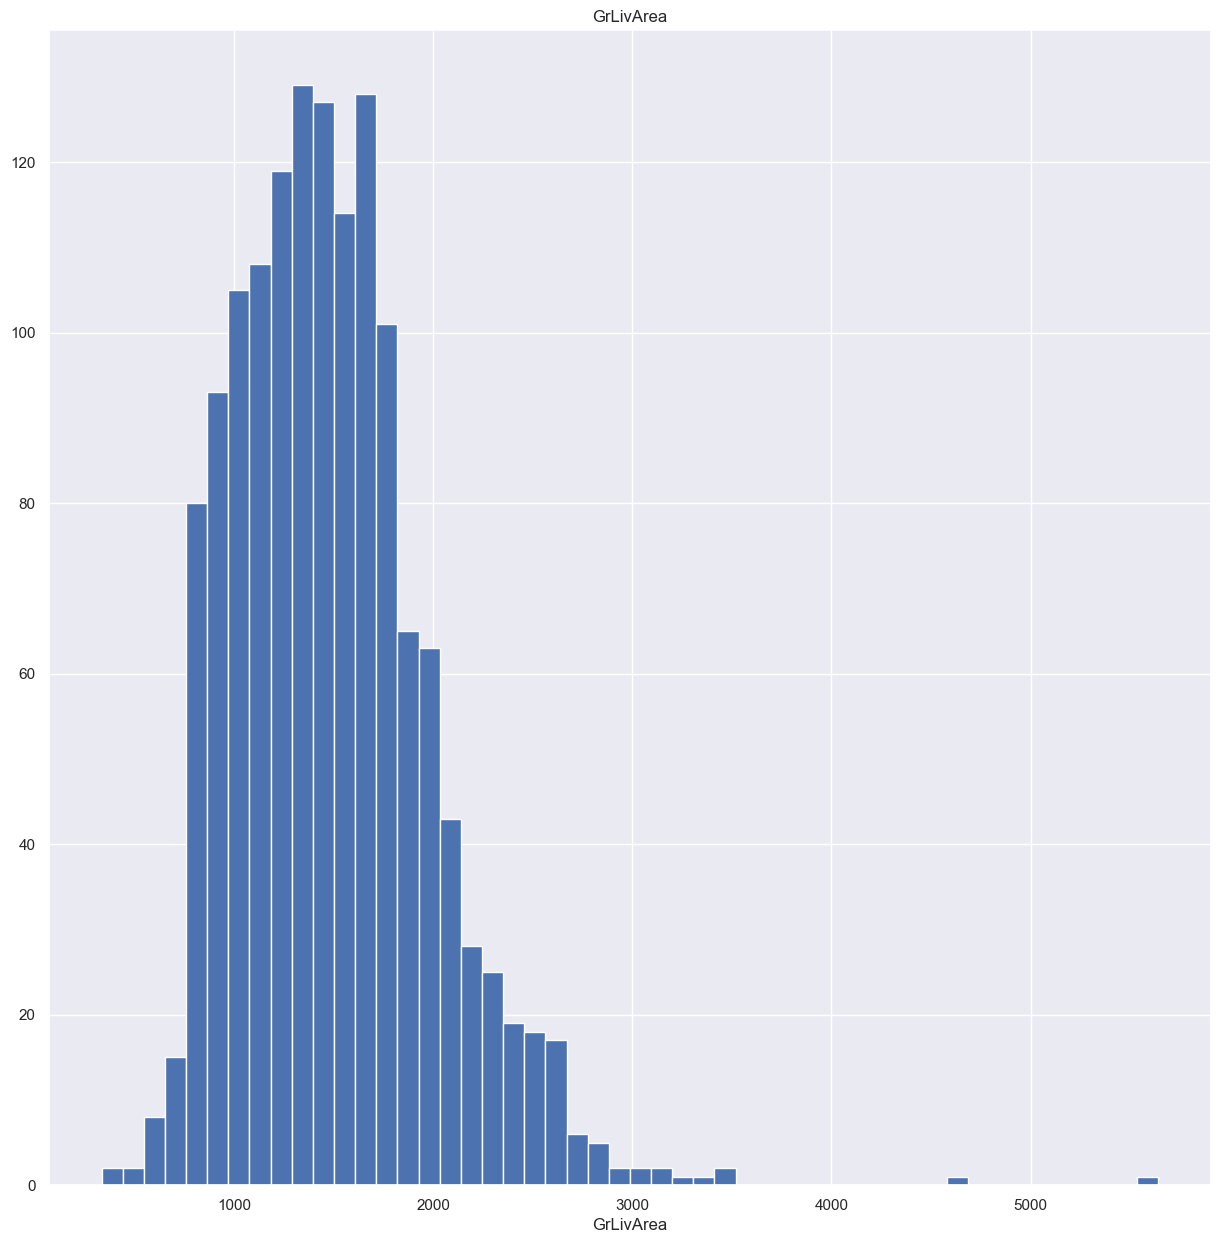

count   1432.000
mean       6.455
std        1.566
min        2.000
5%         4.000
10%        5.000
20%        5.000
25%        5.000
30%        6.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%        8.000
95%        9.000
99%       11.000
100%      14.000
max       14.000
Name: TotRmsAbvGrd, dtype: float64


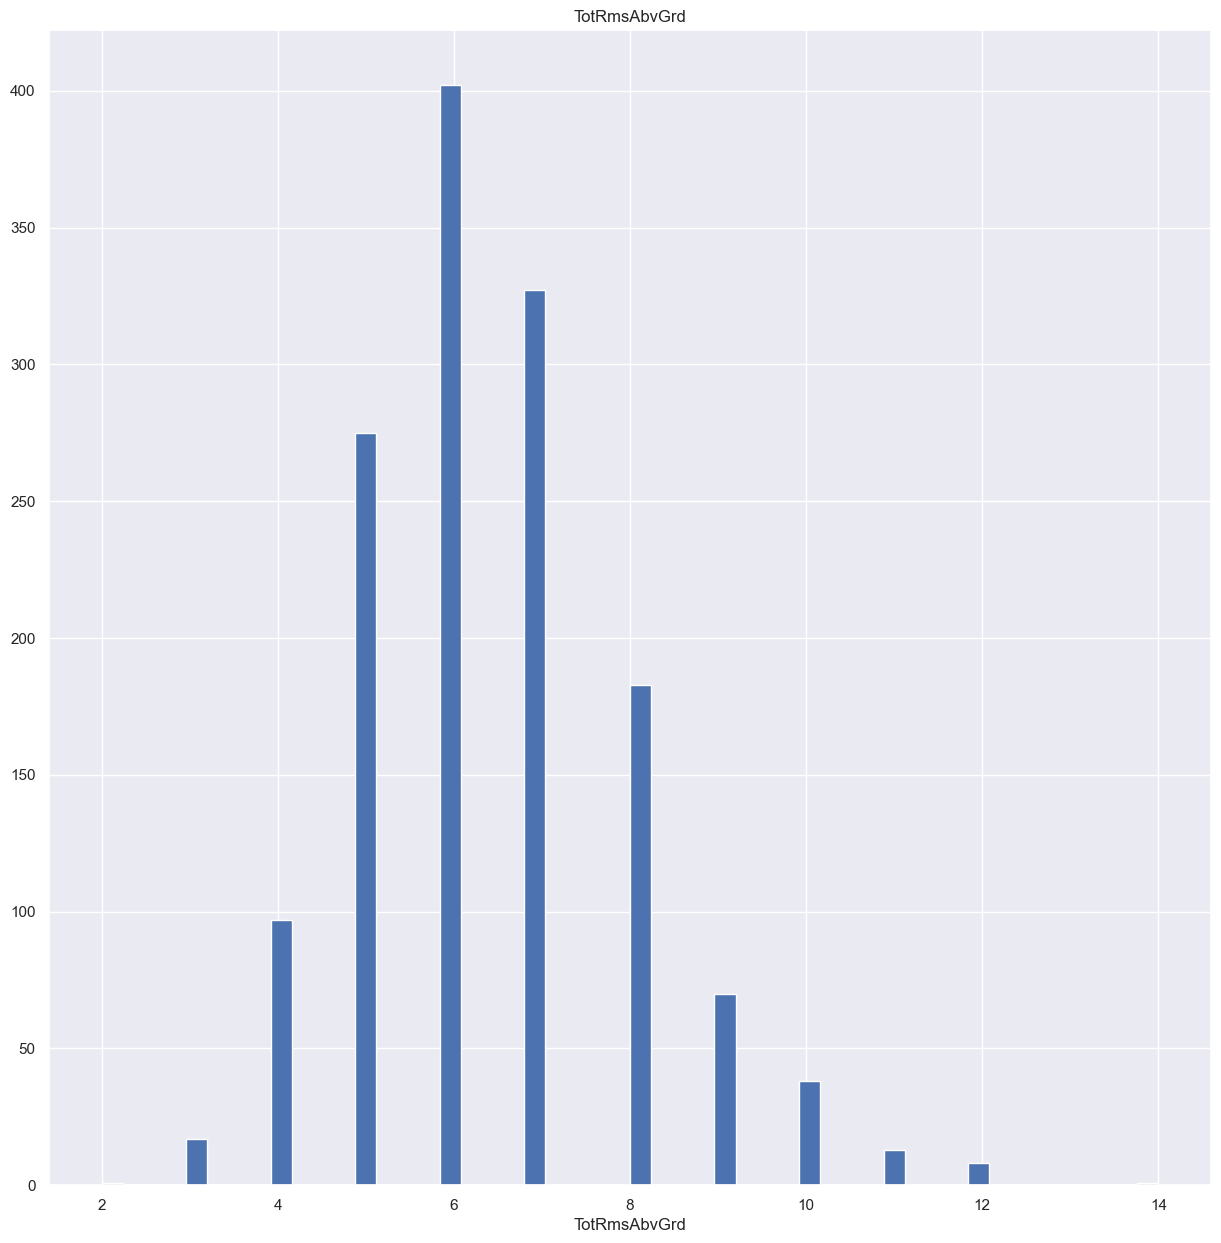

count   1351.000
mean    1977.997
std       24.673
min     1900.000
5%      1929.500
10%     1945.000
20%     1957.000
25%     1961.000
30%     1965.000
40%     1972.000
50%     1979.000
60%     1992.000
70%     1999.000
80%     2003.000
90%     2006.000
95%     2007.000
99%     2009.000
100%    2010.000
max     2010.000
Name: GarageYrBlt, dtype: float64


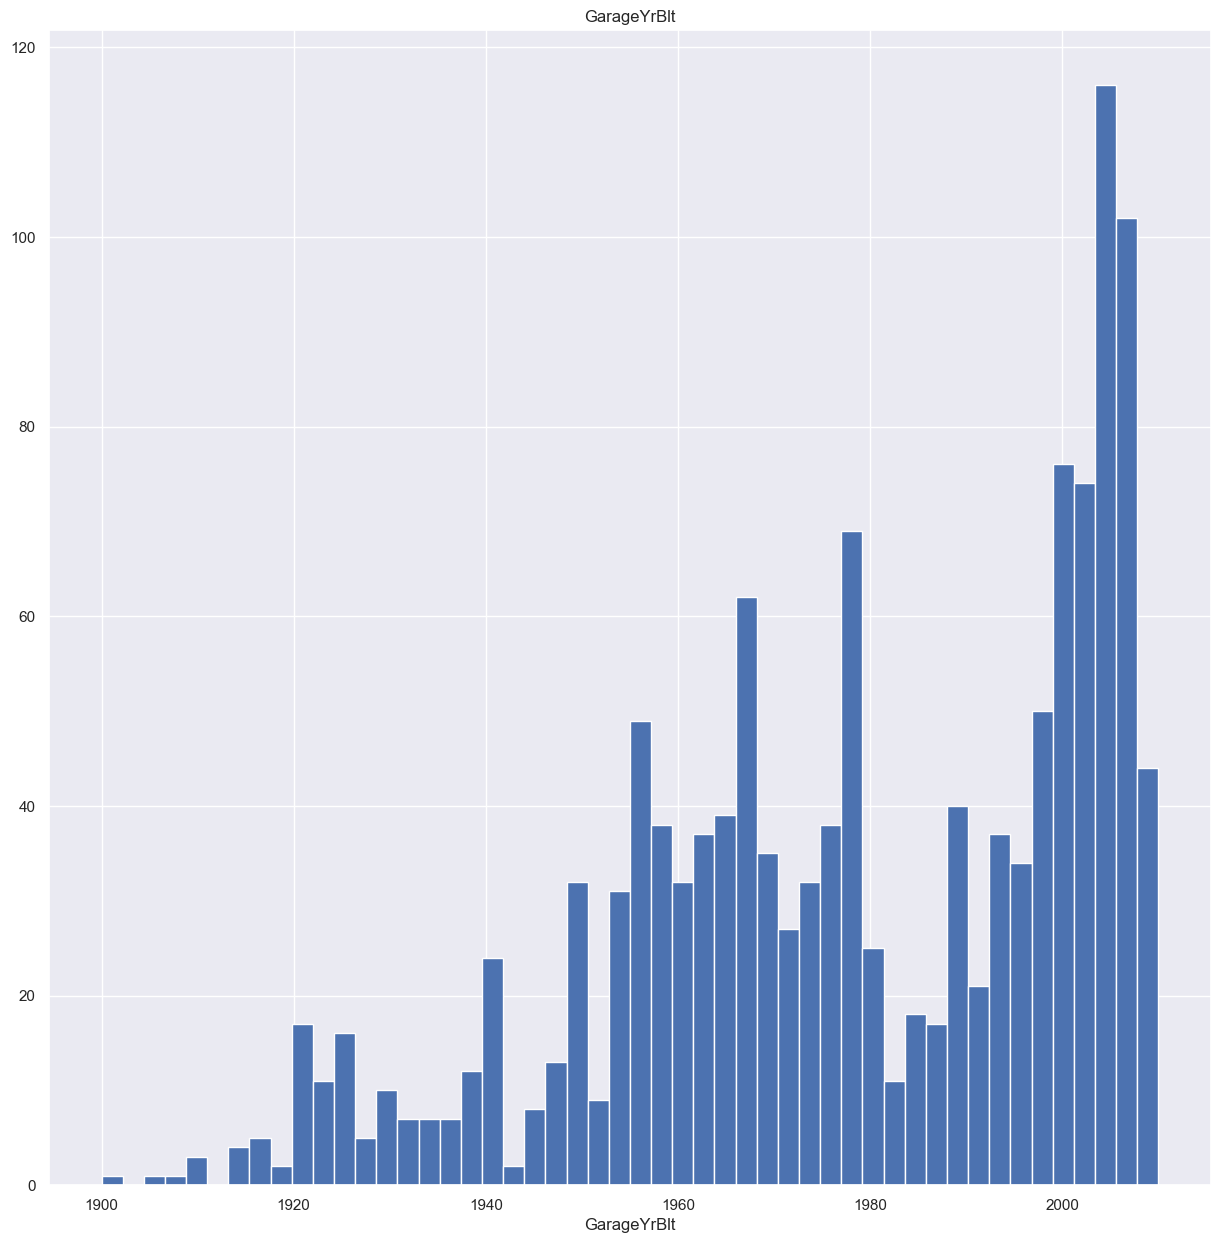

count   1432.000
mean     466.112
std      209.215
min        0.000
5%         0.000
10%      240.000
20%      290.400
25%      323.500
30%      380.000
40%      436.400
50%      474.000
60%      508.000
70%      550.000
80%      604.800
90%      736.000
95%      840.000
99%      963.660
100%    1418.000
max     1418.000
Name: GarageArea, dtype: float64


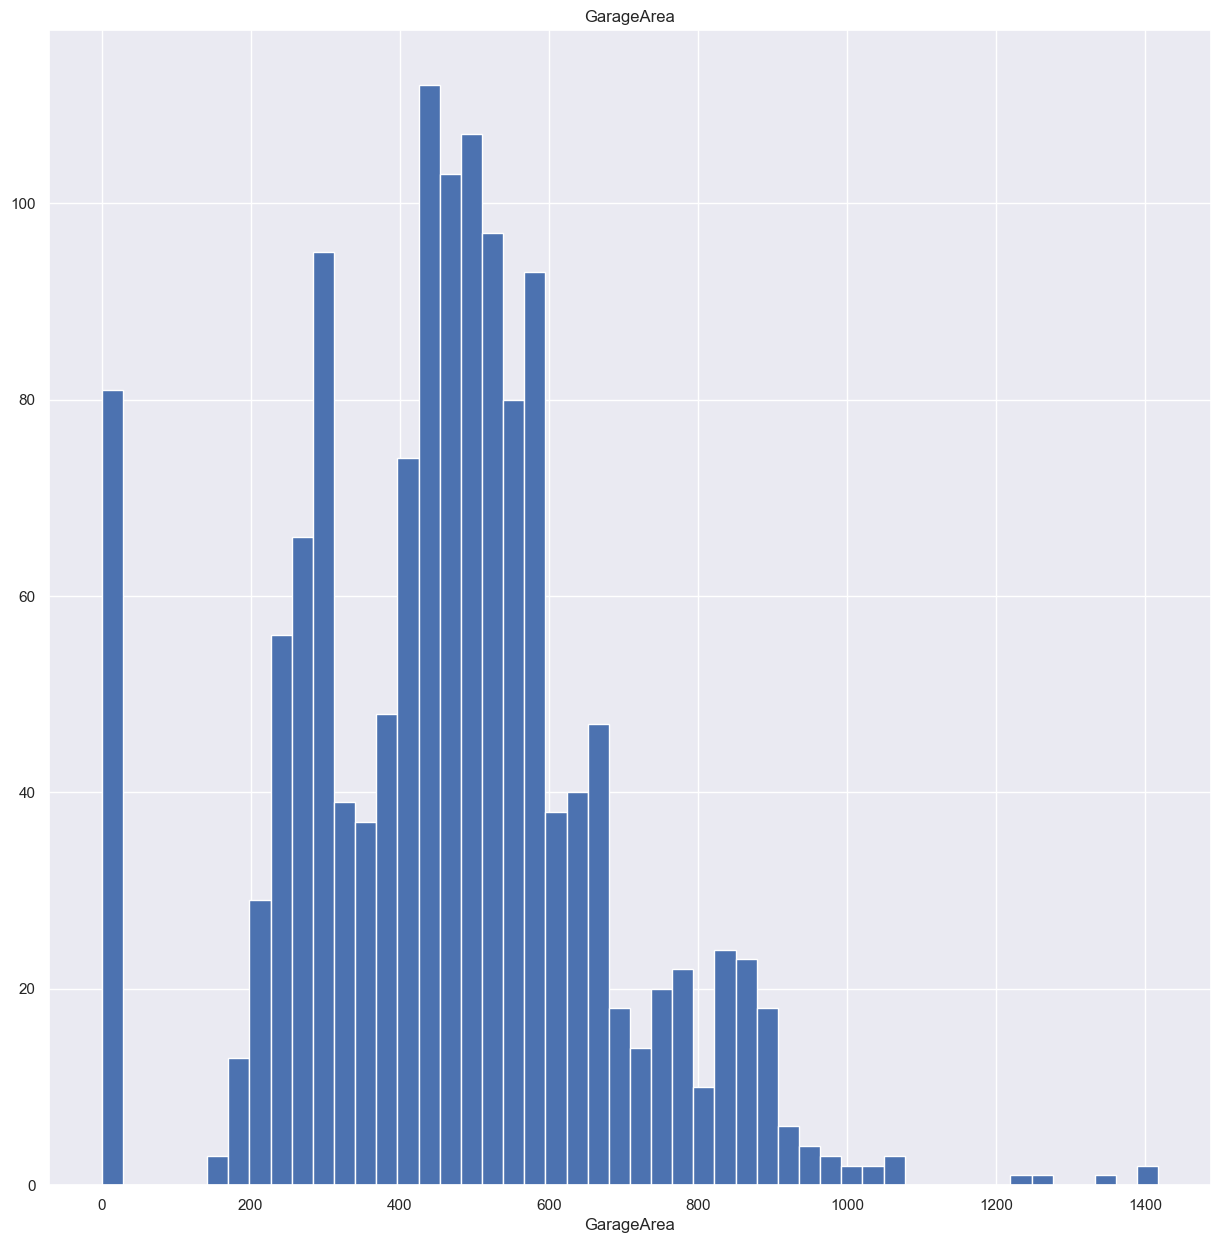

count   1432.000
mean      92.202
std      123.915
min        0.000
5%         0.000
10%        0.000
20%        0.000
25%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      100.000
70%      144.000
80%      192.000
90%      255.900
95%      326.450
99%      498.450
100%     857.000
max      857.000
Name: WoodDeckSF, dtype: float64


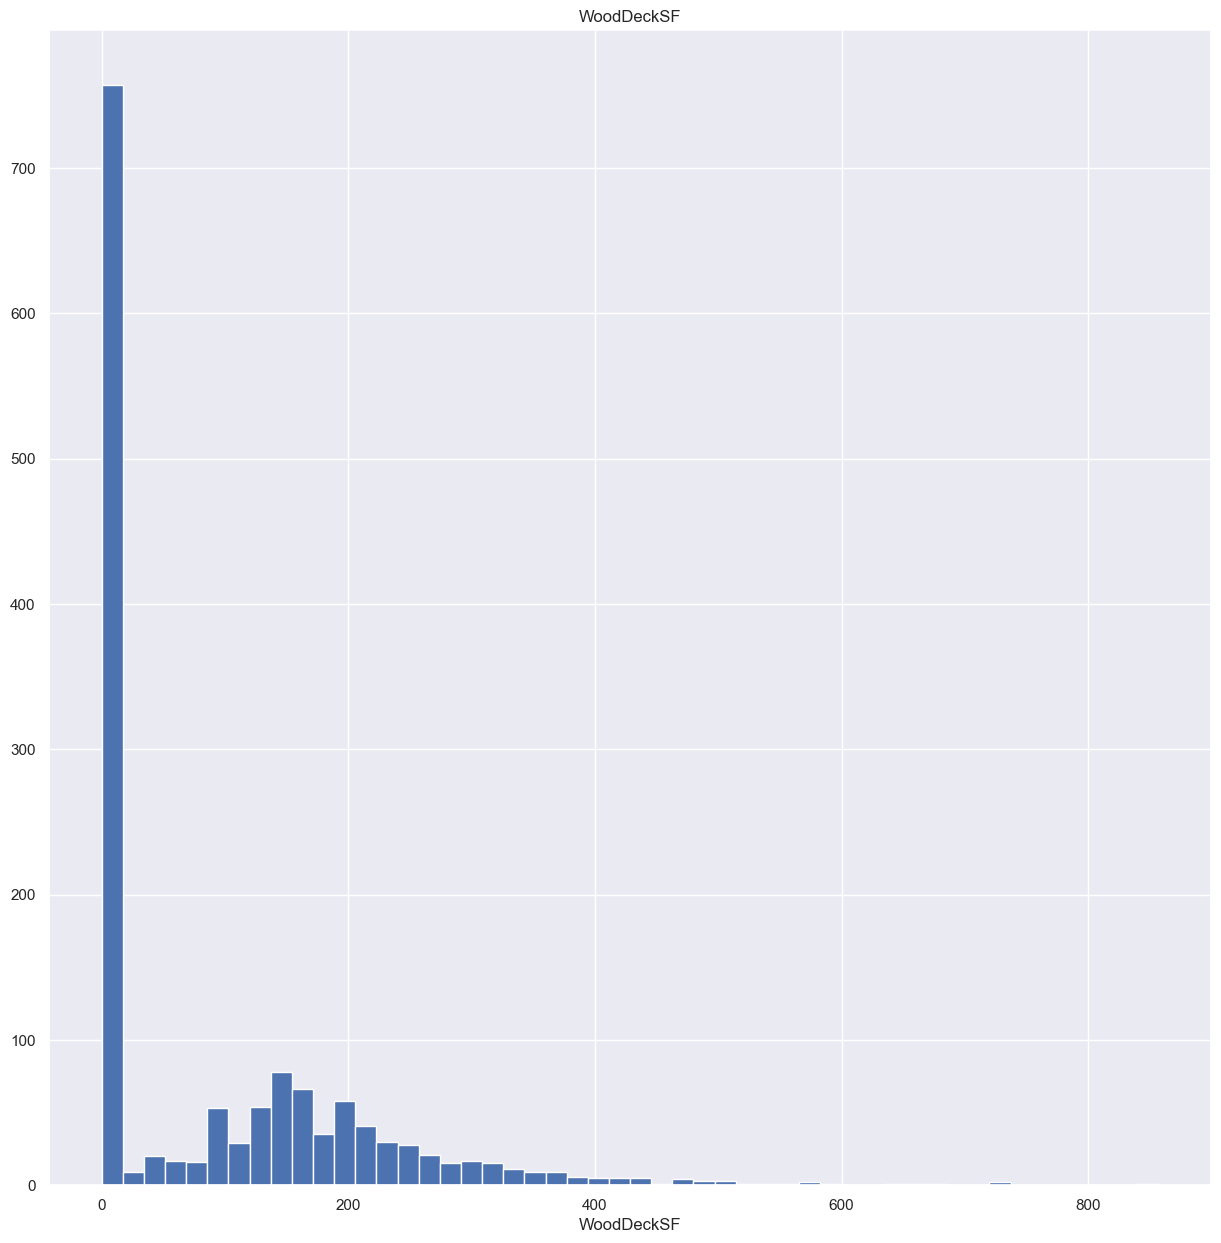

count   1432.000
mean      45.543
std       65.568
min        0.000
5%         0.000
10%        0.000
20%        0.000
25%        0.000
30%        0.000
40%        0.000
50%       24.000
60%       39.000
70%       55.000
80%       81.000
90%      128.000
95%      172.000
99%      286.380
100%     547.000
max      547.000
Name: OpenPorchSF, dtype: float64


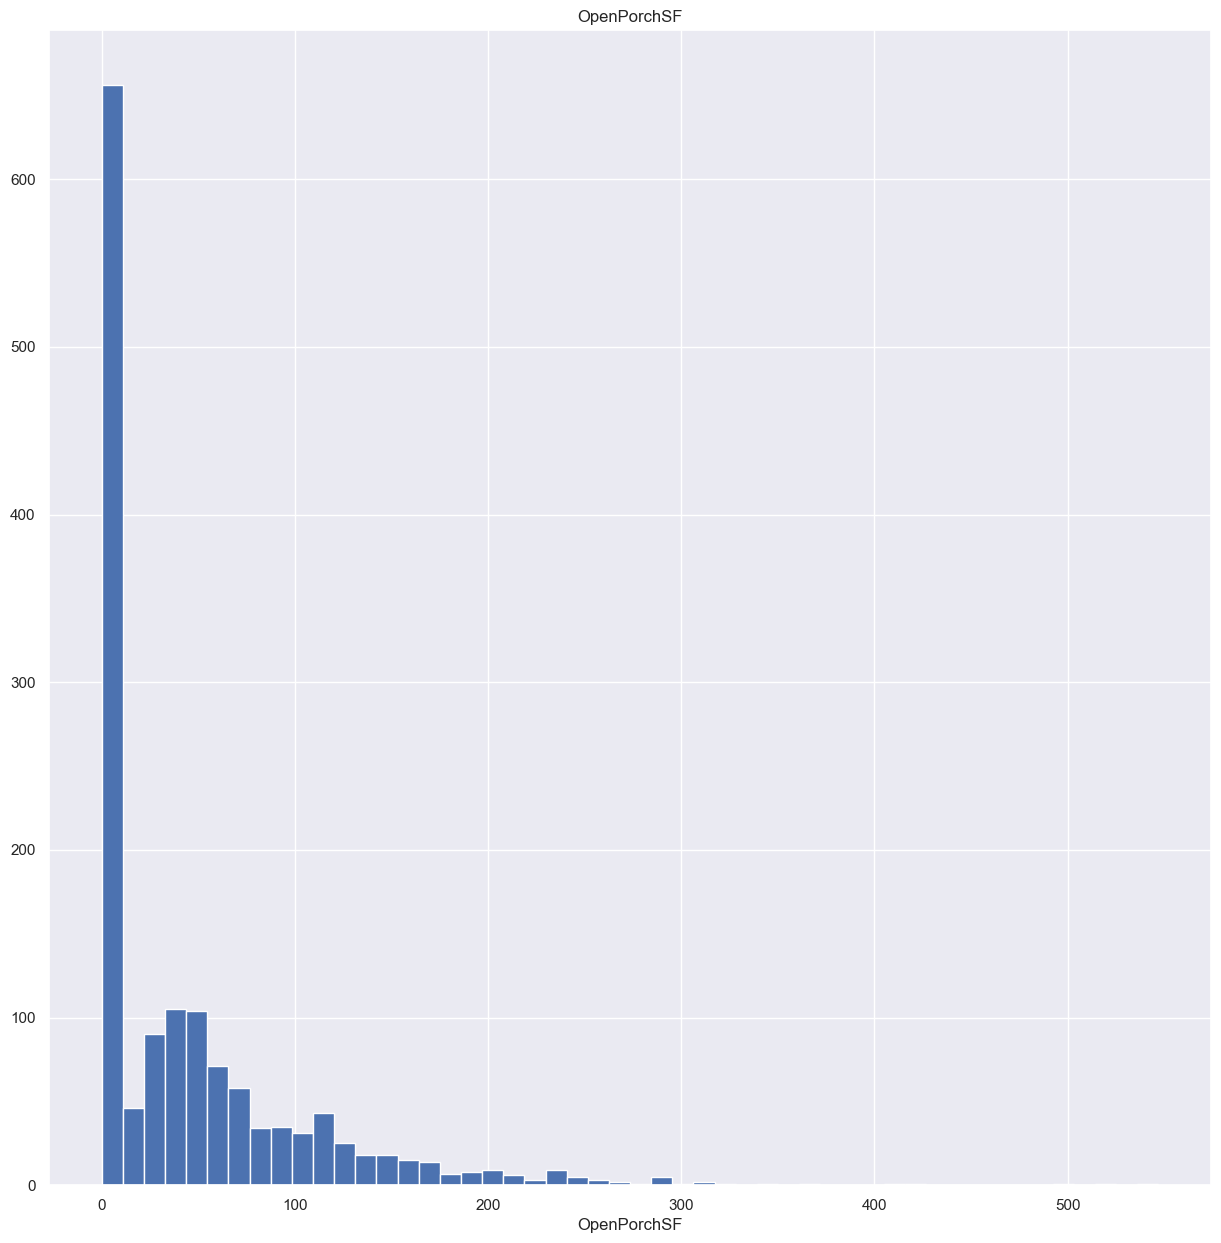

count   1432.000
mean      22.013
std       61.048
min        0.000
5%         0.000
10%        0.000
20%        0.000
25%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      112.000
95%      180.000
99%      257.450
100%     552.000
max      552.000
Name: EnclosedPorch, dtype: float64


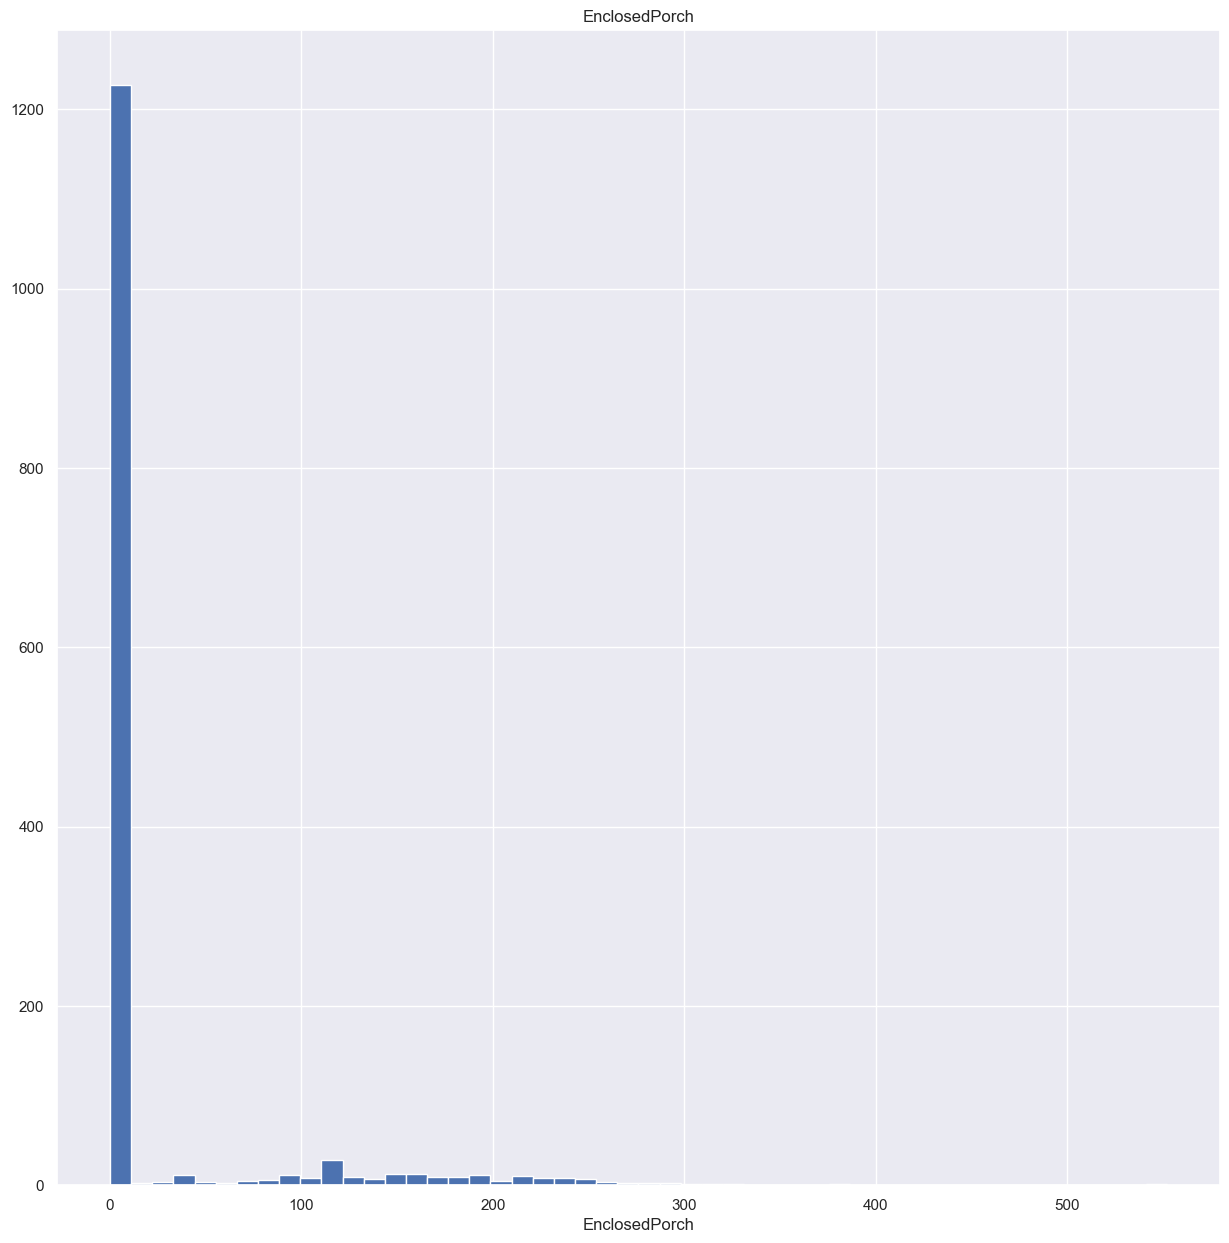

count   1432.000
mean       3.476
std       29.599
min        0.000
5%         0.000
10%        0.000
20%        0.000
25%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      168.000
100%     508.000
max      508.000
Name: 3SsnPorch, dtype: float64


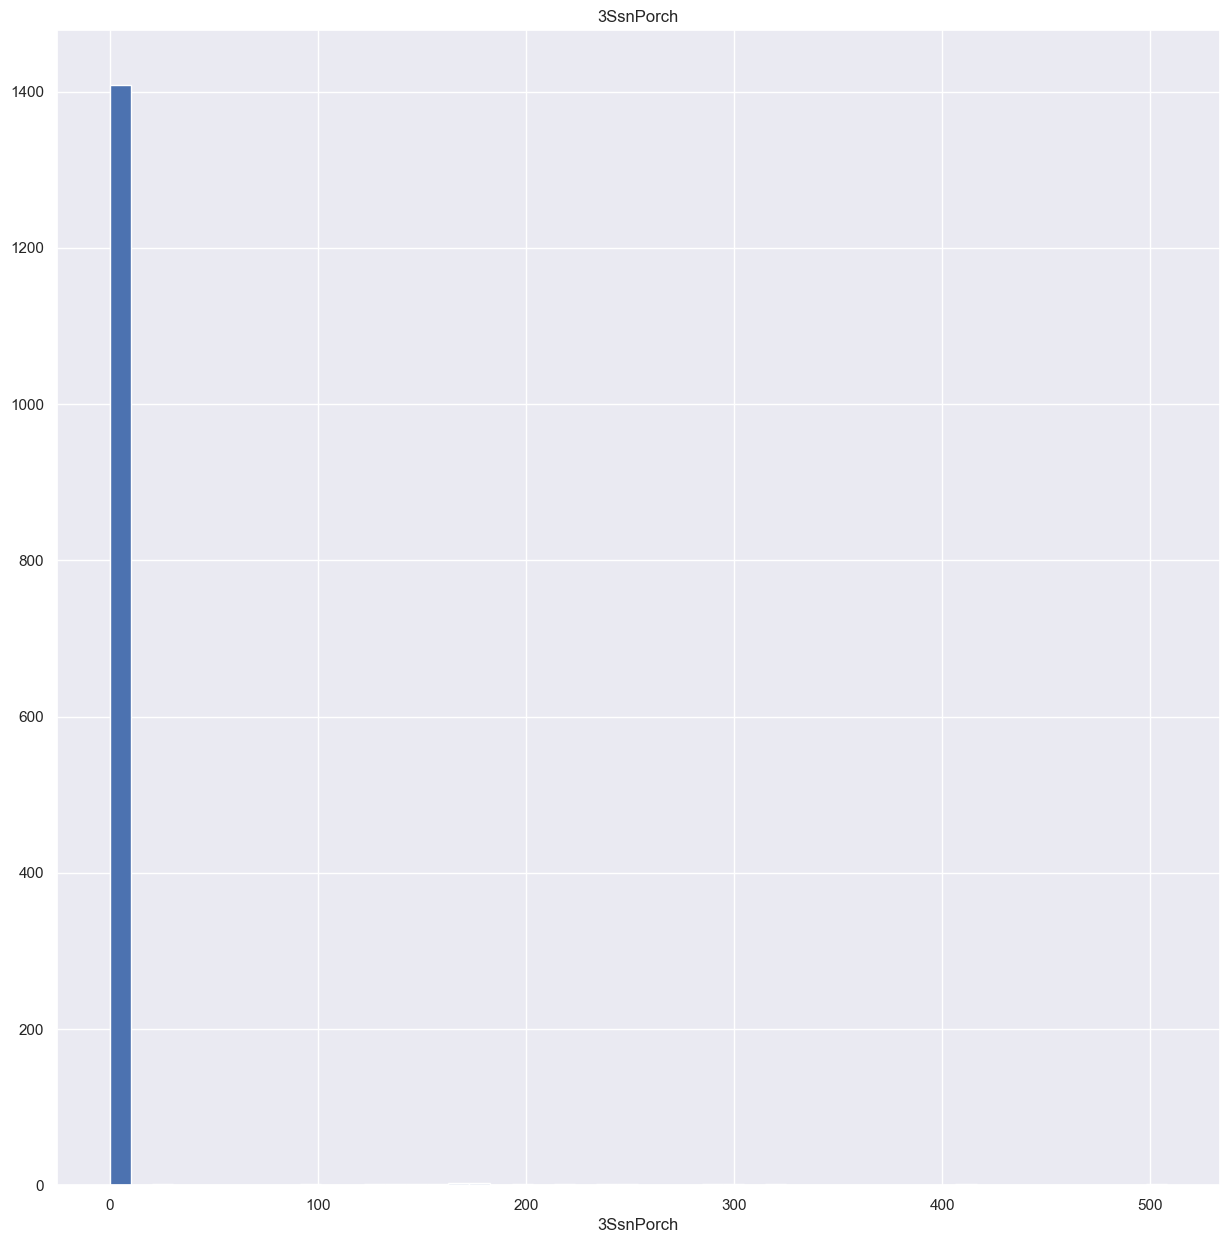

count   1432.000
mean      14.571
std       54.593
min        0.000
5%         0.000
10%        0.000
20%        0.000
25%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%      155.450
99%      265.690
100%     480.000
max      480.000
Name: ScreenPorch, dtype: float64


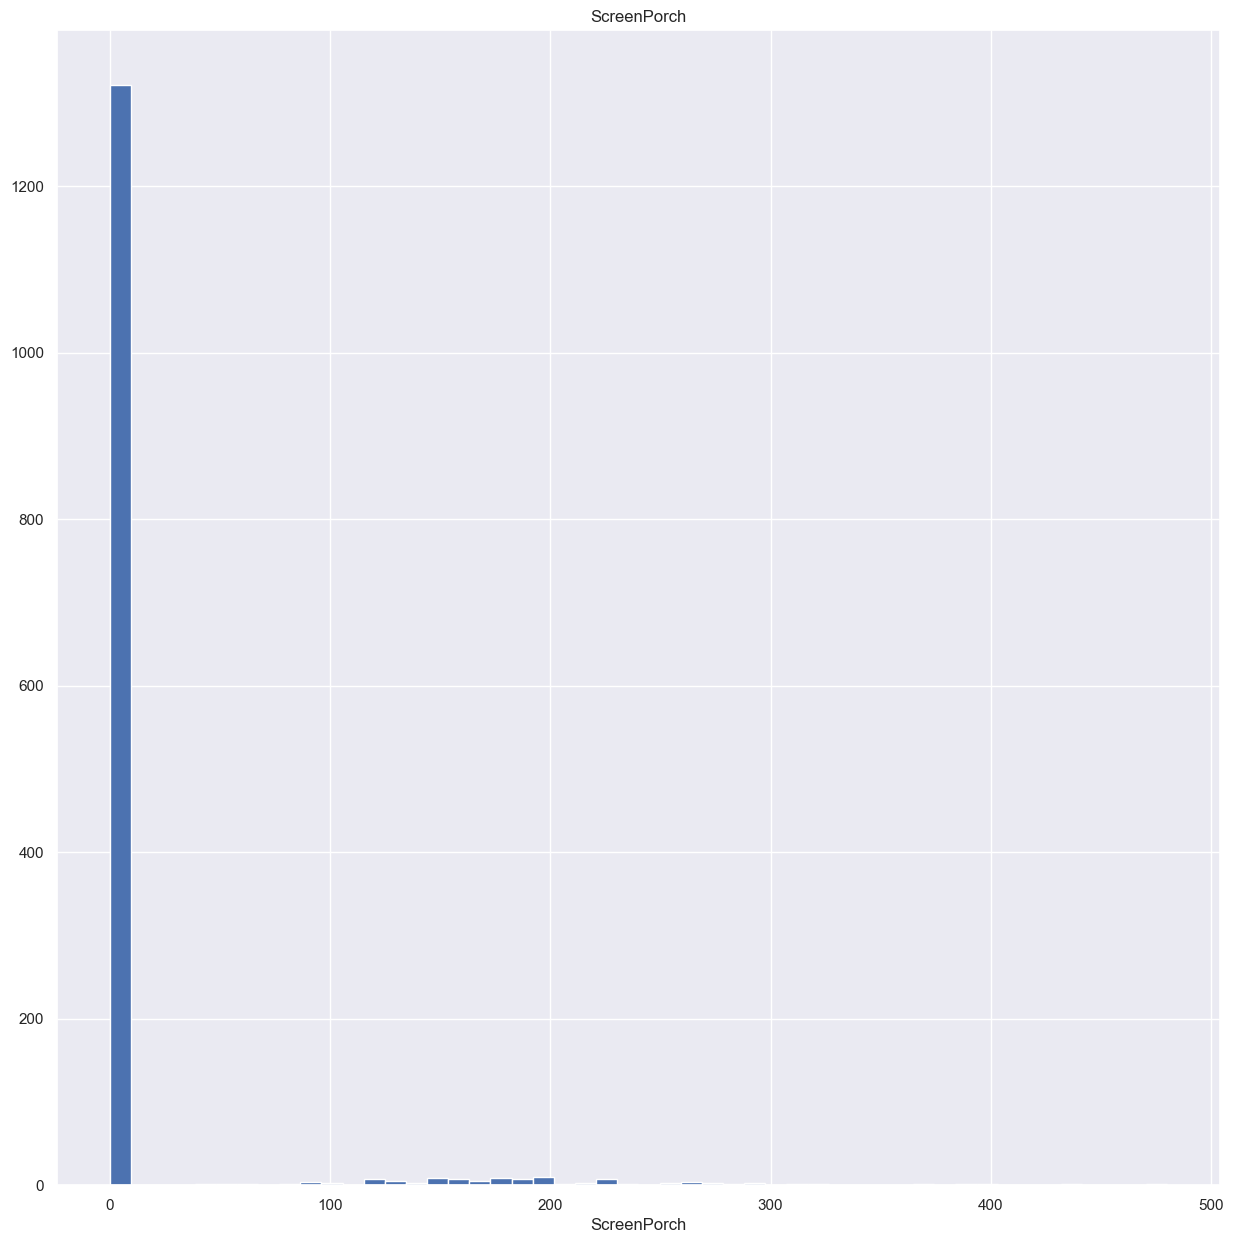

count    1432.000
mean       44.339
std       500.916
min         0.000
5%          0.000
10%         0.000
20%         0.000
25%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%       700.000
100%    15500.000
max     15500.000
Name: MiscVal, dtype: float64


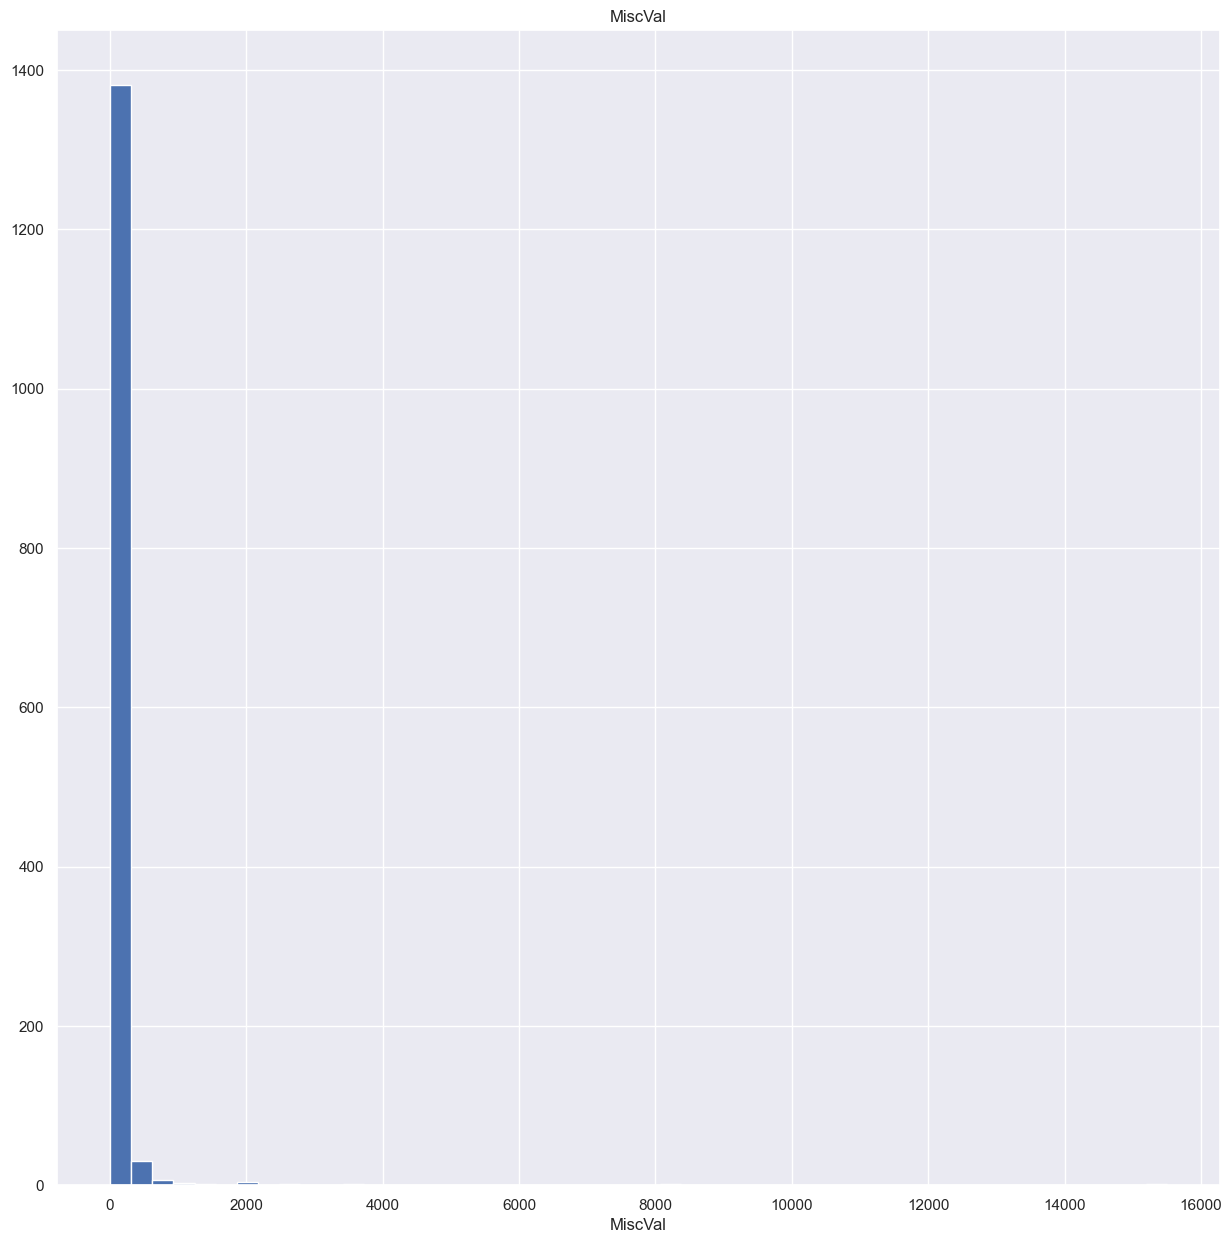

count   1432.000
mean       6.335
std        2.704
min        1.000
5%         2.000
10%        3.000
20%        4.000
25%        5.000
30%        5.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%       10.000
95%       11.000
99%       12.000
100%      12.000
max       12.000
Name: MoSold, dtype: float64


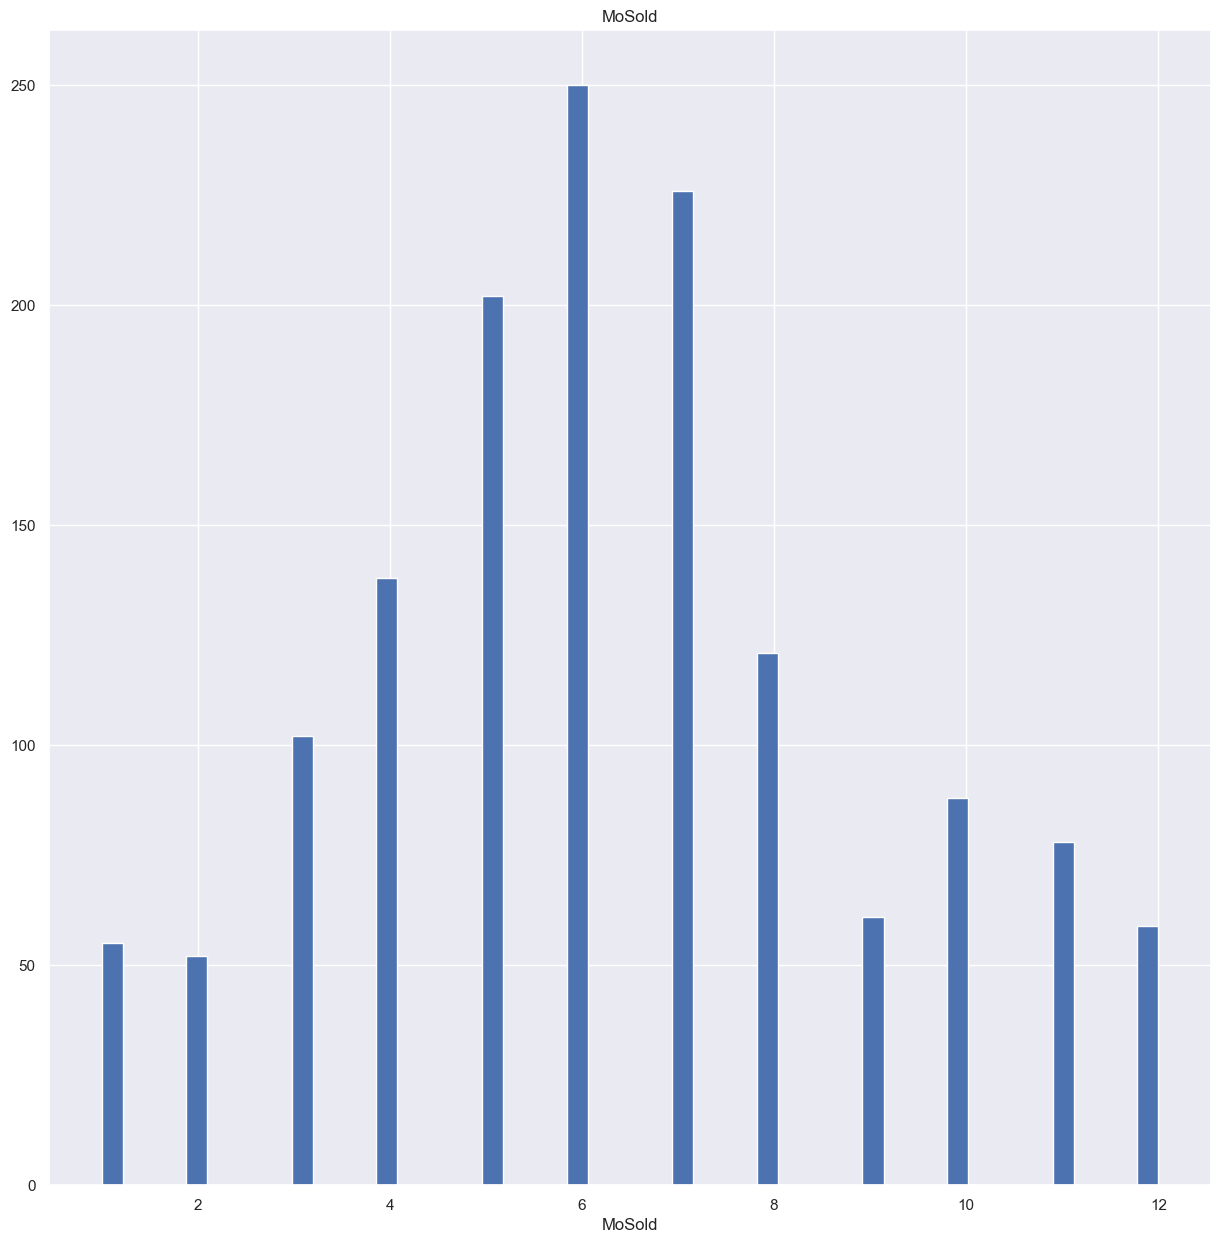

count     1432.000
mean    174873.439
std      65922.704
min      34900.000
5%       88000.000
10%     106000.000
20%     123100.000
25%     129500.000
30%     135000.000
40%     145350.000
50%     160600.000
60%     177500.000
70%     194640.000
80%     225000.000
90%     269350.000
95%     312725.000
99%     376673.940
100%    395192.000
max     395192.000
Name: SalePrice, dtype: float64


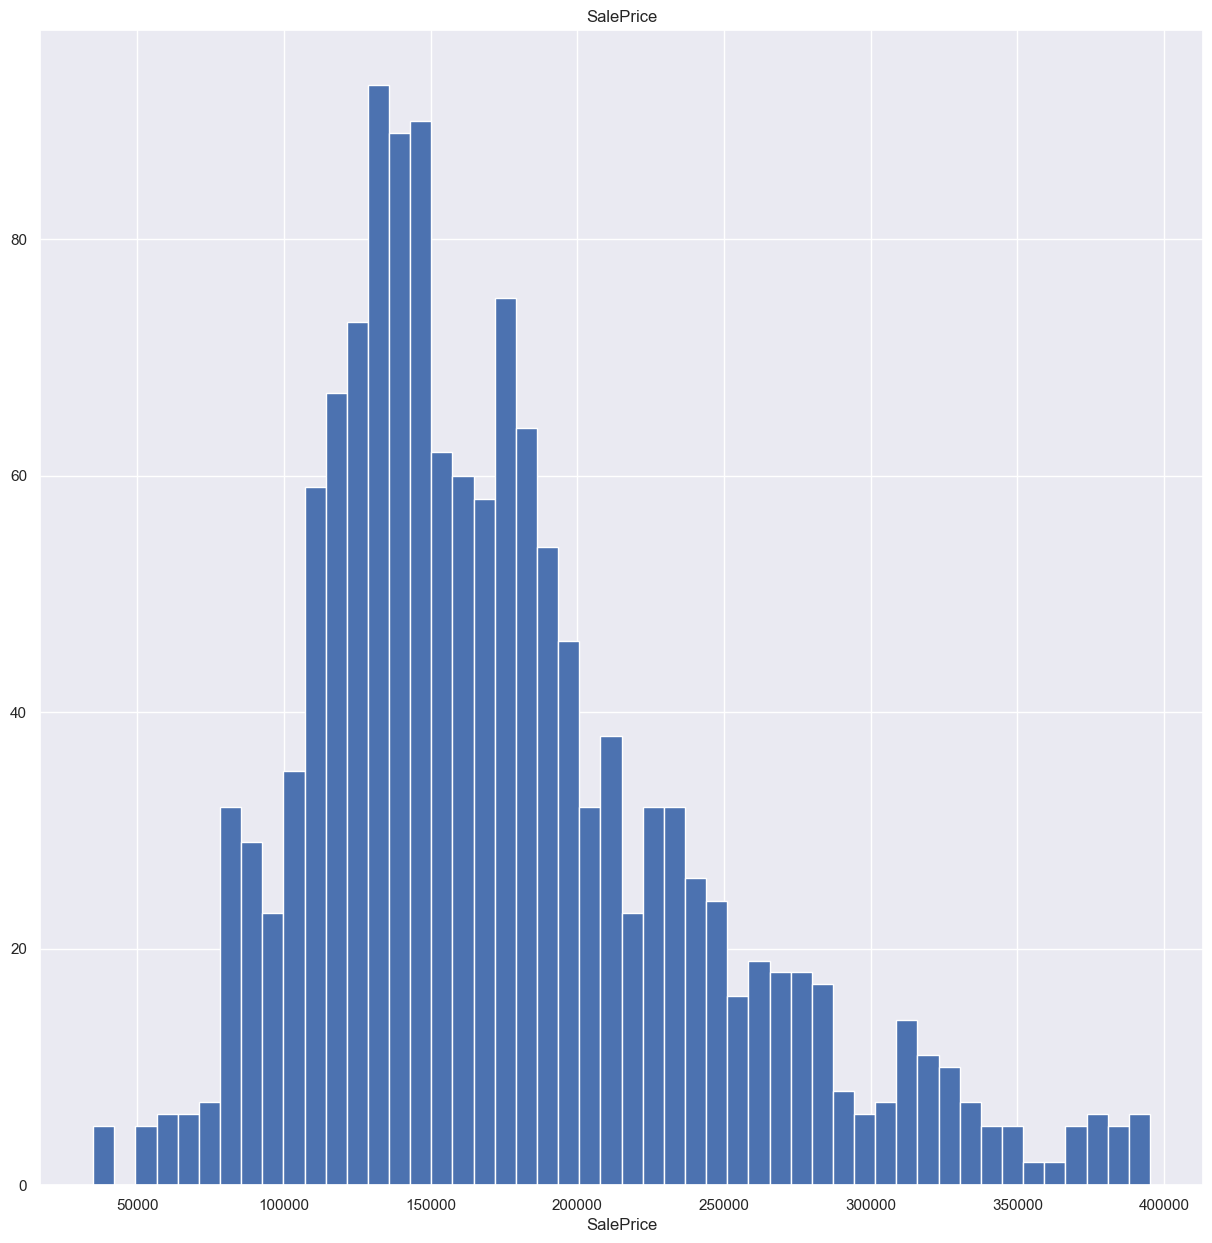

In [91]:
for col in num_cols:
    num_summary(df, col, True)

### Analysis of Target Variable (Hedef Değişken Analizi)

In [92]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print('----------------------------------------------------------------')

    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')

In [93]:
for col in cat_cols:
    target_summary_with_cat(df, 'SalePrice', col)

----------------------------------------------------------------
          TARGET_MEAN
MSZoning             
C (all)     74528.000
FV         214014.062
RH         131558.375
RL         183803.885
RM         124709.995


----------------------------------------------------------------
        TARGET_MEAN
Street             
Grvl     130190.500
Pave     175061.445


----------------------------------------------------------------
       TARGET_MEAN
Alley             
Grvl    122219.080
Pave    168000.585


----------------------------------------------------------------
          TARGET_MEAN
LotShape             
IR1        197376.688
IR2        203406.686
IR3        216036.500
Reg        161762.822


----------------------------------------------------------------
             TARGET_MEAN
LandContour             
Bnk           143104.079
HLS           220831.604
Low           203661.111
Lvl           173907.774


----------------------------------------------------------------
        

### Examining the Dependent Variable (Bağımlı Değişkenin İncelenmesi)

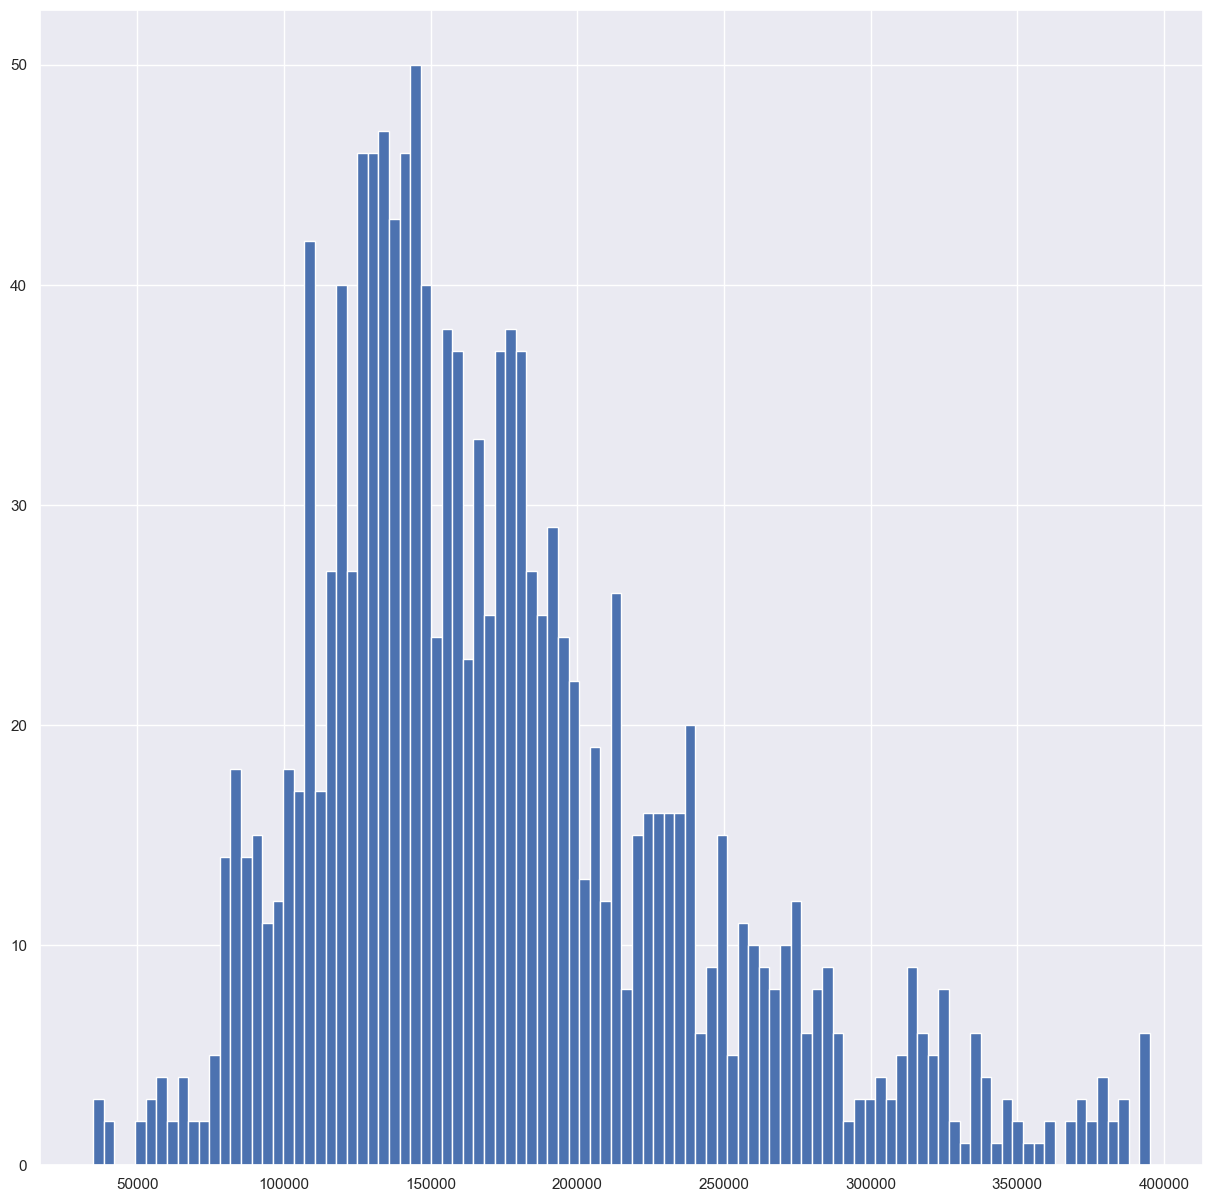

In [94]:
df['SalePrice'].hist(bins=100)
plt.show()

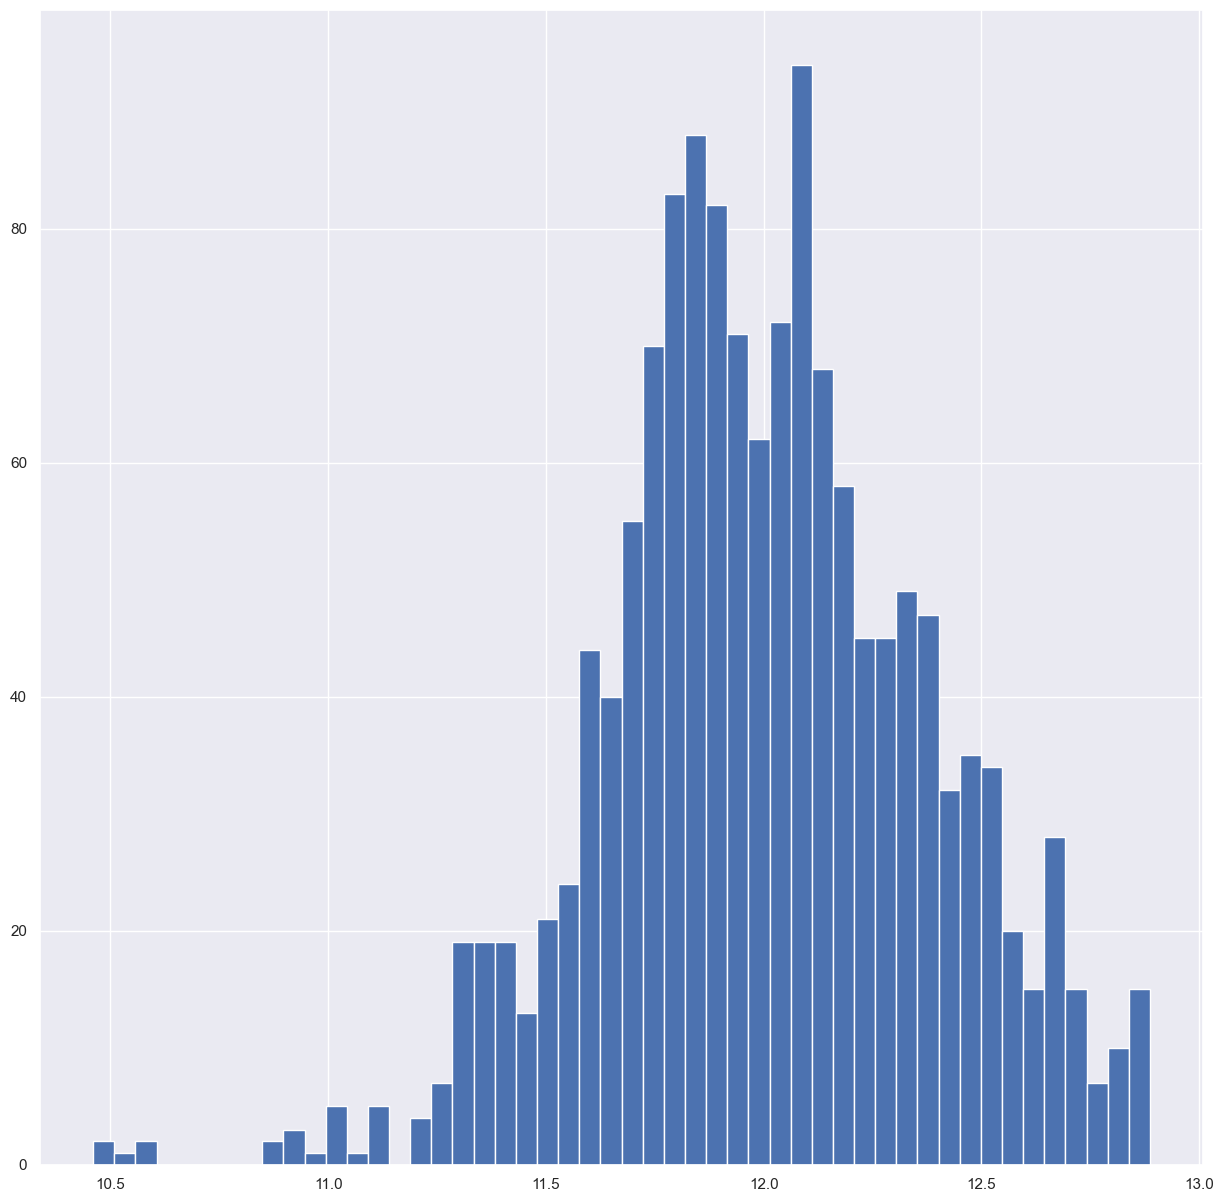

In [95]:
# Examining the logarithm of the dependent variable (Bağımlı değişkenin logaritmasının incelenmesi)

np.log1p(df['SalePrice']).hist(bins=50)
plt.show()

### Correlation Analysis (Analysis of Correlation)

In [96]:
corr = df[num_cols].corr()
corr

Id  MSSubClass  LotFrontage  LotArea  OverallQual  \
Id             1.000       0.011       -0.008   -0.033       -0.023   
MSSubClass     0.011       1.000       -0.394   -0.141        0.046   
LotFrontage   -0.008      -0.394        1.000    0.442        0.222   
LotArea       -0.033      -0.141        0.442    1.000        0.080   
OverallQual   -0.023       0.046        0.222    0.080        1.000   
YearBuilt     -0.012       0.035        0.110    0.002        0.570   
YearRemodAdd  -0.019       0.046        0.075    0.001        0.544   
MasVnrArea    -0.049       0.032        0.175    0.069        0.365   
BsmtFinSF1    -0.006      -0.060        0.221    0.199        0.194   
BsmtFinSF2    -0.005      -0.066        0.054    0.114       -0.058   
BsmtUnfSF     -0.006      -0.140        0.125   -0.003        0.304   
TotalBsmtSF   -0.015      -0.235        0.378    0.251        0.500   
1stFlrSF       0.012      -0.249        0.448    0.292        0.431   
2ndFlrSF       0.006       0.313        0.053    0.026        0.272   
LowQualFinSF  -0.036       0.045        0.036   -0.004       -0.054   
GrLivArea      0.011       0.088        0.388    0.242        0.555   
TotRmsAbvGrd   0.035       0.048        0.340    0.168        0.379   
GarageYrBlt    0.004       0.092        0.053   -0.040        0.537   
GarageArea     0.023      -0.093        0.333    0.163        0.536   
WoodDeckSF    -0.034      -0.011        0.083    0.152        0.220   
OpenPorchSF   -0.002      -0.002        0.138    0.078        0.291   
EnclosedPorch  0.007      -0.011        0.007   -0.015       -0.115   
3SsnPorch     -0.047      -0.045        0.074    0.023        0.037   
ScreenPorch    0.010      -0.027        0.035    0.028        0.047   
MiscVal       -0.007      -0.008        0.006    0.040       -0.029   
MoSold         0.024      -0.016        0.014    0.004        0.084   
SalePrice     -0.022      -0.081        0.335    0.248        0.795   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
Id                -0.012        -0.019      -0.049      -0.006      -0.005   
MSSubClass         0.035         0.046       0.032      -0.060      -0.066   
LotFrontage        0.110         0.075       0.175       0.221       0.054   
LotArea            0.002         0.001       0.069       0.199       0.114   
OverallQual        0.570         0.544       0.365       0.194      -0.058   
YearBuilt          1.000         0.587       0.300       0.229      -0.048   
YearRemodAdd       0.587         1.000       0.156       0.107      -0.067   
MasVnrArea         0.300         0.156       1.000       0.233      -0.070   
BsmtFinSF1         0.229         0.107       0.233       1.000      -0.052   
BsmtFinSF2        -0.048        -0.067      -0.070      -0.052       1.000   
BsmtUnfSF          0.145         0.177       0.102      -0.516      -0.212   
TotalBsmtSF        0.375         0.272       0.325       0.496       0.111   
1stFlrSF           0.260         0.218       0.304       0.413       0.107   
2ndFlrSF          -0.002         0.131       0.125      -0.169      -0.096   
LowQualFinSF      -0.171        -0.067      -0.069      -0.059       0.018   
GrLivArea          0.177         0.271       0.329       0.158      -0.001   
TotRmsAbvGrd       0.067         0.166       0.224      -0.007      -0.031   
GarageYrBlt        0.825         0.635       0.233       0.131      -0.087   
GarageArea         0.469         0.355       0.346       0.264      -0.012   
WoodDeckSF         0.215         0.198       0.128       0.188       0.074   
OpenPorchSF        0.185         0.217       0.124       0.096       0.007   
EnclosedPorch     -0.395        -0.194      -0.111      -0.104       0.038   
3SsnPorch          0.034         0.048       0.026       0.031      -0.030   
ScreenPorch       -0.045        -0.047       0.068       0.072       0.088   
MiscVal           -0.033        -0.009      -0.029       0.006       0.005   
M

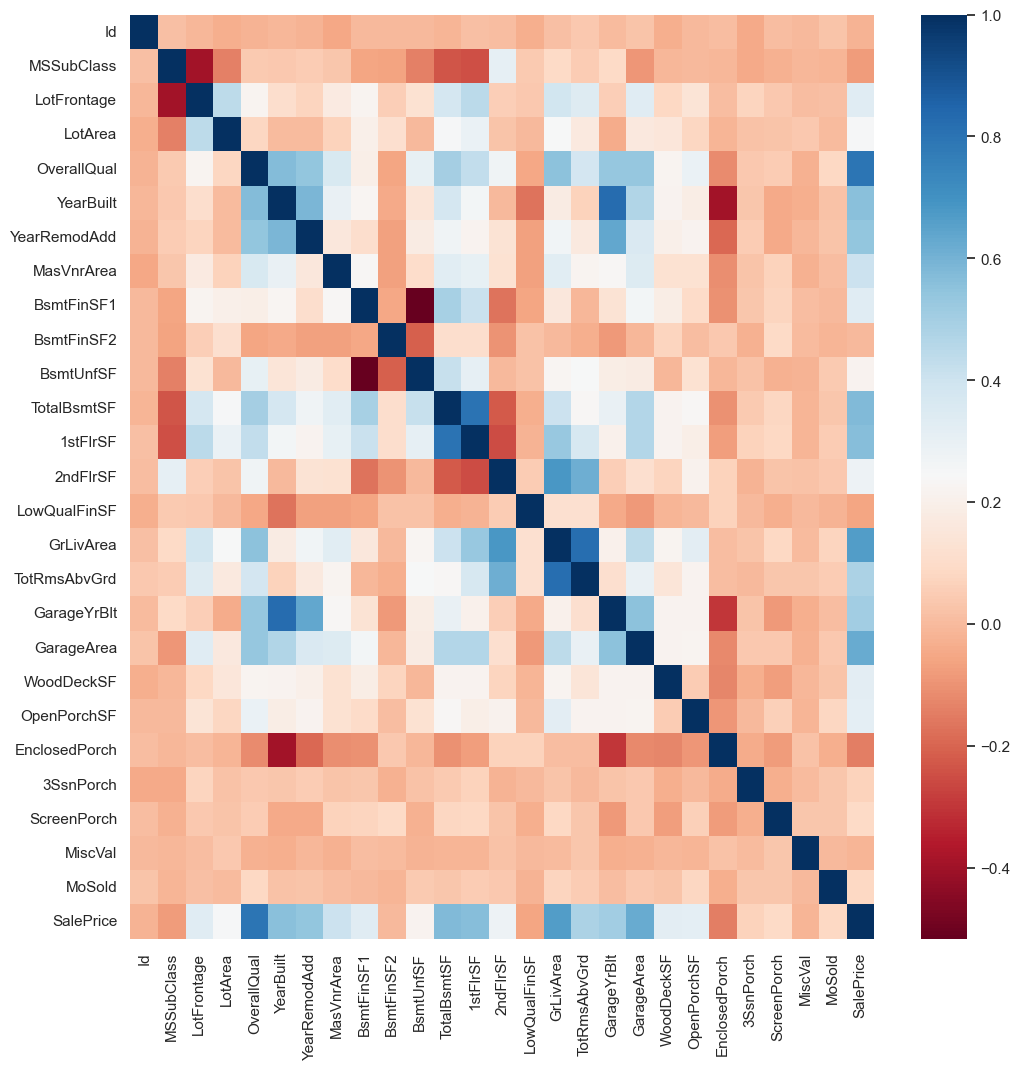

In [97]:
sns.set(rc={'figure.figsize':(12, 12)})
sns.heatmap(corr, cmap='RdBu')
plt.show()

In [98]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe[num_cols].corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu", linewidths=.5, cbar_kws={"shrink": 0.75})
        plt.show()
    return drop_list

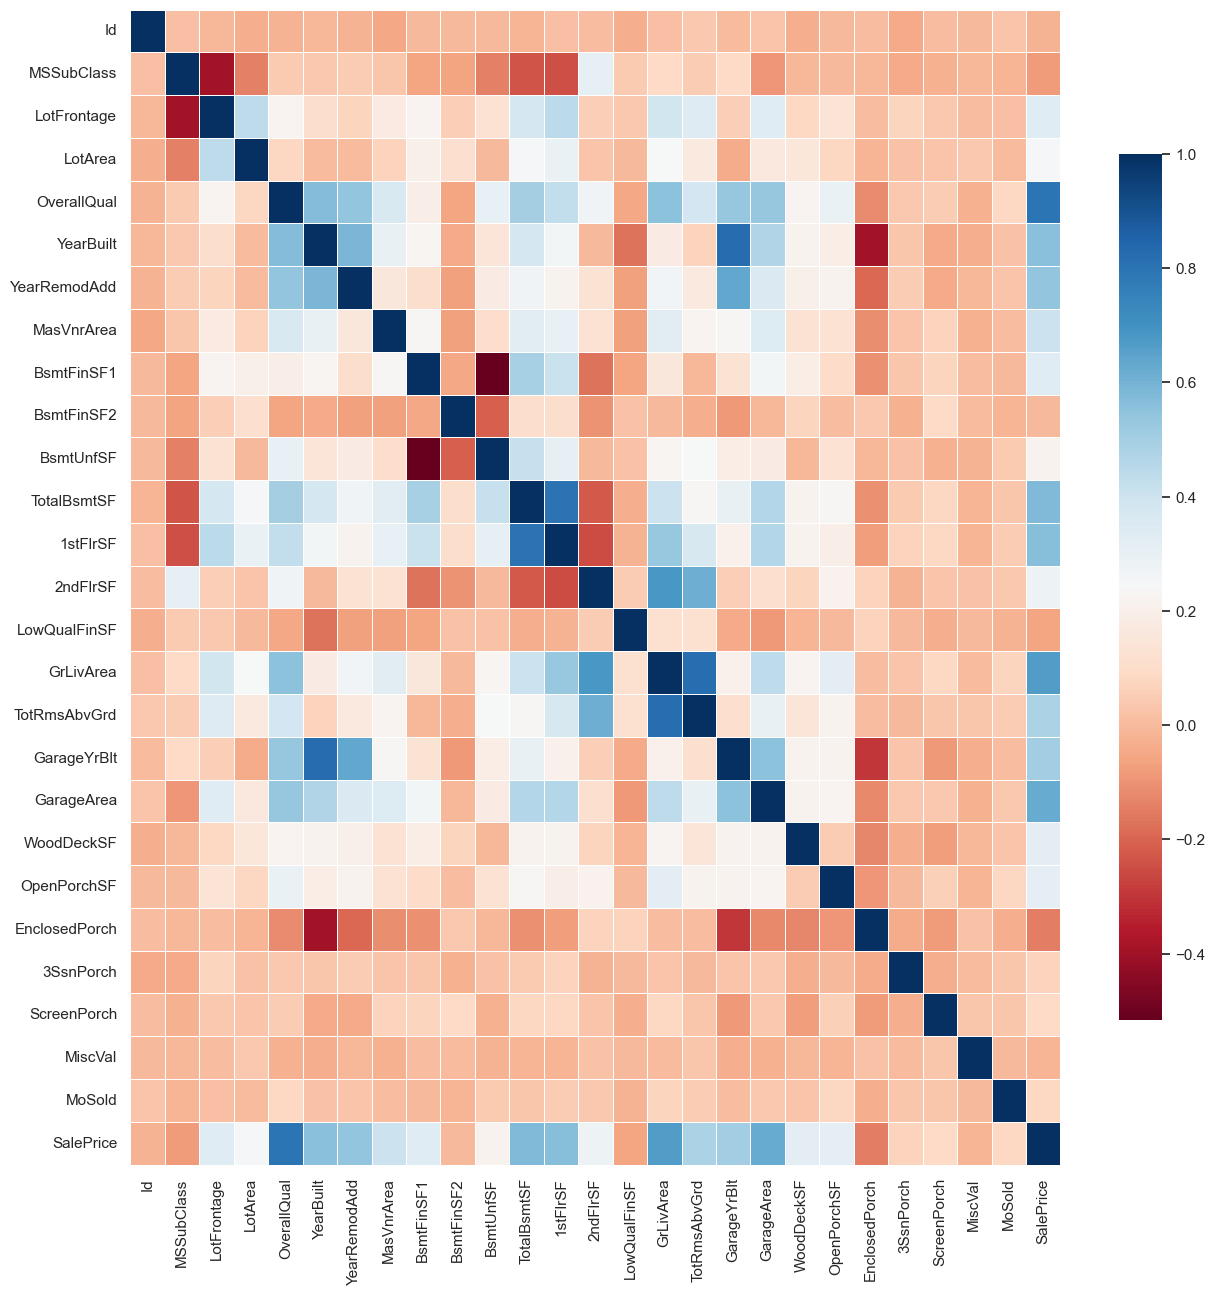

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'SalePrice']

In [99]:
high_correlated_cols(df, True)

## Data Preprocessing (Veri Ön İşleme)

### Outliers (Aykırı Değerler)

In [100]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [101]:
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)

    if dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False

In [102]:
def count_outliers(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)

    outliers = dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)]

    return outliers.shape[0]

In [103]:
for col in num_cols:
    count = count_outliers(df, col)
    print(col, ':', count)

Id : 0
MSSubClass : 103
LotFrontage : 85
LotArea : 73
OverallQual : 2
YearBuilt : 7
YearRemodAdd : 0
MasVnrArea : 88
BsmtFinSF1 : 4
BsmtFinSF2 : 165
BsmtUnfSF : 23
TotalBsmtSF : 57
1stFlrSF : 18
2ndFlrSF : 1
LowQualFinSF : 25
GrLivArea : 23
TotRmsAbvGrd : 22
GarageYrBlt : 1
GarageArea : 15
WoodDeckSF : 30
OpenPorchSF : 83
EnclosedPorch : 205
3SsnPorch : 24
ScreenPorch : 111
MiscVal : 52
MoSold : 0
SalePrice : 44


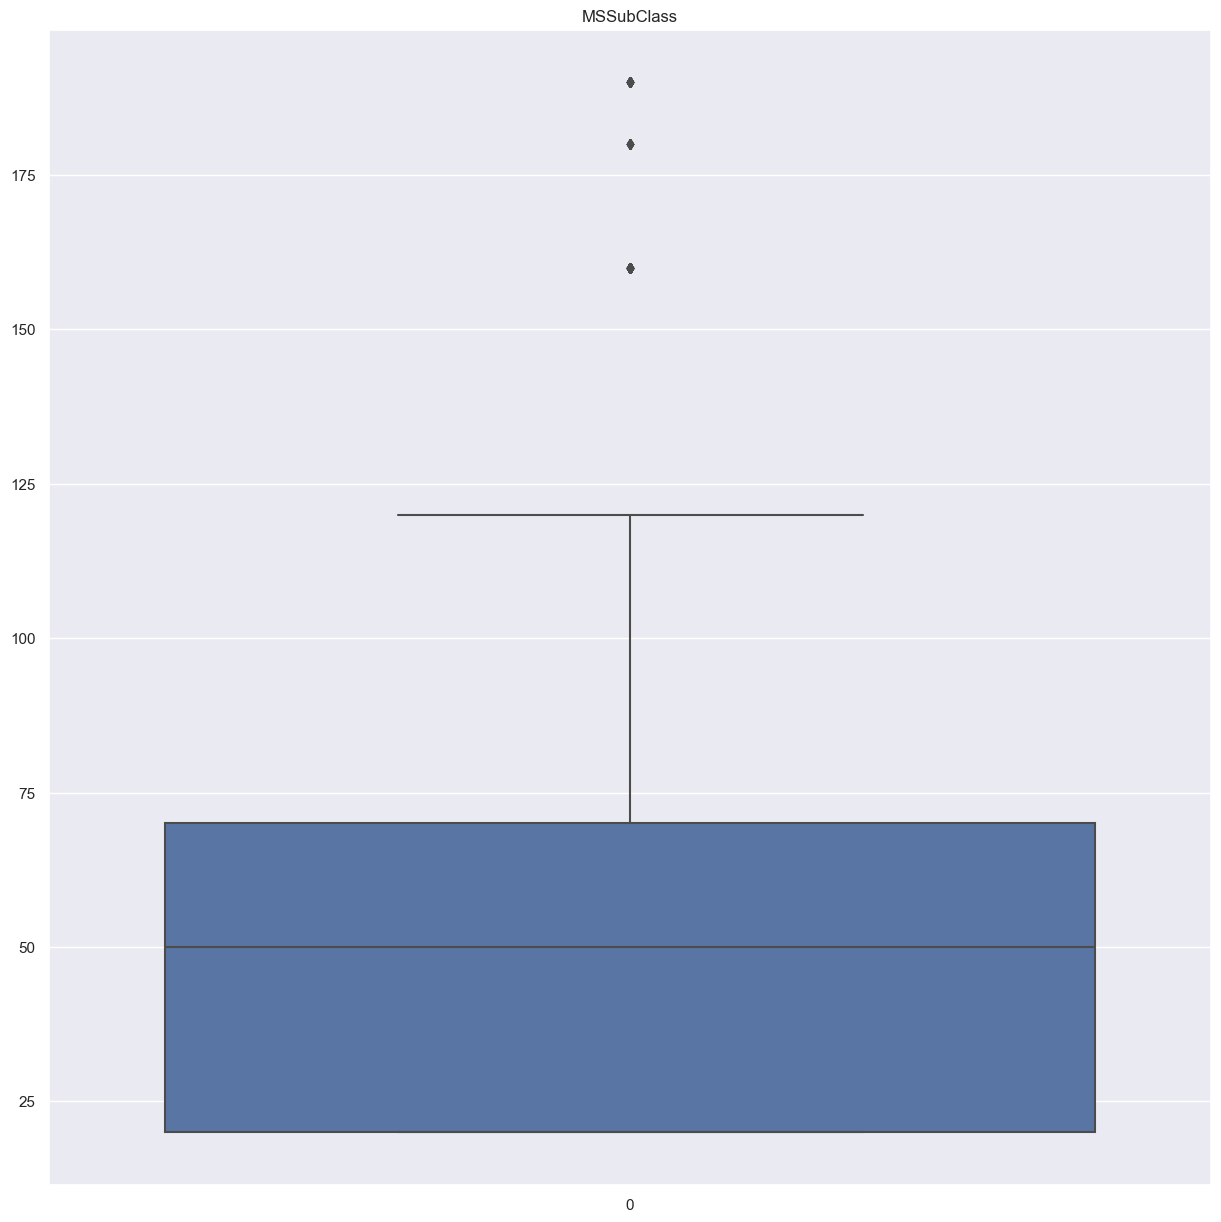

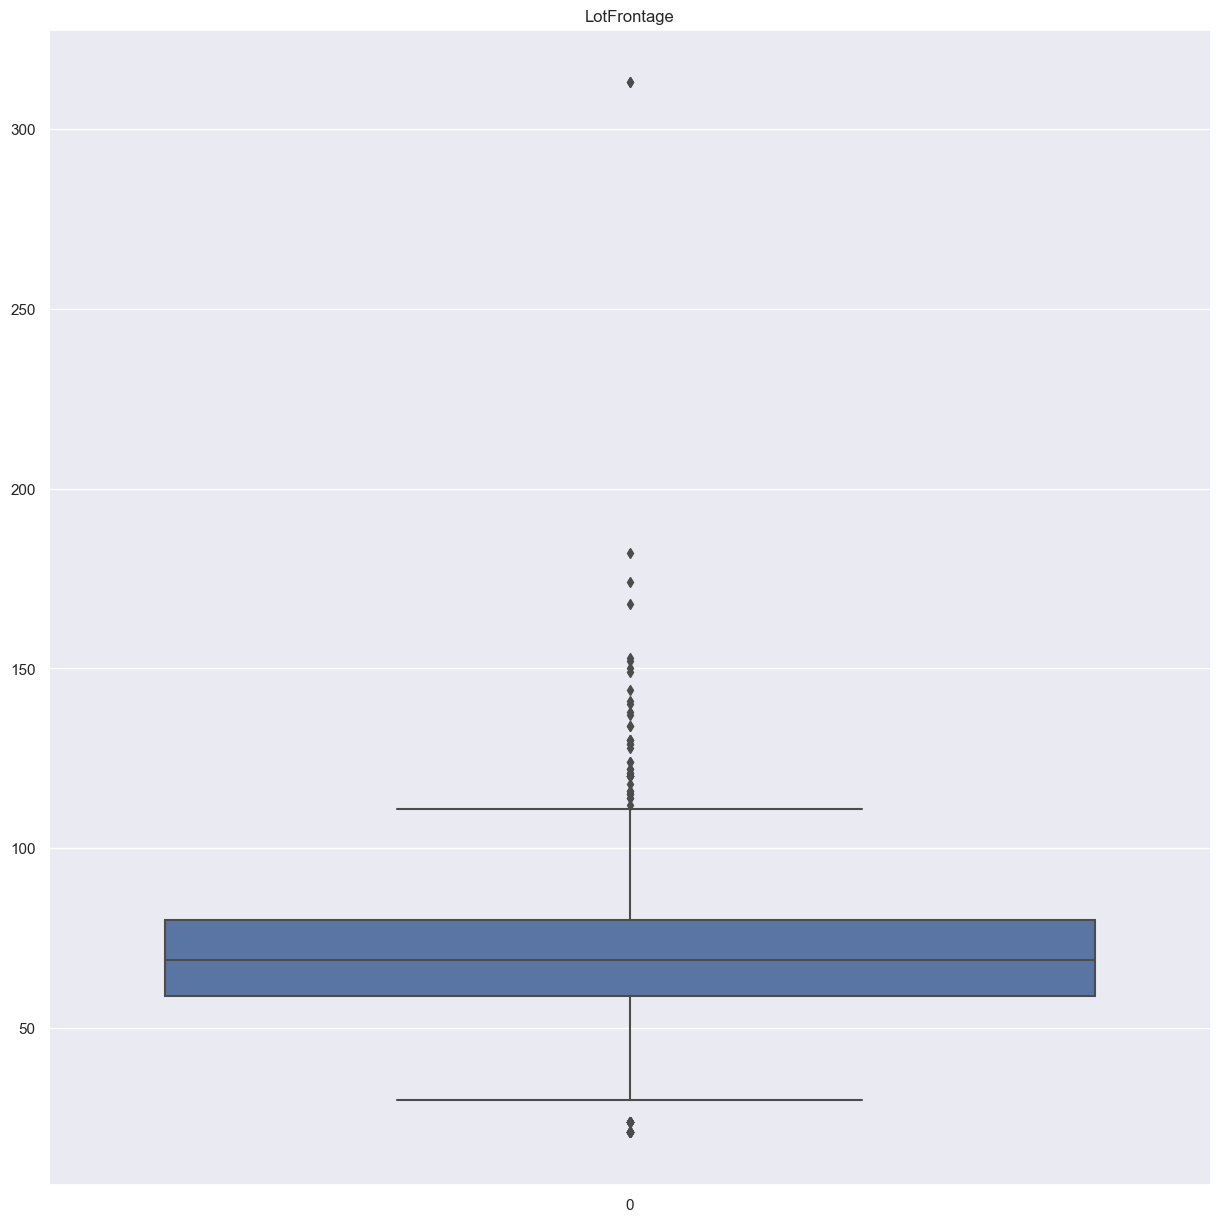

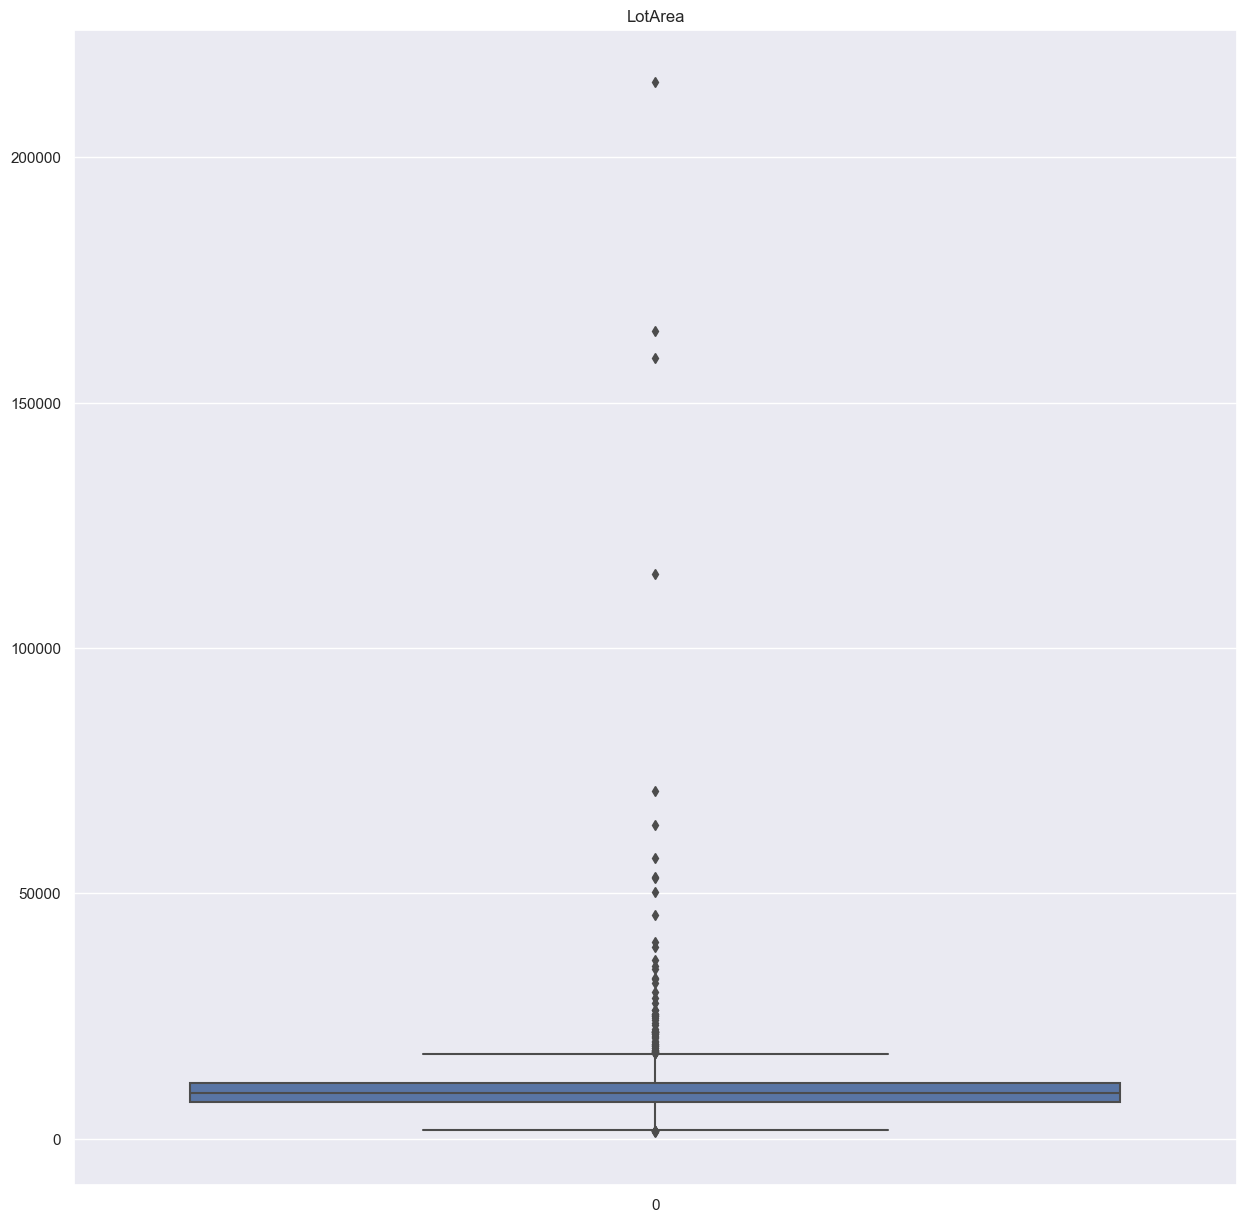

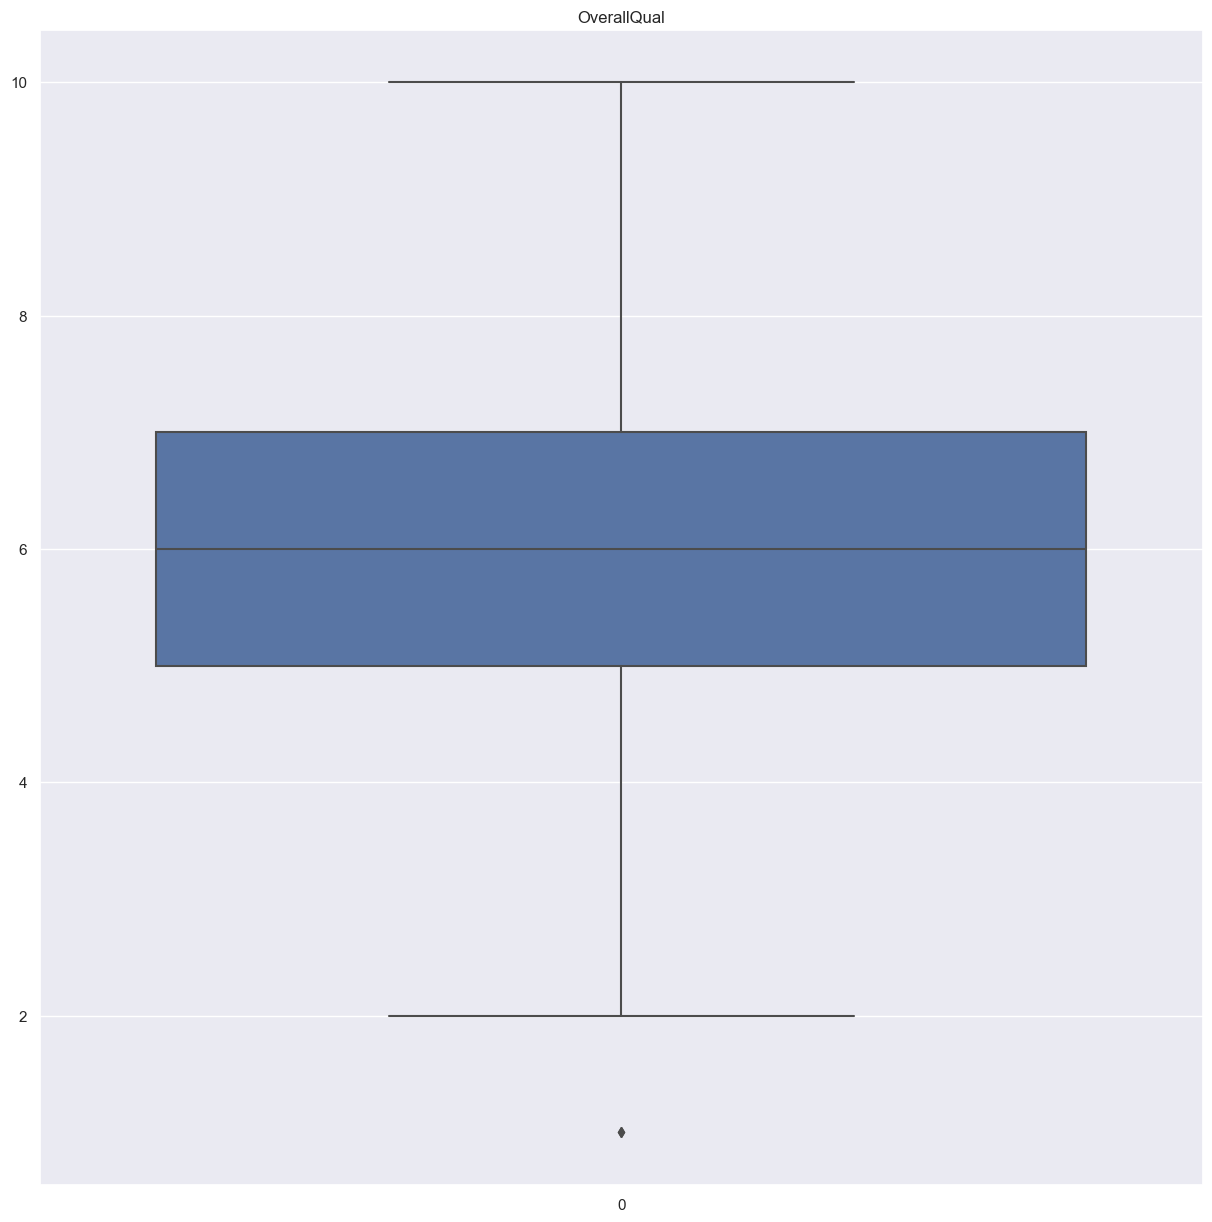

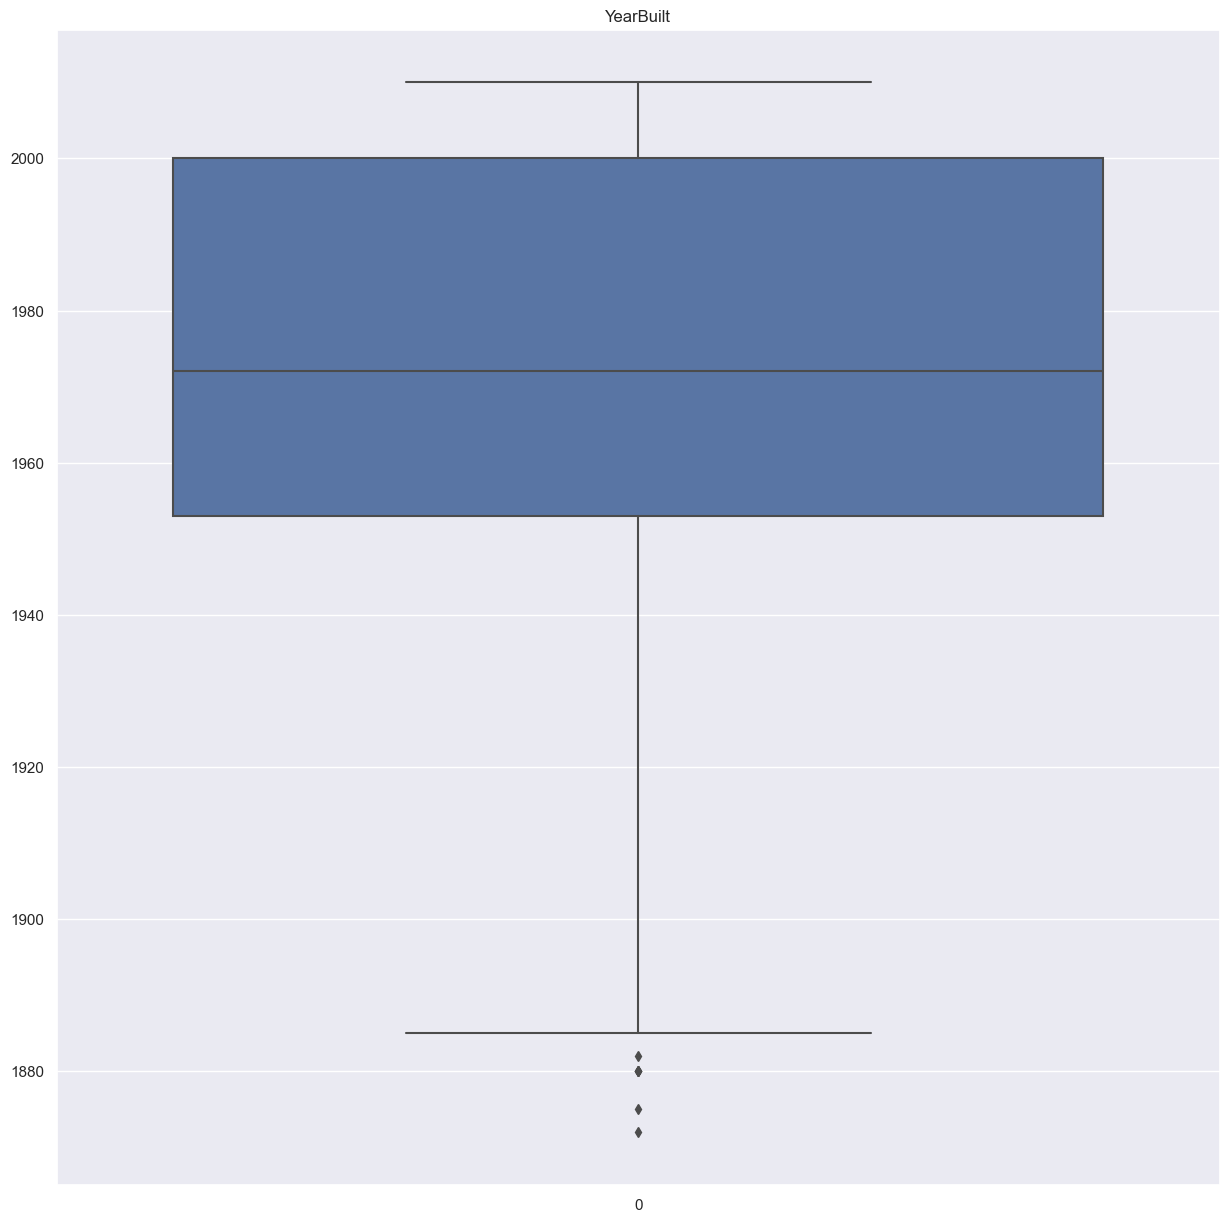

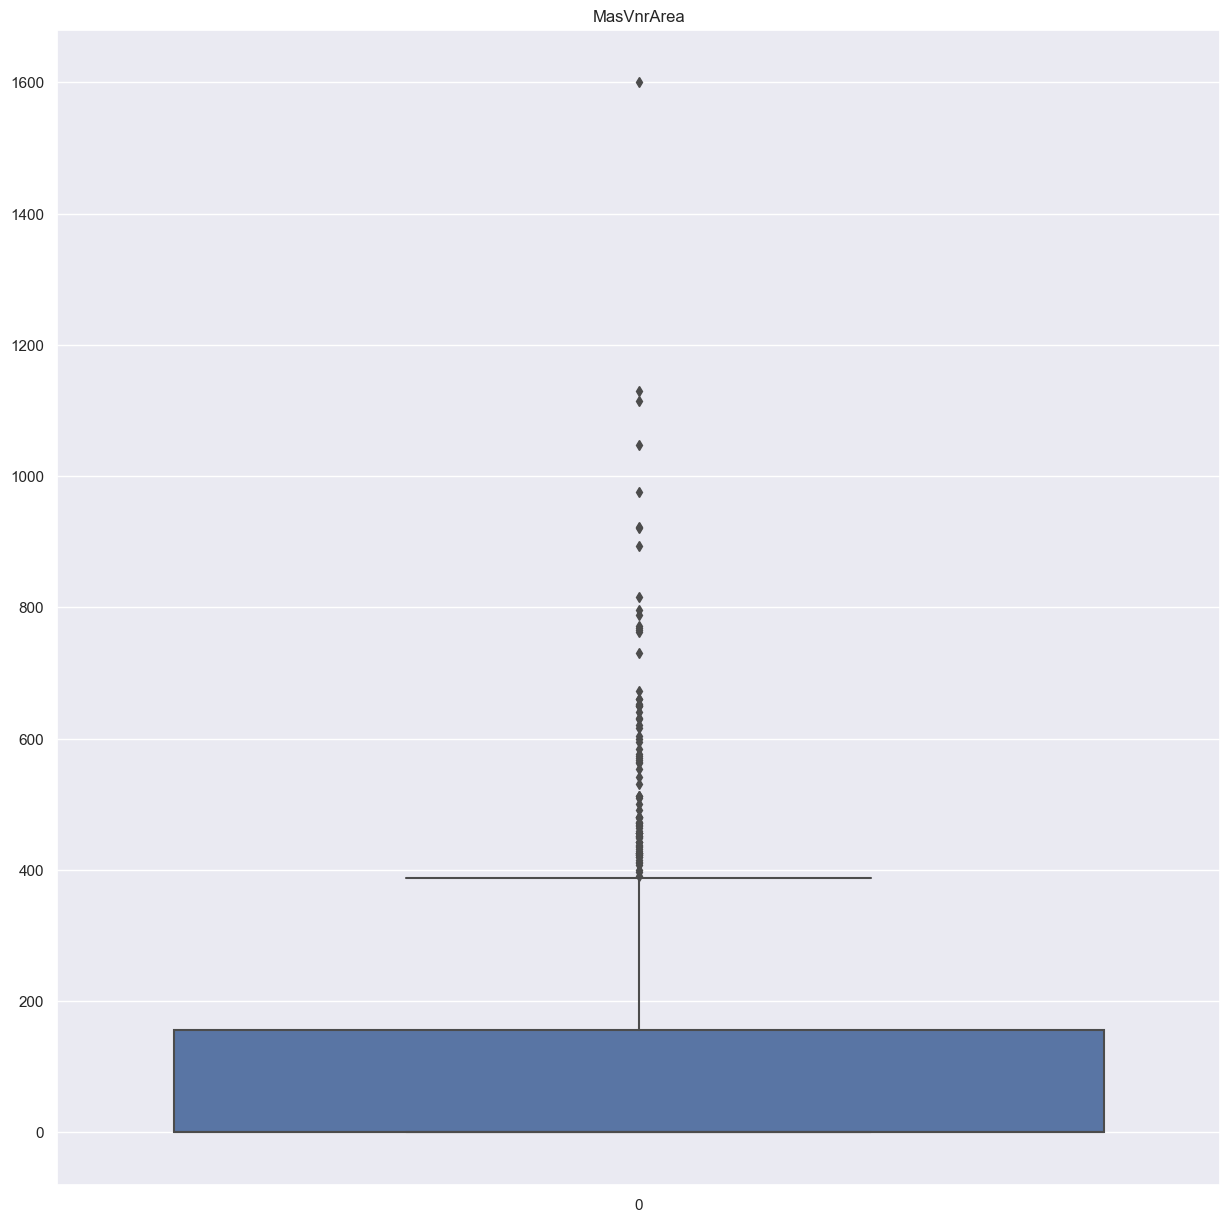

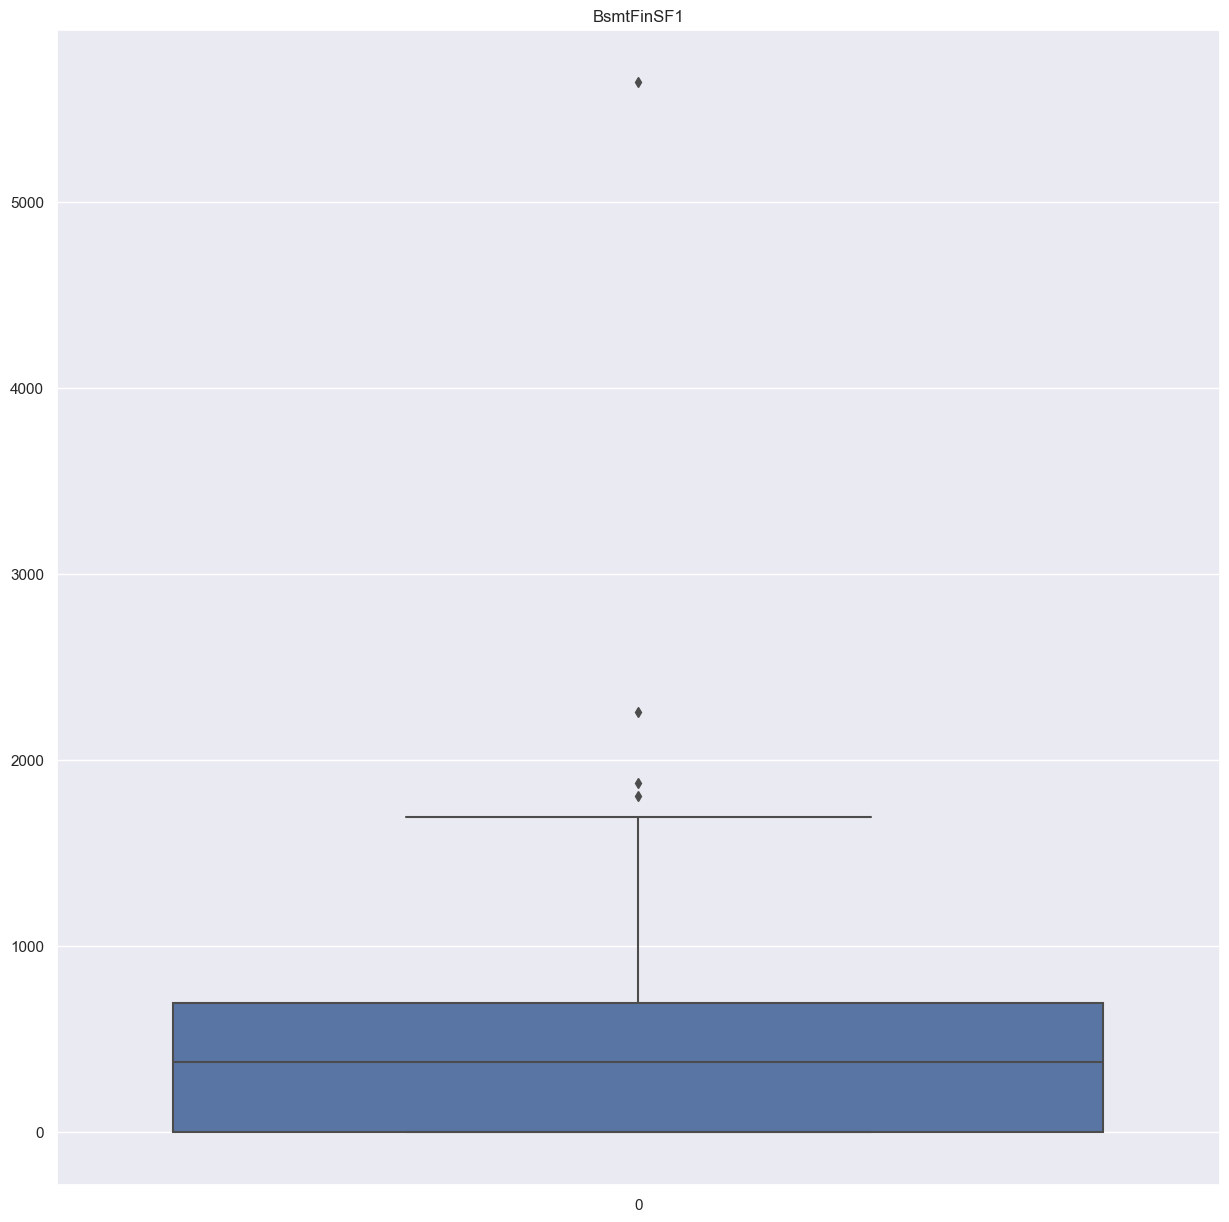

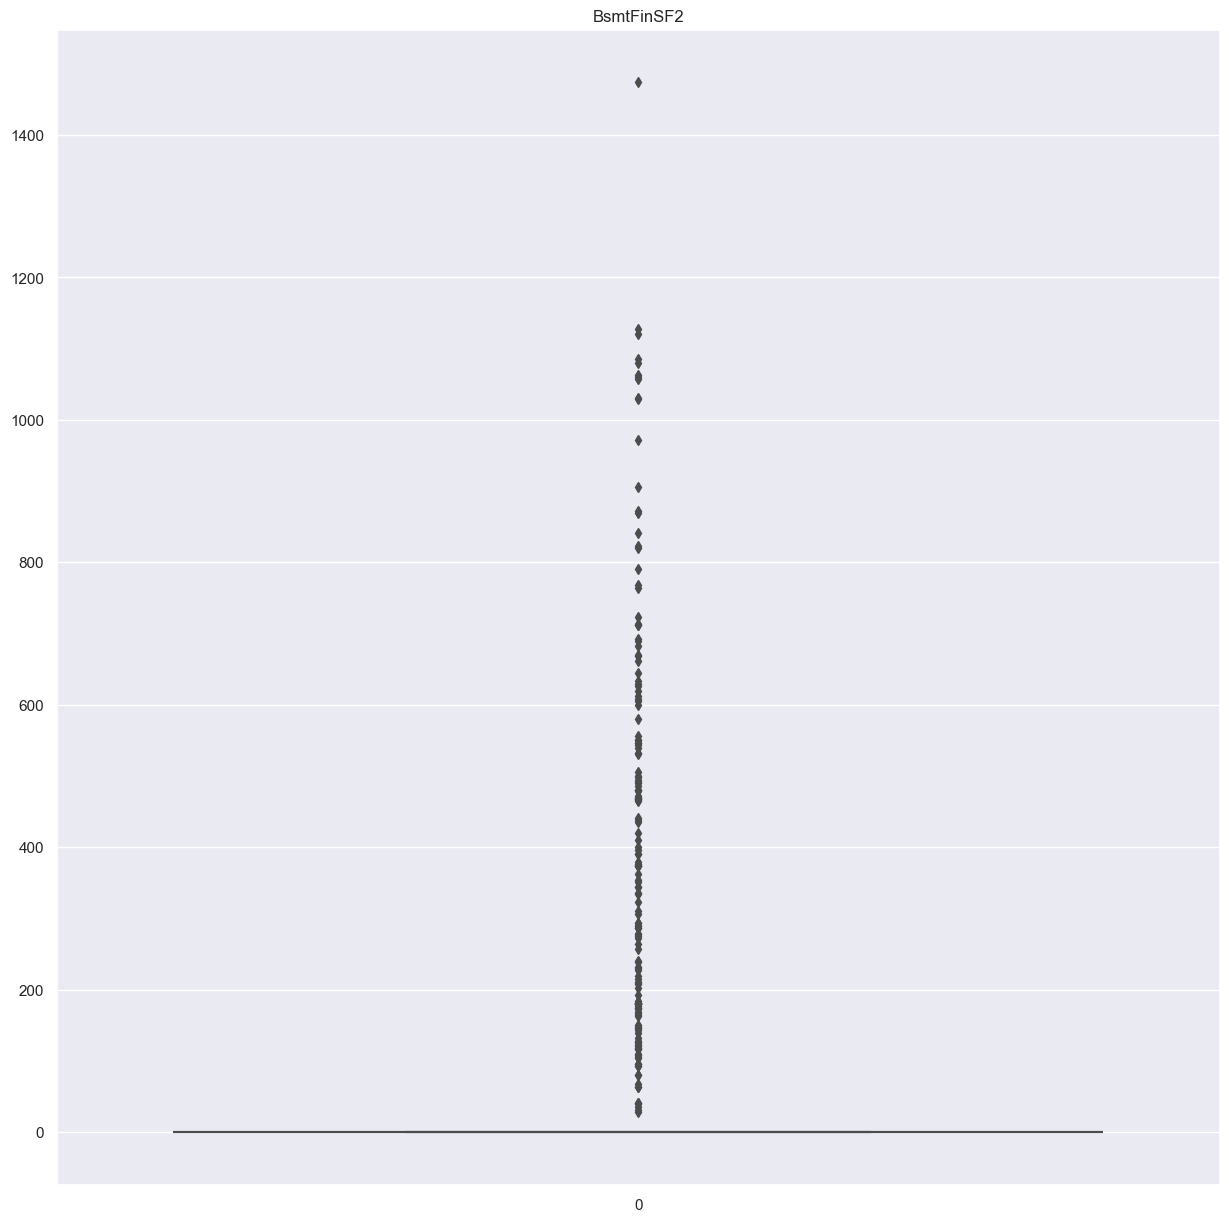

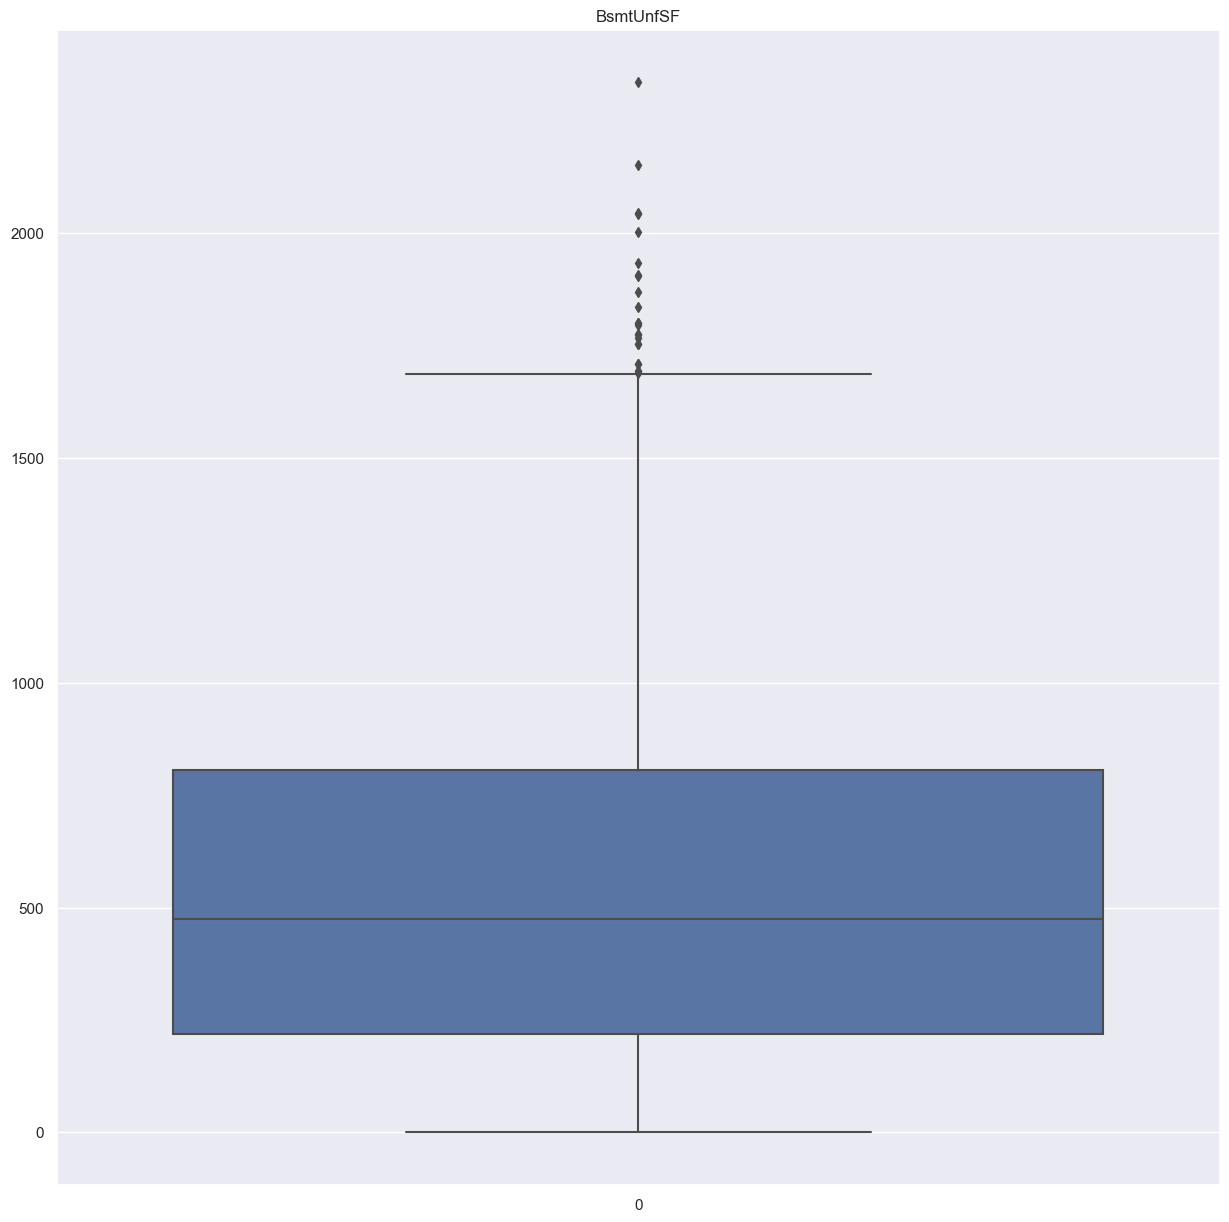

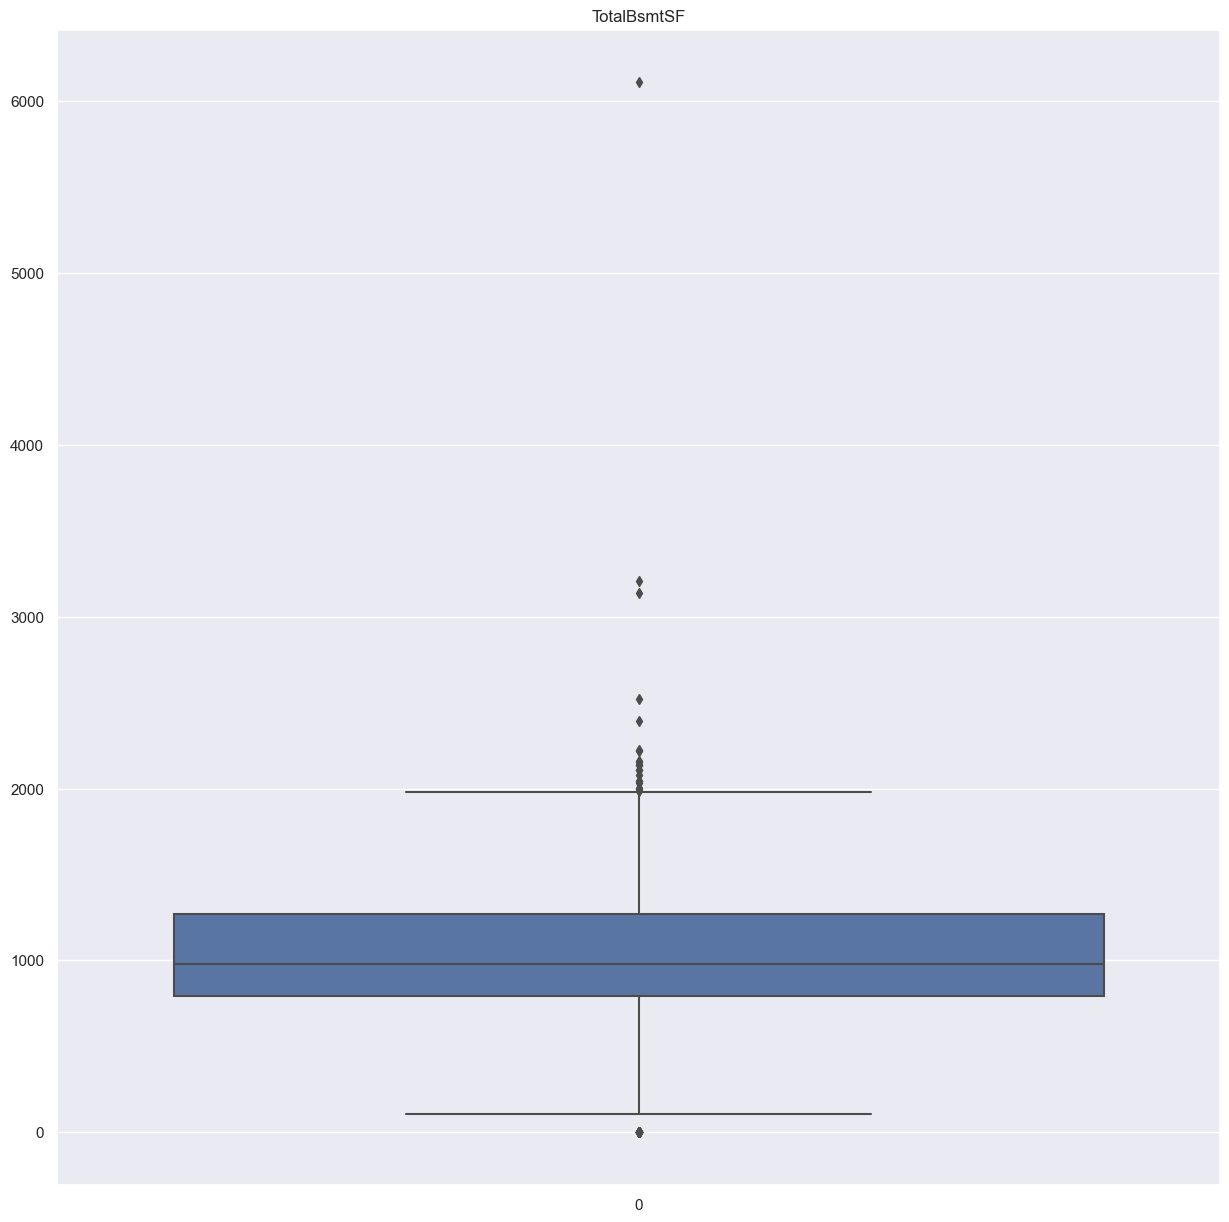

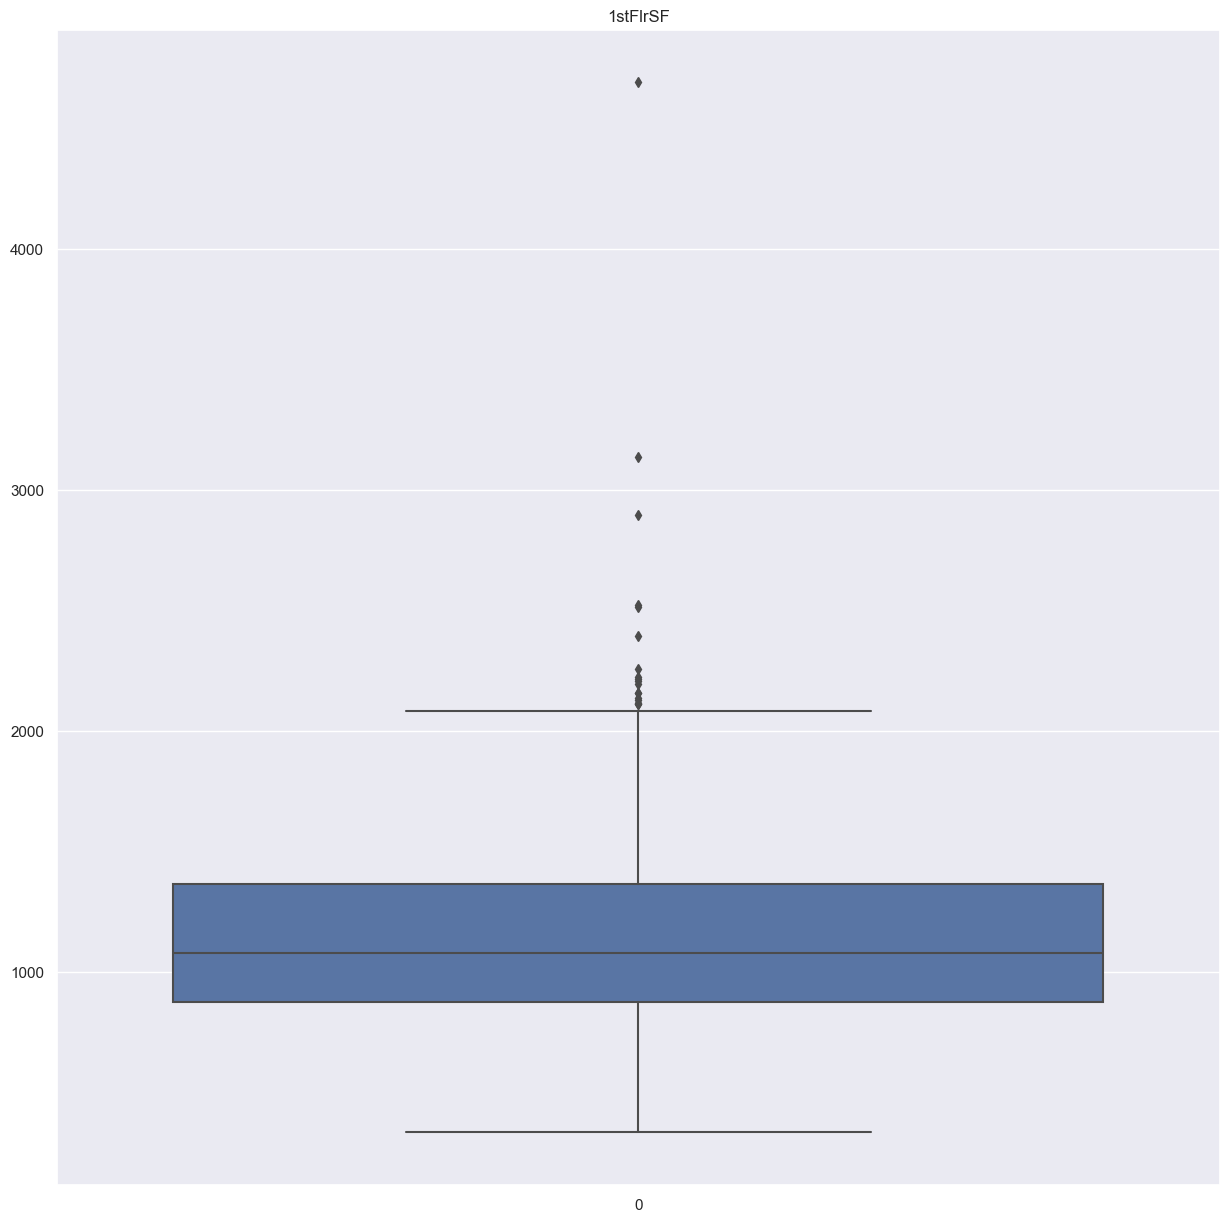

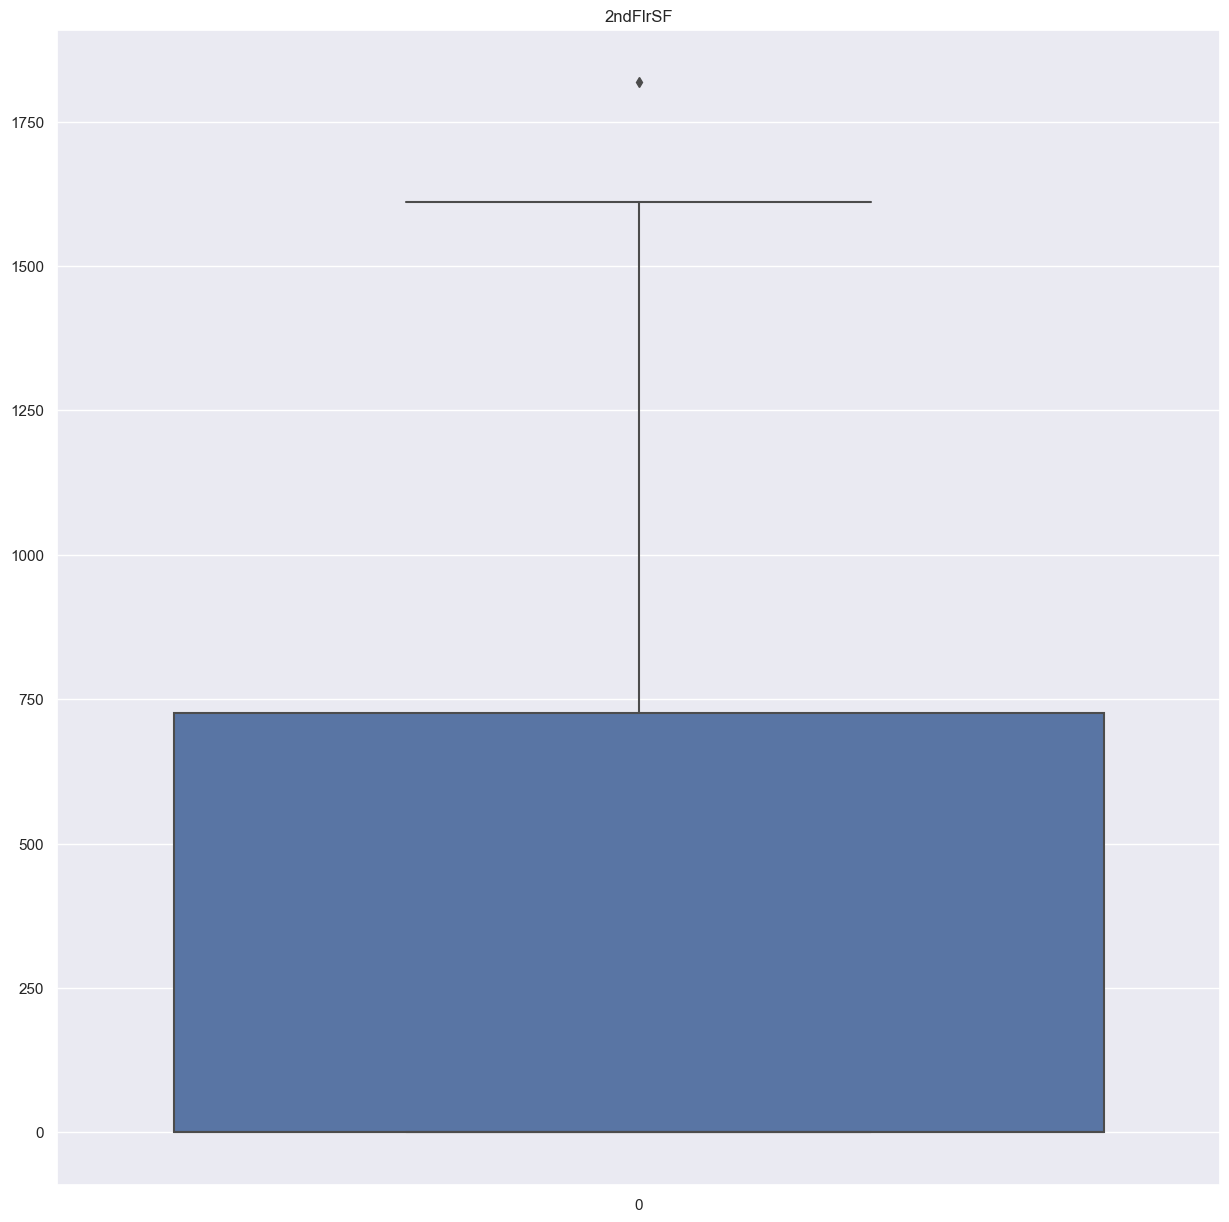

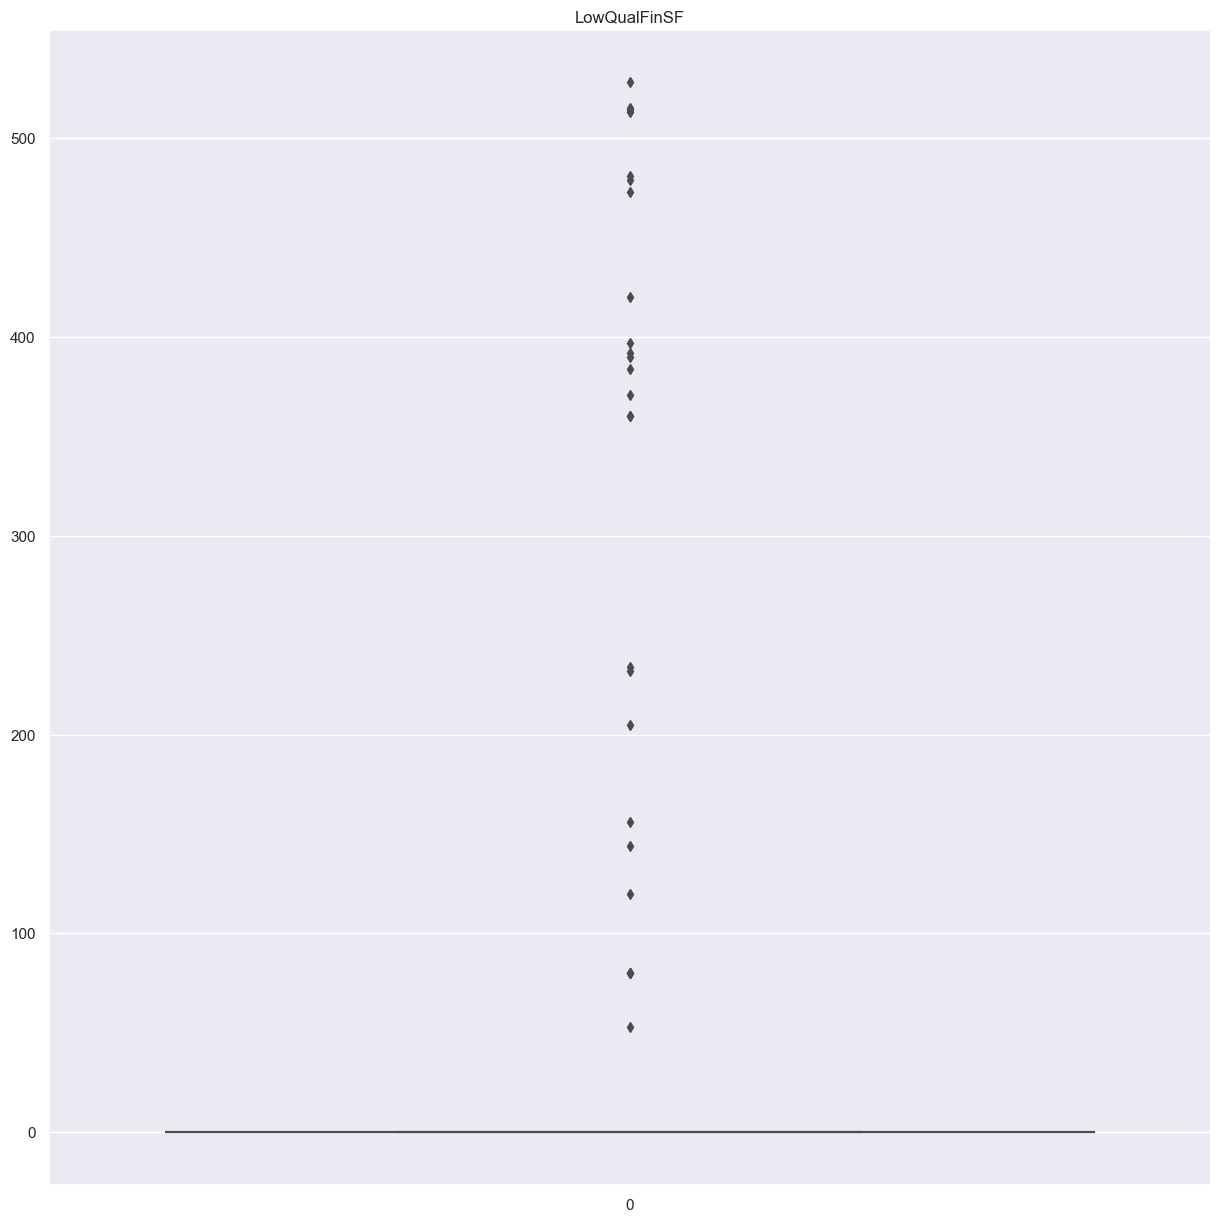

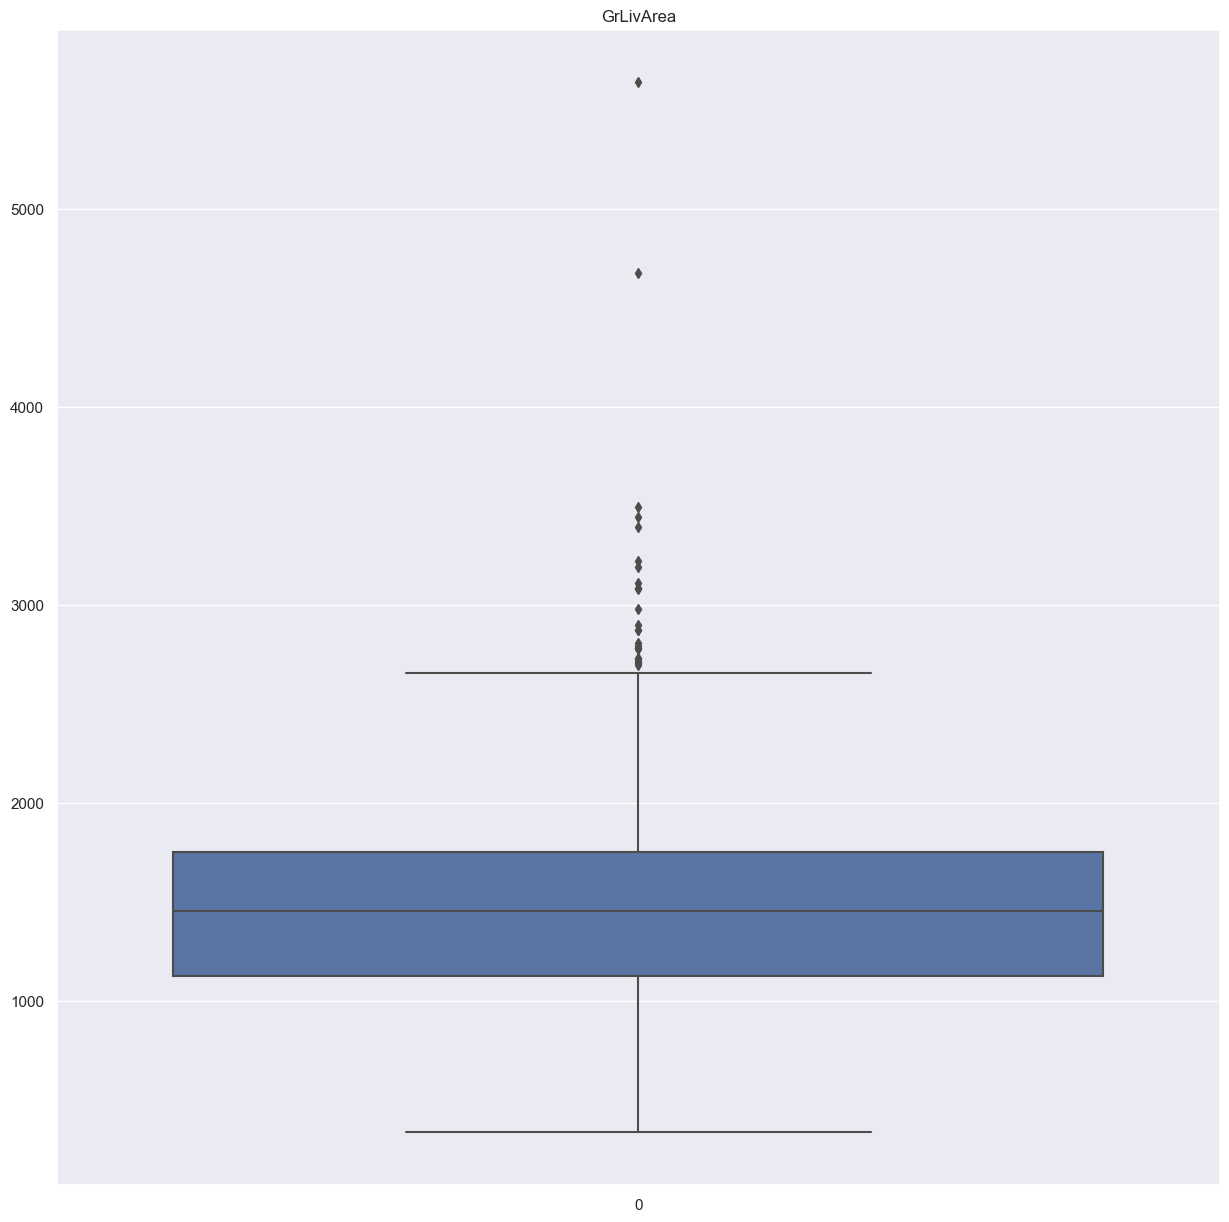

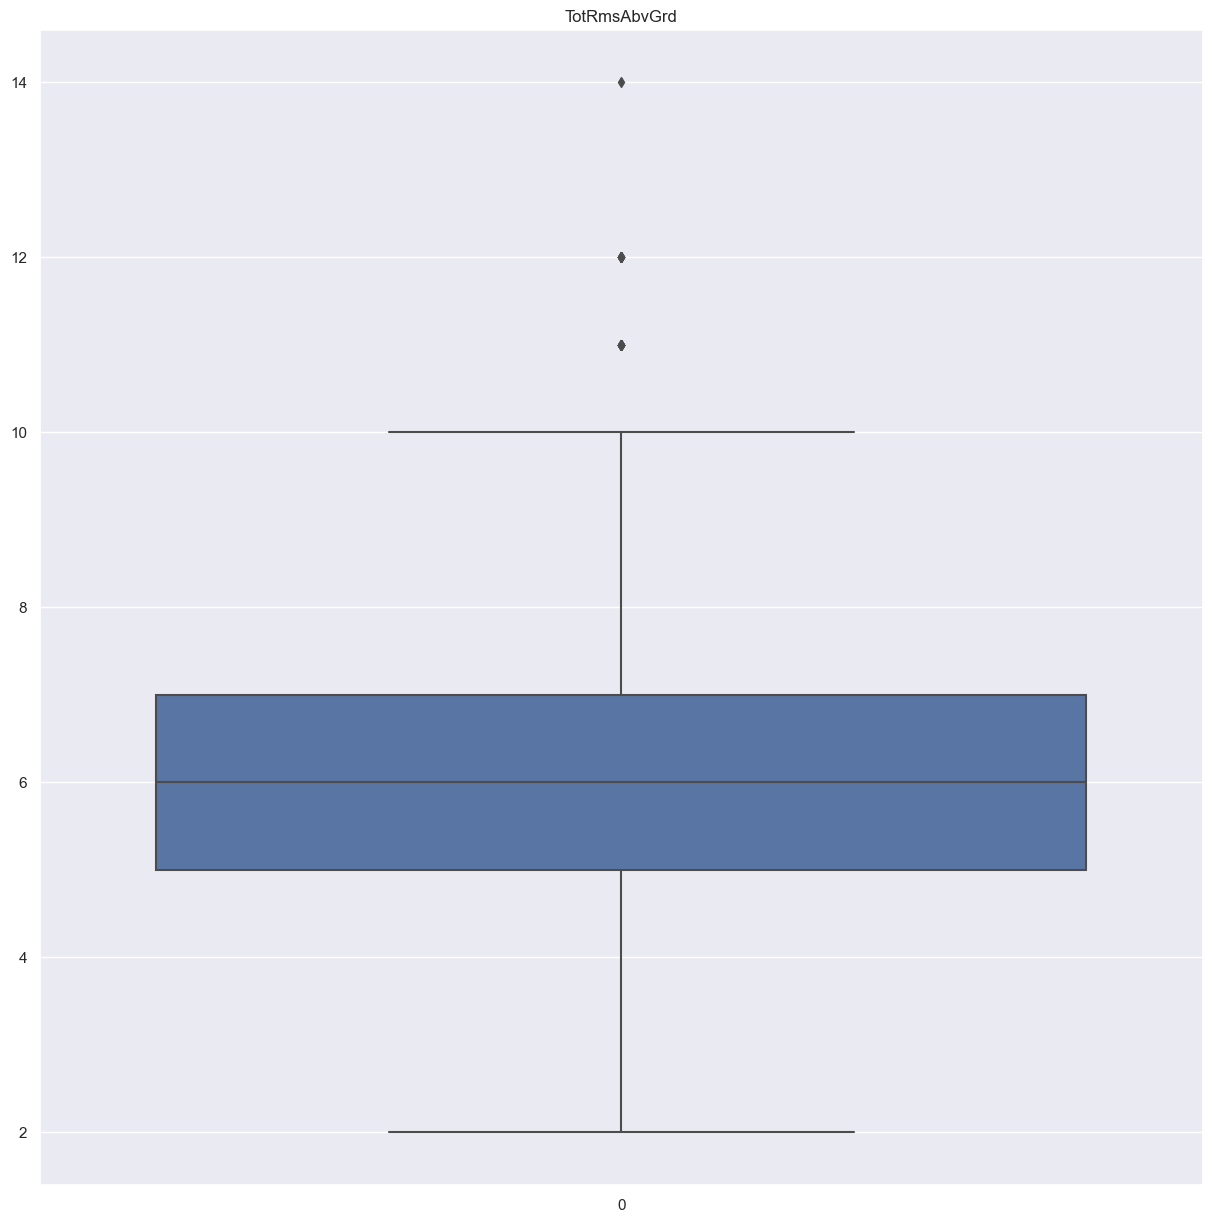

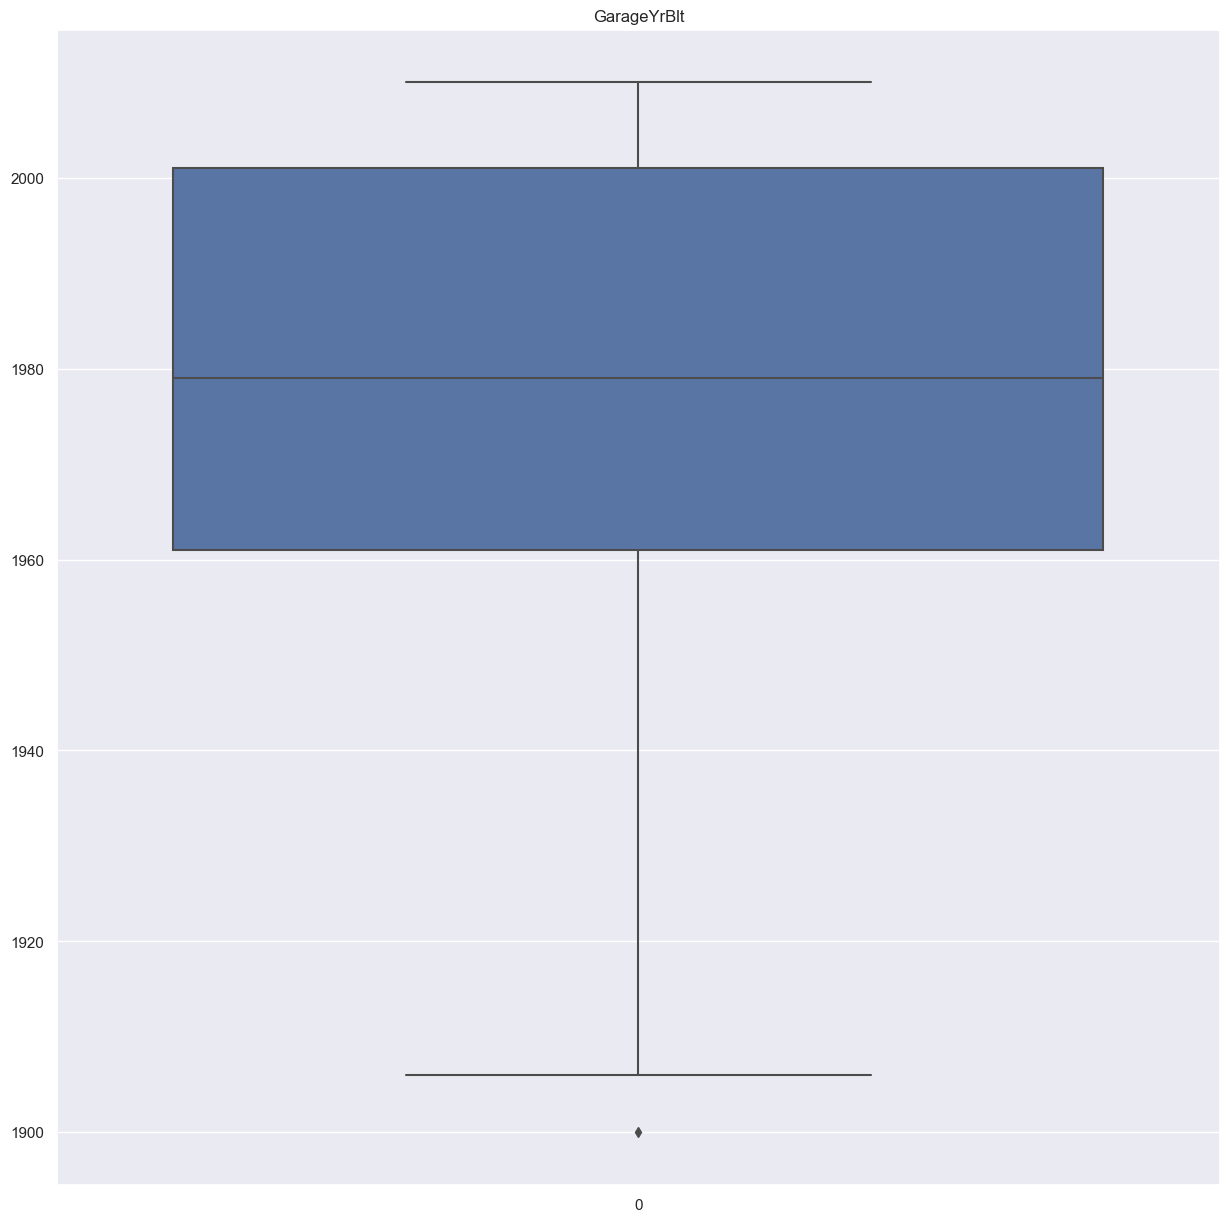

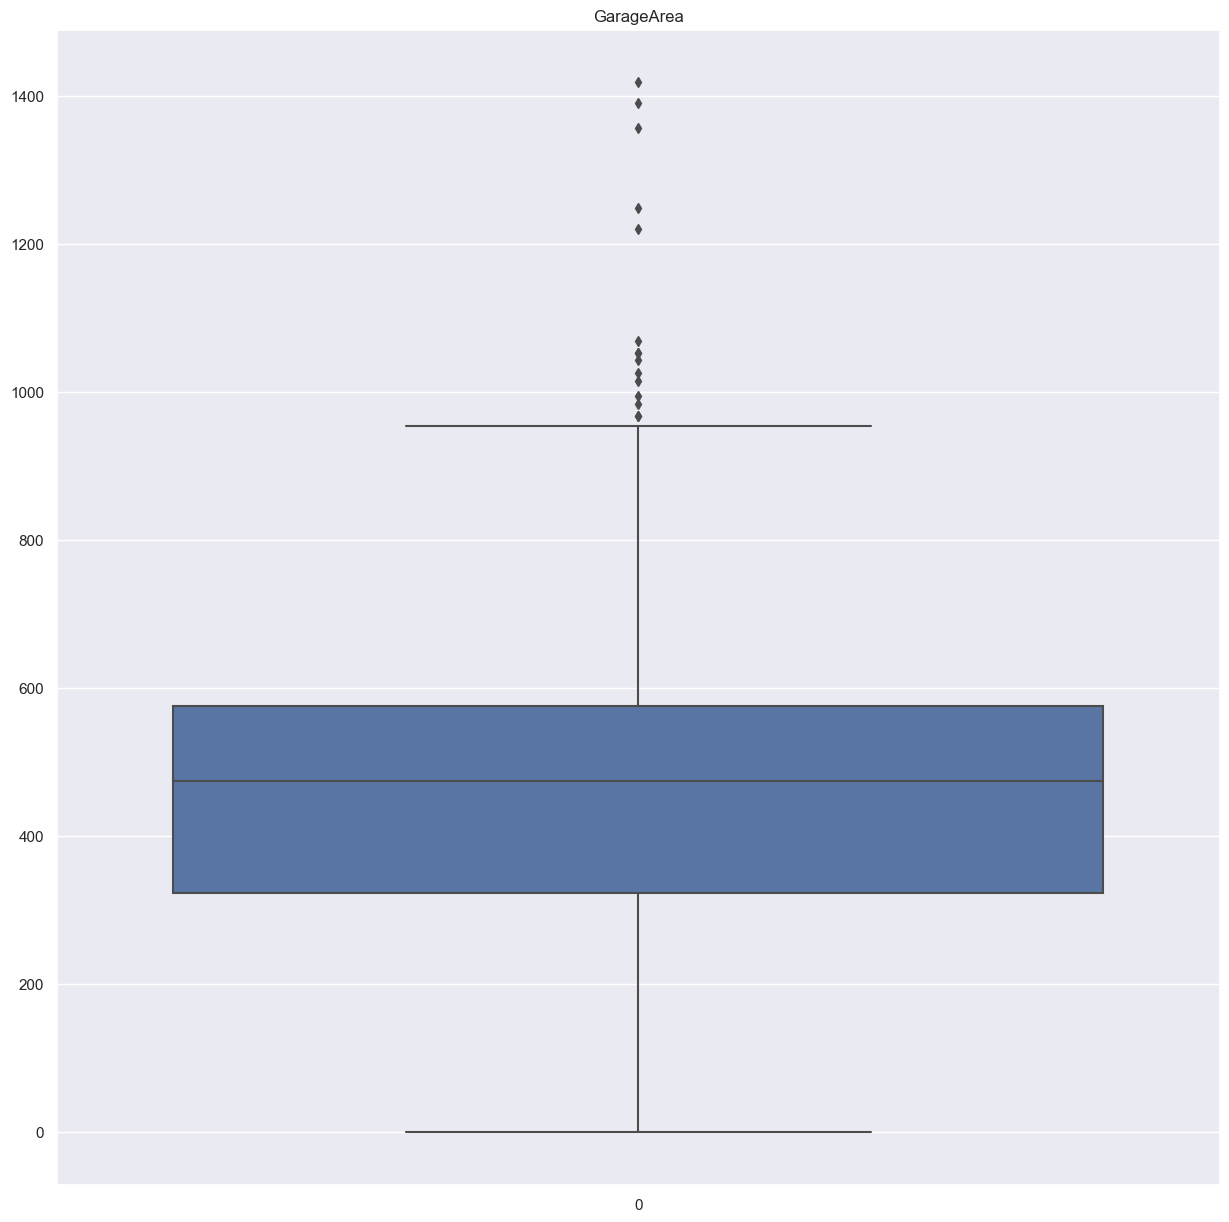

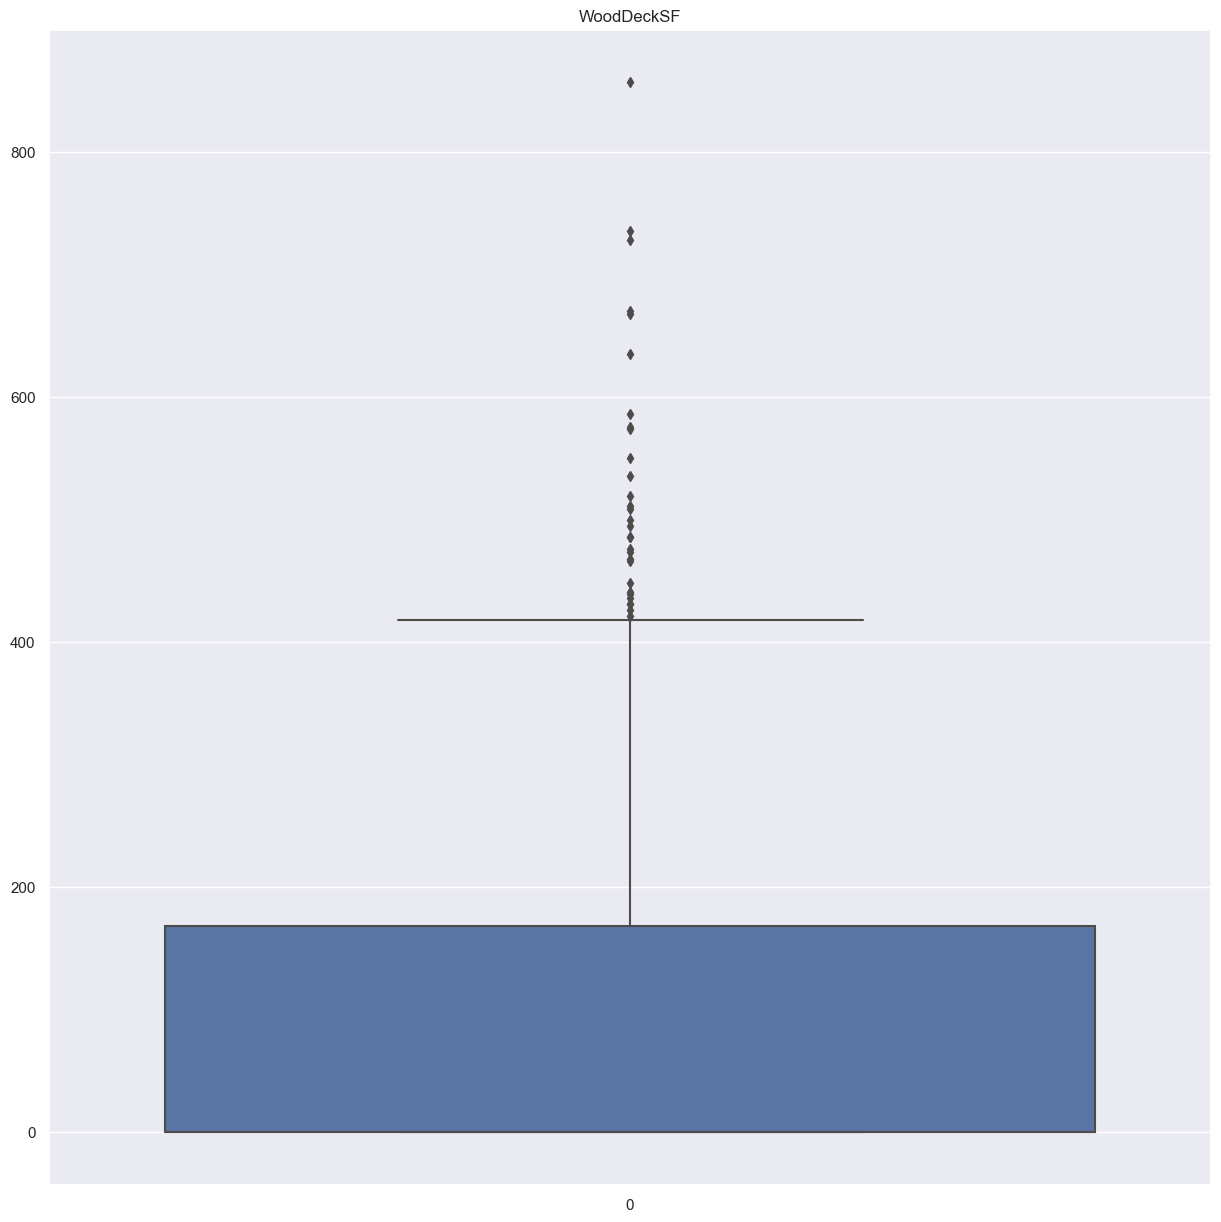

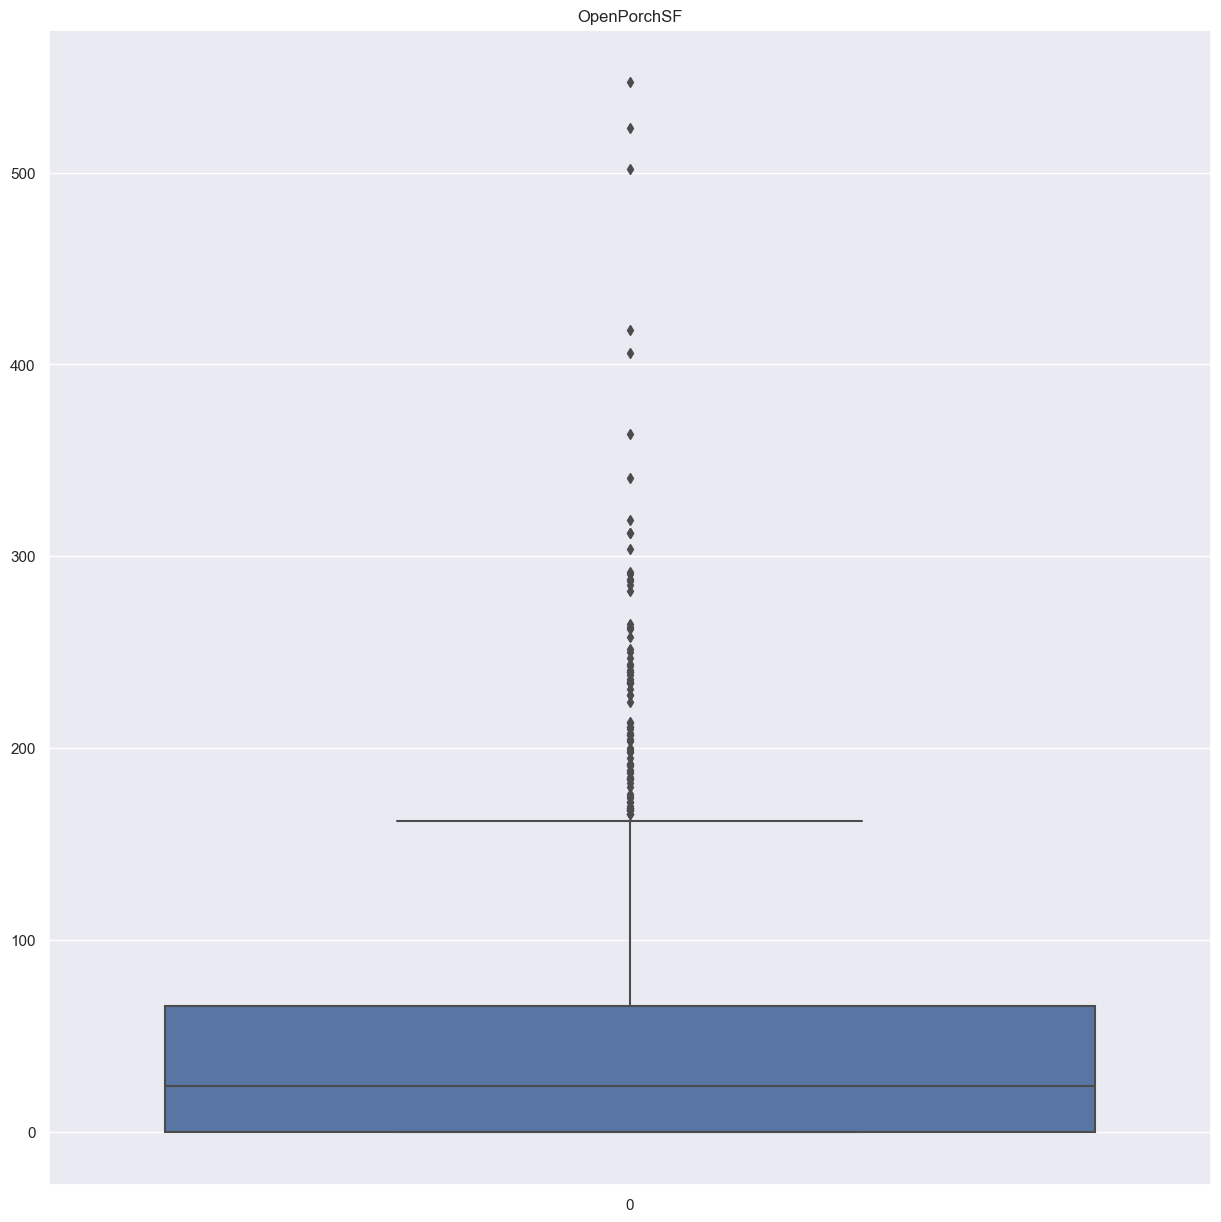

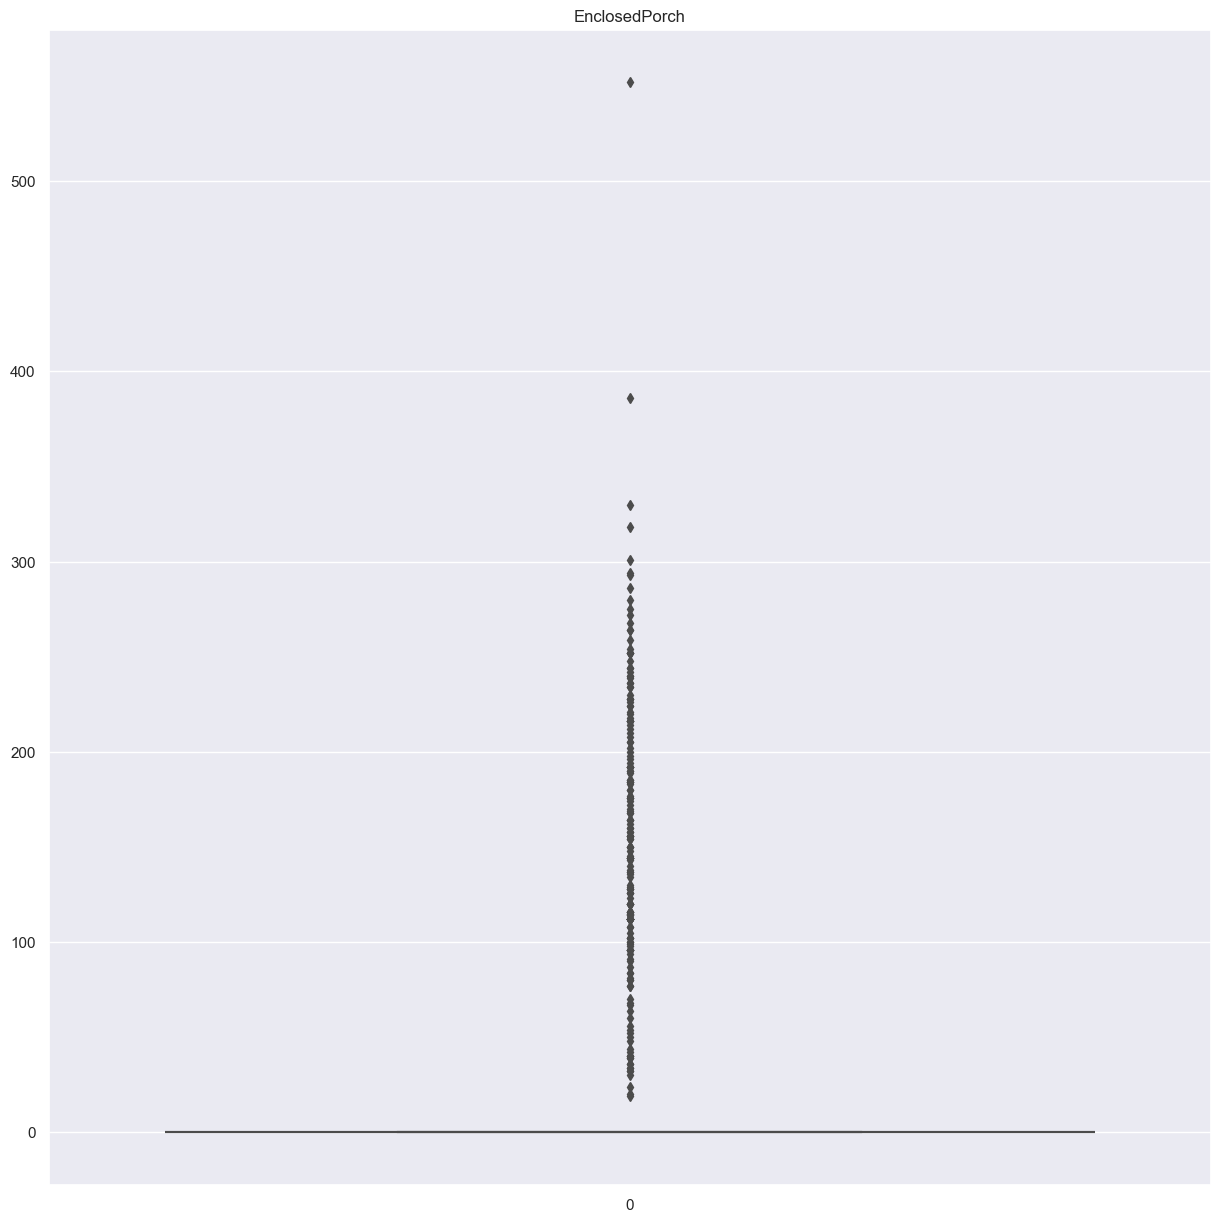

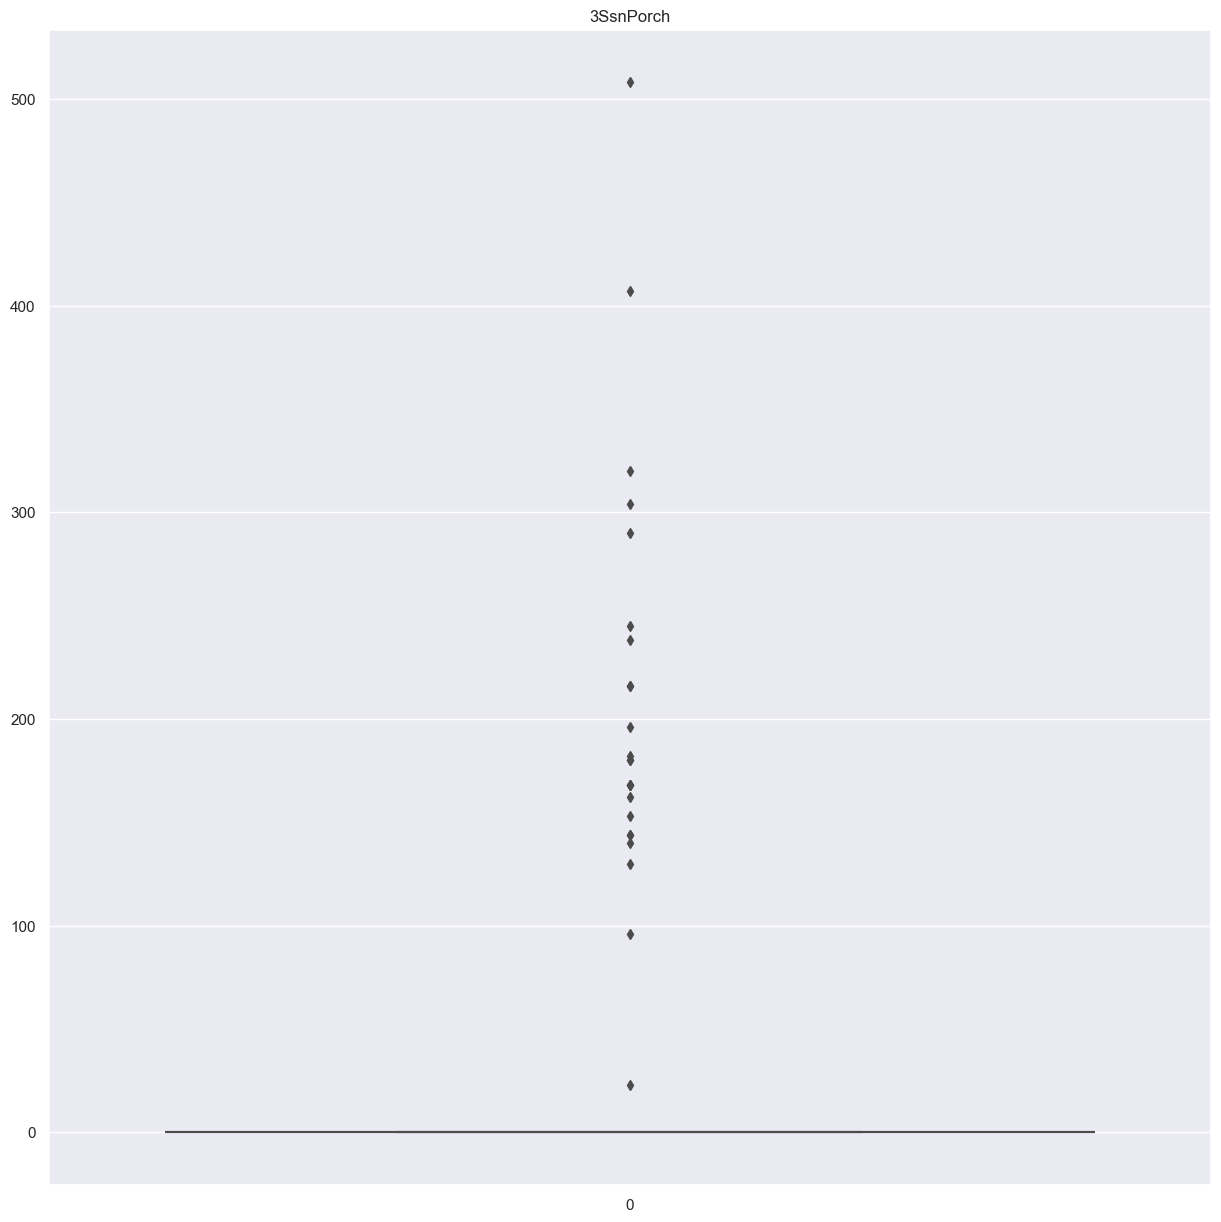

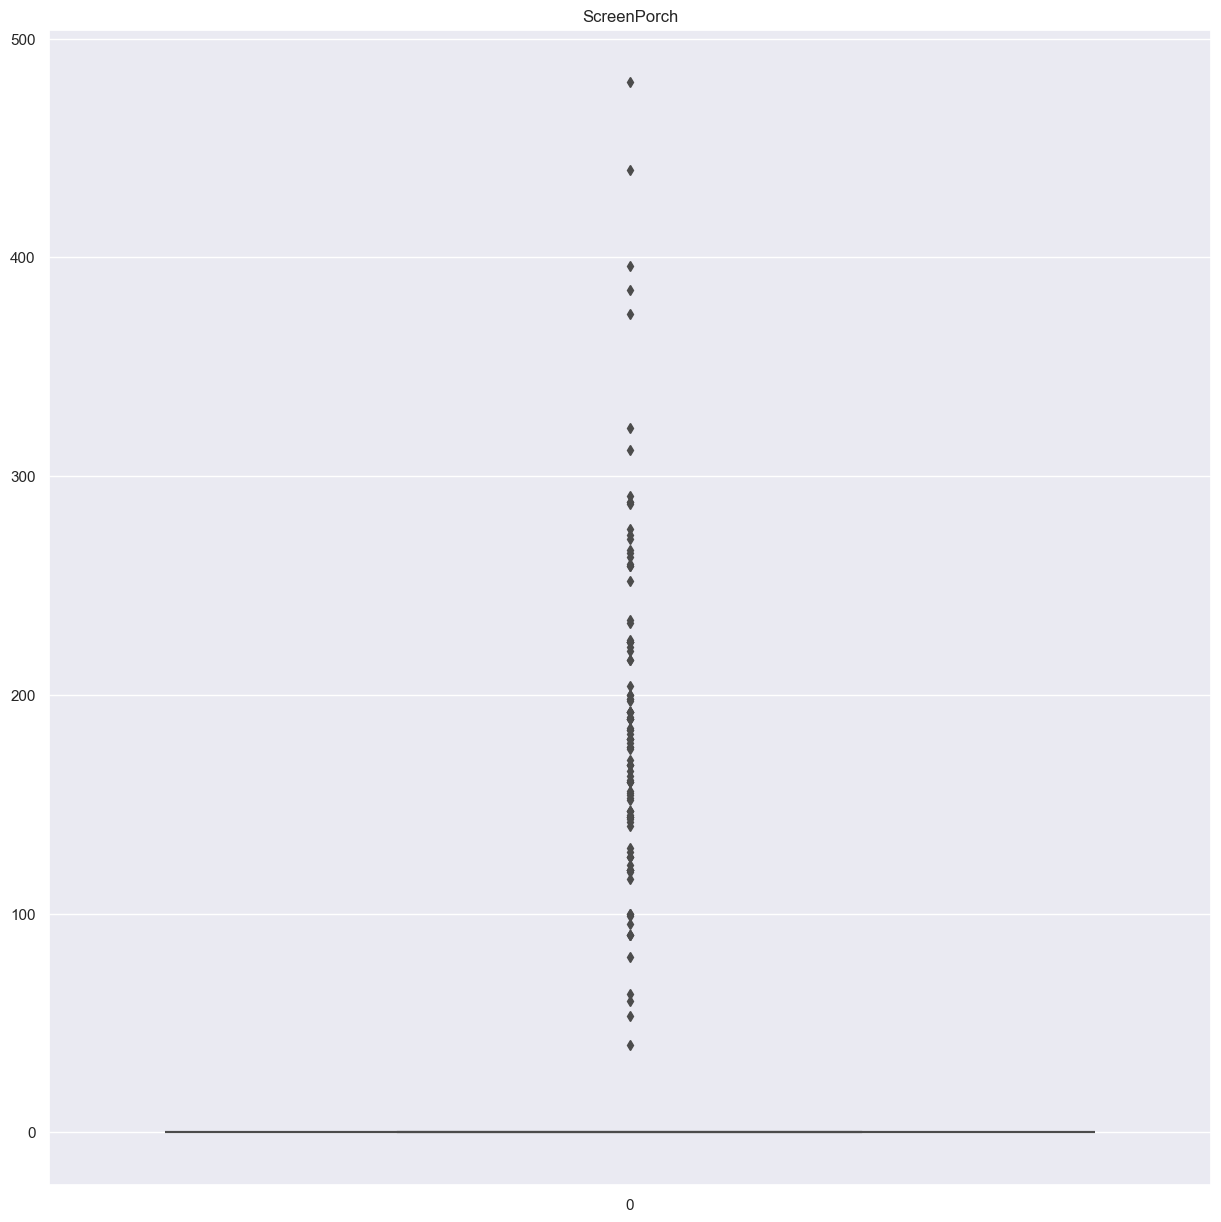

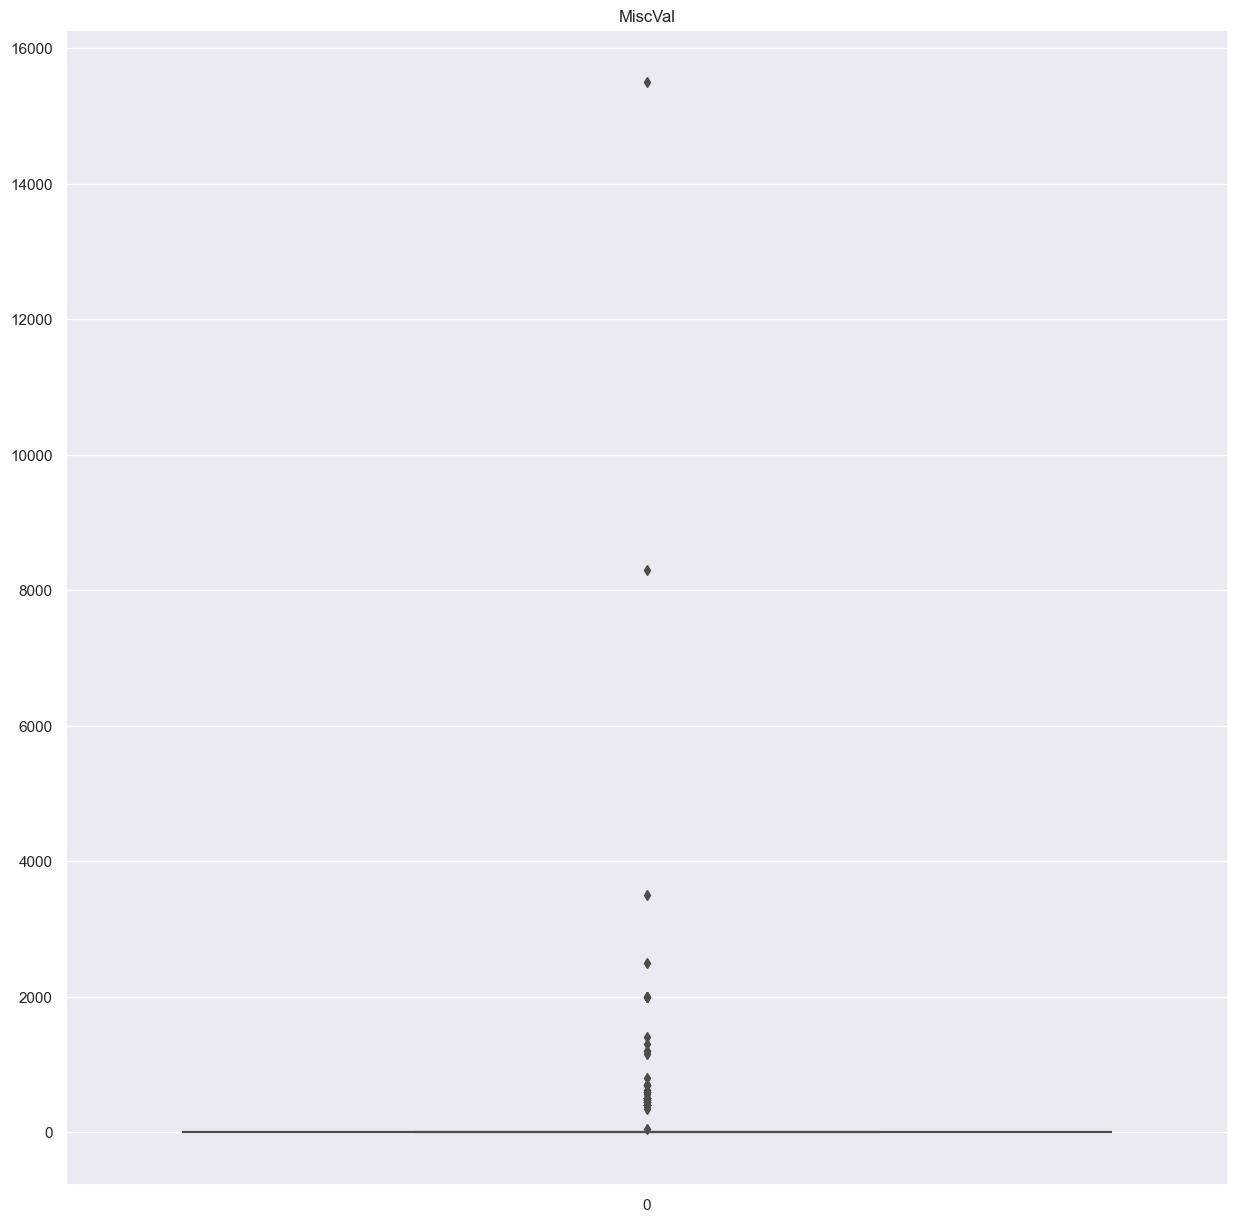

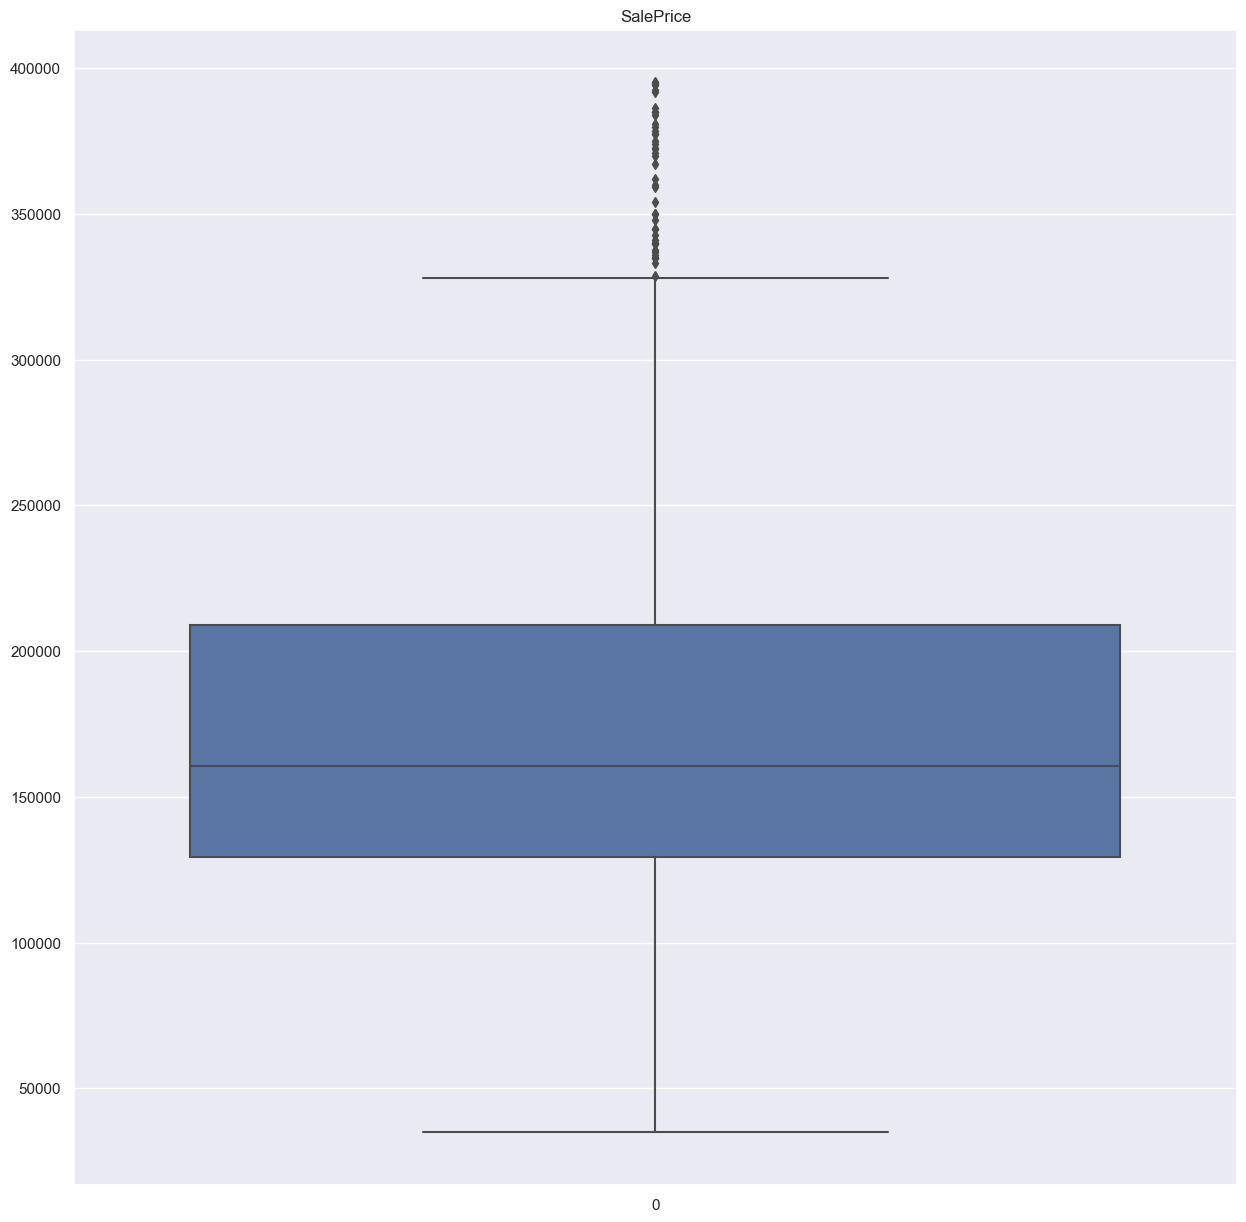

In [104]:
for col in num_cols:
    if check_outlier(df, col):
        plt.title(col)
        sns.boxplot(df[col])
        plt.show()

In [105]:
for col in num_cols:
    count = count_outliers(df, col, q1=0.1, q3=0.9)
    print(col, ':', count)

Id : 0
MSSubClass : 0
LotFrontage : 4
LotArea : 21
OverallQual : 0
YearBuilt : 0
YearRemodAdd : 0
MasVnrArea : 11
BsmtFinSF1 : 1
BsmtFinSF2 : 91
BsmtUnfSF : 0
TotalBsmtSF : 3
1stFlrSF : 2
2ndFlrSF : 0
LowQualFinSF : 25
GrLivArea : 2
TotRmsAbvGrd : 1
GarageYrBlt : 0
GarageArea : 0
WoodDeckSF : 5
OpenPorchSF : 7
EnclosedPorch : 8
3SsnPorch : 24
ScreenPorch : 111
MiscVal : 52
MoSold : 0
SalePrice : 0


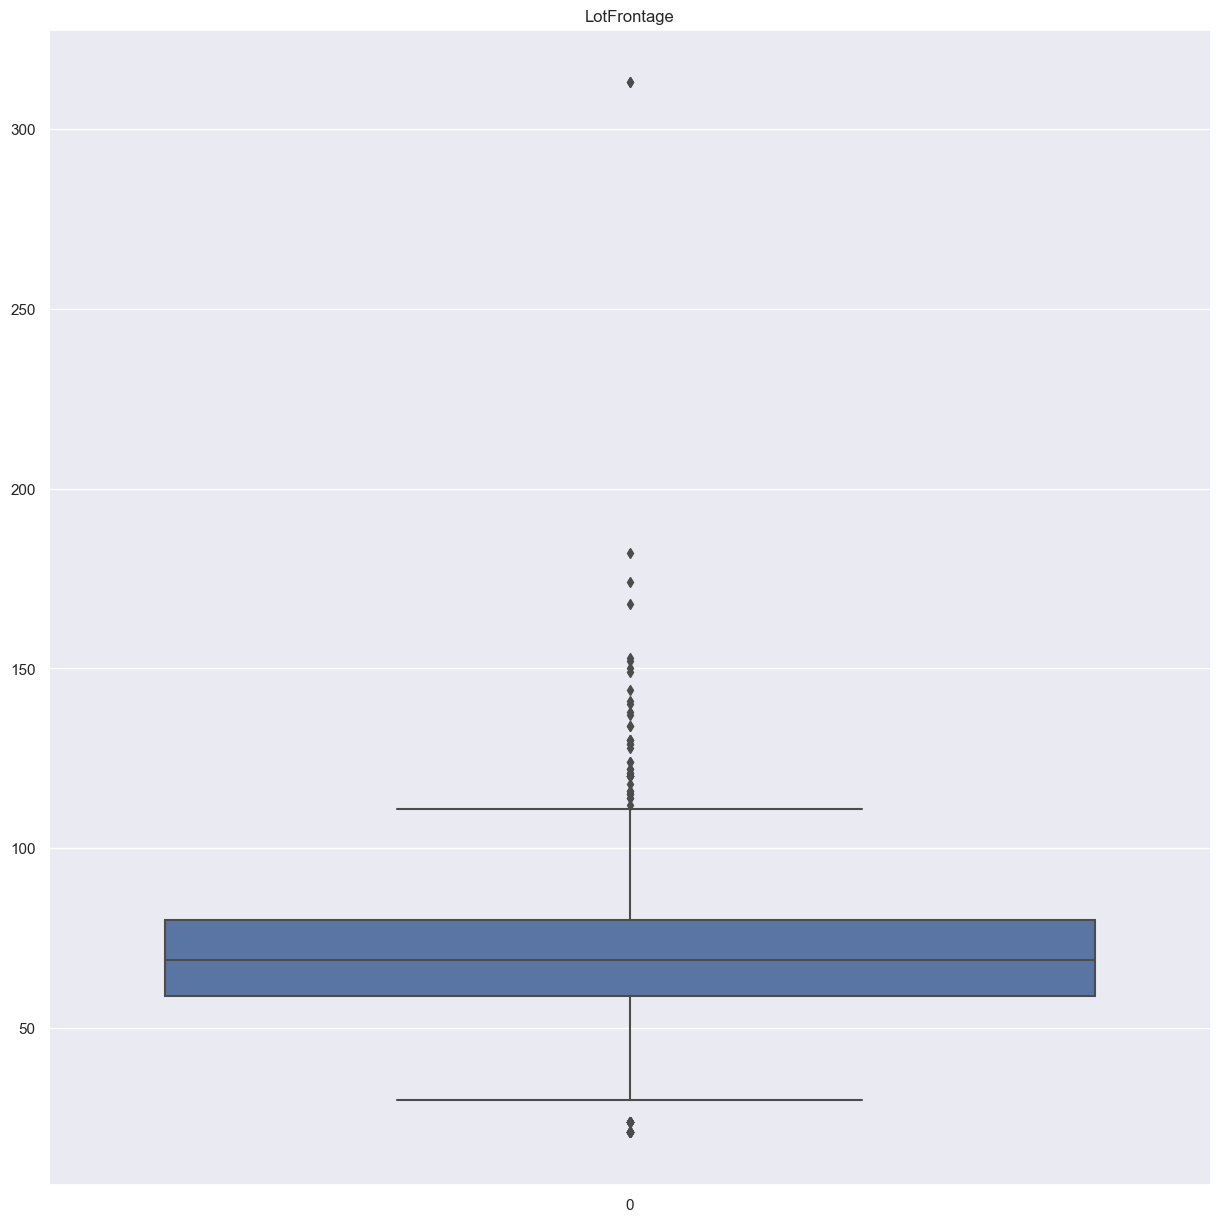

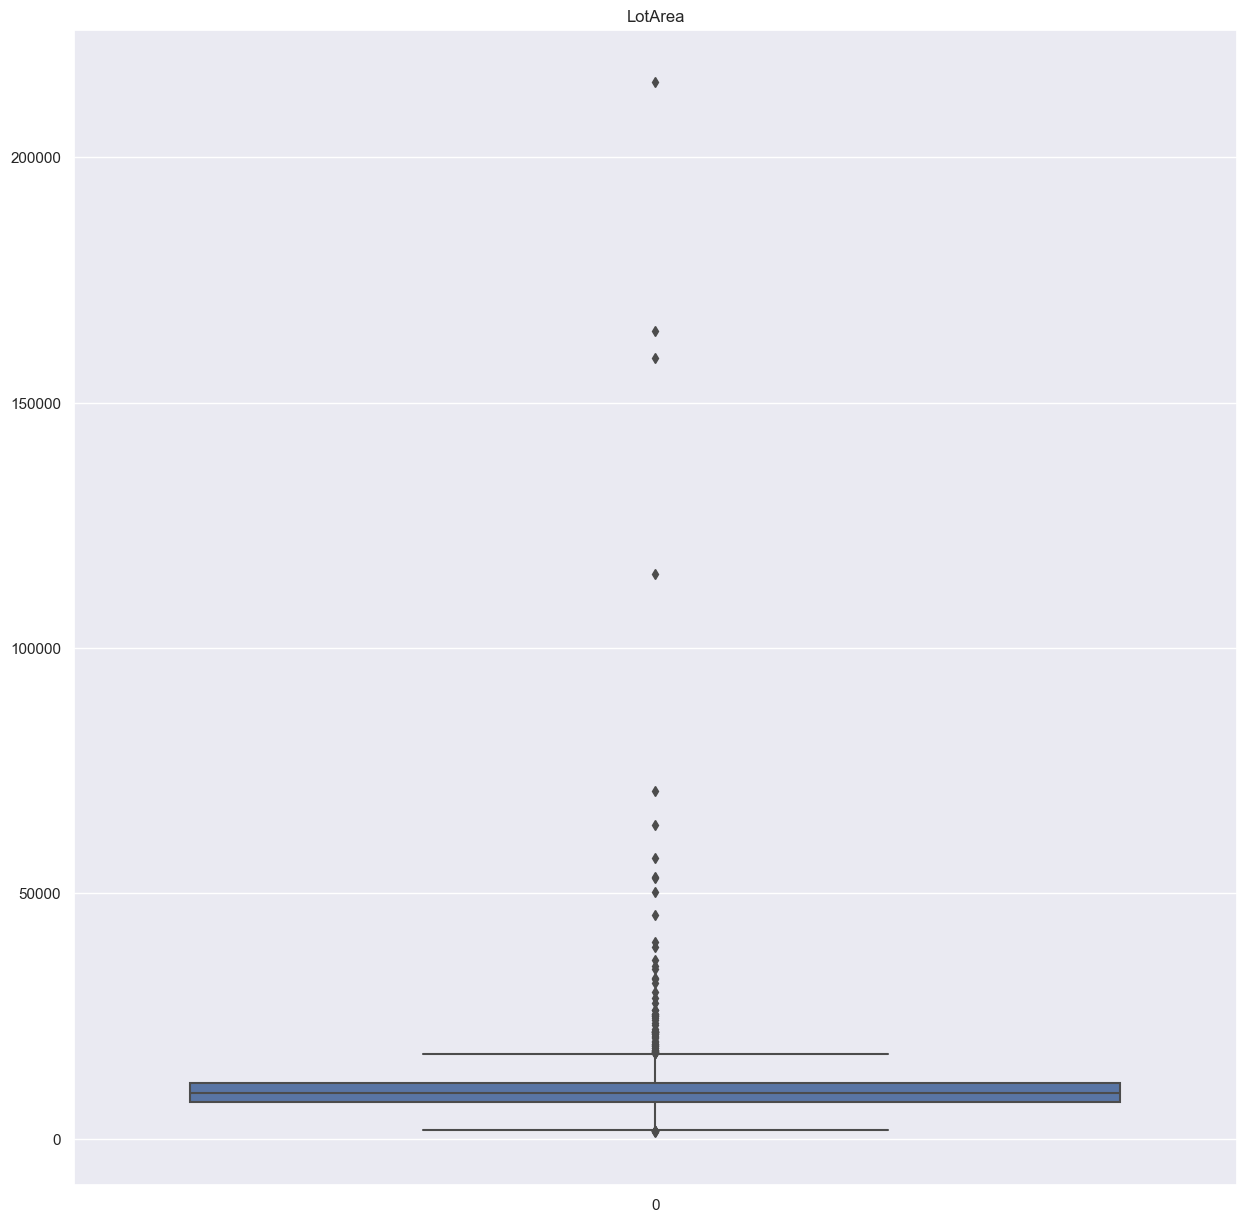

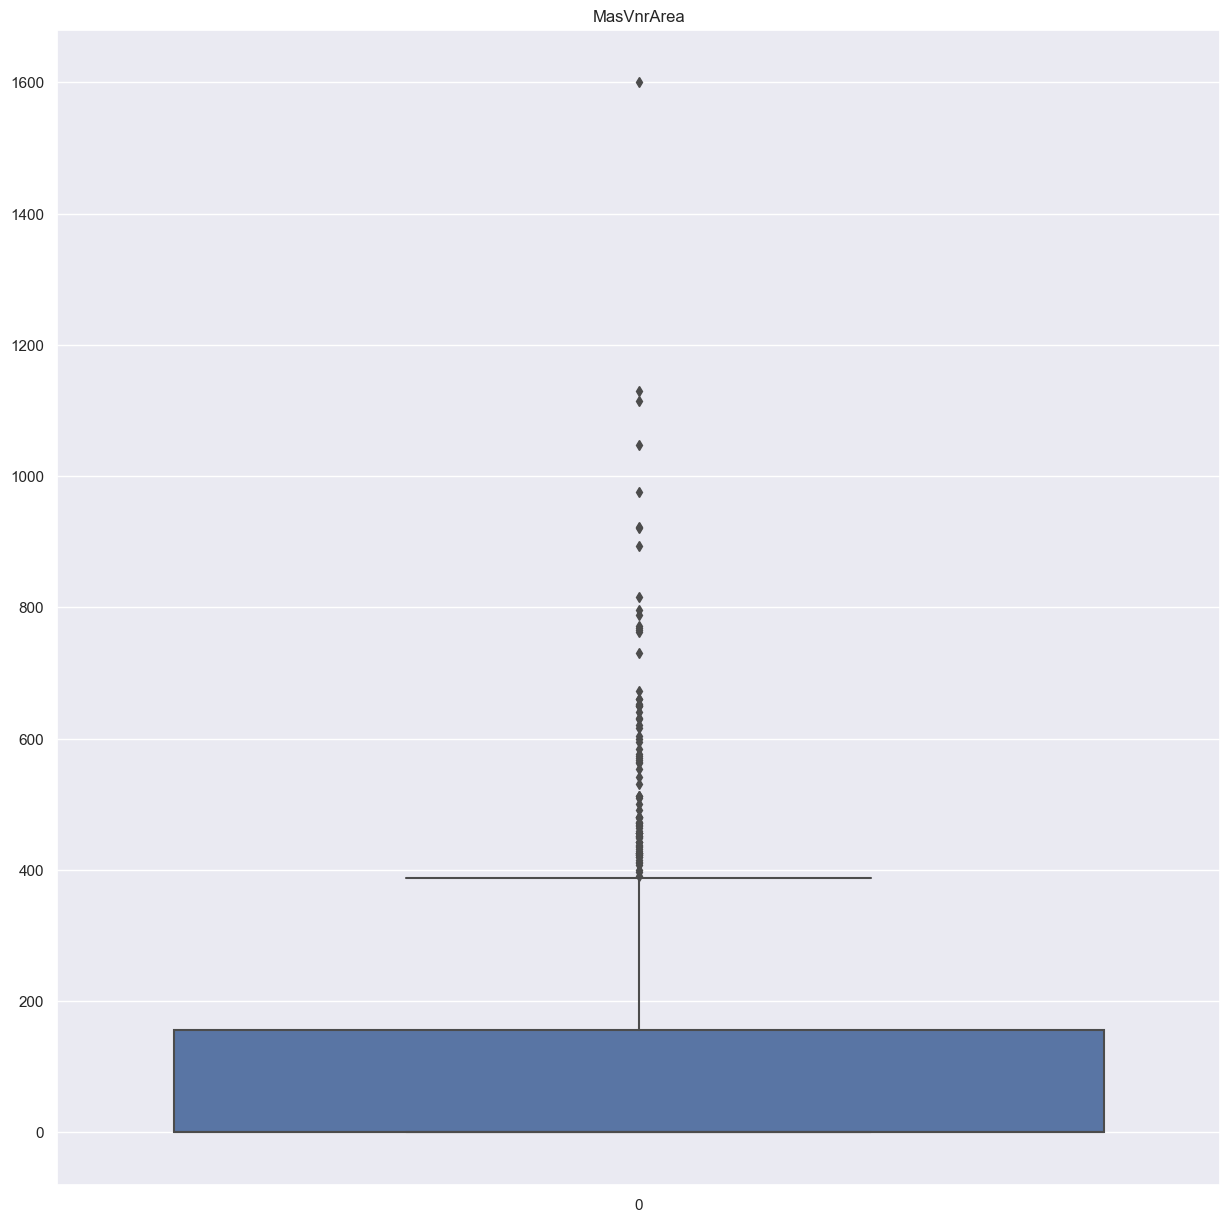

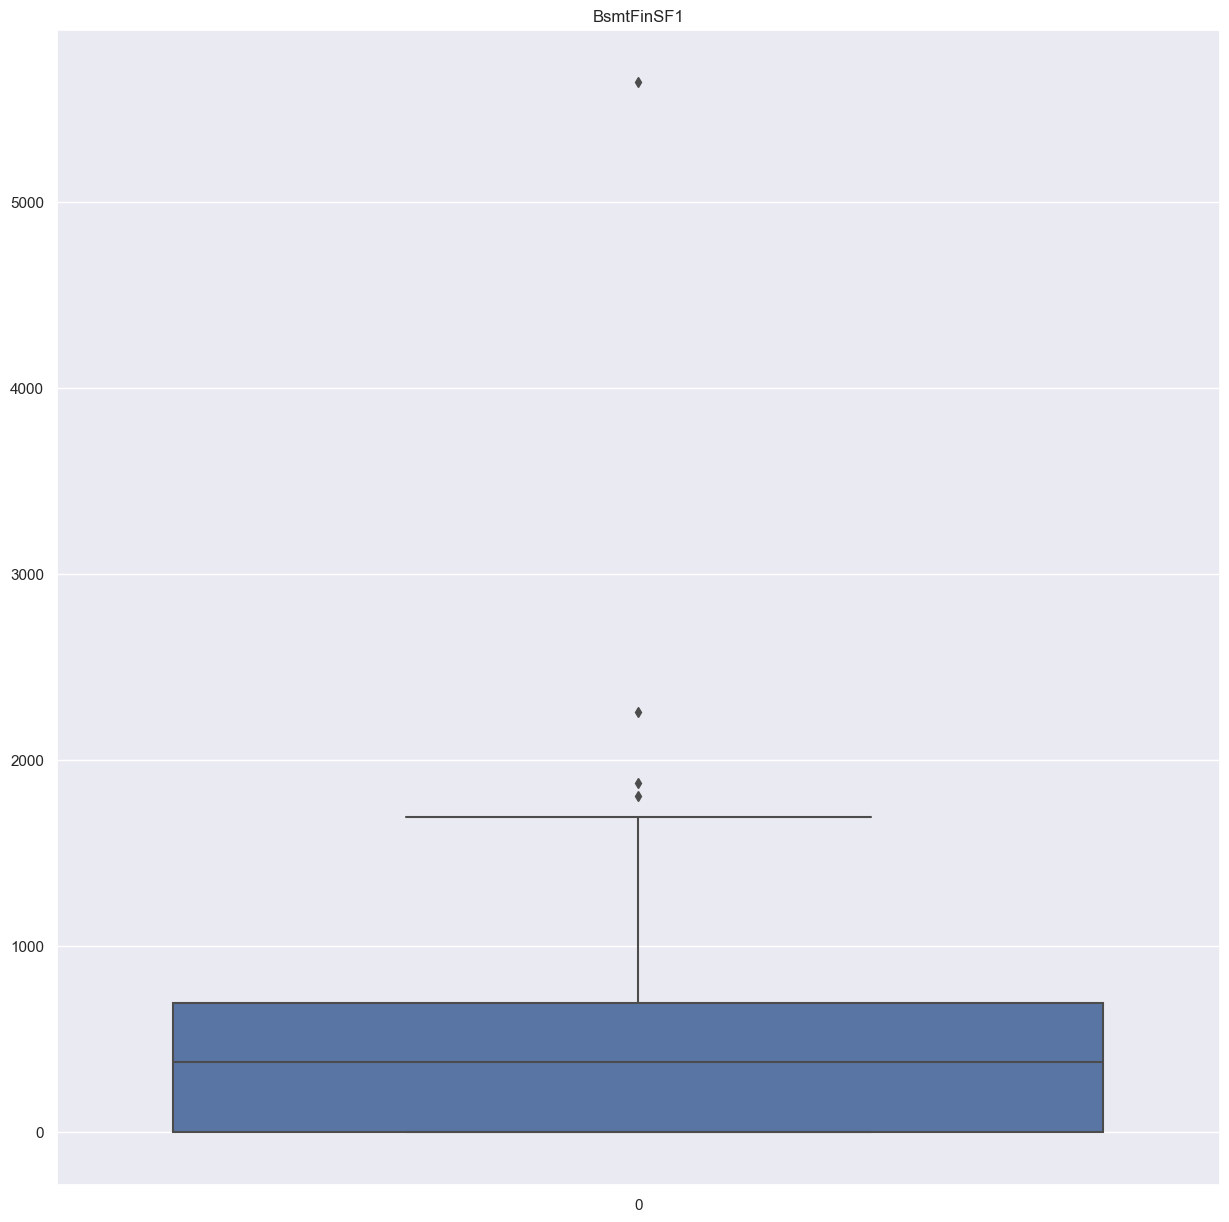

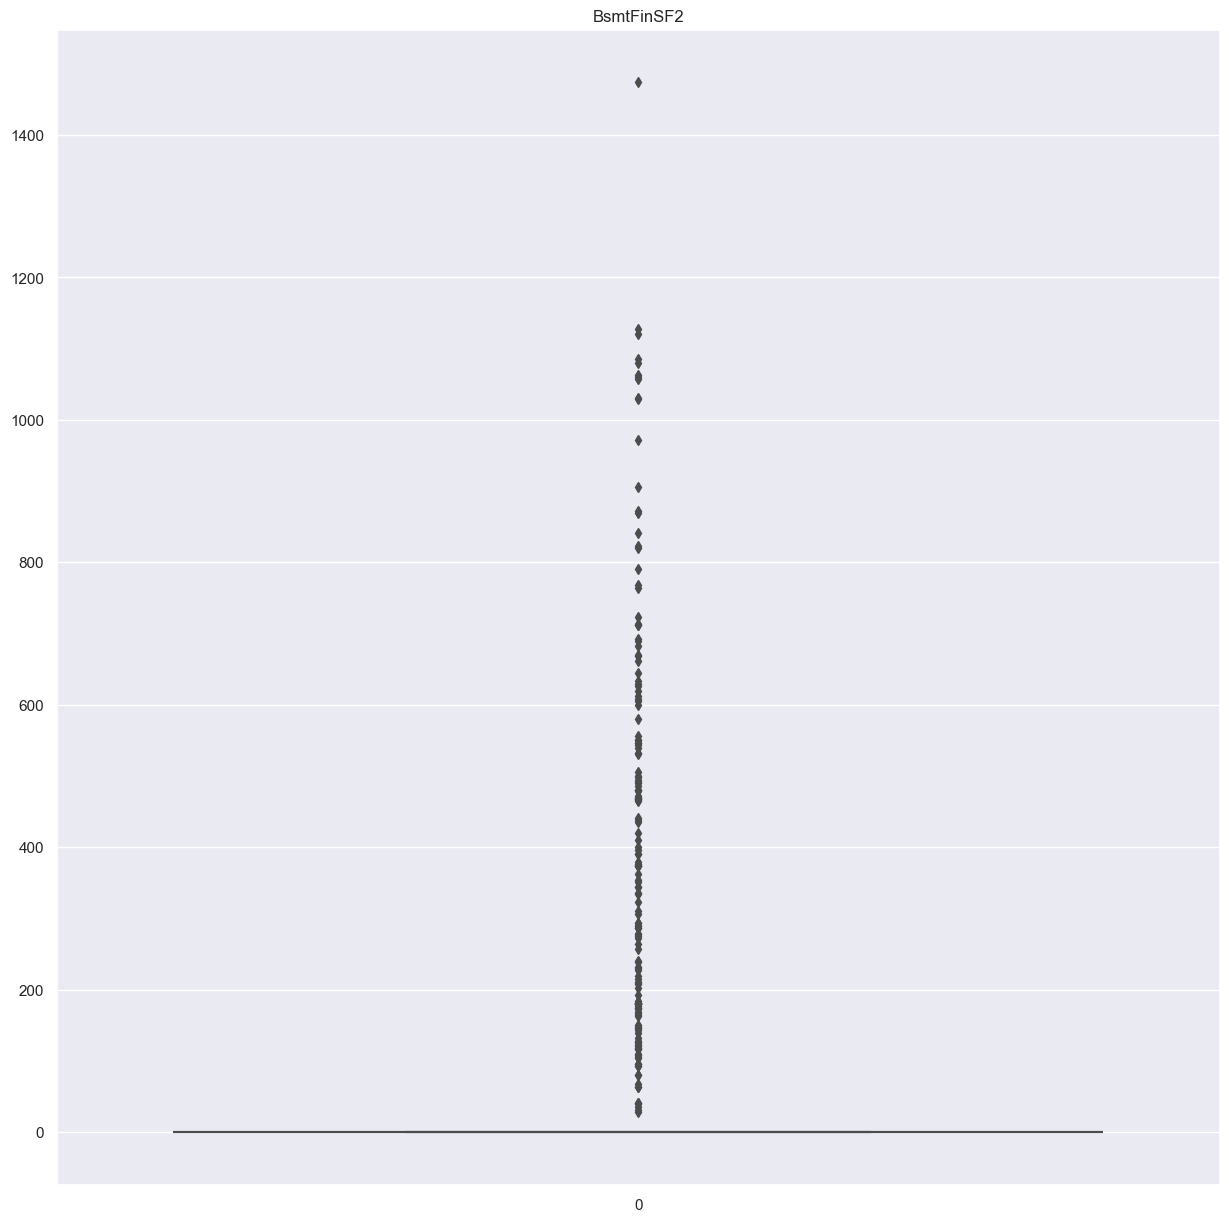

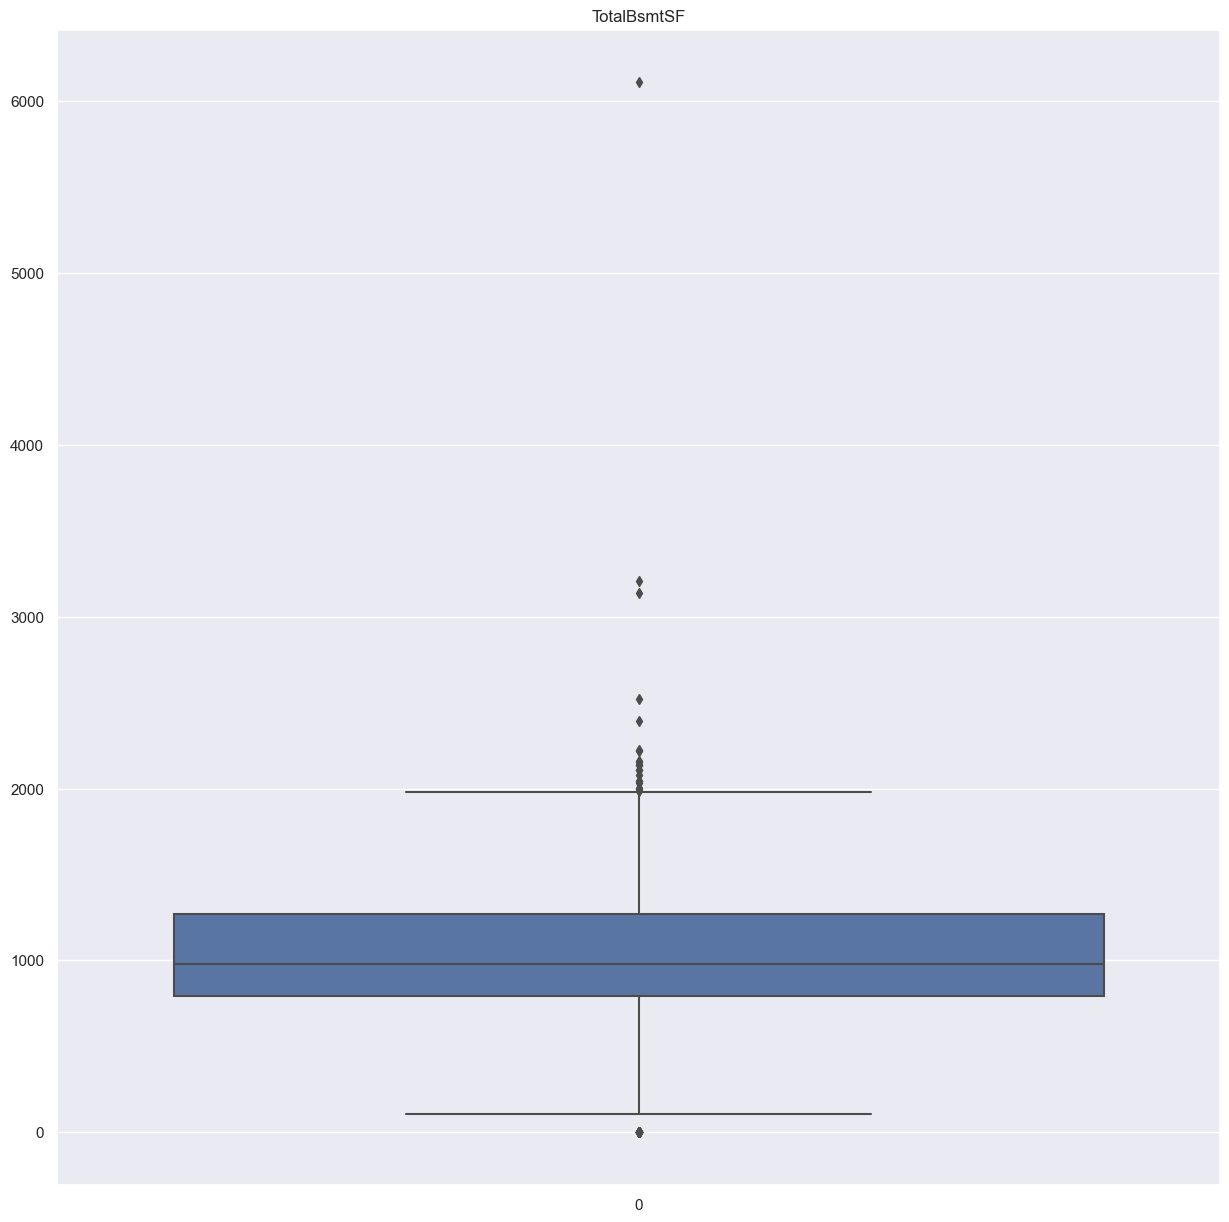

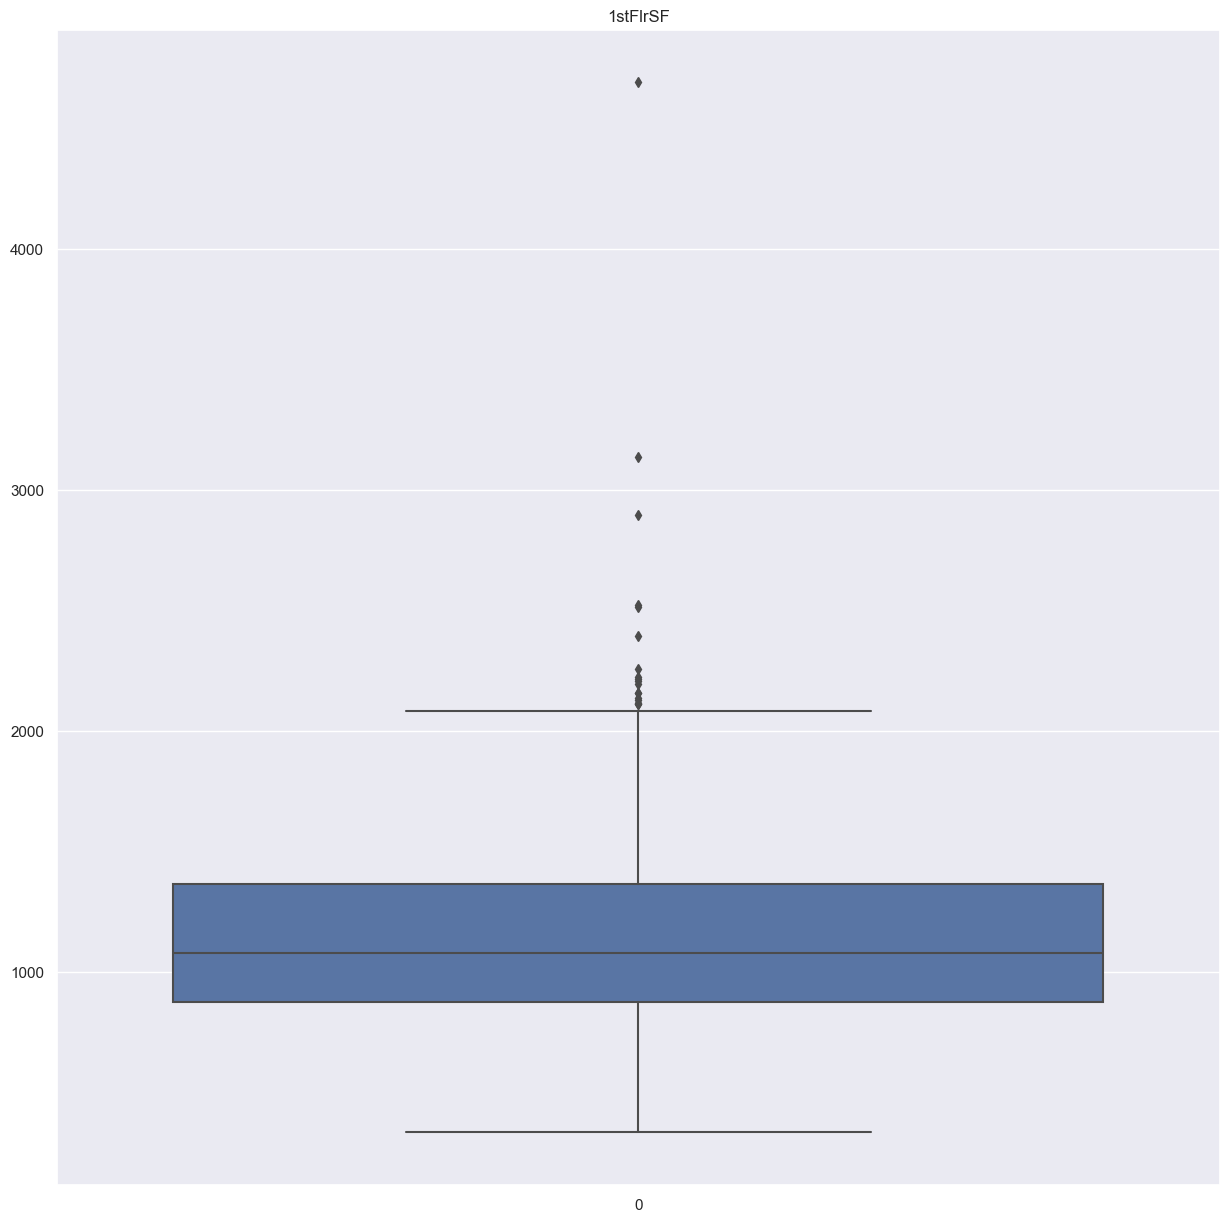

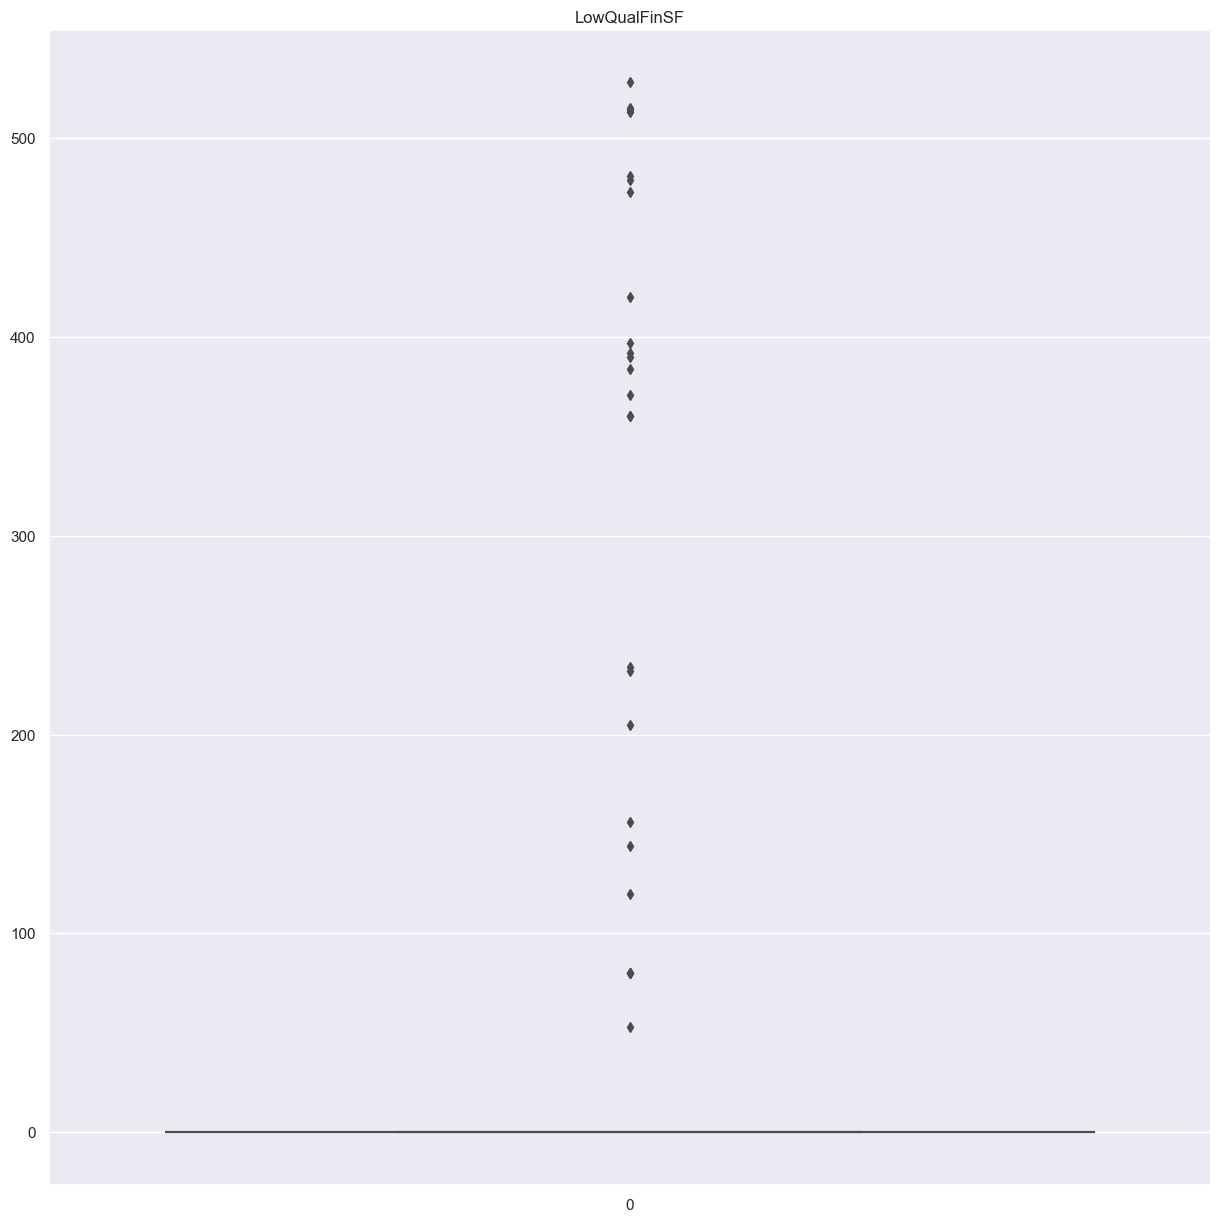

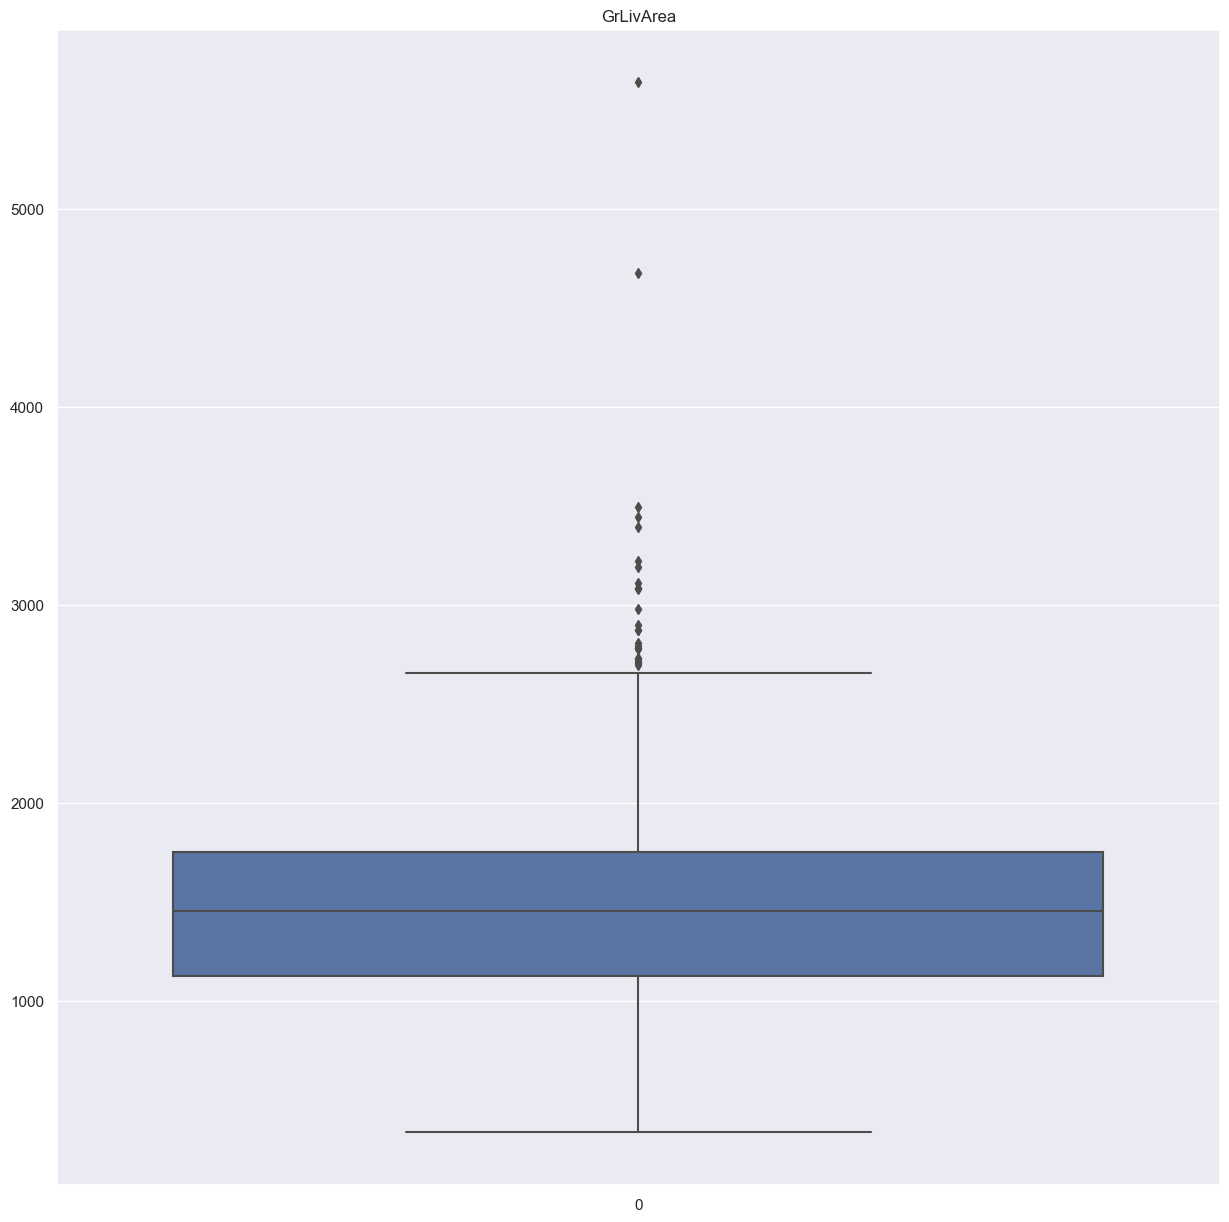

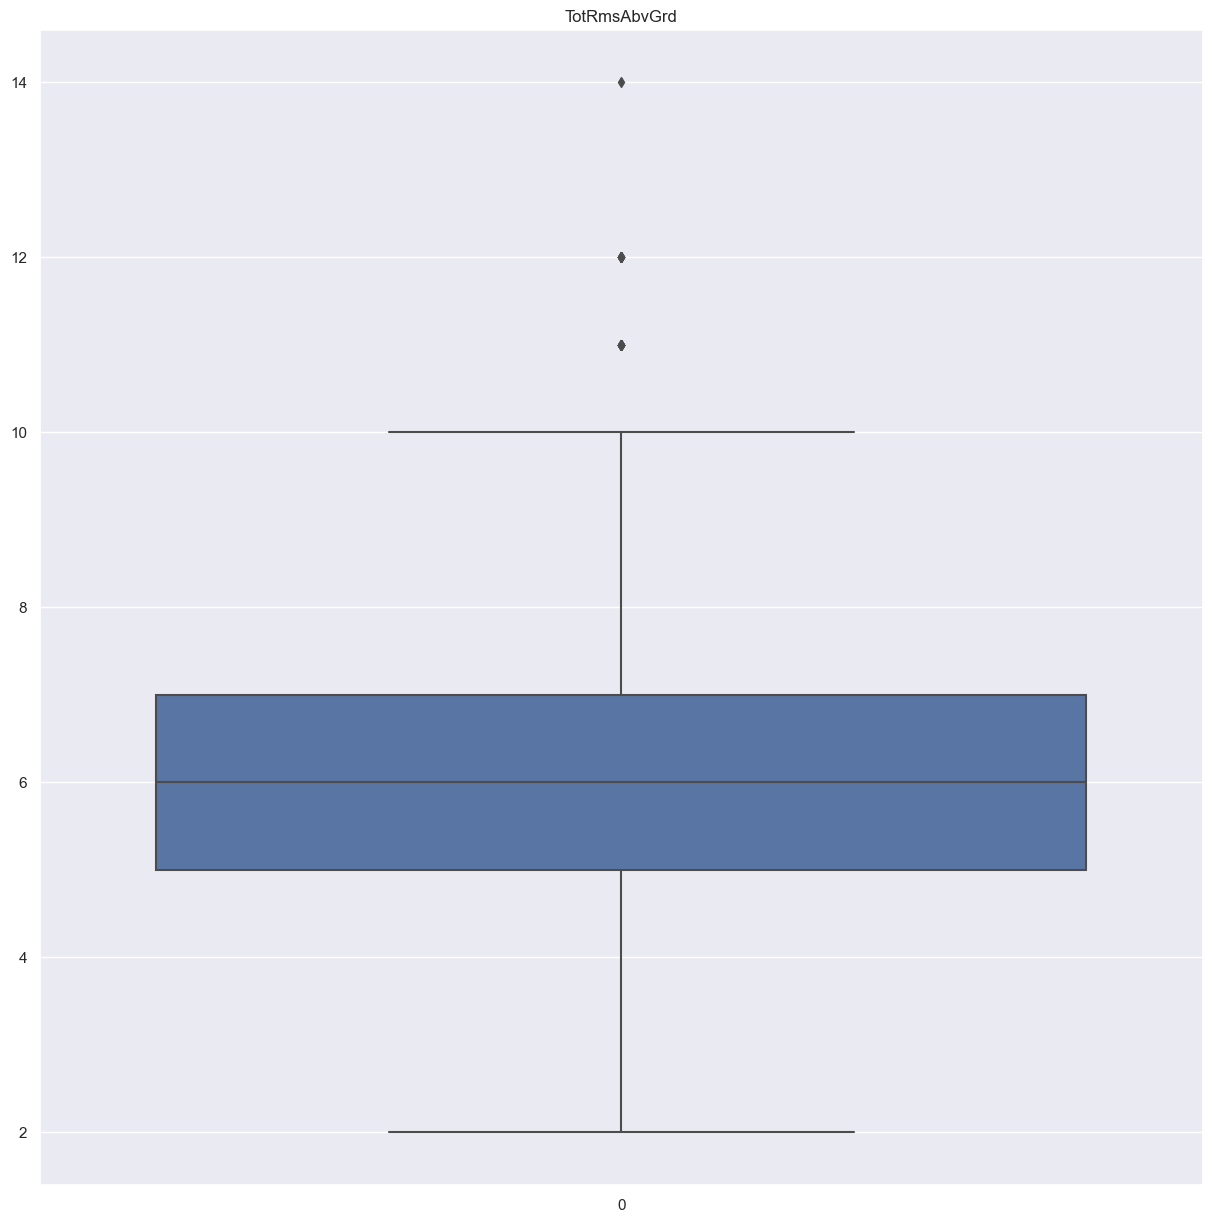

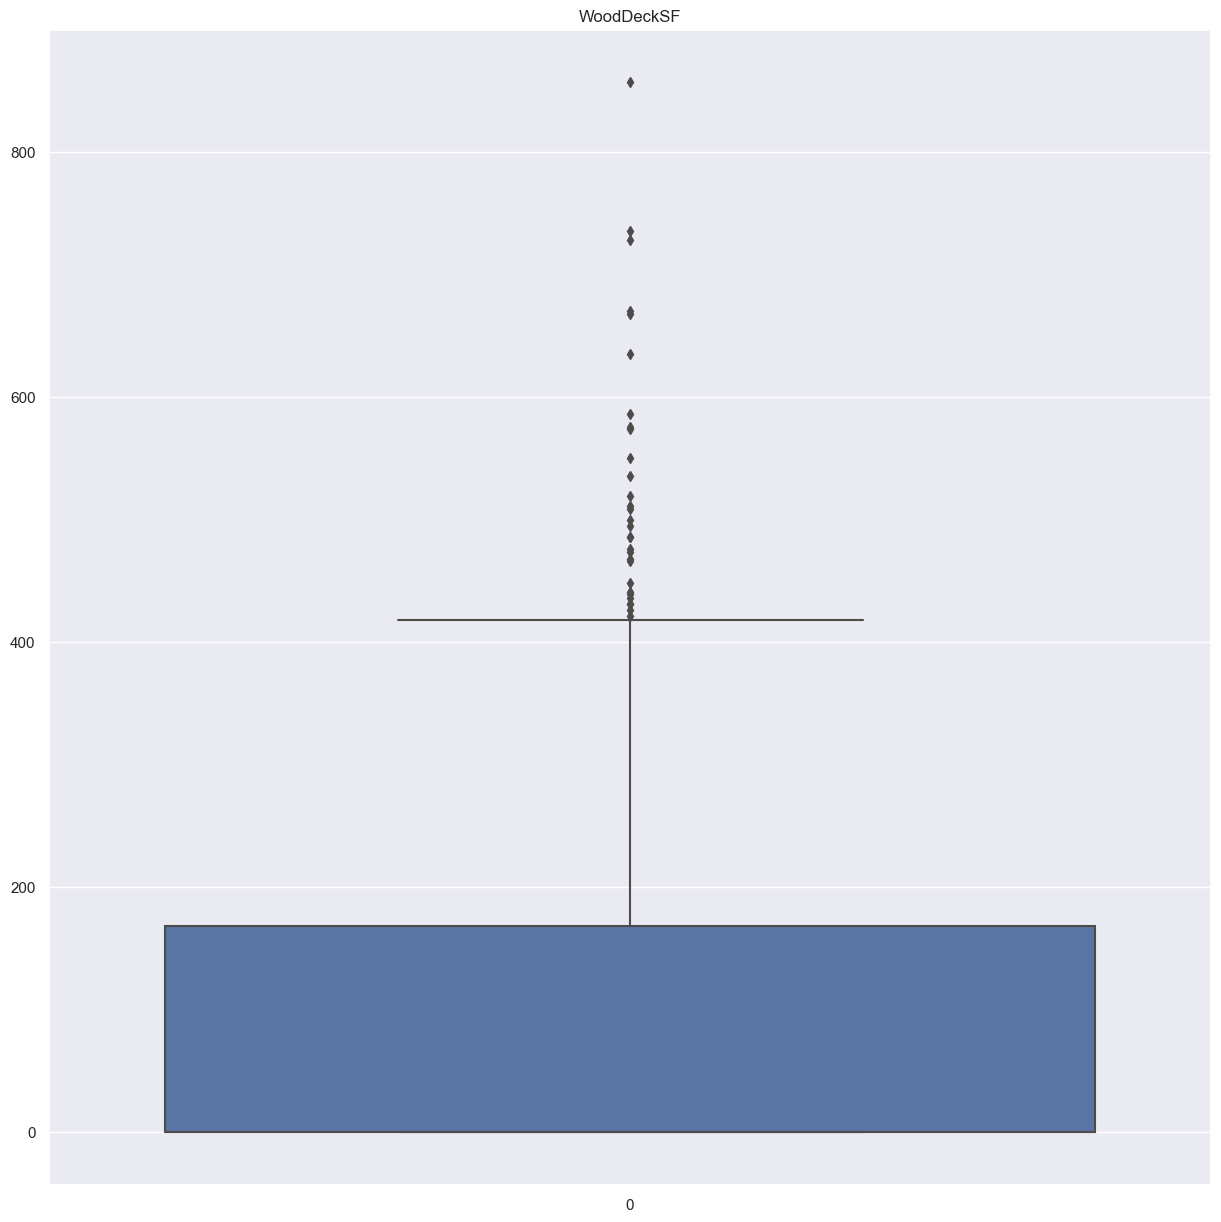

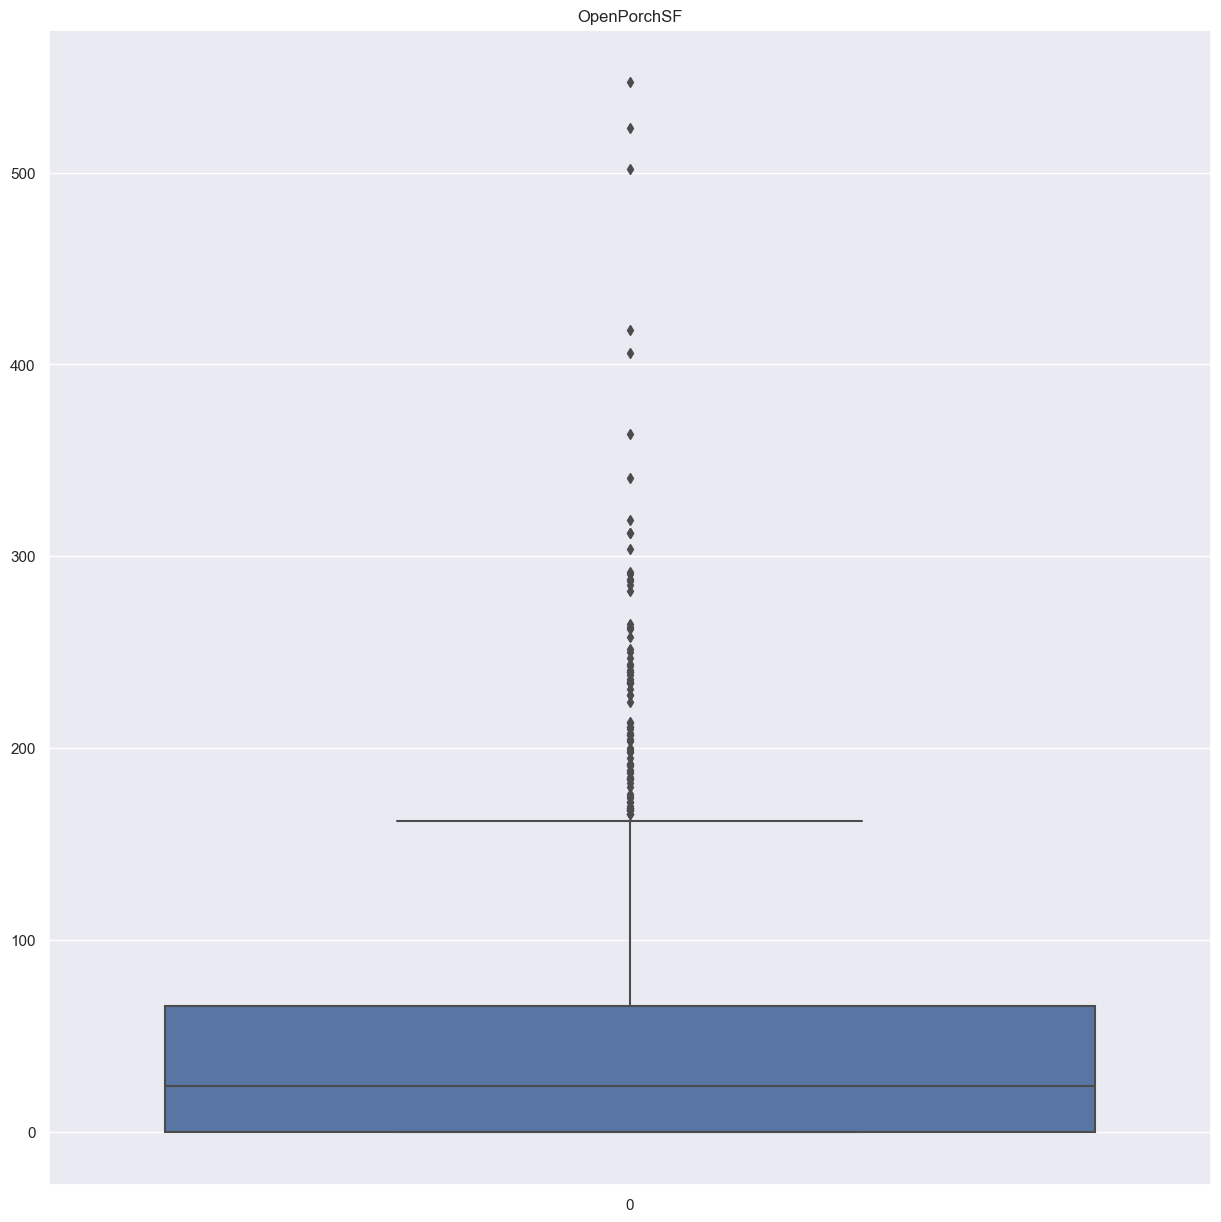

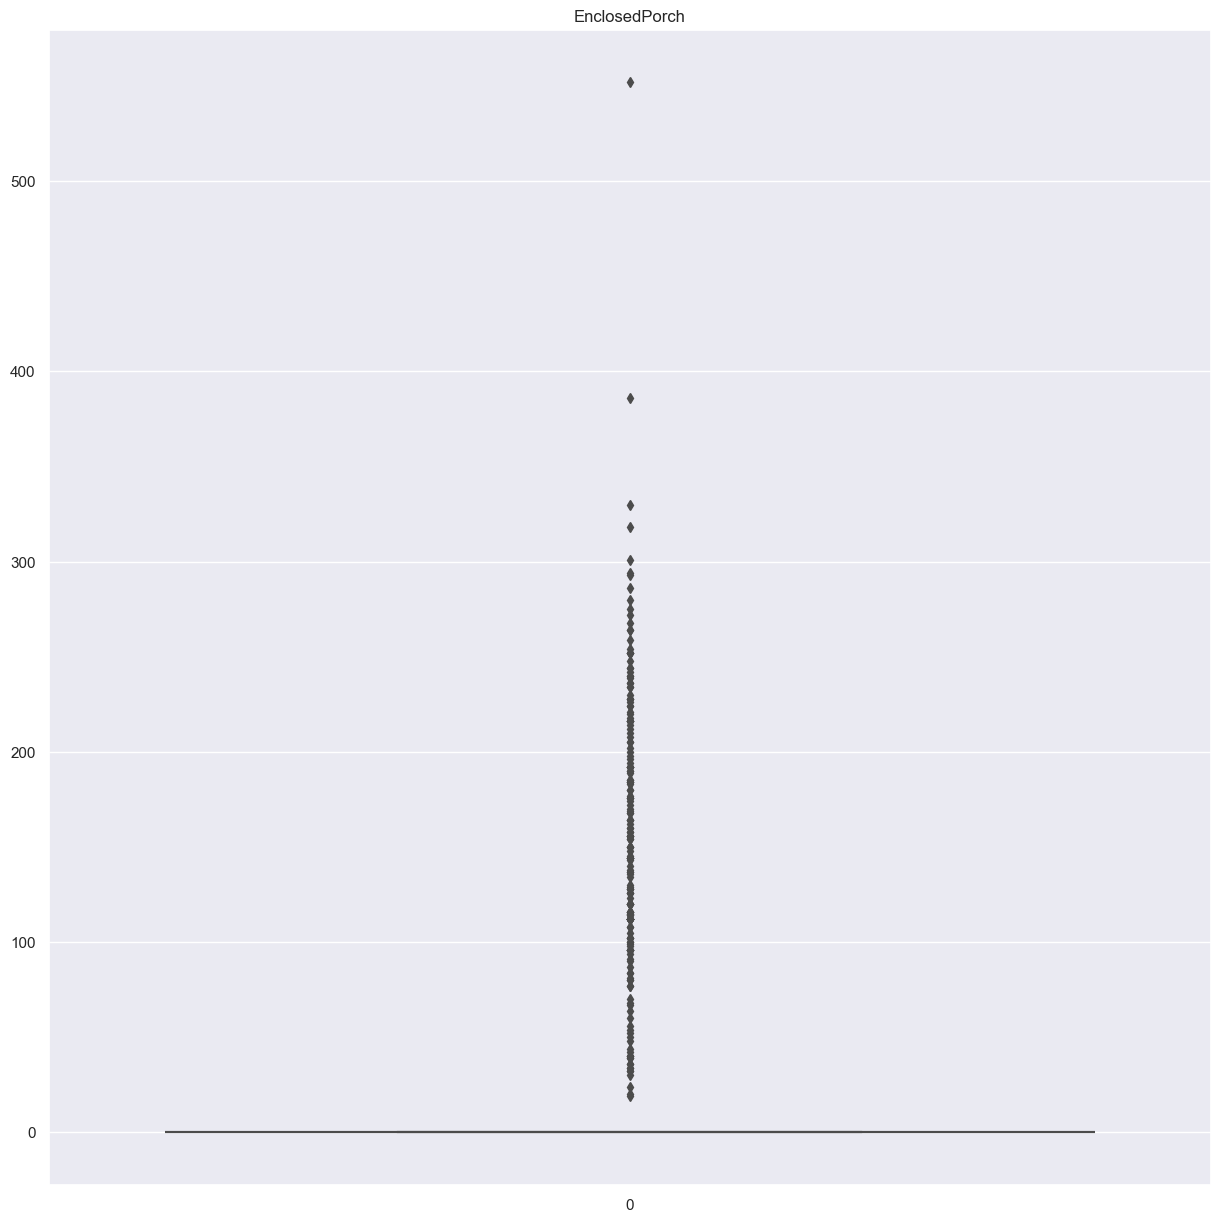

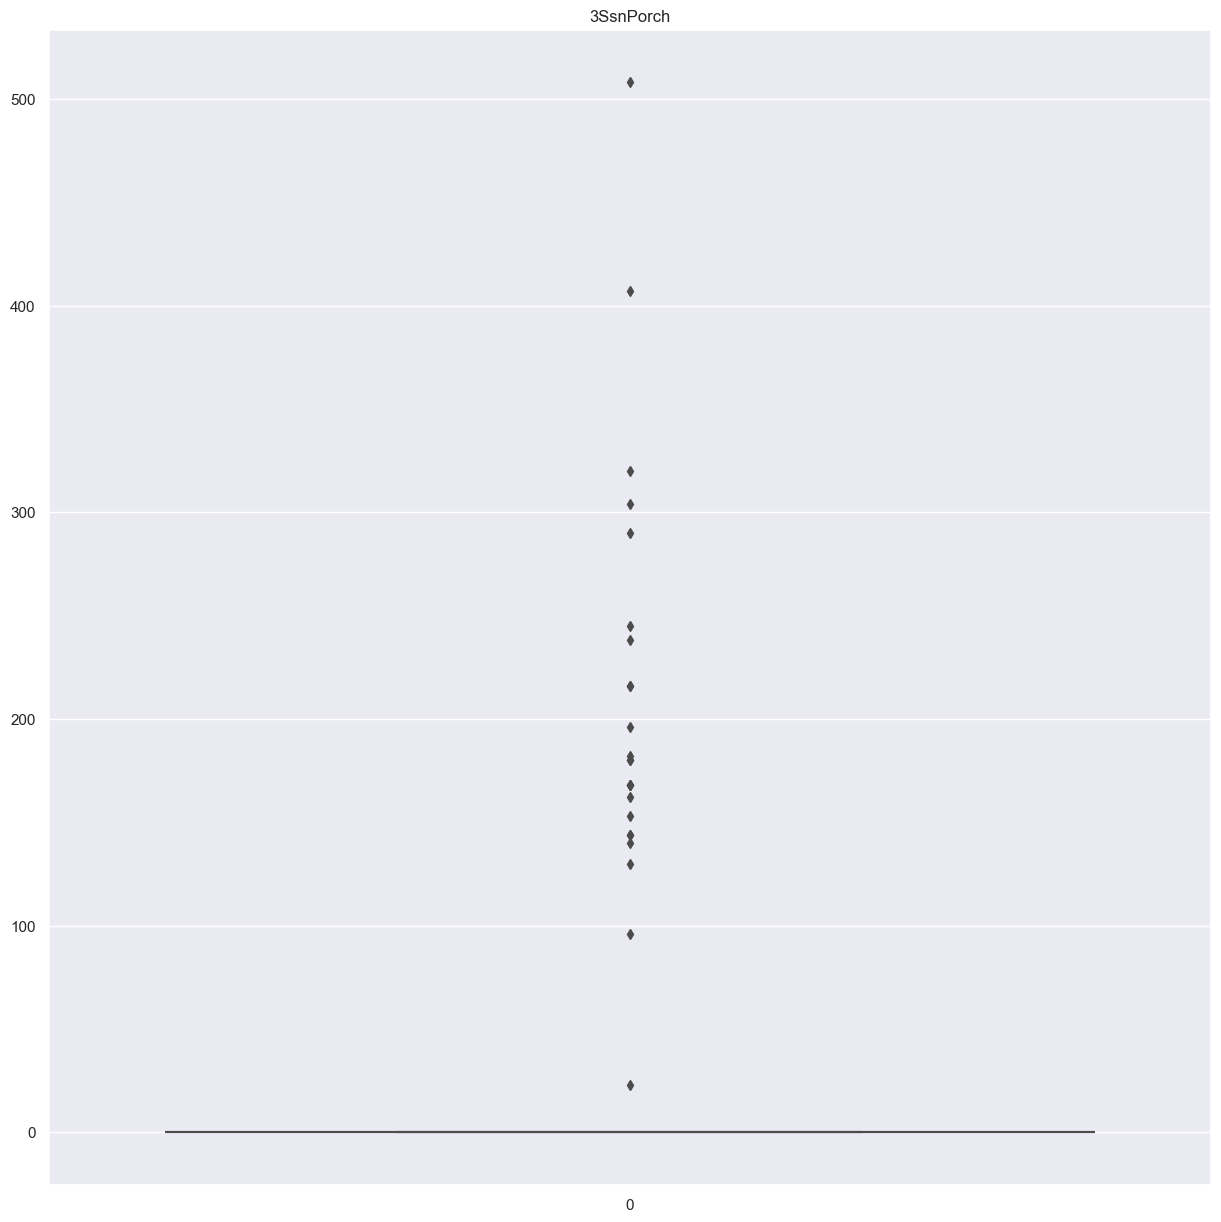

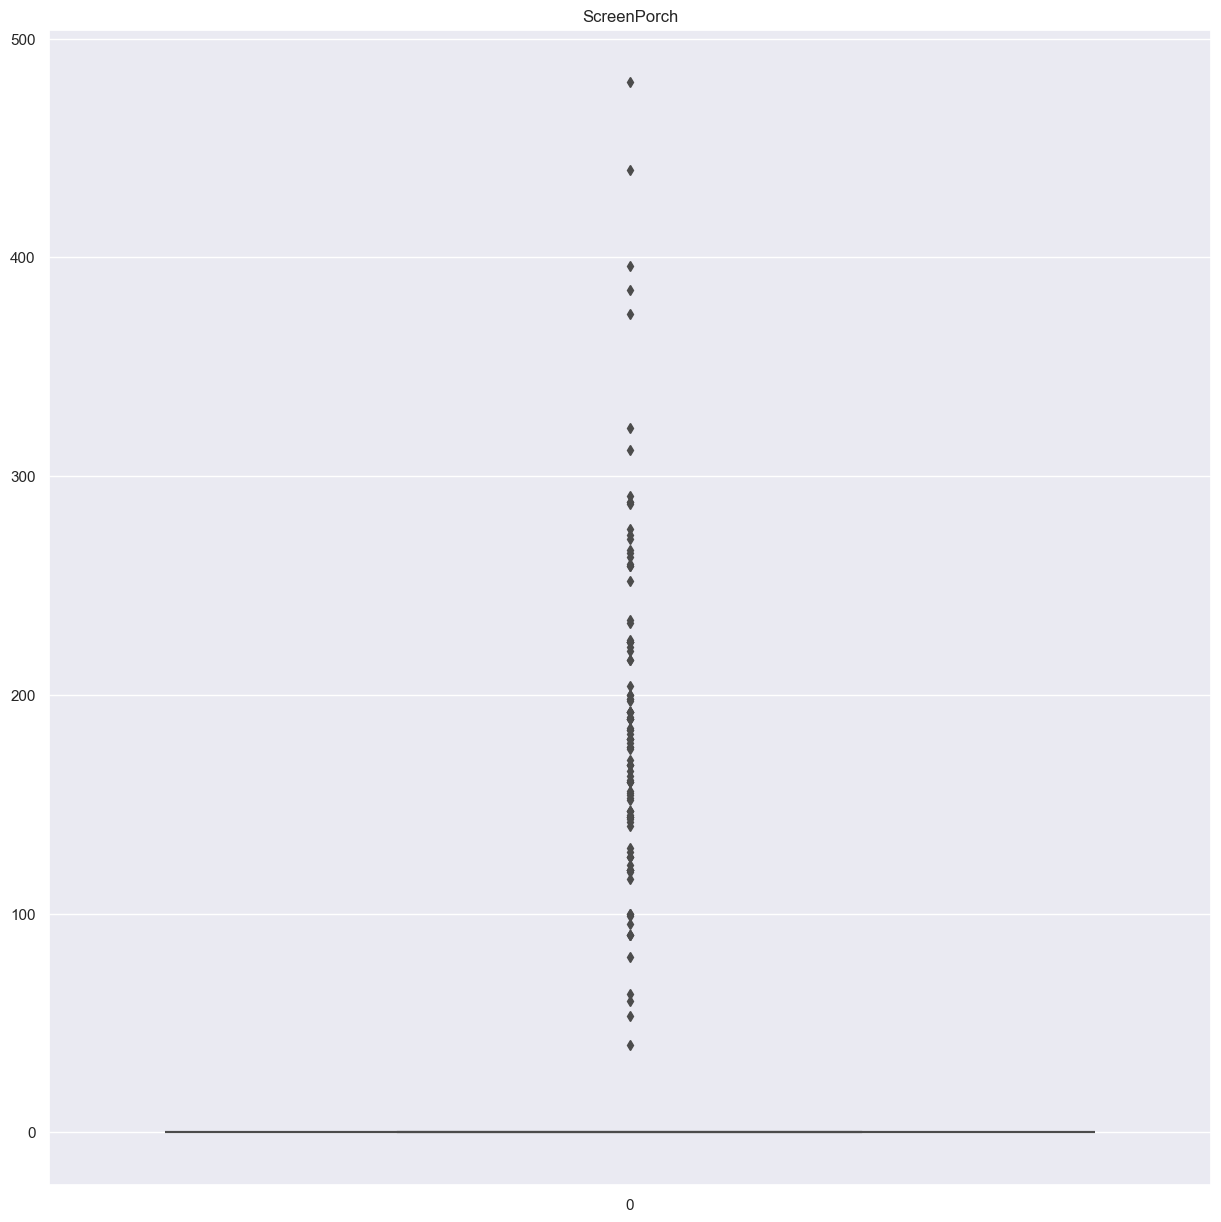

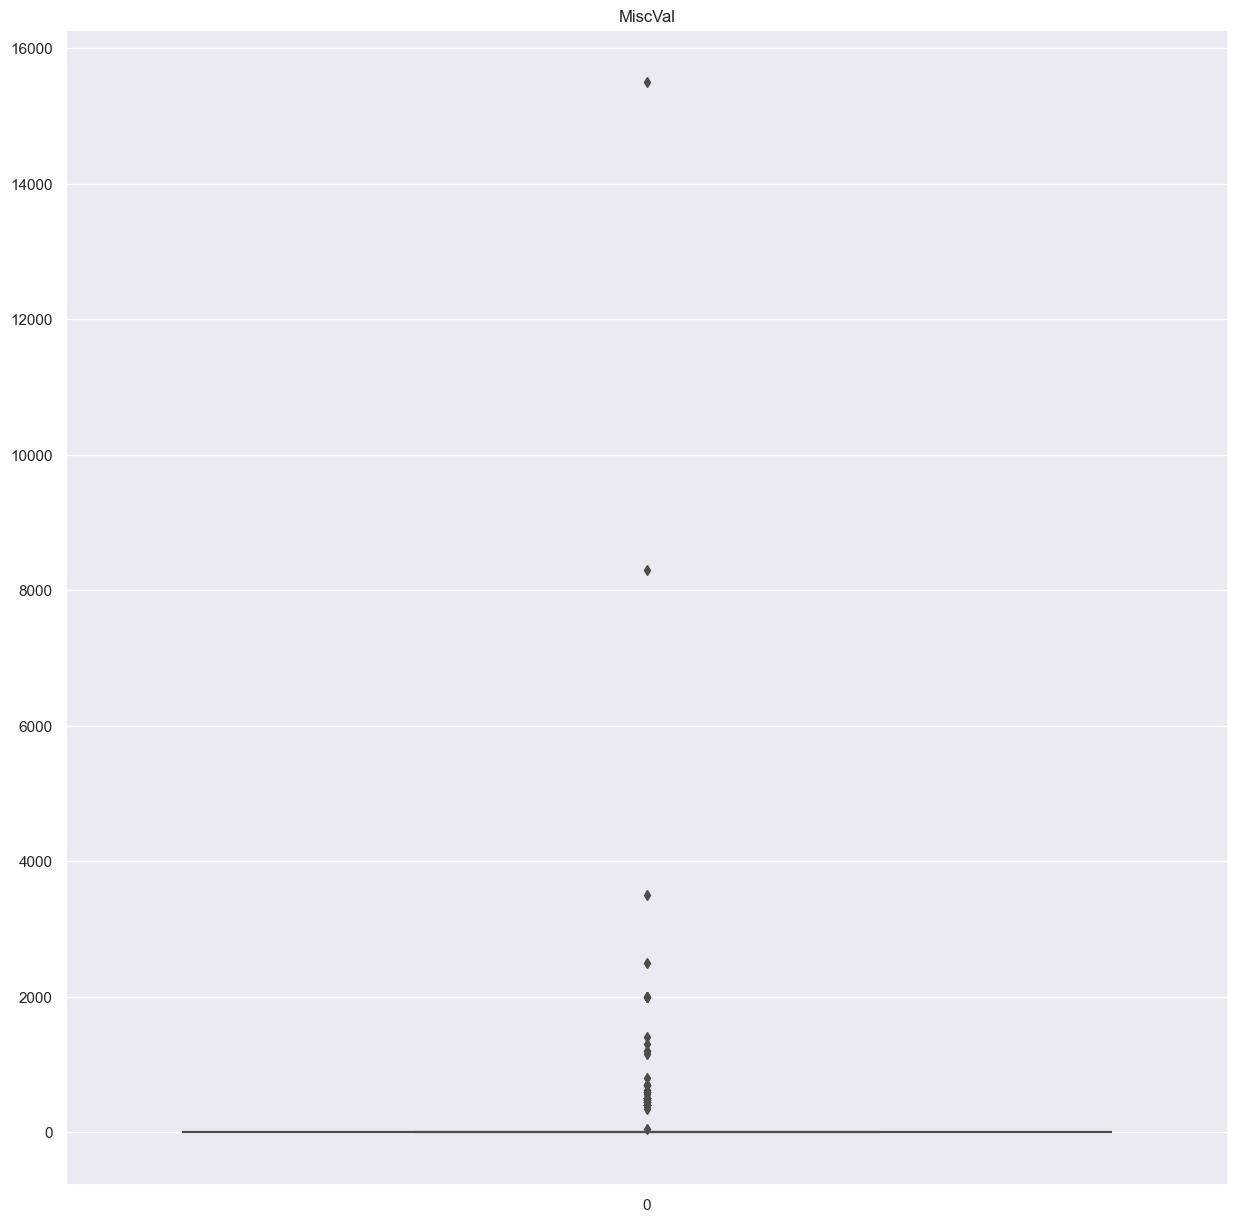

In [106]:
for col in num_cols:
    if check_outlier(df, col, q1=0.1, q3=0.9):
        plt.title(col)
        sns.boxplot(df[col])
        plt.show()

In [107]:
def replace_with_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [108]:
for col in num_cols:
    if col != 'SalePrice':
        replace_with_thresholds(df, col, q1=0.1, q3=0.9)

In [109]:
for col in num_cols:
    if col != 'SalePrice':
        count = count_outliers(df, col, q1=0.1, q3=0.9)
        print(col, ':', count)

Id : 0
MSSubClass : 0
LotFrontage : 0
LotArea : 0
OverallQual : 0
YearBuilt : 0
YearRemodAdd : 0
MasVnrArea : 0
BsmtFinSF1 : 0
BsmtFinSF2 : 0
BsmtUnfSF : 0
TotalBsmtSF : 0
1stFlrSF : 0
2ndFlrSF : 0
LowQualFinSF : 0
GrLivArea : 0
TotRmsAbvGrd : 0
GarageYrBlt : 0
GarageArea : 0
WoodDeckSF : 0
OpenPorchSF : 0
EnclosedPorch : 0
3SsnPorch : 0
ScreenPorch : 0
MiscVal : 0
MoSold : 0


### Missing Value Analysis (Eksik Değer Analizi)

In [110]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end='\n')

    if na_name:
        return na_columns

In [111]:
missing_values_table(df)

              n_miss  ratio
PoolQC          1426 99.580
MiscFeature     1378 96.230
Alley           1341 93.650
Fence           1153 80.520
MasVnrType       867 60.540
FireplaceQu      690 48.180
LotFrontage      257 17.950
GarageType        81  5.660
GarageYrBlt       81  5.660
GarageFinish      81  5.660
GarageQual        81  5.660
GarageCond        81  5.660
BsmtFinType2      38  2.650
BsmtExposure      38  2.650
BsmtFinType1      37  2.580
BsmtCond          37  2.580
BsmtQual          37  2.580
MasVnrArea         7  0.490
Electrical         1  0.070


In [112]:
df['Alley'].value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

In [113]:
df['BsmtQual'].value_counts()

BsmtQual
TA    648
Gd    613
Ex     99
Fa     35
Name: count, dtype: int64

- **Empty values in some variables indicate that the house does not have that feature.** *(Bazı değişkenlerde ki boş değerler evin o özelliğe sahip olmadığını ifade etmektedir.)*

In [114]:
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]

In [115]:
# Filling the empty values in the selected columns with the expression 'No' (Seçtiğimiz kolonlarda ki boş değerlerin 'No' ifadesi ile doldurulması)

for col in no_cols:
    df[col].fillna('No', inplace=True)

In [116]:
missing_values_table(df)

             n_miss  ratio
MasVnrType      867 60.540
LotFrontage     257 17.950
GarageYrBlt      81  5.660
MasVnrArea        7  0.490
Electrical        1  0.070


In [117]:
def quick_missing_imp(dataframe, num_method='median', cat_length=20, target='SalePrice'):
    
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    temp_target = dataframe[target]

    print("## BEFOR ##")
    print(dataframe[variables_with_na].isnull().sum(), '\n\n')

    dataframe = dataframe.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == 'O' and len(x.unique()) <= cat_length) else x, axis=0)

    if num_method == 'mean':
        dataframe == dataframe.apply(lambda x: x.fillna(x.mean()) if x.dtype != 'O' else x, axis=0)

    elif num_method == 'median':
        dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype != 'O' else x, axis=0)

    dataframe[target] = temp_target

    print("# AFTER \n Imputation method is 'Mode' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(dataframe[variables_with_na].isnull().sum(), "\n\n")

    return dataframe

In [118]:
df = quick_missing_imp(df, num_method='median', cat_length=17)

## BEFOR ##
LotFrontage    257
MasVnrType     867
MasVnrArea       7
Electrical       1
GarageYrBlt     81
dtype: int64 


# AFTER 
 Imputation method is 'Mode' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

LotFrontage    0
MasVnrType     0
MasVnrArea     0
Electrical     0
GarageYrBlt    0
dtype: int64 




### RARE

In [119]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ':', len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATUI": 100 * dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [120]:
rare_analyser(df, 'SalePrice', cat_cols)

MSZoning : 5
          COUNT  RATUI  TARGET_MEAN
MSZoning                           
C (all)      10  0.698    74528.000
FV           65  4.539   214014.062
RH           16  1.117   131558.375
RL         1124 78.492   183803.885
RM          217 15.154   124709.995


Street : 2
        COUNT  RATUI  TARGET_MEAN
Street                           
Grvl        6  0.419   130190.500
Pave     1426 99.581   175061.445


Alley : 3
       COUNT  RATUI  TARGET_MEAN
Alley                           
Grvl      50  3.492   122219.080
No      1341 93.645   177046.820
Pave      41  2.863   168000.585


LotShape : 4
          COUNT  RATUI  TARGET_MEAN
LotShape                           
IR1         471 32.891   197376.688
IR2          35  2.444   203406.686
IR3          10  0.698   216036.500
Reg         916 63.966   161762.822


LandContour : 4
             COUNT  RATUI  TARGET_MEAN
LandContour                           
Bnk             63  4.399   143104.079
HLS             48  3.352   220831.604
Low 

- **inclusion of classes into other classes according to their proportions** *(sınıfların oranlarına göre diğer sınıflara dahil edilmesi)*

In [121]:
# ExterCond : 5

df["ExterCond"] = np.where(df.ExterCond.isin(['Fa', 'Po']), "FaPo", df["ExterCond"])
df["ExterCond"] = np.where(df.ExterCond.isin(['Ex', 'Gd']), "Ex", df["ExterCond"])

In [122]:
# LotShape : 4

df["LotShape"] = np.where(df.LotShape.isin(["IR1", "IR2", "IR3"]), "IR", df["LotShape"])

In [123]:
# GarageQual : 5

df["GarageQual"] = np.where(df.GarageQual.isin(["Fa", "Po"]), "FaPo", df["GarageQual"])
df["GarageQual"] = np.where(df.GarageQual.isin(["Ex", "Gd", "TA"]), "ExGd", df["GarageQual"])

In [124]:
# BsmtFinType2 : 6

df["BsmtFinType2"] = np.where(df.BsmtFinType2.isin(["GLQ", "ALQ"]), "RareExcellent", df["BsmtFinType2"])
df["BsmtFinType2"] = np.where(df.BsmtFinType2.isin(["BLQ", "LwQ", "Rec"]), "RareGood", df["BsmtFinType2"])

## Feature Extraction (Özellik Çıkarma)

In [130]:
df["NEW_1st*GrLiv"] = (df["1stFlrSF"]*df["GrLivArea"])

df["NEW_Garage*GrLiv"] = (df["GarageArea"]*df["GrLivArea"])

df["TotalGarageQual"] = df[["GarageQual", "GarageCond"]].sum(axis = 1)

df["Overall"] = df[["OverallQual", "OverallCond"]].sum(axis = 1)

df["Exter"] = df[["ExterQual", "ExterCond"]].sum(axis = 1)

In [131]:
# Total Floor
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"]

In [132]:
# Total Finished Basement Area
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1 + df.BsmtFinSF2

In [133]:
# Porch Area
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF

In [134]:
# Total House Area
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF

df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF

df["NEW_TotalFullBath"] = df.BsmtFullBath + df.FullBath
df["NEW_TotalHalfBath"] = df.BsmtHalfBath + df.HalfBath

df["NEW_TotalBath"] = df["NEW_TotalFullBath"] + (df["NEW_TotalHalfBath"]*0.5)

In [135]:
# Lot Ratio
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea

df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea

df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea

In [136]:
# MasVnrArea
df["NEW_MasVnrRatio"] = df.MasVnrArea / df.NEW_TotalHouseArea

In [137]:
# Dif Area
df["NEW_DifArea"] = (df.LotArea - df["1stFlrSF"] - df.GarageArea - df.NEW_PorchArea - df.WoodDeckSF)

In [138]:
# LowQualFinSF
df["NEW_LowQualFinSFRatio"] = df.LowQualFinSF / df.NEW_TotalHouseArea

df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"]

In [139]:
# Overall kitchen score
df["NEW_KitchenScore"] = df["KitchenAbvGr"] * df["KitchenQual"]

In [140]:
# Overall fireplace score
df["NEW_FireplaceScore"] = df["Fireplaces"] * df["FireplaceQu"]

In [141]:
df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt

df["NEW_HouseAge"] = df.YrSold - df.YearBuilt

df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd

df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt

df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd)

df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt

In [142]:
drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

In [143]:
df.drop(drop_list, axis=1, inplace=True)

### Label Encoding

In [145]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 1432
Variables: 100
cat_cols: 56
num_cols: 44
cat_but_car: 0
num_but_cat: 18


In [148]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [147]:
binary_col = [col for col in df.columns if df[col].dtypes == 'O' and df[col].nunique() == 2]

In [149]:
for col in binary_col:
    label_encoder(df, col)

### One-Hot Encoding

In [150]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [155]:
cat_cols = [col for col in cat_cols if col not in binary_col]

In [157]:
df = one_hot_encoder(df, cat_cols, True)

In [158]:
df.head()

Id  MSSubClass  LotFrontage   LotArea  LotShape  OverallQual  YearBuilt  \
0 1.000          60       65.000  8450.000         1        7.000   2003.000   
1 2.000          20       80.000  9600.000         1        6.000   1976.000   
2 3.000          60       68.000 11250.000         0        7.000   2001.000   
3 4.000          70       60.000  9550.000         0        7.000   1915.000   
4 5.000          60       84.000 14260.000         0        8.000   2000.000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          2003     196.000     706.000       0.000    150.000      856.000   
1          1976       0.000     978.000       0.000    284.000     1262.000   
2          2002     162.000     486.000       0.000    434.000      920.000   
3          1970       0.000     216.000       0.000    540.000      756.000   
4          2000     350.000     655.000       0.000    490.000     1145.000   

   CentralAir  1stFlrSF  2ndFlrSF  GrLivArea  TotRmsAbvGrd  GarageYrBlt  \
0           1       856   854.000   1710.000         8.000     2003.000   
1           1      1262     0.000   1262.000         6.000     1976.000   
2           1       920   866.000   1786.000         6.000     2001.000   
3           1       961   756.000   1717.000         7.000     1998.000   
4           1      1145  1053.000   2198.000         9.000     2000.000   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  MoSold  SalePrice  \
0         548       0.000           61              0   2.000     208500   
1         460     298.000            0              0   5.000     181500   
2         608       0.000           42              0   9.000     223500   
3         642       0.000           35            272   2.000     140000   
4         836     192.000           84              0  12.000     250000   

   NEW_1st*GrLiv  NEW_Garage*GrLiv  Overall  NEW_TotalFlrSF  NEW_TotalBsmtFin  \
0    1463760.000        937080.000   12.000        1710.000           706.000   
1    1592644.000        580520.000   14.000        1262.000           978.000   
2    1643120.000       1085888.000   12.000        1786.000           486.000   
3    1650037.000       1102314.000   12.000        1717.000           216.000   
4    2516710.000       1837528.000   13.000        2198.000           655.000   

   NEW_PorchArea  NEW_TotalHouseArea  NEW_TotalSqFeet  NEW_TotalBath  \
0         61.000            2566.000         2566.000          3.500   
1        298.000            2524.000         2524.000          2.500   
2         42.000            2706.000         2706.000          3.500   
3        307.000            2473.000         2473.000          2.000   
4        276.000            3343.000         3343.000          3.500   

   NEW_LotRatio  NEW_RatioArea  NEW_GarageLotRatio  NEW_MasVnrRatio  \
0         0.202          0.304               0.065            0.076   
1         0.131          0.263               0.048            0.000   
2         0.159          0.241               0.054            0.060   
3         0.180          0.259               0.067            0.000   
4         0.154          0.234               0.059            0.105   

   NEW_DifArea  NEW_OverallGrade  NEW_Restoration  NEW_HouseAge  \
0     6985.000            35.000            0.000         5.000   
1     7282.000            48.000            0.000        31.000   
2     9680.000            35.000            1.000         7.000   
3     7640.000            35.000           55.000        91.000   
4    11811.000            40.000            0.000         8.000   

   NEW_RestorationAge  NEW_GarageAge  NEW_GarageRestorationAge  \
0                   5          0.000                     0.000   
1                  31          0.000                     0.000   
2                   6          0.000                     1.000   
3                  36         83.000                    28.000   
4                   8          0.000                     0.00

In [159]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 1432
Variables: 300
cat_cols: 256
num_cols: 44
cat_but_car: 0
num_but_cat: 256


In [160]:
def true_false_to_binary(dataframe, binary_val):
    dataframe[binary_val] = dataframe[binary_val].astype(int)
    return dataframe

In [161]:
df = true_false_to_binary(df, cat_cols)

In [162]:
df.head()

Id  MSSubClass  LotFrontage   LotArea  LotShape  OverallQual  YearBuilt  \
0 1.000          60       65.000  8450.000         1        7.000   2003.000   
1 2.000          20       80.000  9600.000         1        6.000   1976.000   
2 3.000          60       68.000 11250.000         0        7.000   2001.000   
3 4.000          70       60.000  9550.000         0        7.000   1915.000   
4 5.000          60       84.000 14260.000         0        8.000   2000.000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          2003     196.000     706.000       0.000    150.000      856.000   
1          1976       0.000     978.000       0.000    284.000     1262.000   
2          2002     162.000     486.000       0.000    434.000      920.000   
3          1970       0.000     216.000       0.000    540.000      756.000   
4          2000     350.000     655.000       0.000    490.000     1145.000   

   CentralAir  1stFlrSF  2ndFlrSF  GrLivArea  TotRmsAbvGrd  GarageYrBlt  \
0           1       856   854.000   1710.000         8.000     2003.000   
1           1      1262     0.000   1262.000         6.000     1976.000   
2           1       920   866.000   1786.000         6.000     2001.000   
3           1       961   756.000   1717.000         7.000     1998.000   
4           1      1145  1053.000   2198.000         9.000     2000.000   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  MoSold  SalePrice  \
0         548       0.000           61              0   2.000     208500   
1         460     298.000            0              0   5.000     181500   
2         608       0.000           42              0   9.000     223500   
3         642       0.000           35            272   2.000     140000   
4         836     192.000           84              0  12.000     250000   

   NEW_1st*GrLiv  NEW_Garage*GrLiv  Overall  NEW_TotalFlrSF  NEW_TotalBsmtFin  \
0    1463760.000        937080.000   12.000        1710.000           706.000   
1    1592644.000        580520.000   14.000        1262.000           978.000   
2    1643120.000       1085888.000   12.000        1786.000           486.000   
3    1650037.000       1102314.000   12.000        1717.000           216.000   
4    2516710.000       1837528.000   13.000        2198.000           655.000   

   NEW_PorchArea  NEW_TotalHouseArea  NEW_TotalSqFeet  NEW_TotalBath  \
0         61.000            2566.000         2566.000          3.500   
1        298.000            2524.000         2524.000          2.500   
2         42.000            2706.000         2706.000          3.500   
3        307.000            2473.000         2473.000          2.000   
4        276.000            3343.000         3343.000          3.500   

   NEW_LotRatio  NEW_RatioArea  NEW_GarageLotRatio  NEW_MasVnrRatio  \
0         0.202          0.304               0.065            0.076   
1         0.131          0.263               0.048            0.000   
2         0.159          0.241               0.054            0.060   
3         0.180          0.259               0.067            0.000   
4         0.154          0.234               0.059            0.105   

   NEW_DifArea  NEW_OverallGrade  NEW_Restoration  NEW_HouseAge  \
0     6985.000            35.000            0.000         5.000   
1     7282.000            48.000            0.000        31.000   
2     9680.000            35.000            1.000         7.000   
3     7640.000            35.000           55.000        91.000   
4    11811.000            40.000            0.000         8.000   

   NEW_RestorationAge  NEW_GarageAge  NEW_GarageRestorationAge  \
0                   5          0.000                     0.000   
1                  31          0.000                     0.000   
2                   6          0.000                     1.000   
3                  36         83.000                    28.000   
4                   8          0.000                     0.00

## MODELLING (MODELLEME)

In [164]:
y = np.log1p(df['SalePrice'])

X = df.drop(['Id', 'SalePrice'], axis=1)

In [167]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

In [168]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.1407 (LR) 
RMSE: 0.1279 (Ridge) 
RMSE: 0.1732 (Lasso) 
RMSE: 0.1525 (ElasticNet) 
RMSE: 0.2301 (KNN) 
RMSE: 0.1993 (CART) 
RMSE: 0.1326 (RF) 
RMSE: 0.2194 (SVR) 
RMSE: 0.1253 (GBM) 
RMSE: 0.135 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6483
[LightGBM] [Info] Number of data points in the train set: 1145, number of used features: 193
[LightGBM] [Info] Start training from score 12.000681
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

### CatBoostRegressor Parameter Optimization

In [170]:
catboost_model = CatBoostRegressor(random_state=7, verbose=False)

In [172]:
catboost_params = {"iterations": [500, 1000, 1500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 5, 7]}

In [173]:
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [174]:
catboost_best_grid.best_params_

{'depth': 7, 'iterations': 1500, 'learning_rate': 0.01}

In [175]:
catboost_best_grid.best_score_

0.8982496025464517

In [176]:
final_model = catboost_model.set_params(**catboost_best_grid.best_params_).fit(X, y)

In [177]:
rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))

In [178]:
rmse

0.11885839931192374

In [182]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False)[0:num].head(50))

    plt.title('Feature')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

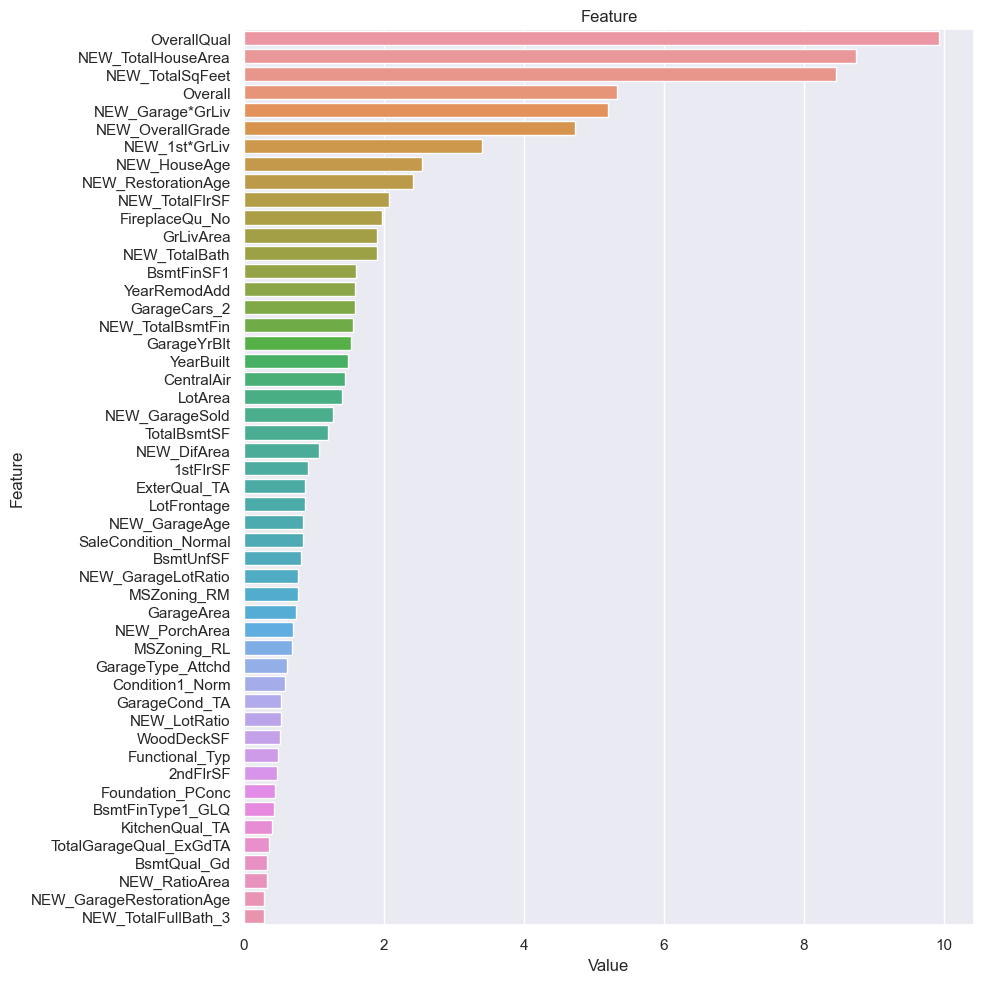

In [183]:
plot_importance(final_model, X)